In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedavg'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-3
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# df = pd.read_csv(struct_log)
# print(df.shape)

# for i in range(args.client_num):
#     bound = int(df.shape[0]/args.client_num)
#     ddf = df[i* bound : (i+1)* bound]
#     ddf.to_csv("../../loglizer/data/client_alldata/client_"+str(i)+".csv", index=None)
#     print('Client',i, ddf.shape)
#     del ddf
# del df 

In [7]:
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out


class robustlog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(robustlog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [8]:
# def datasplit(args, gpu_id = 1):
#     train_loaders = []
#     test_loaders = []
#     hidden_size = 32
#     num_directions = 2
#     topk = 5
    
#     for i in range(args.client_num):
#         struct_log = '../../loglizer/data/client_data/client_'+str(i)+".csv"
#         label_file = '../../loglizer/data/HDFS/anomaly_label.csv' # The anomaly label file
        
#         (x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = dataloader.load_HDFS(i, struct_log, label_file = label_file, window='session', window_size=args.window_size, train_ratio=args.train_ratio, split_type=args.split_type)
#         feature_extractor = Vectorizer()
#         train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
#         test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)
#         train_loader = Iterator(train_dataset, batch_size=args.batch, shuffle=True, num_workers=args.num_workers).iter
#         test_loader = Iterator(test_dataset, batch_size=args.batch, shuffle=False, num_workers=args.num_workers).iter
#         train_loaders.append(train_loader)
#         test_loaders.append(test_loader)
        
#     server_model = DeepLog(num_labels=feature_extractor.num_labels, hidden_size=hidden_size, num_directions=num_directions, topk=topk).to(device)
    
#     return train_loaders, test_loaders, server_model

In [9]:
# train_loaders, test_loaders, server_model = datasplit(args, gpu_id = 1)

# Federated learning

In [10]:
def communication(args, server_model, models, client_weights, v, grad):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]
                    server_model.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model.named_parameters():
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad[key] = param.grad
                v[key] = v[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])            
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model.named_parameters():                
                temp = torch.zeros_like(server_model.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad[key] = param.grad                
                v[key] = torch.mul(v[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model.state_dict()[key].data.copy_(models[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models[client_idx].state_dict()[key]                        
                    server_model.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])        
    return server_model, models, v, grad

In [11]:
# # setup model
server_model = loganomaly(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v = {}
grad = {}
for key in server_model.state_dict().keys():
    v[key] = torch.add(torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad[key] = torch.zeros_like(server_model.state_dict()[key],dtype=torch.float32)
loss_fun = nn.CrossEntropyLoss()
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models = [copy.deepcopy(server_model).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            trainer = Trainer(model, options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model, models, v, grad = communication(args, server_model, models, client_weights, v, grad )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx, model in enumerate(models):
            print('Client ', client_idx)
            predicter = Predicter(model, options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3423.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:03:48 | Learning rate: 0.000031


Train loss: 3.31582: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s]


Starting epoch: 1 | phase: train | ⏰: 19:03:48 | Learning rate: 0.000063


Train loss: 3.30787: 100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


Starting epoch: 2 | phase: train | ⏰: 19:03:48 | Learning rate: 0.000125


Train loss: 3.29208: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Starting epoch: 3 | phase: train | ⏰: 19:03:48 | Learning rate: 0.000250


Train loss: 3.25961: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s]


Starting epoch: 4 | phase: train | ⏰: 19:03:49 | Learning rate: 0.000500


Train loss: 3.18749: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s]


Starting epoch: 5 | phase: train | ⏰: 19:03:49 | Learning rate: 0.001000


Train loss: 2.98304: 100%|██████████| 5/5 [00:00<00:00, 14.70it/s]


Starting epoch: 6 | phase: train | ⏰: 19:03:49 | Learning rate: 0.001000


Train loss: 2.46525: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:03:50 


: 100%|██████████| 1/1 [00:00<00:00, 32.20it/s]


Validation loss: 2.0862162113189697
Starting epoch: 7 | phase: train | ⏰: 19:03:50 | Learning rate: 0.001000


Train loss: 1.94442: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]


Starting epoch: 8 | phase: train | ⏰: 19:03:50 | Learning rate: 0.001000


Train loss: 1.83519: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:03:50 


: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]


Validation loss: 1.8452236652374268
Starting epoch: 9 | phase: train | ⏰: 19:03:50 | Learning rate: 0.001000


Train loss: 1.80094: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2700.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:04:04 | Learning rate: 0.000031


Train loss: 3.31550: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s]


Starting epoch: 1 | phase: train | ⏰: 19:04:04 | Learning rate: 0.000063


Train loss: 3.30746: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Starting epoch: 2 | phase: train | ⏰: 19:04:04 | Learning rate: 0.000125


Train loss: 3.29198: 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Starting epoch: 3 | phase: train | ⏰: 19:04:05 | Learning rate: 0.000250


Train loss: 3.25991: 100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


Starting epoch: 4 | phase: train | ⏰: 19:04:05 | Learning rate: 0.000500


Train loss: 3.18678: 100%|██████████| 5/5 [00:00<00:00, 20.44it/s]


Starting epoch: 5 | phase: train | ⏰: 19:04:05 | Learning rate: 0.001000


Train loss: 2.98573: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Starting epoch: 6 | phase: train | ⏰: 19:04:06 | Learning rate: 0.001000


Train loss: 2.47176: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:04:06 


: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


Validation loss: 2.037208080291748
Starting epoch: 7 | phase: train | ⏰: 19:04:06 | Learning rate: 0.001000


Train loss: 1.95560: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]


Starting epoch: 8 | phase: train | ⏰: 19:04:06 | Learning rate: 0.001000


Train loss: 1.84075: 100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:04:07 


: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


Validation loss: 1.7747759819030762
Starting epoch: 9 | phase: train | ⏰: 19:04:07 | Learning rate: 0.001000


Train loss: 1.80715: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3454.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:04:20 | Learning rate: 0.000031


Train loss: 3.31485: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]


Starting epoch: 1 | phase: train | ⏰: 19:04:21 | Learning rate: 0.000063


Train loss: 3.30703: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s]


Starting epoch: 2 | phase: train | ⏰: 19:04:21 | Learning rate: 0.000125


Train loss: 3.29146: 100%|██████████| 5/5 [00:00<00:00, 14.67it/s]


Starting epoch: 3 | phase: train | ⏰: 19:04:21 | Learning rate: 0.000250


Train loss: 3.25941: 100%|██████████| 5/5 [00:00<00:00, 18.02it/s]


Starting epoch: 4 | phase: train | ⏰: 19:04:21 | Learning rate: 0.000500


Train loss: 3.18781: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Starting epoch: 5 | phase: train | ⏰: 19:04:22 | Learning rate: 0.001000


Train loss: 2.98390: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Starting epoch: 6 | phase: train | ⏰: 19:04:22 | Learning rate: 0.001000


Train loss: 2.46782: 100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:04:22 


: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s]


Validation loss: 2.0689847469329834
Starting epoch: 7 | phase: train | ⏰: 19:04:22 | Learning rate: 0.001000


Train loss: 1.95212: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


Starting epoch: 8 | phase: train | ⏰: 19:04:23 | Learning rate: 0.001000


Train loss: 1.85676: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:04:23 


: 100%|██████████| 1/1 [00:00<00:00, 42.29it/s]


Validation loss: 1.8257156610488892
Starting epoch: 9 | phase: train | ⏰: 19:04:23 | Learning rate: 0.001000


Train loss: 1.81694: 100%|██████████| 5/5 [00:00<00:00, 17.54it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3351.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:04:37 | Learning rate: 0.000031


Train loss: 3.31592: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 1 | phase: train | ⏰: 19:04:37 | Learning rate: 0.000063


Train loss: 3.30800: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Starting epoch: 2 | phase: train | ⏰: 19:04:37 | Learning rate: 0.000125


Train loss: 3.29237: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]


Starting epoch: 3 | phase: train | ⏰: 19:04:38 | Learning rate: 0.000250


Train loss: 3.25988: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


Starting epoch: 4 | phase: train | ⏰: 19:04:38 | Learning rate: 0.000500


Train loss: 3.18773: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Starting epoch: 5 | phase: train | ⏰: 19:04:38 | Learning rate: 0.001000


Train loss: 2.98308: 100%|██████████| 5/5 [00:00<00:00, 16.03it/s]


Starting epoch: 6 | phase: train | ⏰: 19:04:39 | Learning rate: 0.001000


Train loss: 2.46688: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:04:39 


: 100%|██████████| 1/1 [00:00<00:00, 29.67it/s]


Validation loss: 2.090698480606079
Starting epoch: 7 | phase: train | ⏰: 19:04:39 | Learning rate: 0.001000


Train loss: 1.94344: 100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


Starting epoch: 8 | phase: train | ⏰: 19:04:39 | Learning rate: 0.001000


Train loss: 1.83531: 100%|██████████| 5/5 [00:00<00:00, 18.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:04:39 


: 100%|██████████| 1/1 [00:00<00:00, 36.04it/s]


Validation loss: 1.8331999778747559
Starting epoch: 9 | phase: train | ⏰: 19:04:40 | Learning rate: 0.001000


Train loss: 1.79785: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3214.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:04:53 | Learning rate: 0.000031


Train loss: 3.31601: 100%|██████████| 5/5 [00:00<00:00, 17.86it/s]


Starting epoch: 1 | phase: train | ⏰: 19:04:53 | Learning rate: 0.000063


Train loss: 3.30768: 100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


Starting epoch: 2 | phase: train | ⏰: 19:04:54 | Learning rate: 0.000125


Train loss: 3.29211: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


Starting epoch: 3 | phase: train | ⏰: 19:04:54 | Learning rate: 0.000250


Train loss: 3.25994: 100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


Starting epoch: 4 | phase: train | ⏰: 19:04:54 | Learning rate: 0.000500


Train loss: 3.18740: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s]


Starting epoch: 5 | phase: train | ⏰: 19:04:55 | Learning rate: 0.001000


Train loss: 2.98047: 100%|██████████| 5/5 [00:00<00:00, 16.40it/s]


Starting epoch: 6 | phase: train | ⏰: 19:04:55 | Learning rate: 0.001000


Train loss: 2.46683: 100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:04:55 


: 100%|██████████| 1/1 [00:00<00:00, 31.00it/s]


Validation loss: 2.0860390663146973
Starting epoch: 7 | phase: train | ⏰: 19:04:55 | Learning rate: 0.001000


Train loss: 1.93737: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]


Starting epoch: 8 | phase: train | ⏰: 19:04:56 | Learning rate: 0.001000


Train loss: 1.83289: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:04:56 


: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s]


Validation loss: 1.8325220346450806
Starting epoch: 9 | phase: train | ⏰: 19:04:56 | Learning rate: 0.001000


Train loss: 1.79841: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


============ Test epoch 0 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:04<00:00,  9.15it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 1309.2893657684326
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 120.55it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 802.1418769359589
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 118.94it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 97.9840612411499
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 118.03it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 97.64697027206421
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 117.69it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 95.49370670318604
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3626.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:14 | Learning rate: 0.000031


Train loss: 1.76932: 100%|██████████| 5/5 [00:00<00:00, 26.21it/s]


Starting epoch: 1 | phase: train | ⏰: 19:45:14 | Learning rate: 0.000063


Train loss: 1.76764: 100%|██████████| 5/5 [00:00<00:00, 27.99it/s]


Starting epoch: 2 | phase: train | ⏰: 19:45:14 | Learning rate: 0.000125


Train loss: 1.76233: 100%|██████████| 5/5 [00:00<00:00, 22.05it/s]


Starting epoch: 3 | phase: train | ⏰: 19:45:15 | Learning rate: 0.000250


Train loss: 1.75705: 100%|██████████| 5/5 [00:00<00:00, 27.91it/s]


Starting epoch: 4 | phase: train | ⏰: 19:45:15 | Learning rate: 0.000500


Train loss: 1.73801: 100%|██████████| 5/5 [00:00<00:00, 27.02it/s]


Starting epoch: 5 | phase: train | ⏰: 19:45:15 | Learning rate: 0.001000


Train loss: 1.70257: 100%|██████████| 5/5 [00:00<00:00, 22.11it/s]


Starting epoch: 6 | phase: train | ⏰: 19:45:15 | Learning rate: 0.001000


Train loss: 1.63739: 100%|██████████| 5/5 [00:00<00:00, 28.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:45:15 


: 100%|██████████| 1/1 [00:00<00:00, 55.83it/s]


Validation loss: 1.606283187866211
Starting epoch: 7 | phase: train | ⏰: 19:45:16 | Learning rate: 0.001000


Train loss: 1.54820: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Starting epoch: 8 | phase: train | ⏰: 19:45:16 | Learning rate: 0.001000


Train loss: 1.43566: 100%|██████████| 5/5 [00:00<00:00, 28.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:45:16 


: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


Validation loss: 1.37876296043396
Starting epoch: 9 | phase: train | ⏰: 19:45:16 | Learning rate: 0.001000


Train loss: 1.30381: 100%|██████████| 5/5 [00:00<00:00, 28.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3636.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:28 | Learning rate: 0.000031


Train loss: 1.78715: 100%|██████████| 5/5 [00:00<00:00, 28.22it/s]


Starting epoch: 1 | phase: train | ⏰: 19:45:28 | Learning rate: 0.000063


Train loss: 1.78410: 100%|██████████| 5/5 [00:00<00:00, 27.54it/s]


Starting epoch: 2 | phase: train | ⏰: 19:45:29 | Learning rate: 0.000125


Train loss: 1.77666: 100%|██████████| 5/5 [00:00<00:00, 21.41it/s]


Starting epoch: 3 | phase: train | ⏰: 19:45:29 | Learning rate: 0.000250


Train loss: 1.77066: 100%|██████████| 5/5 [00:00<00:00, 28.19it/s]


Starting epoch: 4 | phase: train | ⏰: 19:45:29 | Learning rate: 0.000500


Train loss: 1.75235: 100%|██████████| 5/5 [00:00<00:00, 27.41it/s]


Starting epoch: 5 | phase: train | ⏰: 19:45:29 | Learning rate: 0.001000


Train loss: 1.71718: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 6 | phase: train | ⏰: 19:45:29 | Learning rate: 0.001000


Train loss: 1.65690: 100%|██████████| 5/5 [00:00<00:00, 28.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:45:30 


: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


Validation loss: 1.5693846940994263
Starting epoch: 7 | phase: train | ⏰: 19:45:30 | Learning rate: 0.001000


Train loss: 1.57170: 100%|██████████| 5/5 [00:00<00:00, 22.97it/s]


Starting epoch: 8 | phase: train | ⏰: 19:45:30 | Learning rate: 0.001000


Train loss: 1.45154: 100%|██████████| 5/5 [00:00<00:00, 27.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:45:30 


: 100%|██████████| 1/1 [00:00<00:00, 56.03it/s]


Validation loss: 1.3357981443405151
Starting epoch: 9 | phase: train | ⏰: 19:45:30 | Learning rate: 0.001000


Train loss: 1.32833: 100%|██████████| 5/5 [00:00<00:00, 27.46it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3535.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:42 | Learning rate: 0.000031


Train loss: 1.78849: 100%|██████████| 5/5 [00:00<00:00, 26.39it/s]


Starting epoch: 1 | phase: train | ⏰: 19:45:43 | Learning rate: 0.000063


Train loss: 1.78547: 100%|██████████| 5/5 [00:00<00:00, 27.31it/s]


Starting epoch: 2 | phase: train | ⏰: 19:45:43 | Learning rate: 0.000125


Train loss: 1.78356: 100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Starting epoch: 3 | phase: train | ⏰: 19:45:43 | Learning rate: 0.000250


Train loss: 1.77701: 100%|██████████| 5/5 [00:00<00:00, 28.47it/s]


Starting epoch: 4 | phase: train | ⏰: 19:45:43 | Learning rate: 0.000500


Train loss: 1.75957: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


Starting epoch: 5 | phase: train | ⏰: 19:45:43 | Learning rate: 0.001000


Train loss: 1.72613: 100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


Starting epoch: 6 | phase: train | ⏰: 19:45:44 | Learning rate: 0.001000


Train loss: 1.65773: 100%|██████████| 5/5 [00:00<00:00, 26.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:45:44 


: 100%|██████████| 1/1 [00:00<00:00, 46.33it/s]


Validation loss: 1.5954612493515015
Starting epoch: 7 | phase: train | ⏰: 19:45:44 | Learning rate: 0.001000


Train loss: 1.56874: 100%|██████████| 5/5 [00:00<00:00, 21.63it/s]


Starting epoch: 8 | phase: train | ⏰: 19:45:44 | Learning rate: 0.001000


Train loss: 1.45873: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:45:44 


: 100%|██████████| 1/1 [00:00<00:00, 55.21it/s]


Validation loss: 1.3662344217300415
Starting epoch: 9 | phase: train | ⏰: 19:45:44 | Learning rate: 0.001000


Train loss: 1.32259: 100%|██████████| 5/5 [00:00<00:00, 26.44it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3603.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:57 | Learning rate: 0.000031


Train loss: 1.76624: 100%|██████████| 5/5 [00:00<00:00, 27.54it/s]


Starting epoch: 1 | phase: train | ⏰: 19:45:57 | Learning rate: 0.000063


Train loss: 1.76370: 100%|██████████| 5/5 [00:00<00:00, 27.87it/s]


Starting epoch: 2 | phase: train | ⏰: 19:45:57 | Learning rate: 0.000125


Train loss: 1.76231: 100%|██████████| 5/5 [00:00<00:00, 22.37it/s]


Starting epoch: 3 | phase: train | ⏰: 19:45:57 | Learning rate: 0.000250


Train loss: 1.75135: 100%|██████████| 5/5 [00:00<00:00, 24.66it/s]


Starting epoch: 4 | phase: train | ⏰: 19:45:57 | Learning rate: 0.000500


Train loss: 1.73466: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


Starting epoch: 5 | phase: train | ⏰: 19:45:58 | Learning rate: 0.001000


Train loss: 1.70438: 100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


Starting epoch: 6 | phase: train | ⏰: 19:45:58 | Learning rate: 0.001000


Train loss: 1.64259: 100%|██████████| 5/5 [00:00<00:00, 27.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:45:58 


: 100%|██████████| 1/1 [00:00<00:00, 48.88it/s]


Validation loss: 1.5496093034744263
Starting epoch: 7 | phase: train | ⏰: 19:45:58 | Learning rate: 0.001000


Train loss: 1.54961: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Starting epoch: 8 | phase: train | ⏰: 19:45:58 | Learning rate: 0.001000


Train loss: 1.43297: 100%|██████████| 5/5 [00:00<00:00, 25.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:45:58 


: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Validation loss: 1.3026829957962036
Starting epoch: 9 | phase: train | ⏰: 19:45:58 | Learning rate: 0.001000


Train loss: 1.29988: 100%|██████████| 5/5 [00:00<00:00, 27.92it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3596.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:46:11 | Learning rate: 0.000031


Train loss: 1.77077: 100%|██████████| 5/5 [00:00<00:00, 25.61it/s]


Starting epoch: 1 | phase: train | ⏰: 19:46:11 | Learning rate: 0.000063


Train loss: 1.76860: 100%|██████████| 5/5 [00:00<00:00, 27.37it/s]


Starting epoch: 2 | phase: train | ⏰: 19:46:11 | Learning rate: 0.000125


Train loss: 1.76681: 100%|██████████| 5/5 [00:00<00:00, 20.98it/s]


Starting epoch: 3 | phase: train | ⏰: 19:46:11 | Learning rate: 0.000250


Train loss: 1.75910: 100%|██████████| 5/5 [00:00<00:00, 26.77it/s]


Starting epoch: 4 | phase: train | ⏰: 19:46:12 | Learning rate: 0.000500


Train loss: 1.74159: 100%|██████████| 5/5 [00:00<00:00, 26.70it/s]


Starting epoch: 5 | phase: train | ⏰: 19:46:12 | Learning rate: 0.001000


Train loss: 1.70440: 100%|██████████| 5/5 [00:00<00:00, 22.50it/s]


Starting epoch: 6 | phase: train | ⏰: 19:46:12 | Learning rate: 0.001000


Train loss: 1.64190: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:46:12 


: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Validation loss: 1.541758418083191
Starting epoch: 7 | phase: train | ⏰: 19:46:12 | Learning rate: 0.001000


Train loss: 1.55342: 100%|██████████| 5/5 [00:00<00:00, 21.66it/s]


Starting epoch: 8 | phase: train | ⏰: 19:46:13 | Learning rate: 0.001000


Train loss: 1.43892: 100%|██████████| 5/5 [00:00<00:00, 27.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:46:13 


: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


Validation loss: 1.3003270626068115
Starting epoch: 9 | phase: train | ⏰: 19:46:13 | Learning rate: 0.001000


Train loss: 1.30378: 100%|██████████| 5/5 [00:00<00:00, 28.34it/s]


============ Test epoch 1 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:09<00:00, 126.08it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 98.80883479118347
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 119.44it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 94.20699119567871
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:28<00:00, 12.64it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 863.8474164009094
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:33<00:00, 12.39it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 926.3265087604523
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:27<00:00, 12.78it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 904.1171522140503
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3426.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:37 | Learning rate: 0.000031


Train loss: 1.20989: 100%|██████████| 5/5 [00:00<00:00, 16.95it/s]


Starting epoch: 1 | phase: train | ⏰: 20:34:37 | Learning rate: 0.000063


Train loss: 1.20934: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Starting epoch: 2 | phase: train | ⏰: 20:34:37 | Learning rate: 0.000125


Train loss: 1.19266: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s]


Starting epoch: 3 | phase: train | ⏰: 20:34:37 | Learning rate: 0.000250


Train loss: 1.17148: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Starting epoch: 4 | phase: train | ⏰: 20:34:38 | Learning rate: 0.000500


Train loss: 1.12593: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Starting epoch: 5 | phase: train | ⏰: 20:34:38 | Learning rate: 0.001000


Train loss: 1.06903: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s]


Starting epoch: 6 | phase: train | ⏰: 20:34:38 | Learning rate: 0.001000


Train loss: 0.98731: 100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:34:39 


: 100%|██████████| 1/1 [00:00<00:00, 41.27it/s]


Validation loss: 0.8967058658599854
Starting epoch: 7 | phase: train | ⏰: 20:34:39 | Learning rate: 0.001000


Train loss: 0.90940: 100%|██████████| 5/5 [00:00<00:00, 17.94it/s]


Starting epoch: 8 | phase: train | ⏰: 20:34:39 | Learning rate: 0.001000


Train loss: 0.85786: 100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:34:39 


: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


Validation loss: 0.8008096814155579
Starting epoch: 9 | phase: train | ⏰: 20:34:39 | Learning rate: 0.001000


Train loss: 0.81212: 100%|██████████| 5/5 [00:00<00:00, 20.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3427.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:52 | Learning rate: 0.000031


Train loss: 1.23878: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


Starting epoch: 1 | phase: train | ⏰: 20:34:52 | Learning rate: 0.000063


Train loss: 1.22300: 100%|██████████| 5/5 [00:00<00:00, 20.95it/s]


Starting epoch: 2 | phase: train | ⏰: 20:34:53 | Learning rate: 0.000125


Train loss: 1.21773: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


Starting epoch: 3 | phase: train | ⏰: 20:34:53 | Learning rate: 0.000250


Train loss: 1.19087: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Starting epoch: 4 | phase: train | ⏰: 20:34:53 | Learning rate: 0.000500


Train loss: 1.15487: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s]


Starting epoch: 5 | phase: train | ⏰: 20:34:53 | Learning rate: 0.001000


Train loss: 1.09301: 100%|██████████| 5/5 [00:00<00:00, 13.88it/s]


Starting epoch: 6 | phase: train | ⏰: 20:34:54 | Learning rate: 0.001000


Train loss: 1.01412: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:34:54 


: 100%|██████████| 1/1 [00:00<00:00, 41.24it/s]


Validation loss: 0.9559686183929443
Starting epoch: 7 | phase: train | ⏰: 20:34:54 | Learning rate: 0.001000


Train loss: 0.94932: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 8 | phase: train | ⏰: 20:34:54 | Learning rate: 0.001000


Train loss: 0.90374: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:34:55 


: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Validation loss: 0.8522294163703918
Starting epoch: 9 | phase: train | ⏰: 20:34:55 | Learning rate: 0.001000


Train loss: 0.84906: 100%|██████████| 5/5 [00:00<00:00, 16.21it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3396.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:35:08 | Learning rate: 0.000031


Train loss: 1.23389: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]


Starting epoch: 1 | phase: train | ⏰: 20:35:09 | Learning rate: 0.000063


Train loss: 1.23349: 100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


Starting epoch: 2 | phase: train | ⏰: 20:35:09 | Learning rate: 0.000125


Train loss: 1.22162: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Starting epoch: 3 | phase: train | ⏰: 20:35:09 | Learning rate: 0.000250


Train loss: 1.19912: 100%|██████████| 5/5 [00:00<00:00, 21.25it/s]


Starting epoch: 4 | phase: train | ⏰: 20:35:09 | Learning rate: 0.000500


Train loss: 1.15873: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


Starting epoch: 5 | phase: train | ⏰: 20:35:10 | Learning rate: 0.001000


Train loss: 1.09079: 100%|██████████| 5/5 [00:00<00:00, 15.49it/s]


Starting epoch: 6 | phase: train | ⏰: 20:35:10 | Learning rate: 0.001000


Train loss: 1.03121: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:35:10 


: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s]


Validation loss: 0.9445103406906128
Starting epoch: 7 | phase: train | ⏰: 20:35:10 | Learning rate: 0.001000


Train loss: 0.95148: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


Starting epoch: 8 | phase: train | ⏰: 20:35:11 | Learning rate: 0.001000


Train loss: 0.89525: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:35:11 


: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


Validation loss: 0.8392506241798401
Starting epoch: 9 | phase: train | ⏰: 20:35:11 | Learning rate: 0.001000


Train loss: 0.85224: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3517.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:35:24 | Learning rate: 0.000031


Train loss: 1.21780: 100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


Starting epoch: 1 | phase: train | ⏰: 20:35:24 | Learning rate: 0.000063


Train loss: 1.21144: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Starting epoch: 2 | phase: train | ⏰: 20:35:24 | Learning rate: 0.000125


Train loss: 1.20040: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Starting epoch: 3 | phase: train | ⏰: 20:35:24 | Learning rate: 0.000250


Train loss: 1.18136: 100%|██████████| 5/5 [00:00<00:00, 20.99it/s]


Starting epoch: 4 | phase: train | ⏰: 20:35:25 | Learning rate: 0.000500


Train loss: 1.13478: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]


Starting epoch: 5 | phase: train | ⏰: 20:35:25 | Learning rate: 0.001000


Train loss: 1.08452: 100%|██████████| 5/5 [00:00<00:00, 18.16it/s]


Starting epoch: 6 | phase: train | ⏰: 20:35:25 | Learning rate: 0.001000


Train loss: 1.00527: 100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:35:26 


: 100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


Validation loss: 0.8795291781425476
Starting epoch: 7 | phase: train | ⏰: 20:35:26 | Learning rate: 0.001000


Train loss: 0.93385: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


Starting epoch: 8 | phase: train | ⏰: 20:35:26 | Learning rate: 0.001000


Train loss: 0.87676: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:35:26 


: 100%|██████████| 1/1 [00:00<00:00, 34.33it/s]


Validation loss: 0.7689509987831116
Starting epoch: 9 | phase: train | ⏰: 20:35:26 | Learning rate: 0.001000


Train loss: 0.83079: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3493.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:35:39 | Learning rate: 0.000031


Train loss: 1.22687: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 1 | phase: train | ⏰: 20:35:39 | Learning rate: 0.000063


Train loss: 1.22018: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


Starting epoch: 2 | phase: train | ⏰: 20:35:39 | Learning rate: 0.000125


Train loss: 1.20838: 100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


Starting epoch: 3 | phase: train | ⏰: 20:35:39 | Learning rate: 0.000250


Train loss: 1.18592: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


Starting epoch: 4 | phase: train | ⏰: 20:35:40 | Learning rate: 0.000500


Train loss: 1.15153: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Starting epoch: 5 | phase: train | ⏰: 20:35:40 | Learning rate: 0.001000


Train loss: 1.08496: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s]


Starting epoch: 6 | phase: train | ⏰: 20:35:40 | Learning rate: 0.001000


Train loss: 1.01445: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:35:41 


: 100%|██████████| 1/1 [00:00<00:00, 42.67it/s]


Validation loss: 1.008924126625061
Starting epoch: 7 | phase: train | ⏰: 20:35:41 | Learning rate: 0.001000


Train loss: 0.94725: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 8 | phase: train | ⏰: 20:35:41 | Learning rate: 0.001000


Train loss: 0.88932: 100%|██████████| 5/5 [00:00<00:00, 17.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:35:41 


: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


Validation loss: 0.8855646848678589
Starting epoch: 9 | phase: train | ⏰: 20:35:41 | Learning rate: 0.001000


Train loss: 0.84417: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


============ Test epoch 2 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:28<00:00, 12.83it/s]


false positive (FP): 483, false negative (FN): 24, Precision: 87.376%, Recall: 99.287%, F1-measure: 92.951%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 963.071756362915
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:31<00:00, 12.45it/s]


false positive (FP): 524, false negative (FN): 26, Precision: 86.442%, Recall: 99.228%, F1-measure: 92.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 903.8703932762146
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:28<00:00, 12.59it/s]


false positive (FP): 466, false negative (FN): 31, Precision: 87.743%, Recall: 99.079%, F1-measure: 93.067%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 917.3400492668152
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:32<00:00, 12.48it/s]


false positive (FP): 447, false negative (FN): 29, Precision: 88.190%, Recall: 99.139%, F1-measure: 93.345%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 914.1866772174835
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:26<00:00, 12.99it/s]


false positive (FP): 521, false negative (FN): 32, Precision: 86.489%, Recall: 99.050%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 886.157164812088
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3539.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:22 | Learning rate: 0.000031


Train loss: 0.78183: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:22 | Learning rate: 0.000063


Train loss: 0.77733: 100%|██████████| 5/5 [00:00<00:00, 19.60it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:23 | Learning rate: 0.000125


Train loss: 0.77056: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:23 | Learning rate: 0.000250


Train loss: 0.76328: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:23 | Learning rate: 0.000500


Train loss: 0.74751: 100%|██████████| 5/5 [00:00<00:00, 22.66it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:23 | Learning rate: 0.001000


Train loss: 0.76249: 100%|██████████| 5/5 [00:00<00:00, 14.08it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:24 | Learning rate: 0.001000


Train loss: 0.74405: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:24 


: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Validation loss: 0.7219440340995789
Starting epoch: 7 | phase: train | ⏰: 21:52:24 | Learning rate: 0.001000


Train loss: 0.71086: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:24 | Learning rate: 0.001000


Train loss: 0.67859: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:25 


: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s]


Validation loss: 0.6634275913238525
Starting epoch: 9 | phase: train | ⏰: 21:52:25 | Learning rate: 0.001000


Train loss: 0.65051: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3196.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:37 | Learning rate: 0.000031


Train loss: 0.80977: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:38 | Learning rate: 0.000063


Train loss: 0.80162: 100%|██████████| 5/5 [00:00<00:00, 18.32it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:38 | Learning rate: 0.000125


Train loss: 0.79774: 100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:38 | Learning rate: 0.000250


Train loss: 0.78741: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:39 | Learning rate: 0.000500


Train loss: 0.76536: 100%|██████████| 5/5 [00:00<00:00, 21.24it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:39 | Learning rate: 0.001000


Train loss: 0.77098: 100%|██████████| 5/5 [00:00<00:00, 16.53it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:39 | Learning rate: 0.001000


Train loss: 0.71717: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:39 


: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s]


Validation loss: 0.6867416501045227
Starting epoch: 7 | phase: train | ⏰: 21:52:39 | Learning rate: 0.001000


Train loss: 0.67972: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:40 | Learning rate: 0.001000


Train loss: 0.64553: 100%|██████████| 5/5 [00:00<00:00, 21.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:40 


: 100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


Validation loss: 0.6219214797019958
Starting epoch: 9 | phase: train | ⏰: 21:52:40 | Learning rate: 0.001000


Train loss: 0.64986: 100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3459.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:52:53 | Learning rate: 0.000031


Train loss: 0.81842: 100%|██████████| 5/5 [00:00<00:00, 20.15it/s]


Starting epoch: 1 | phase: train | ⏰: 21:52:53 | Learning rate: 0.000063


Train loss: 0.81529: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


Starting epoch: 2 | phase: train | ⏰: 21:52:53 | Learning rate: 0.000125


Train loss: 0.80780: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


Starting epoch: 3 | phase: train | ⏰: 21:52:53 | Learning rate: 0.000250


Train loss: 0.79962: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s]


Starting epoch: 4 | phase: train | ⏰: 21:52:54 | Learning rate: 0.000500


Train loss: 0.78484: 100%|██████████| 5/5 [00:00<00:00, 20.21it/s]


Starting epoch: 5 | phase: train | ⏰: 21:52:54 | Learning rate: 0.001000


Train loss: 0.77533: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Starting epoch: 6 | phase: train | ⏰: 21:52:54 | Learning rate: 0.001000


Train loss: 0.74997: 100%|██████████| 5/5 [00:00<00:00, 21.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:52:55 


: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s]


Validation loss: 0.6923583149909973
Starting epoch: 7 | phase: train | ⏰: 21:52:55 | Learning rate: 0.001000


Train loss: 0.70369: 100%|██████████| 5/5 [00:00<00:00, 16.43it/s]


Starting epoch: 8 | phase: train | ⏰: 21:52:55 | Learning rate: 0.001000


Train loss: 0.67374: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:52:55 


: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Validation loss: 0.6134120225906372
Starting epoch: 9 | phase: train | ⏰: 21:52:55 | Learning rate: 0.001000


Train loss: 0.64709: 100%|██████████| 5/5 [00:00<00:00, 20.38it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3408.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:08 | Learning rate: 0.000031


Train loss: 0.79318: 100%|██████████| 5/5 [00:00<00:00, 14.07it/s]


Starting epoch: 1 | phase: train | ⏰: 21:53:08 | Learning rate: 0.000063


Train loss: 0.79169: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]


Starting epoch: 2 | phase: train | ⏰: 21:53:09 | Learning rate: 0.000125


Train loss: 0.78442: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


Starting epoch: 3 | phase: train | ⏰: 21:53:09 | Learning rate: 0.000250


Train loss: 0.77905: 100%|██████████| 5/5 [00:00<00:00, 20.57it/s]


Starting epoch: 4 | phase: train | ⏰: 21:53:09 | Learning rate: 0.000500


Train loss: 0.76252: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Starting epoch: 5 | phase: train | ⏰: 21:53:09 | Learning rate: 0.001000


Train loss: 0.77979: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


Starting epoch: 6 | phase: train | ⏰: 21:53:10 | Learning rate: 0.001000


Train loss: 0.75786: 100%|██████████| 5/5 [00:00<00:00, 17.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:53:10 


: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


Validation loss: 0.7737650275230408
Starting epoch: 7 | phase: train | ⏰: 21:53:10 | Learning rate: 0.001000


Train loss: 0.73145: 100%|██████████| 5/5 [00:00<00:00, 17.31it/s]


Starting epoch: 8 | phase: train | ⏰: 21:53:10 | Learning rate: 0.001000


Train loss: 0.70257: 100%|██████████| 5/5 [00:00<00:00, 20.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:53:11 


: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s]


Validation loss: 0.7174363732337952
Starting epoch: 9 | phase: train | ⏰: 21:53:11 | Learning rate: 0.001000


Train loss: 0.67721: 100%|██████████| 5/5 [00:00<00:00, 21.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3509.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:23 | Learning rate: 0.000031


Train loss: 0.81214: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]


Starting epoch: 1 | phase: train | ⏰: 21:53:23 | Learning rate: 0.000063


Train loss: 0.80447: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 2 | phase: train | ⏰: 21:53:23 | Learning rate: 0.000125


Train loss: 0.80174: 100%|██████████| 5/5 [00:00<00:00, 13.60it/s]


Starting epoch: 3 | phase: train | ⏰: 21:53:24 | Learning rate: 0.000250


Train loss: 0.78859: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 4 | phase: train | ⏰: 21:53:24 | Learning rate: 0.000500


Train loss: 0.77722: 100%|██████████| 5/5 [00:00<00:00, 20.42it/s]


Starting epoch: 5 | phase: train | ⏰: 21:53:24 | Learning rate: 0.001000


Train loss: 0.82517: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


Starting epoch: 6 | phase: train | ⏰: 21:53:25 | Learning rate: 0.001000


Train loss: 0.78902: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:53:25 


: 100%|██████████| 1/1 [00:00<00:00, 27.31it/s]


Validation loss: 0.6815158724784851
Starting epoch: 7 | phase: train | ⏰: 21:53:25 | Learning rate: 0.001000


Train loss: 0.75359: 100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


Starting epoch: 8 | phase: train | ⏰: 21:53:25 | Learning rate: 0.001000


Train loss: 0.72171: 100%|██████████| 5/5 [00:00<00:00, 18.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:53:25 


: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


Validation loss: 0.6163043975830078
Starting epoch: 9 | phase: train | ⏰: 21:53:26 | Learning rate: 0.001000


Train loss: 0.69487: 100%|██████████| 5/5 [00:00<00:00, 23.74it/s]


============ Test epoch 3 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:30<00:00, 12.51it/s]


false positive (FP): 484, false negative (FN): 24, Precision: 87.353%, Recall: 99.287%, F1-measure: 92.939%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 925.0054666996002
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:36<00:00, 11.77it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 928.2766125202179
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:31<00:00, 12.28it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 942.69500207901
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:10<00:00, 16.45it/s]


false positive (FP): 447, false negative (FN): 28, Precision: 88.193%, Recall: 99.168%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 395.98184514045715
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:19<00:00, 14.11it/s]


false positive (FP): 521, false negative (FN): 33, Precision: 86.485%, Recall: 99.020%, F1-measure: 92.329%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 743.1342017650604
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3430.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:59:17 | Learning rate: 0.000031


Train loss: 0.63420: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


Starting epoch: 1 | phase: train | ⏰: 22:59:17 | Learning rate: 0.000063


Train loss: 0.62410: 100%|██████████| 5/5 [00:00<00:00, 21.03it/s]


Starting epoch: 2 | phase: train | ⏰: 22:59:17 | Learning rate: 0.000125


Train loss: 0.61140: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s]


Starting epoch: 3 | phase: train | ⏰: 22:59:17 | Learning rate: 0.000250


Train loss: 0.60002: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Starting epoch: 4 | phase: train | ⏰: 22:59:18 | Learning rate: 0.000500


Train loss: 0.59528: 100%|██████████| 5/5 [00:00<00:00, 17.55it/s]


Starting epoch: 5 | phase: train | ⏰: 22:59:18 | Learning rate: 0.001000


Train loss: 0.61818: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


Starting epoch: 6 | phase: train | ⏰: 22:59:18 | Learning rate: 0.001000


Train loss: 0.62413: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:59:19 


: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


Validation loss: 0.5622740387916565
Starting epoch: 7 | phase: train | ⏰: 22:59:19 | Learning rate: 0.001000


Train loss: 0.57962: 100%|██████████| 5/5 [00:00<00:00, 14.90it/s]


Starting epoch: 8 | phase: train | ⏰: 22:59:19 | Learning rate: 0.001000


Train loss: 0.53852: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:59:19 


: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]


Validation loss: 0.4996686279773712
Starting epoch: 9 | phase: train | ⏰: 22:59:19 | Learning rate: 0.001000


Train loss: 0.51588: 100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3607.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:59:32 | Learning rate: 0.000031


Train loss: 0.65498: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]


Starting epoch: 1 | phase: train | ⏰: 22:59:32 | Learning rate: 0.000063


Train loss: 0.64030: 100%|██████████| 5/5 [00:00<00:00, 23.12it/s]


Starting epoch: 2 | phase: train | ⏰: 22:59:32 | Learning rate: 0.000125


Train loss: 0.62634: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Starting epoch: 3 | phase: train | ⏰: 22:59:32 | Learning rate: 0.000250


Train loss: 0.61676: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


Starting epoch: 4 | phase: train | ⏰: 22:59:33 | Learning rate: 0.000500


Train loss: 0.60537: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


Starting epoch: 5 | phase: train | ⏰: 22:59:33 | Learning rate: 0.001000


Train loss: 0.66443: 100%|██████████| 5/5 [00:00<00:00, 14.07it/s]


Starting epoch: 6 | phase: train | ⏰: 22:59:33 | Learning rate: 0.001000


Train loss: 0.64950: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:59:34 


: 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]


Validation loss: 0.6482197046279907
Starting epoch: 7 | phase: train | ⏰: 22:59:34 | Learning rate: 0.001000


Train loss: 0.62182: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


Starting epoch: 8 | phase: train | ⏰: 22:59:34 | Learning rate: 0.001000


Train loss: 0.58964: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:59:34 


: 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]


Validation loss: 0.5905687212944031
Starting epoch: 9 | phase: train | ⏰: 22:59:34 | Learning rate: 0.001000


Train loss: 0.55831: 100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3412.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:59:47 | Learning rate: 0.000031


Train loss: 0.66913: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Starting epoch: 1 | phase: train | ⏰: 22:59:47 | Learning rate: 0.000063


Train loss: 0.66040: 100%|██████████| 5/5 [00:00<00:00, 19.21it/s]


Starting epoch: 2 | phase: train | ⏰: 22:59:48 | Learning rate: 0.000125


Train loss: 0.64737: 100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


Starting epoch: 3 | phase: train | ⏰: 22:59:48 | Learning rate: 0.000250


Train loss: 0.63465: 100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Starting epoch: 4 | phase: train | ⏰: 22:59:48 | Learning rate: 0.000500


Train loss: 0.62269: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Starting epoch: 5 | phase: train | ⏰: 22:59:48 | Learning rate: 0.001000


Train loss: 0.64613: 100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


Starting epoch: 6 | phase: train | ⏰: 22:59:49 | Learning rate: 0.001000


Train loss: 0.62555: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:59:49 


: 100%|██████████| 1/1 [00:00<00:00, 40.13it/s]


Validation loss: 0.5946451425552368
Starting epoch: 7 | phase: train | ⏰: 22:59:49 | Learning rate: 0.001000


Train loss: 0.59821: 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Starting epoch: 8 | phase: train | ⏰: 22:59:49 | Learning rate: 0.001000


Train loss: 0.56670: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:59:50 


: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s]


Validation loss: 0.5214363932609558
Starting epoch: 9 | phase: train | ⏰: 22:59:50 | Learning rate: 0.001000


Train loss: 0.53938: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3435.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:00:02 | Learning rate: 0.000031


Train loss: 0.64578: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


Starting epoch: 1 | phase: train | ⏰: 23:00:03 | Learning rate: 0.000063


Train loss: 0.64216: 100%|██████████| 5/5 [00:00<00:00, 20.41it/s]


Starting epoch: 2 | phase: train | ⏰: 23:00:03 | Learning rate: 0.000125


Train loss: 0.62930: 100%|██████████| 5/5 [00:00<00:00, 16.21it/s]


Starting epoch: 3 | phase: train | ⏰: 23:00:03 | Learning rate: 0.000250


Train loss: 0.61795: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 4 | phase: train | ⏰: 23:00:04 | Learning rate: 0.000500


Train loss: 0.61469: 100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Starting epoch: 5 | phase: train | ⏰: 23:00:04 | Learning rate: 0.001000


Train loss: 0.63010: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Starting epoch: 6 | phase: train | ⏰: 23:00:04 | Learning rate: 0.001000


Train loss: 0.60626: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:00:04 


: 100%|██████████| 1/1 [00:00<00:00, 50.43it/s]


Validation loss: 0.5658401250839233
Starting epoch: 7 | phase: train | ⏰: 23:00:04 | Learning rate: 0.001000


Train loss: 0.56725: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]


Starting epoch: 8 | phase: train | ⏰: 23:00:05 | Learning rate: 0.001000


Train loss: 0.53773: 100%|██████████| 5/5 [00:00<00:00, 20.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:00:05 


: 100%|██████████| 1/1 [00:00<00:00, 37.88it/s]


Validation loss: 0.5002511739730835
Starting epoch: 9 | phase: train | ⏰: 23:00:05 | Learning rate: 0.001000


Train loss: 0.51791: 100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3396.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:00:18 | Learning rate: 0.000031


Train loss: 0.67048: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Starting epoch: 1 | phase: train | ⏰: 23:00:18 | Learning rate: 0.000063


Train loss: 0.65026: 100%|██████████| 5/5 [00:00<00:00, 19.09it/s]


Starting epoch: 2 | phase: train | ⏰: 23:00:18 | Learning rate: 0.000125


Train loss: 0.64398: 100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


Starting epoch: 3 | phase: train | ⏰: 23:00:19 | Learning rate: 0.000250


Train loss: 0.62976: 100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


Starting epoch: 4 | phase: train | ⏰: 23:00:19 | Learning rate: 0.000500


Train loss: 0.61788: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]


Starting epoch: 5 | phase: train | ⏰: 23:00:19 | Learning rate: 0.001000


Train loss: 0.66373: 100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


Starting epoch: 6 | phase: train | ⏰: 23:00:20 | Learning rate: 0.001000


Train loss: 0.66880: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:00:20 


: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s]


Validation loss: 0.6495193243026733
Starting epoch: 7 | phase: train | ⏰: 23:00:20 | Learning rate: 0.001000


Train loss: 0.63997: 100%|██████████| 5/5 [00:00<00:00, 14.79it/s]


Starting epoch: 8 | phase: train | ⏰: 23:00:20 | Learning rate: 0.001000


Train loss: 0.61631: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:00:20 


: 100%|██████████| 1/1 [00:00<00:00, 37.15it/s]


Validation loss: 0.6007216572761536
Starting epoch: 9 | phase: train | ⏰: 23:00:21 | Learning rate: 0.001000


Train loss: 0.58875: 100%|██████████| 5/5 [00:00<00:00, 20.97it/s]


============ Test epoch 4 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:15<00:00, 14.96it/s]


false positive (FP): 564, false negative (FN): 27, Precision: 85.553%, Recall: 99.198%, F1-measure: 91.872%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.482
Finished Predicting
elapsed_time: 781.0774283409119
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:21<00:00, 14.05it/s]


false positive (FP): 594, false negative (FN): 27, Precision: 84.901%, Recall: 99.198%, F1-measure: 91.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.455
Finished Predicting
elapsed_time: 747.3324327468872
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:19<00:00, 14.00it/s]


false positive (FP): 534, false negative (FN): 32, Precision: 86.198%, Recall: 99.050%, F1-measure: 92.178%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.504
Finished Predicting
elapsed_time: 765.9580872058868
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:23<00:00, 13.96it/s]


false positive (FP): 514, false negative (FN): 29, Precision: 86.656%, Recall: 99.139%, F1-measure: 92.478%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 770.3665635585785
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:25<00:00, 13.06it/s]


false positive (FP): 591, false negative (FN): 32, Precision: 84.947%, Recall: 99.050%, F1-measure: 91.458%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.454
Finished Predicting
elapsed_time: 751.9149124622345
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3474.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:04:13 | Learning rate: 0.000031


Train loss: 0.51490: 100%|██████████| 5/5 [00:00<00:00, 20.69it/s]


Starting epoch: 1 | phase: train | ⏰: 00:04:14 | Learning rate: 0.000063


Train loss: 0.50628: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s]


Starting epoch: 2 | phase: train | ⏰: 00:04:14 | Learning rate: 0.000125


Train loss: 0.50102: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Starting epoch: 3 | phase: train | ⏰: 00:04:14 | Learning rate: 0.000250


Train loss: 0.49693: 100%|██████████| 5/5 [00:00<00:00, 21.15it/s]


Starting epoch: 4 | phase: train | ⏰: 00:04:14 | Learning rate: 0.000500


Train loss: 0.48962: 100%|██████████| 5/5 [00:00<00:00, 22.01it/s]


Starting epoch: 5 | phase: train | ⏰: 00:04:15 | Learning rate: 0.001000


Train loss: 0.54303: 100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


Starting epoch: 6 | phase: train | ⏰: 00:04:15 | Learning rate: 0.001000


Train loss: 0.52252: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:04:15 


: 100%|██████████| 1/1 [00:00<00:00, 32.31it/s]


Validation loss: 0.4974513053894043
Starting epoch: 7 | phase: train | ⏰: 00:04:15 | Learning rate: 0.001000


Train loss: 0.49625: 100%|██████████| 5/5 [00:00<00:00, 17.54it/s]


Starting epoch: 8 | phase: train | ⏰: 00:04:16 | Learning rate: 0.001000


Train loss: 0.47054: 100%|██████████| 5/5 [00:00<00:00, 20.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:04:16 


: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s]


Validation loss: 0.43190643191337585
Starting epoch: 9 | phase: train | ⏰: 00:04:16 | Learning rate: 0.001000


Train loss: 0.45624: 100%|██████████| 5/5 [00:00<00:00, 21.07it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3527.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:04:28 | Learning rate: 0.000031


Train loss: 0.52625: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Starting epoch: 1 | phase: train | ⏰: 00:04:28 | Learning rate: 0.000063


Train loss: 0.51046: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Starting epoch: 2 | phase: train | ⏰: 00:04:29 | Learning rate: 0.000125


Train loss: 0.50537: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]


Starting epoch: 3 | phase: train | ⏰: 00:04:29 | Learning rate: 0.000250


Train loss: 0.49611: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Starting epoch: 4 | phase: train | ⏰: 00:04:29 | Learning rate: 0.000500


Train loss: 0.49062: 100%|██████████| 5/5 [00:00<00:00, 17.79it/s]


Starting epoch: 5 | phase: train | ⏰: 00:04:30 | Learning rate: 0.001000


Train loss: 0.51058: 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]


Starting epoch: 6 | phase: train | ⏰: 00:04:30 | Learning rate: 0.001000


Train loss: 0.53392: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:04:30 


: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


Validation loss: 0.46104365587234497
Starting epoch: 7 | phase: train | ⏰: 00:04:30 | Learning rate: 0.001000


Train loss: 0.49473: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


Starting epoch: 8 | phase: train | ⏰: 00:04:30 | Learning rate: 0.001000


Train loss: 0.46495: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:04:31 


: 100%|██████████| 1/1 [00:00<00:00, 43.61it/s]


Validation loss: 0.43724897503852844
Starting epoch: 9 | phase: train | ⏰: 00:04:31 | Learning rate: 0.001000


Train loss: 0.45015: 100%|██████████| 5/5 [00:00<00:00, 20.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3453.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:04:44 | Learning rate: 0.000031


Train loss: 0.54946: 100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


Starting epoch: 1 | phase: train | ⏰: 00:04:44 | Learning rate: 0.000063


Train loss: 0.53672: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Starting epoch: 2 | phase: train | ⏰: 00:04:44 | Learning rate: 0.000125


Train loss: 0.52676: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Starting epoch: 3 | phase: train | ⏰: 00:04:45 | Learning rate: 0.000250


Train loss: 0.52970: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Starting epoch: 4 | phase: train | ⏰: 00:04:45 | Learning rate: 0.000500


Train loss: 0.51377: 100%|██████████| 5/5 [00:00<00:00, 19.70it/s]


Starting epoch: 5 | phase: train | ⏰: 00:04:45 | Learning rate: 0.001000


Train loss: 0.56326: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Starting epoch: 6 | phase: train | ⏰: 00:04:45 | Learning rate: 0.001000


Train loss: 0.57152: 100%|██████████| 5/5 [00:00<00:00, 20.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:04:46 


: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s]


Validation loss: 0.48663610219955444
Starting epoch: 7 | phase: train | ⏰: 00:04:46 | Learning rate: 0.001000


Train loss: 0.52694: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


Starting epoch: 8 | phase: train | ⏰: 00:04:46 | Learning rate: 0.001000


Train loss: 0.49193: 100%|██████████| 5/5 [00:00<00:00, 17.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:04:46 


: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s]


Validation loss: 0.42148080468177795
Starting epoch: 9 | phase: train | ⏰: 00:04:46 | Learning rate: 0.001000


Train loss: 0.47036: 100%|██████████| 5/5 [00:00<00:00, 22.30it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3512.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:04:59 | Learning rate: 0.000031


Train loss: 0.52931: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 1 | phase: train | ⏰: 00:05:00 | Learning rate: 0.000063


Train loss: 0.51848: 100%|██████████| 5/5 [00:00<00:00, 20.64it/s]


Starting epoch: 2 | phase: train | ⏰: 00:05:00 | Learning rate: 0.000125


Train loss: 0.51083: 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


Starting epoch: 3 | phase: train | ⏰: 00:05:00 | Learning rate: 0.000250


Train loss: 0.50498: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Starting epoch: 4 | phase: train | ⏰: 00:05:00 | Learning rate: 0.000500


Train loss: 0.50073: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Starting epoch: 5 | phase: train | ⏰: 00:05:01 | Learning rate: 0.001000


Train loss: 0.53239: 100%|██████████| 5/5 [00:00<00:00, 14.84it/s]


Starting epoch: 6 | phase: train | ⏰: 00:05:01 | Learning rate: 0.001000


Train loss: 0.51246: 100%|██████████| 5/5 [00:00<00:00, 19.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:05:01 


: 100%|██████████| 1/1 [00:00<00:00, 30.85it/s]


Validation loss: 0.5186349153518677
Starting epoch: 7 | phase: train | ⏰: 00:05:01 | Learning rate: 0.001000


Train loss: 0.48519: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


Starting epoch: 8 | phase: train | ⏰: 00:05:01 | Learning rate: 0.001000


Train loss: 0.45576: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:05:02 


: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s]


Validation loss: 0.4809732735157013
Starting epoch: 9 | phase: train | ⏰: 00:05:02 | Learning rate: 0.001000


Train loss: 0.44605: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3572.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:05:15 | Learning rate: 0.000031


Train loss: 0.54574: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


Starting epoch: 1 | phase: train | ⏰: 00:05:15 | Learning rate: 0.000063


Train loss: 0.52961: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Starting epoch: 2 | phase: train | ⏰: 00:05:15 | Learning rate: 0.000125


Train loss: 0.52899: 100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


Starting epoch: 3 | phase: train | ⏰: 00:05:15 | Learning rate: 0.000250


Train loss: 0.51914: 100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


Starting epoch: 4 | phase: train | ⏰: 00:05:16 | Learning rate: 0.000500


Train loss: 0.52048: 100%|██████████| 5/5 [00:00<00:00, 19.37it/s]


Starting epoch: 5 | phase: train | ⏰: 00:05:16 | Learning rate: 0.001000


Train loss: 0.50670: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s]


Starting epoch: 6 | phase: train | ⏰: 00:05:16 | Learning rate: 0.001000


Train loss: 0.50658: 100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:05:17 


: 100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


Validation loss: 0.43130263686180115
Starting epoch: 7 | phase: train | ⏰: 00:05:17 | Learning rate: 0.001000


Train loss: 0.49734: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]


Starting epoch: 8 | phase: train | ⏰: 00:05:17 | Learning rate: 0.001000


Train loss: 0.52359: 100%|██████████| 5/5 [00:00<00:00, 21.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:05:17 


: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


Validation loss: 0.4411206543445587
Starting epoch: 9 | phase: train | ⏰: 00:05:17 | Learning rate: 0.001000


Train loss: 0.47856: 100%|██████████| 5/5 [00:00<00:00, 18.09it/s]


============ Test epoch 5 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:56<00:00, 20.16it/s]


false positive (FP): 600, false negative (FN): 27, Precision: 84.772%, Recall: 99.198%, F1-measure: 91.419%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.450
Finished Predicting
elapsed_time: 614.5037684440613
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:05<00:00, 17.29it/s]


false positive (FP): 616, false negative (FN): 26, Precision: 84.433%, Recall: 99.228%, F1-measure: 91.234%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.437
Finished Predicting
elapsed_time: 542.4334070682526
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:21<00:00, 13.76it/s]


false positive (FP): 561, false negative (FN): 35, Precision: 85.590%, Recall: 98.960%, F1-measure: 91.791%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.477
Finished Predicting
elapsed_time: 748.4627878665924
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:28<00:00, 13.07it/s]


false positive (FP): 554, false negative (FN): 30, Precision: 85.762%, Recall: 99.109%, F1-measure: 91.954%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.488
Finished Predicting
elapsed_time: 813.9225125312805
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:23<00:00, 13.42it/s]


false positive (FP): 626, false negative (FN): 33, Precision: 84.192%, Recall: 99.020%, F1-measure: 91.006%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.422
Finished Predicting
elapsed_time: 790.8775365352631
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3202.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:04:05 | Learning rate: 0.000031


Train loss: 0.43189: 100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


Starting epoch: 1 | phase: train | ⏰: 01:04:06 | Learning rate: 0.000063


Train loss: 0.43214: 100%|██████████| 5/5 [00:00<00:00, 14.38it/s]


Starting epoch: 2 | phase: train | ⏰: 01:04:06 | Learning rate: 0.000125


Train loss: 0.42927: 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


Starting epoch: 3 | phase: train | ⏰: 01:04:06 | Learning rate: 0.000250


Train loss: 0.42840: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


Starting epoch: 4 | phase: train | ⏰: 01:04:07 | Learning rate: 0.000500


Train loss: 0.42510: 100%|██████████| 5/5 [00:00<00:00, 19.62it/s]


Starting epoch: 5 | phase: train | ⏰: 01:04:07 | Learning rate: 0.001000


Train loss: 0.46806: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s]


Starting epoch: 6 | phase: train | ⏰: 01:04:07 | Learning rate: 0.001000


Train loss: 0.52278: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:04:07 


: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Validation loss: 0.5780243277549744
Starting epoch: 7 | phase: train | ⏰: 01:04:08 | Learning rate: 0.001000


Train loss: 0.49109: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 8 | phase: train | ⏰: 01:04:08 | Learning rate: 0.001000


Train loss: 0.45481: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:04:08 


: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


Validation loss: 0.4363483488559723
Starting epoch: 9 | phase: train | ⏰: 01:04:08 | Learning rate: 0.001000


Train loss: 0.43369: 100%|██████████| 5/5 [00:00<00:00, 14.80it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3271.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:04:23 | Learning rate: 0.000031


Train loss: 0.43398: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 1 | phase: train | ⏰: 01:04:23 | Learning rate: 0.000063


Train loss: 0.42795: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


Starting epoch: 2 | phase: train | ⏰: 01:04:24 | Learning rate: 0.000125


Train loss: 0.42664: 100%|██████████| 5/5 [00:00<00:00, 16.40it/s]


Starting epoch: 3 | phase: train | ⏰: 01:04:24 | Learning rate: 0.000250


Train loss: 0.42755: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Starting epoch: 4 | phase: train | ⏰: 01:04:24 | Learning rate: 0.000500


Train loss: 0.42327: 100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Starting epoch: 5 | phase: train | ⏰: 01:04:25 | Learning rate: 0.001000


Train loss: 0.51289: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Starting epoch: 6 | phase: train | ⏰: 01:04:25 | Learning rate: 0.001000


Train loss: 0.52952: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:04:25 


: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]


Validation loss: 0.47692909836769104
Starting epoch: 7 | phase: train | ⏰: 01:04:25 | Learning rate: 0.001000


Train loss: 0.49435: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]


Starting epoch: 8 | phase: train | ⏰: 01:04:26 | Learning rate: 0.001000


Train loss: 0.46214: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:04:26 


: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


Validation loss: 0.4220238924026489
Starting epoch: 9 | phase: train | ⏰: 01:04:26 | Learning rate: 0.001000


Train loss: 0.44522: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3133.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:04:40 | Learning rate: 0.000031


Train loss: 0.45785: 100%|██████████| 5/5 [00:00<00:00, 14.02it/s]


Starting epoch: 1 | phase: train | ⏰: 01:04:41 | Learning rate: 0.000063


Train loss: 0.45728: 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


Starting epoch: 2 | phase: train | ⏰: 01:04:41 | Learning rate: 0.000125


Train loss: 0.45467: 100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


Starting epoch: 3 | phase: train | ⏰: 01:04:41 | Learning rate: 0.000250


Train loss: 0.45444: 100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


Starting epoch: 4 | phase: train | ⏰: 01:04:42 | Learning rate: 0.000500


Train loss: 0.45770: 100%|██████████| 5/5 [00:00<00:00, 16.04it/s]


Starting epoch: 5 | phase: train | ⏰: 01:04:42 | Learning rate: 0.001000


Train loss: 0.54727: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]


Starting epoch: 6 | phase: train | ⏰: 01:04:42 | Learning rate: 0.001000


Train loss: 0.50707: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:04:43 


: 100%|██████████| 1/1 [00:00<00:00, 34.30it/s]


Validation loss: 0.4811936020851135
Starting epoch: 7 | phase: train | ⏰: 01:04:43 | Learning rate: 0.001000


Train loss: 0.46808: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Starting epoch: 8 | phase: train | ⏰: 01:04:43 | Learning rate: 0.001000


Train loss: 0.44430: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:04:44 


: 100%|██████████| 1/1 [00:00<00:00, 30.51it/s]


Validation loss: 0.4108133316040039
Starting epoch: 9 | phase: train | ⏰: 01:04:44 | Learning rate: 0.001000


Train loss: 0.42809: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3318.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:04:58 | Learning rate: 0.000031


Train loss: 0.44059: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Starting epoch: 1 | phase: train | ⏰: 01:04:59 | Learning rate: 0.000063


Train loss: 0.43469: 100%|██████████| 5/5 [00:00<00:00, 16.65it/s]


Starting epoch: 2 | phase: train | ⏰: 01:04:59 | Learning rate: 0.000125


Train loss: 0.43464: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]


Starting epoch: 3 | phase: train | ⏰: 01:04:59 | Learning rate: 0.000250


Train loss: 0.42720: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Starting epoch: 4 | phase: train | ⏰: 01:05:00 | Learning rate: 0.000500


Train loss: 0.42800: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Starting epoch: 5 | phase: train | ⏰: 01:05:00 | Learning rate: 0.001000


Train loss: 0.50042: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Starting epoch: 6 | phase: train | ⏰: 01:05:00 | Learning rate: 0.001000


Train loss: 0.46261: 100%|██████████| 5/5 [00:00<00:00, 13.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:05:01 


: 100%|██████████| 1/1 [00:00<00:00, 33.03it/s]


Validation loss: 0.41006162762641907
Starting epoch: 7 | phase: train | ⏰: 01:05:01 | Learning rate: 0.001000


Train loss: 0.43299: 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


Starting epoch: 8 | phase: train | ⏰: 01:05:01 | Learning rate: 0.001000


Train loss: 0.43110: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:05:01 


: 100%|██████████| 1/1 [00:00<00:00, 25.76it/s]


Validation loss: 0.3911095857620239
Starting epoch: 9 | phase: train | ⏰: 01:05:01 | Learning rate: 0.001000


Train loss: 0.41770: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3262.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:05:16 | Learning rate: 0.000031


Train loss: 0.45535: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Starting epoch: 1 | phase: train | ⏰: 01:05:16 | Learning rate: 0.000063


Train loss: 0.45482: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


Starting epoch: 2 | phase: train | ⏰: 01:05:17 | Learning rate: 0.000125


Train loss: 0.44764: 100%|██████████| 5/5 [00:00<00:00, 13.57it/s]


Starting epoch: 3 | phase: train | ⏰: 01:05:17 | Learning rate: 0.000250


Train loss: 0.44146: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Starting epoch: 4 | phase: train | ⏰: 01:05:17 | Learning rate: 0.000500


Train loss: 0.46086: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


Starting epoch: 5 | phase: train | ⏰: 01:05:18 | Learning rate: 0.001000


Train loss: 0.55513: 100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


Starting epoch: 6 | phase: train | ⏰: 01:05:18 | Learning rate: 0.001000


Train loss: 0.49828: 100%|██████████| 5/5 [00:00<00:00, 17.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:05:18 


: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


Validation loss: 0.4395988881587982
Starting epoch: 7 | phase: train | ⏰: 01:05:18 | Learning rate: 0.001000


Train loss: 0.45941: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Starting epoch: 8 | phase: train | ⏰: 01:05:19 | Learning rate: 0.001000


Train loss: 0.44193: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:05:19 


: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


Validation loss: 0.4431532621383667
Starting epoch: 9 | phase: train | ⏰: 01:05:19 | Learning rate: 0.001000


Train loss: 0.43879: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


============ Test epoch 6 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:20<00:00, 14.06it/s]


false positive (FP): 634, false negative (FN): 23, Precision: 84.062%, Recall: 99.317%, F1-measure: 91.055%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.424
Finished Predicting
elapsed_time: 837.2404608726501
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.72it/s] 


false positive (FP): 649, false negative (FN): 23, Precision: 83.747%, Recall: 99.317%, F1-measure: 90.870%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.411
Finished Predicting
elapsed_time: 602.8653476238251
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:25<00:00, 13.10it/s]


false positive (FP): 579, false negative (FN): 32, Precision: 85.207%, Recall: 99.050%, F1-measure: 91.608%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.464
Finished Predicting
elapsed_time: 817.6551532745361
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:21<00:00,  5.74it/s]


false positive (FP): 586, false negative (FN): 27, Precision: 85.074%, Recall: 99.198%, F1-measure: 91.595%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.462
Finished Predicting
elapsed_time: 1281.4314801692963
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:11<00:00,  5.86it/s]


false positive (FP): 645, false negative (FN): 31, Precision: 83.798%, Recall: 99.079%, F1-measure: 90.800%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.407
Finished Predicting
elapsed_time: 1792.4152266979218
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3131.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:34:29 | Learning rate: 0.000031


Train loss: 0.40533: 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Starting epoch: 1 | phase: train | ⏰: 02:34:30 | Learning rate: 0.000063


Train loss: 0.39933: 100%|██████████| 5/5 [00:00<00:00, 14.54it/s]


Starting epoch: 2 | phase: train | ⏰: 02:34:30 | Learning rate: 0.000125


Train loss: 0.39804: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Starting epoch: 3 | phase: train | ⏰: 02:34:30 | Learning rate: 0.000250


Train loss: 0.39115: 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Starting epoch: 4 | phase: train | ⏰: 02:34:31 | Learning rate: 0.000500


Train loss: 0.38950: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s]


Starting epoch: 5 | phase: train | ⏰: 02:34:31 | Learning rate: 0.001000


Train loss: 0.45415: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


Starting epoch: 6 | phase: train | ⏰: 02:34:32 | Learning rate: 0.001000


Train loss: 0.41888: 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:34:32 


: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s]


Validation loss: 0.38878265023231506
Starting epoch: 7 | phase: train | ⏰: 02:34:32 | Learning rate: 0.001000


Train loss: 0.40546: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Starting epoch: 8 | phase: train | ⏰: 02:34:33 | Learning rate: 0.001000


Train loss: 0.44885: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:34:33 


: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


Validation loss: 0.41654783487319946
Starting epoch: 9 | phase: train | ⏰: 02:34:33 | Learning rate: 0.001000


Train loss: 0.42388: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3581.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:34:48 | Learning rate: 0.000031


Train loss: 0.39891: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


Starting epoch: 1 | phase: train | ⏰: 02:34:48 | Learning rate: 0.000063


Train loss: 0.39605: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Starting epoch: 2 | phase: train | ⏰: 02:34:48 | Learning rate: 0.000125


Train loss: 0.39420: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Starting epoch: 3 | phase: train | ⏰: 02:34:49 | Learning rate: 0.000250


Train loss: 0.39600: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Starting epoch: 4 | phase: train | ⏰: 02:34:49 | Learning rate: 0.000500


Train loss: 0.38698: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


Starting epoch: 5 | phase: train | ⏰: 02:34:49 | Learning rate: 0.001000


Train loss: 0.50672: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Starting epoch: 6 | phase: train | ⏰: 02:34:50 | Learning rate: 0.001000


Train loss: 0.47466: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:34:50 


: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


Validation loss: 0.43744000792503357
Starting epoch: 7 | phase: train | ⏰: 02:34:50 | Learning rate: 0.001000


Train loss: 0.42687: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s]


Starting epoch: 8 | phase: train | ⏰: 02:34:50 | Learning rate: 0.001000


Train loss: 0.39034: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:34:51 


: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Validation loss: 0.3859540522098541
Starting epoch: 9 | phase: train | ⏰: 02:34:51 | Learning rate: 0.001000


Train loss: 0.38417: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3332.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:35:03 | Learning rate: 0.000031


Train loss: 0.42715: 100%|██████████| 5/5 [00:00<00:00, 16.86it/s]


Starting epoch: 1 | phase: train | ⏰: 02:35:04 | Learning rate: 0.000063


Train loss: 0.42187: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]


Starting epoch: 2 | phase: train | ⏰: 02:35:04 | Learning rate: 0.000125


Train loss: 0.42015: 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Starting epoch: 3 | phase: train | ⏰: 02:35:05 | Learning rate: 0.000250


Train loss: 0.41488: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 4 | phase: train | ⏰: 02:35:05 | Learning rate: 0.000500


Train loss: 0.40958: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


Starting epoch: 5 | phase: train | ⏰: 02:35:05 | Learning rate: 0.001000


Train loss: 0.50626: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Starting epoch: 6 | phase: train | ⏰: 02:35:06 | Learning rate: 0.001000


Train loss: 0.56647: 100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:35:06 


: 100%|██████████| 1/1 [00:00<00:00, 29.77it/s]


Validation loss: 0.5441622734069824
Starting epoch: 7 | phase: train | ⏰: 02:35:06 | Learning rate: 0.001000


Train loss: 0.53086: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s]


Starting epoch: 8 | phase: train | ⏰: 02:35:06 | Learning rate: 0.001000


Train loss: 0.49043: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:35:07 


: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


Validation loss: 0.49202436208724976
Starting epoch: 9 | phase: train | ⏰: 02:35:07 | Learning rate: 0.001000


Train loss: 0.46700: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3526.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:35:19 | Learning rate: 0.000031


Train loss: 0.40785: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


Starting epoch: 1 | phase: train | ⏰: 02:35:20 | Learning rate: 0.000063


Train loss: 0.40251: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


Starting epoch: 2 | phase: train | ⏰: 02:35:20 | Learning rate: 0.000125


Train loss: 0.40130: 100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


Starting epoch: 3 | phase: train | ⏰: 02:35:20 | Learning rate: 0.000250


Train loss: 0.39484: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s]


Starting epoch: 4 | phase: train | ⏰: 02:35:21 | Learning rate: 0.000500


Train loss: 0.39263: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]


Starting epoch: 5 | phase: train | ⏰: 02:35:21 | Learning rate: 0.001000


Train loss: 0.46558: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s]


Starting epoch: 6 | phase: train | ⏰: 02:35:21 | Learning rate: 0.001000


Train loss: 0.51801: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:35:22 


: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Validation loss: 0.49610045552253723
Starting epoch: 7 | phase: train | ⏰: 02:35:22 | Learning rate: 0.001000


Train loss: 0.48045: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


Starting epoch: 8 | phase: train | ⏰: 02:35:22 | Learning rate: 0.001000


Train loss: 0.44813: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:35:23 


: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]


Validation loss: 0.44377458095550537
Starting epoch: 9 | phase: train | ⏰: 02:35:23 | Learning rate: 0.001000


Train loss: 0.43334: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3555.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:35:36 | Learning rate: 0.000031


Train loss: 0.42451: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


Starting epoch: 1 | phase: train | ⏰: 02:35:36 | Learning rate: 0.000063


Train loss: 0.41344: 100%|██████████| 5/5 [00:00<00:00, 15.10it/s]


Starting epoch: 2 | phase: train | ⏰: 02:35:36 | Learning rate: 0.000125


Train loss: 0.41150: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Starting epoch: 3 | phase: train | ⏰: 02:35:37 | Learning rate: 0.000250


Train loss: 0.41096: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


Starting epoch: 4 | phase: train | ⏰: 02:35:37 | Learning rate: 0.000500


Train loss: 0.40738: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Starting epoch: 5 | phase: train | ⏰: 02:35:37 | Learning rate: 0.001000


Train loss: 0.50644: 100%|██████████| 5/5 [00:00<00:00, 13.52it/s]


Starting epoch: 6 | phase: train | ⏰: 02:35:38 | Learning rate: 0.001000


Train loss: 0.55568: 100%|██████████| 5/5 [00:00<00:00, 14.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:35:38 


: 100%|██████████| 1/1 [00:00<00:00, 42.80it/s]


Validation loss: 0.4388512969017029
Starting epoch: 7 | phase: train | ⏰: 02:35:38 | Learning rate: 0.001000


Train loss: 0.50972: 100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Starting epoch: 8 | phase: train | ⏰: 02:35:38 | Learning rate: 0.001000


Train loss: 0.48153: 100%|██████████| 5/5 [00:00<00:00, 14.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:35:39 


: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


Validation loss: 0.39666247367858887
Starting epoch: 9 | phase: train | ⏰: 02:35:39 | Learning rate: 0.001000


Train loss: 0.45766: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s]


============ Test epoch 7 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:08<00:00,  6.03it/s]


false positive (FP): 602, false negative (FN): 31, Precision: 84.713%, Recall: 99.079%, F1-measure: 91.335%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.445
Finished Predicting
elapsed_time: 1884.832709312439
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:12<00:00,  5.92it/s]


false positive (FP): 605, false negative (FN): 32, Precision: 84.645%, Recall: 99.050%, F1-measure: 91.282%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.441
Finished Predicting
elapsed_time: 1809.4574208259583
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:11<00:00,  5.83it/s]


false positive (FP): 544, false negative (FN): 38, Precision: 85.954%, Recall: 98.871%, F1-measure: 91.961%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.490
Finished Predicting
elapsed_time: 1771.1382095813751
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:02<00:00,  9.43it/s]


false positive (FP): 551, false negative (FN): 30, Precision: 85.828%, Recall: 99.109%, F1-measure: 91.992%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.491
Finished Predicting
elapsed_time: 1236.690060377121
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:57<00:00,  9.58it/s]


false positive (FP): 604, false negative (FN): 35, Precision: 84.654%, Recall: 98.960%, F1-measure: 91.250%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.440
Finished Predicting
elapsed_time: 1119.3229532241821
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3659.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:46:16 | Learning rate: 0.000031


Train loss: 0.42798: 100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


Starting epoch: 1 | phase: train | ⏰: 04:46:16 | Learning rate: 0.000063


Train loss: 0.42517: 100%|██████████| 5/5 [00:00<00:00, 24.29it/s]


Starting epoch: 2 | phase: train | ⏰: 04:46:17 | Learning rate: 0.000125


Train loss: 0.41183: 100%|██████████| 5/5 [00:00<00:00, 20.29it/s]


Starting epoch: 3 | phase: train | ⏰: 04:46:17 | Learning rate: 0.000250


Train loss: 0.40045: 100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


Starting epoch: 4 | phase: train | ⏰: 04:46:17 | Learning rate: 0.000500


Train loss: 0.38829: 100%|██████████| 5/5 [00:00<00:00, 23.36it/s]


Starting epoch: 5 | phase: train | ⏰: 04:46:17 | Learning rate: 0.001000


Train loss: 0.40054: 100%|██████████| 5/5 [00:00<00:00, 19.70it/s]


Starting epoch: 6 | phase: train | ⏰: 04:46:17 | Learning rate: 0.001000


Train loss: 0.46111: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:46:18 


: 100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


Validation loss: 0.44449031352996826
Starting epoch: 7 | phase: train | ⏰: 04:46:18 | Learning rate: 0.001000


Train loss: 0.43311: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Starting epoch: 8 | phase: train | ⏰: 04:46:18 | Learning rate: 0.001000


Train loss: 0.42022: 100%|██████████| 5/5 [00:00<00:00, 23.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:46:18 


: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]


Validation loss: 0.3986649811267853
Starting epoch: 9 | phase: train | ⏰: 04:46:18 | Learning rate: 0.001000


Train loss: 0.40547: 100%|██████████| 5/5 [00:00<00:00, 22.77it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3632.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:46:30 | Learning rate: 0.000031


Train loss: 0.43398: 100%|██████████| 5/5 [00:00<00:00, 24.79it/s]


Starting epoch: 1 | phase: train | ⏰: 04:46:31 | Learning rate: 0.000063


Train loss: 0.42425: 100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Starting epoch: 2 | phase: train | ⏰: 04:46:31 | Learning rate: 0.000125


Train loss: 0.41660: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Starting epoch: 3 | phase: train | ⏰: 04:46:31 | Learning rate: 0.000250


Train loss: 0.40091: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 4 | phase: train | ⏰: 04:46:31 | Learning rate: 0.000500


Train loss: 0.38414: 100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


Starting epoch: 5 | phase: train | ⏰: 04:46:32 | Learning rate: 0.001000


Train loss: 0.40730: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Starting epoch: 6 | phase: train | ⏰: 04:46:32 | Learning rate: 0.001000


Train loss: 0.42866: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:46:32 


: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


Validation loss: 0.3781745135784149
Starting epoch: 7 | phase: train | ⏰: 04:46:32 | Learning rate: 0.001000


Train loss: 0.38614: 100%|██████████| 5/5 [00:00<00:00, 19.94it/s]


Starting epoch: 8 | phase: train | ⏰: 04:46:32 | Learning rate: 0.001000


Train loss: 0.36822: 100%|██████████| 5/5 [00:00<00:00, 21.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:46:32 


: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


Validation loss: 0.3614189922809601
Starting epoch: 9 | phase: train | ⏰: 04:46:33 | Learning rate: 0.001000


Train loss: 0.35924: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3554.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:46:45 | Learning rate: 0.000031


Train loss: 0.44898: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Starting epoch: 1 | phase: train | ⏰: 04:46:45 | Learning rate: 0.000063


Train loss: 0.44317: 100%|██████████| 5/5 [00:00<00:00, 23.63it/s]


Starting epoch: 2 | phase: train | ⏰: 04:46:45 | Learning rate: 0.000125


Train loss: 0.43416: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s]


Starting epoch: 3 | phase: train | ⏰: 04:46:45 | Learning rate: 0.000250


Train loss: 0.42531: 100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


Starting epoch: 4 | phase: train | ⏰: 04:46:46 | Learning rate: 0.000500


Train loss: 0.41423: 100%|██████████| 5/5 [00:00<00:00, 22.74it/s]


Starting epoch: 5 | phase: train | ⏰: 04:46:46 | Learning rate: 0.001000


Train loss: 0.43271: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


Starting epoch: 6 | phase: train | ⏰: 04:46:46 | Learning rate: 0.001000


Train loss: 0.43415: 100%|██████████| 5/5 [00:00<00:00, 20.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:46:46 


: 100%|██████████| 1/1 [00:00<00:00, 33.38it/s]


Validation loss: 0.40735405683517456
Starting epoch: 7 | phase: train | ⏰: 04:46:46 | Learning rate: 0.001000


Train loss: 0.40920: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s]


Starting epoch: 8 | phase: train | ⏰: 04:46:47 | Learning rate: 0.001000


Train loss: 0.40094: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:46:47 


: 100%|██████████| 1/1 [00:00<00:00, 34.53it/s]


Validation loss: 0.3974457383155823
Starting epoch: 9 | phase: train | ⏰: 04:46:47 | Learning rate: 0.001000


Train loss: 0.38902: 100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3619.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:46:59 | Learning rate: 0.000031


Train loss: 0.42813: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]


Starting epoch: 1 | phase: train | ⏰: 04:46:59 | Learning rate: 0.000063


Train loss: 0.42509: 100%|██████████| 5/5 [00:00<00:00, 23.36it/s]


Starting epoch: 2 | phase: train | ⏰: 04:47:00 | Learning rate: 0.000125


Train loss: 0.41707: 100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


Starting epoch: 3 | phase: train | ⏰: 04:47:00 | Learning rate: 0.000250


Train loss: 0.40560: 100%|██████████| 5/5 [00:00<00:00, 25.19it/s]


Starting epoch: 4 | phase: train | ⏰: 04:47:00 | Learning rate: 0.000500


Train loss: 0.39620: 100%|██████████| 5/5 [00:00<00:00, 24.73it/s]


Starting epoch: 5 | phase: train | ⏰: 04:47:00 | Learning rate: 0.001000


Train loss: 0.44850: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Starting epoch: 6 | phase: train | ⏰: 04:47:00 | Learning rate: 0.001000


Train loss: 0.42929: 100%|██████████| 5/5 [00:00<00:00, 22.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:47:01 


: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Validation loss: 0.43195635080337524
Starting epoch: 7 | phase: train | ⏰: 04:47:01 | Learning rate: 0.001000


Train loss: 0.41145: 100%|██████████| 5/5 [00:00<00:00, 19.05it/s]


Starting epoch: 8 | phase: train | ⏰: 04:47:01 | Learning rate: 0.001000


Train loss: 0.39879: 100%|██████████| 5/5 [00:00<00:00, 23.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:47:01 


: 100%|██████████| 1/1 [00:00<00:00, 50.70it/s]


Validation loss: 0.4019610285758972
Starting epoch: 9 | phase: train | ⏰: 04:47:01 | Learning rate: 0.001000


Train loss: 0.38819: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3557.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:47:14 | Learning rate: 0.000031


Train loss: 0.45714: 100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


Starting epoch: 1 | phase: train | ⏰: 04:47:14 | Learning rate: 0.000063


Train loss: 0.44139: 100%|██████████| 5/5 [00:00<00:00, 21.76it/s]


Starting epoch: 2 | phase: train | ⏰: 04:47:14 | Learning rate: 0.000125


Train loss: 0.43216: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Starting epoch: 3 | phase: train | ⏰: 04:47:14 | Learning rate: 0.000250


Train loss: 0.42301: 100%|██████████| 5/5 [00:00<00:00, 22.44it/s]


Starting epoch: 4 | phase: train | ⏰: 04:47:14 | Learning rate: 0.000500


Train loss: 0.44558: 100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


Starting epoch: 5 | phase: train | ⏰: 04:47:15 | Learning rate: 0.001000


Train loss: 0.45412: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


Starting epoch: 6 | phase: train | ⏰: 04:47:15 | Learning rate: 0.001000


Train loss: 0.41822: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:47:15 


: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


Validation loss: 0.38610371947288513
Starting epoch: 7 | phase: train | ⏰: 04:47:15 | Learning rate: 0.001000


Train loss: 0.39686: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


Starting epoch: 8 | phase: train | ⏰: 04:47:15 | Learning rate: 0.001000


Train loss: 0.39079: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:47:16 


: 100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


Validation loss: 0.3603321611881256
Starting epoch: 9 | phase: train | ⏰: 04:47:16 | Learning rate: 0.001000


Train loss: 0.38340: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s]


============ Test epoch 8 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:02<00:00,  9.31it/s]


false positive (FP): 517, false negative (FN): 61, Precision: 86.477%, Recall: 98.188%, F1-measure: 91.961%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.493
Finished Predicting
elapsed_time: 1169.747677564621
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:10<00:00,  8.74it/s]


false positive (FP): 505, false negative (FN): 71, Precision: 86.714%, Recall: 97.891%, F1-measure: 91.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.495
Finished Predicting
elapsed_time: 1137.0987389087677
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:04<00:00,  8.95it/s]


false positive (FP): 465, false negative (FN): 77, Precision: 87.617%, Recall: 97.713%, F1-measure: 92.390%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.525
Finished Predicting
elapsed_time: 1177.5189244747162
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:11<00:00,  8.82it/s]


false positive (FP): 467, false negative (FN): 58, Precision: 87.632%, Recall: 98.277%, F1-measure: 92.650%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.540
Finished Predicting
elapsed_time: 1162.8975002765656
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:00<00:00, 18.46it/s]


false positive (FP): 510, false negative (FN): 65, Precision: 86.621%, Recall: 98.069%, F1-measure: 91.991%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.496
Finished Predicting
elapsed_time: 927.5309736728668
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3622.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:20:26 | Learning rate: 0.000031


Train loss: 0.37197: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 1 | phase: train | ⏰: 06:20:26 | Learning rate: 0.000063


Train loss: 0.36770: 100%|██████████| 5/5 [00:00<00:00, 23.42it/s]


Starting epoch: 2 | phase: train | ⏰: 06:20:26 | Learning rate: 0.000125


Train loss: 0.36440: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


Starting epoch: 3 | phase: train | ⏰: 06:20:27 | Learning rate: 0.000250


Train loss: 0.36228: 100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Starting epoch: 4 | phase: train | ⏰: 06:20:27 | Learning rate: 0.000500


Train loss: 0.36275: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 5 | phase: train | ⏰: 06:20:27 | Learning rate: 0.001000


Train loss: 0.36452: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


Starting epoch: 6 | phase: train | ⏰: 06:20:27 | Learning rate: 0.001000


Train loss: 0.48532: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:20:27 


: 100%|██████████| 1/1 [00:00<00:00, 52.38it/s]


Validation loss: 0.4776831567287445
Starting epoch: 7 | phase: train | ⏰: 06:20:28 | Learning rate: 0.001000


Train loss: 0.44990: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Starting epoch: 8 | phase: train | ⏰: 06:20:28 | Learning rate: 0.001000


Train loss: 0.41362: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:20:28 


: 100%|██████████| 1/1 [00:00<00:00, 40.25it/s]


Validation loss: 0.40507057309150696
Starting epoch: 9 | phase: train | ⏰: 06:20:28 | Learning rate: 0.001000


Train loss: 0.38984: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3726.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:20:40 | Learning rate: 0.000031


Train loss: 0.37044: 100%|██████████| 5/5 [00:00<00:00, 23.15it/s]


Starting epoch: 1 | phase: train | ⏰: 06:20:40 | Learning rate: 0.000063


Train loss: 0.35741: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 2 | phase: train | ⏰: 06:20:40 | Learning rate: 0.000125


Train loss: 0.36040: 100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


Starting epoch: 3 | phase: train | ⏰: 06:20:41 | Learning rate: 0.000250


Train loss: 0.35592: 100%|██████████| 5/5 [00:00<00:00, 24.52it/s]


Starting epoch: 4 | phase: train | ⏰: 06:20:41 | Learning rate: 0.000500


Train loss: 0.35261: 100%|██████████| 5/5 [00:00<00:00, 24.27it/s]


Starting epoch: 5 | phase: train | ⏰: 06:20:41 | Learning rate: 0.001000


Train loss: 0.37368: 100%|██████████| 5/5 [00:00<00:00, 20.51it/s]


Starting epoch: 6 | phase: train | ⏰: 06:20:41 | Learning rate: 0.001000


Train loss: 0.52856: 100%|██████████| 5/5 [00:00<00:00, 26.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:20:42 


: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


Validation loss: 0.4156968295574188
Starting epoch: 7 | phase: train | ⏰: 06:20:42 | Learning rate: 0.001000


Train loss: 0.46170: 100%|██████████| 5/5 [00:00<00:00, 21.44it/s]


Starting epoch: 8 | phase: train | ⏰: 06:20:42 | Learning rate: 0.001000


Train loss: 0.42488: 100%|██████████| 5/5 [00:00<00:00, 25.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:20:42 


: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]


Validation loss: 0.35774368047714233
Starting epoch: 9 | phase: train | ⏰: 06:20:42 | Learning rate: 0.001000


Train loss: 0.40551: 100%|██████████| 5/5 [00:00<00:00, 25.71it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3741.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:20:54 | Learning rate: 0.000031


Train loss: 0.39741: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


Starting epoch: 1 | phase: train | ⏰: 06:20:54 | Learning rate: 0.000063


Train loss: 0.38743: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 2 | phase: train | ⏰: 06:20:55 | Learning rate: 0.000125


Train loss: 0.38484: 100%|██████████| 5/5 [00:00<00:00, 19.37it/s]


Starting epoch: 3 | phase: train | ⏰: 06:20:55 | Learning rate: 0.000250


Train loss: 0.38056: 100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


Starting epoch: 4 | phase: train | ⏰: 06:20:55 | Learning rate: 0.000500


Train loss: 0.38003: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 5 | phase: train | ⏰: 06:20:55 | Learning rate: 0.001000


Train loss: 0.39703: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 6 | phase: train | ⏰: 06:20:56 | Learning rate: 0.001000


Train loss: 0.40203: 100%|██████████| 5/5 [00:00<00:00, 24.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:20:56 


: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Validation loss: 0.441514790058136
Starting epoch: 7 | phase: train | ⏰: 06:20:56 | Learning rate: 0.001000


Train loss: 0.44032: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Starting epoch: 8 | phase: train | ⏰: 06:20:56 | Learning rate: 0.001000


Train loss: 0.42018: 100%|██████████| 5/5 [00:00<00:00, 25.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:20:56 


: 100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


Validation loss: 0.4343675673007965
Starting epoch: 9 | phase: train | ⏰: 06:20:56 | Learning rate: 0.001000


Train loss: 0.40100: 100%|██████████| 5/5 [00:00<00:00, 25.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3331.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:21:08 | Learning rate: 0.000031


Train loss: 0.37922: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 1 | phase: train | ⏰: 06:21:09 | Learning rate: 0.000063


Train loss: 0.36613: 100%|██████████| 5/5 [00:00<00:00, 25.36it/s]


Starting epoch: 2 | phase: train | ⏰: 06:21:09 | Learning rate: 0.000125


Train loss: 0.36960: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s]


Starting epoch: 3 | phase: train | ⏰: 06:21:09 | Learning rate: 0.000250


Train loss: 0.36296: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 4 | phase: train | ⏰: 06:21:09 | Learning rate: 0.000500


Train loss: 0.35889: 100%|██████████| 5/5 [00:00<00:00, 22.98it/s]


Starting epoch: 5 | phase: train | ⏰: 06:21:10 | Learning rate: 0.001000


Train loss: 0.40996: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 6 | phase: train | ⏰: 06:21:10 | Learning rate: 0.001000


Train loss: 0.59613: 100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:21:10 


: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s]


Validation loss: 0.5458230972290039
Starting epoch: 7 | phase: train | ⏰: 06:21:10 | Learning rate: 0.001000


Train loss: 0.52391: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


Starting epoch: 8 | phase: train | ⏰: 06:21:10 | Learning rate: 0.001000


Train loss: 0.50698: 100%|██████████| 5/5 [00:00<00:00, 22.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:21:11 


: 100%|██████████| 1/1 [00:00<00:00, 55.96it/s]


Validation loss: 0.5028590559959412
Starting epoch: 9 | phase: train | ⏰: 06:21:11 | Learning rate: 0.001000


Train loss: 0.47086: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3747.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:21:23 | Learning rate: 0.000031


Train loss: 0.38950: 100%|██████████| 5/5 [00:00<00:00, 24.85it/s]


Starting epoch: 1 | phase: train | ⏰: 06:21:23 | Learning rate: 0.000063


Train loss: 0.38354: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Starting epoch: 2 | phase: train | ⏰: 06:21:23 | Learning rate: 0.000125


Train loss: 0.38267: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 3 | phase: train | ⏰: 06:21:23 | Learning rate: 0.000250


Train loss: 0.37870: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Starting epoch: 4 | phase: train | ⏰: 06:21:23 | Learning rate: 0.000500


Train loss: 0.37651: 100%|██████████| 5/5 [00:00<00:00, 22.59it/s]


Starting epoch: 5 | phase: train | ⏰: 06:21:24 | Learning rate: 0.001000


Train loss: 0.37853: 100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


Starting epoch: 6 | phase: train | ⏰: 06:21:24 | Learning rate: 0.001000


Train loss: 0.53546: 100%|██████████| 5/5 [00:00<00:00, 24.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:21:24 


: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


Validation loss: 0.4598110318183899
Starting epoch: 7 | phase: train | ⏰: 06:21:24 | Learning rate: 0.001000


Train loss: 0.49277: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 8 | phase: train | ⏰: 06:21:24 | Learning rate: 0.001000


Train loss: 0.44599: 100%|██████████| 5/5 [00:00<00:00, 22.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:21:25 


: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


Validation loss: 0.40729406476020813
Starting epoch: 9 | phase: train | ⏰: 06:21:25 | Learning rate: 0.001000


Train loss: 0.41848: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s]


============ Test epoch 9 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:57<00:00, 19.83it/s]


false positive (FP): 567, false negative (FN): 47, Precision: 85.413%, Recall: 98.604%, F1-measure: 91.536%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.462
Finished Predicting
elapsed_time: 577.3205795288086
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 115.82it/s]


false positive (FP): 569, false negative (FN): 47, Precision: 85.369%, Recall: 98.604%, F1-measure: 91.510%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.460
Finished Predicting
elapsed_time: 382.0215618610382
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 116.42it/s]


false positive (FP): 506, false negative (FN): 57, Precision: 86.740%, Recall: 98.307%, F1-measure: 92.162%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.506
Finished Predicting
elapsed_time: 93.63372898101807
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:10<00:00, 113.82it/s]


false positive (FP): 496, false negative (FN): 50, Precision: 86.992%, Recall: 98.515%, F1-measure: 92.396%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 93.832603931427
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 117.58it/s]


false positive (FP): 539, false negative (FN): 57, Precision: 85.996%, Recall: 98.307%, F1-measure: 91.741%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.477
Finished Predicting
elapsed_time: 91.47163605690002
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3845.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:42:18 | Learning rate: 0.000031


Train loss: 0.41615: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 1 | phase: train | ⏰: 06:42:18 | Learning rate: 0.000063


Train loss: 0.39168: 100%|██████████| 5/5 [00:00<00:00, 29.88it/s]


Starting epoch: 2 | phase: train | ⏰: 06:42:18 | Learning rate: 0.000125


Train loss: 0.39330: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 06:42:18 | Learning rate: 0.000250


Train loss: 0.38492: 100%|██████████| 5/5 [00:00<00:00, 30.14it/s]


Starting epoch: 4 | phase: train | ⏰: 06:42:19 | Learning rate: 0.000500


Train loss: 0.37864: 100%|██████████| 5/5 [00:00<00:00, 30.08it/s]


Starting epoch: 5 | phase: train | ⏰: 06:42:19 | Learning rate: 0.001000


Train loss: 0.37235: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 6 | phase: train | ⏰: 06:42:19 | Learning rate: 0.001000


Train loss: 0.36236: 100%|██████████| 5/5 [00:00<00:00, 29.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:42:19 


: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Validation loss: 0.38731649518013
Starting epoch: 7 | phase: train | ⏰: 06:42:19 | Learning rate: 0.001000


Train loss: 0.36867: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Starting epoch: 8 | phase: train | ⏰: 06:42:19 | Learning rate: 0.001000


Train loss: 0.36159: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:42:19 


: 100%|██████████| 1/1 [00:00<00:00, 57.32it/s]


Validation loss: 0.3799193203449249
Starting epoch: 9 | phase: train | ⏰: 06:42:20 | Learning rate: 0.001000


Train loss: 0.35848: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3758.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:42:31 | Learning rate: 0.000031


Train loss: 0.41552: 100%|██████████| 5/5 [00:00<00:00, 30.74it/s]


Starting epoch: 1 | phase: train | ⏰: 06:42:31 | Learning rate: 0.000063


Train loss: 0.39225: 100%|██████████| 5/5 [00:00<00:00, 30.84it/s]


Starting epoch: 2 | phase: train | ⏰: 06:42:32 | Learning rate: 0.000125


Train loss: 0.39403: 100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Starting epoch: 3 | phase: train | ⏰: 06:42:32 | Learning rate: 0.000250


Train loss: 0.38063: 100%|██████████| 5/5 [00:00<00:00, 30.74it/s]


Starting epoch: 4 | phase: train | ⏰: 06:42:32 | Learning rate: 0.000500


Train loss: 0.37644: 100%|██████████| 5/5 [00:00<00:00, 30.87it/s]


Starting epoch: 5 | phase: train | ⏰: 06:42:32 | Learning rate: 0.001000


Train loss: 0.36419: 100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Starting epoch: 6 | phase: train | ⏰: 06:42:32 | Learning rate: 0.001000


Train loss: 0.35333: 100%|██████████| 5/5 [00:00<00:00, 31.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:42:32 


: 100%|██████████| 1/1 [00:00<00:00, 59.32it/s]


Validation loss: 0.37002673745155334
Starting epoch: 7 | phase: train | ⏰: 06:42:32 | Learning rate: 0.001000


Train loss: 0.36255: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 8 | phase: train | ⏰: 06:42:33 | Learning rate: 0.001000


Train loss: 0.35983: 100%|██████████| 5/5 [00:00<00:00, 30.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:42:33 


: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s]


Validation loss: 0.39157021045684814
Starting epoch: 9 | phase: train | ⏰: 06:42:33 | Learning rate: 0.001000


Train loss: 0.35091: 100%|██████████| 5/5 [00:00<00:00, 31.07it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3886.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:42:45 | Learning rate: 0.000031


Train loss: 0.43915: 100%|██████████| 5/5 [00:00<00:00, 29.44it/s]


Starting epoch: 1 | phase: train | ⏰: 06:42:45 | Learning rate: 0.000063


Train loss: 0.41253: 100%|██████████| 5/5 [00:00<00:00, 29.16it/s]


Starting epoch: 2 | phase: train | ⏰: 06:42:45 | Learning rate: 0.000125


Train loss: 0.41390: 100%|██████████| 5/5 [00:00<00:00, 23.46it/s]


Starting epoch: 3 | phase: train | ⏰: 06:42:45 | Learning rate: 0.000250


Train loss: 0.40458: 100%|██████████| 5/5 [00:00<00:00, 29.73it/s]


Starting epoch: 4 | phase: train | ⏰: 06:42:45 | Learning rate: 0.000500


Train loss: 0.39589: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 5 | phase: train | ⏰: 06:42:46 | Learning rate: 0.001000


Train loss: 0.38559: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 6 | phase: train | ⏰: 06:42:46 | Learning rate: 0.001000


Train loss: 0.37434: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:42:46 


: 100%|██████████| 1/1 [00:00<00:00, 59.25it/s]


Validation loss: 0.3459903597831726
Starting epoch: 7 | phase: train | ⏰: 06:42:46 | Learning rate: 0.001000


Train loss: 0.37478: 100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


Starting epoch: 8 | phase: train | ⏰: 06:42:46 | Learning rate: 0.001000


Train loss: 0.39051: 100%|██████████| 5/5 [00:00<00:00, 29.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:42:46 


: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Validation loss: 0.3570983409881592
Starting epoch: 9 | phase: train | ⏰: 06:42:46 | Learning rate: 0.001000


Train loss: 0.37506: 100%|██████████| 5/5 [00:00<00:00, 29.85it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3786.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:42:58 | Learning rate: 0.000031


Train loss: 0.41225: 100%|██████████| 5/5 [00:00<00:00, 27.97it/s]


Starting epoch: 1 | phase: train | ⏰: 06:42:58 | Learning rate: 0.000063


Train loss: 0.38926: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


Starting epoch: 2 | phase: train | ⏰: 06:42:59 | Learning rate: 0.000125


Train loss: 0.39109: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 3 | phase: train | ⏰: 06:42:59 | Learning rate: 0.000250


Train loss: 0.38624: 100%|██████████| 5/5 [00:00<00:00, 30.42it/s]


Starting epoch: 4 | phase: train | ⏰: 06:42:59 | Learning rate: 0.000500


Train loss: 0.38095: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 5 | phase: train | ⏰: 06:42:59 | Learning rate: 0.001000


Train loss: 0.37364: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]


Starting epoch: 6 | phase: train | ⏰: 06:42:59 | Learning rate: 0.001000


Train loss: 0.36091: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:42:59 


: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s]


Validation loss: 0.35654741525650024
Starting epoch: 7 | phase: train | ⏰: 06:42:59 | Learning rate: 0.001000


Train loss: 0.38199: 100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Starting epoch: 8 | phase: train | ⏰: 06:43:00 | Learning rate: 0.001000


Train loss: 0.42223: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:43:00 


: 100%|██████████| 1/1 [00:00<00:00, 58.15it/s]


Validation loss: 0.40525439381599426
Starting epoch: 9 | phase: train | ⏰: 06:43:00 | Learning rate: 0.001000


Train loss: 0.39351: 100%|██████████| 5/5 [00:00<00:00, 30.51it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3903.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:43:12 | Learning rate: 0.000031


Train loss: 0.43181: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 1 | phase: train | ⏰: 06:43:12 | Learning rate: 0.000063


Train loss: 0.41102: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Starting epoch: 2 | phase: train | ⏰: 06:43:12 | Learning rate: 0.000125


Train loss: 0.41100: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


Starting epoch: 3 | phase: train | ⏰: 06:43:12 | Learning rate: 0.000250


Train loss: 0.39923: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Starting epoch: 4 | phase: train | ⏰: 06:43:12 | Learning rate: 0.000500


Train loss: 0.39556: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 5 | phase: train | ⏰: 06:43:12 | Learning rate: 0.001000


Train loss: 0.38048: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 6 | phase: train | ⏰: 06:43:13 | Learning rate: 0.001000


Train loss: 0.36793: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:43:13 


: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


Validation loss: 0.36551302671432495
Starting epoch: 7 | phase: train | ⏰: 06:43:13 | Learning rate: 0.001000


Train loss: 0.36508: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 8 | phase: train | ⏰: 06:43:13 | Learning rate: 0.001000


Train loss: 0.36382: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:43:13 


: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Validation loss: 0.37086448073387146
Starting epoch: 9 | phase: train | ⏰: 06:43:13 | Learning rate: 0.001000


Train loss: 0.36504: 100%|██████████| 5/5 [00:00<00:00, 30.25it/s]


============ Test epoch 10 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 112.88it/s]


false positive (FP): 410, false negative (FN): 67, Precision: 88.949%, Recall: 98.010%, F1-measure: 93.260%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 95.19931674003601
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 108.44it/s]


false positive (FP): 407, false negative (FN): 74, Precision: 89.000%, Recall: 97.802%, F1-measure: 93.194%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.578
Finished Predicting
elapsed_time: 91.46568751335144
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 108.54it/s]


false positive (FP): 367, false negative (FN): 78, Precision: 89.962%, Recall: 97.683%, F1-measure: 93.664%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 94.41343593597412
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:10<00:00, 107.47it/s]


false positive (FP): 367, false negative (FN): 65, Precision: 89.997%, Recall: 98.069%, F1-measure: 93.860%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 95.59258508682251
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 109.38it/s]


false positive (FP): 403, false negative (FN): 75, Precision: 89.093%, Recall: 97.772%, F1-measure: 93.231%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.581
Finished Predicting
elapsed_time: 92.8151626586914
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3831.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:51:17 | Learning rate: 0.000031


Train loss: 0.35360: 100%|██████████| 5/5 [00:00<00:00, 29.75it/s]


Starting epoch: 1 | phase: train | ⏰: 06:51:18 | Learning rate: 0.000063


Train loss: 0.35383: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 2 | phase: train | ⏰: 06:51:18 | Learning rate: 0.000125


Train loss: 0.34977: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 3 | phase: train | ⏰: 06:51:18 | Learning rate: 0.000250


Train loss: 0.34389: 100%|██████████| 5/5 [00:00<00:00, 30.12it/s]


Starting epoch: 4 | phase: train | ⏰: 06:51:18 | Learning rate: 0.000500


Train loss: 0.34366: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 5 | phase: train | ⏰: 06:51:18 | Learning rate: 0.001000


Train loss: 0.40629: 100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


Starting epoch: 6 | phase: train | ⏰: 06:51:18 | Learning rate: 0.001000


Train loss: 0.41034: 100%|██████████| 5/5 [00:00<00:00, 30.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:51:19 


: 100%|██████████| 1/1 [00:00<00:00, 59.13it/s]


Validation loss: 0.4254474341869354
Starting epoch: 7 | phase: train | ⏰: 06:51:19 | Learning rate: 0.001000


Train loss: 0.38954: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]


Starting epoch: 8 | phase: train | ⏰: 06:51:19 | Learning rate: 0.001000


Train loss: 0.37345: 100%|██████████| 5/5 [00:00<00:00, 29.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:51:19 


: 100%|██████████| 1/1 [00:00<00:00, 57.30it/s]


Validation loss: 0.3819098472595215
Starting epoch: 9 | phase: train | ⏰: 06:51:19 | Learning rate: 0.001000


Train loss: 0.35771: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3830.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:51:31 | Learning rate: 0.000031


Train loss: 0.35187: 100%|██████████| 5/5 [00:00<00:00, 30.79it/s]


Starting epoch: 1 | phase: train | ⏰: 06:51:31 | Learning rate: 0.000063


Train loss: 0.34906: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 2 | phase: train | ⏰: 06:51:31 | Learning rate: 0.000125


Train loss: 0.34047: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 3 | phase: train | ⏰: 06:51:31 | Learning rate: 0.000250


Train loss: 0.33910: 100%|██████████| 5/5 [00:00<00:00, 30.32it/s]


Starting epoch: 4 | phase: train | ⏰: 06:51:31 | Learning rate: 0.000500


Train loss: 0.33715: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


Starting epoch: 5 | phase: train | ⏰: 06:51:32 | Learning rate: 0.001000


Train loss: 0.39987: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Starting epoch: 6 | phase: train | ⏰: 06:51:32 | Learning rate: 0.001000


Train loss: 0.43117: 100%|██████████| 5/5 [00:00<00:00, 30.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:51:32 


: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


Validation loss: 0.40338626503944397
Starting epoch: 7 | phase: train | ⏰: 06:51:32 | Learning rate: 0.001000


Train loss: 0.40825: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 8 | phase: train | ⏰: 06:51:32 | Learning rate: 0.001000


Train loss: 0.39102: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:51:32 


: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]


Validation loss: 0.3566828966140747
Starting epoch: 9 | phase: train | ⏰: 06:51:32 | Learning rate: 0.001000


Train loss: 0.36085: 100%|██████████| 5/5 [00:00<00:00, 30.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3708.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:51:44 | Learning rate: 0.000031


Train loss: 0.37367: 100%|██████████| 5/5 [00:00<00:00, 29.35it/s]


Starting epoch: 1 | phase: train | ⏰: 06:51:44 | Learning rate: 0.000063


Train loss: 0.36830: 100%|██████████| 5/5 [00:00<00:00, 29.50it/s]


Starting epoch: 2 | phase: train | ⏰: 06:51:45 | Learning rate: 0.000125


Train loss: 0.36488: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Starting epoch: 3 | phase: train | ⏰: 06:51:45 | Learning rate: 0.000250


Train loss: 0.36160: 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


Starting epoch: 4 | phase: train | ⏰: 06:51:45 | Learning rate: 0.000500


Train loss: 0.36318: 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


Starting epoch: 5 | phase: train | ⏰: 06:51:45 | Learning rate: 0.001000


Train loss: 0.37595: 100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


Starting epoch: 6 | phase: train | ⏰: 06:51:45 | Learning rate: 0.001000


Train loss: 0.36575: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:51:46 


: 100%|██████████| 1/1 [00:00<00:00, 59.11it/s]


Validation loss: 0.4604768455028534
Starting epoch: 7 | phase: train | ⏰: 06:51:46 | Learning rate: 0.001000


Train loss: 0.42648: 100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Starting epoch: 8 | phase: train | ⏰: 06:51:46 | Learning rate: 0.001000


Train loss: 0.37784: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:51:46 


: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s]


Validation loss: 0.3403248190879822
Starting epoch: 9 | phase: train | ⏰: 06:51:46 | Learning rate: 0.001000


Train loss: 0.37284: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3677.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:51:58 | Learning rate: 0.000031


Train loss: 0.35376: 100%|██████████| 5/5 [00:00<00:00, 29.21it/s]


Starting epoch: 1 | phase: train | ⏰: 06:51:58 | Learning rate: 0.000063


Train loss: 0.34945: 100%|██████████| 5/5 [00:00<00:00, 29.35it/s]


Starting epoch: 2 | phase: train | ⏰: 06:51:58 | Learning rate: 0.000125


Train loss: 0.35350: 100%|██████████| 5/5 [00:00<00:00, 23.74it/s]


Starting epoch: 3 | phase: train | ⏰: 06:51:58 | Learning rate: 0.000250


Train loss: 0.34812: 100%|██████████| 5/5 [00:00<00:00, 30.21it/s]


Starting epoch: 4 | phase: train | ⏰: 06:51:58 | Learning rate: 0.000500


Train loss: 0.34548: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 5 | phase: train | ⏰: 06:51:59 | Learning rate: 0.001000


Train loss: 0.39783: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 6 | phase: train | ⏰: 06:51:59 | Learning rate: 0.001000


Train loss: 0.38304: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:51:59 


: 100%|██████████| 1/1 [00:00<00:00, 56.98it/s]


Validation loss: 0.3700239062309265
Starting epoch: 7 | phase: train | ⏰: 06:51:59 | Learning rate: 0.001000


Train loss: 0.36625: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 8 | phase: train | ⏰: 06:51:59 | Learning rate: 0.001000


Train loss: 0.35024: 100%|██████████| 5/5 [00:00<00:00, 30.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:51:59 


: 100%|██████████| 1/1 [00:00<00:00, 57.30it/s]


Validation loss: 0.3692094385623932
Starting epoch: 9 | phase: train | ⏰: 06:51:59 | Learning rate: 0.001000


Train loss: 0.35341: 100%|██████████| 5/5 [00:00<00:00, 30.32it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3758.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:52:11 | Learning rate: 0.000031


Train loss: 0.37087: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 1 | phase: train | ⏰: 06:52:11 | Learning rate: 0.000063


Train loss: 0.36616: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 2 | phase: train | ⏰: 06:52:11 | Learning rate: 0.000125


Train loss: 0.35974: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 3 | phase: train | ⏰: 06:52:12 | Learning rate: 0.000250


Train loss: 0.35957: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 4 | phase: train | ⏰: 06:52:12 | Learning rate: 0.000500


Train loss: 0.35710: 100%|██████████| 5/5 [00:00<00:00, 30.39it/s]


Starting epoch: 5 | phase: train | ⏰: 06:52:12 | Learning rate: 0.001000


Train loss: 0.37481: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 6 | phase: train | ⏰: 06:52:12 | Learning rate: 0.001000


Train loss: 0.46497: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 06:52:12 


: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


Validation loss: 0.37616652250289917
Starting epoch: 7 | phase: train | ⏰: 06:52:12 | Learning rate: 0.001000


Train loss: 0.42492: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Starting epoch: 8 | phase: train | ⏰: 06:52:12 | Learning rate: 0.001000


Train loss: 0.39375: 100%|██████████| 5/5 [00:00<00:00, 30.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 06:52:13 


: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Validation loss: 0.3226262927055359
Starting epoch: 9 | phase: train | ⏰: 06:52:13 | Learning rate: 0.001000


Train loss: 0.38329: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


============ Test epoch 11 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 110.80it/s]


false positive (FP): 359, false negative (FN): 132, Precision: 90.011%, Recall: 96.080%, F1-measure: 92.946%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 95.20013117790222
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 105.61it/s]


false positive (FP): 357, false negative (FN): 136, Precision: 90.050%, Recall: 95.961%, F1-measure: 92.912%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.568
Finished Predicting
elapsed_time: 91.93640065193176
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 105.46it/s]


false positive (FP): 318, false negative (FN): 149, Precision: 91.007%, Recall: 95.575%, F1-measure: 93.235%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 95.14422702789307
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 104.39it/s]


false positive (FP): 303, false negative (FN): 127, Precision: 91.448%, Recall: 96.228%, F1-measure: 93.777%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 95.10677576065063
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 106.32it/s]


false positive (FP): 344, false negative (FN): 141, Precision: 90.364%, Recall: 95.812%, F1-measure: 93.009%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 92.3052453994751
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3671.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:17 | Learning rate: 0.000031


Train loss: 0.35321: 100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:17 | Learning rate: 0.000063


Train loss: 0.35127: 100%|██████████| 5/5 [00:00<00:00, 30.30it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:17 | Learning rate: 0.000125


Train loss: 0.34722: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:18 | Learning rate: 0.000250


Train loss: 0.34553: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:18 | Learning rate: 0.000500


Train loss: 0.33759: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:18 | Learning rate: 0.001000


Train loss: 0.36876: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:18 | Learning rate: 0.001000


Train loss: 0.38427: 100%|██████████| 5/5 [00:00<00:00, 29.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:18 


: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s]


Validation loss: 0.3809211254119873
Starting epoch: 7 | phase: train | ⏰: 07:00:18 | Learning rate: 0.001000


Train loss: 0.35869: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:19 | Learning rate: 0.001000


Train loss: 0.34713: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:19 


: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Validation loss: 0.362939715385437
Starting epoch: 9 | phase: train | ⏰: 07:00:19 | Learning rate: 0.001000


Train loss: 0.34089: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3839.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:30 | Learning rate: 0.000031


Train loss: 0.34252: 100%|██████████| 5/5 [00:00<00:00, 30.56it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:30 | Learning rate: 0.000063


Train loss: 0.34489: 100%|██████████| 5/5 [00:00<00:00, 30.79it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:31 | Learning rate: 0.000125


Train loss: 0.34088: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:31 | Learning rate: 0.000250


Train loss: 0.33075: 100%|██████████| 5/5 [00:00<00:00, 30.79it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:31 | Learning rate: 0.000500


Train loss: 0.33027: 100%|██████████| 5/5 [00:00<00:00, 30.95it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.36656: 100%|██████████| 5/5 [00:00<00:00, 24.23it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.39463: 100%|██████████| 5/5 [00:00<00:00, 30.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:31 


: 100%|██████████| 1/1 [00:00<00:00, 59.10it/s]


Validation loss: 0.33870604634284973
Starting epoch: 7 | phase: train | ⏰: 07:00:31 | Learning rate: 0.001000


Train loss: 0.36144: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:32 | Learning rate: 0.001000


Train loss: 0.34825: 100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:32 


: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]


Validation loss: 0.2961318790912628
Starting epoch: 9 | phase: train | ⏰: 07:00:32 | Learning rate: 0.001000


Train loss: 0.34316: 100%|██████████| 5/5 [00:00<00:00, 31.01it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3818.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000031


Train loss: 0.36860: 100%|██████████| 5/5 [00:00<00:00, 29.05it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000063


Train loss: 0.36621: 100%|██████████| 5/5 [00:00<00:00, 29.75it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000125


Train loss: 0.36343: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000250


Train loss: 0.35715: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:44 | Learning rate: 0.000500


Train loss: 0.36102: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.35403: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.34848: 100%|██████████| 5/5 [00:00<00:00, 29.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:45 


: 100%|██████████| 1/1 [00:00<00:00, 58.64it/s]


Validation loss: 0.3254108130931854
Starting epoch: 7 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.37865: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.39097: 100%|██████████| 5/5 [00:00<00:00, 29.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:45 


: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s]


Validation loss: 0.3358699083328247
Starting epoch: 9 | phase: train | ⏰: 07:00:45 | Learning rate: 0.001000


Train loss: 0.36268: 100%|██████████| 5/5 [00:00<00:00, 29.56it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3697.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:57 | Learning rate: 0.000031


Train loss: 0.35313: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 1 | phase: train | ⏰: 07:00:57 | Learning rate: 0.000063


Train loss: 0.35101: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 2 | phase: train | ⏰: 07:00:57 | Learning rate: 0.000125


Train loss: 0.34932: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 3 | phase: train | ⏰: 07:00:58 | Learning rate: 0.000250


Train loss: 0.34468: 100%|██████████| 5/5 [00:00<00:00, 30.56it/s]


Starting epoch: 4 | phase: train | ⏰: 07:00:58 | Learning rate: 0.000500


Train loss: 0.34056: 100%|██████████| 5/5 [00:00<00:00, 30.63it/s]


Starting epoch: 5 | phase: train | ⏰: 07:00:58 | Learning rate: 0.001000


Train loss: 0.33392: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 6 | phase: train | ⏰: 07:00:58 | Learning rate: 0.001000


Train loss: 0.37922: 100%|██████████| 5/5 [00:00<00:00, 29.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:00:58 


: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]


Validation loss: 0.4667931795120239
Starting epoch: 7 | phase: train | ⏰: 07:00:58 | Learning rate: 0.001000


Train loss: 0.43842: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 8 | phase: train | ⏰: 07:00:59 | Learning rate: 0.001000


Train loss: 0.39091: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:00:59 


: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


Validation loss: 0.3487488031387329
Starting epoch: 9 | phase: train | ⏰: 07:00:59 | Learning rate: 0.001000


Train loss: 0.37246: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3812.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:01:10 | Learning rate: 0.000031


Train loss: 0.37063: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


Starting epoch: 1 | phase: train | ⏰: 07:01:10 | Learning rate: 0.000063


Train loss: 0.36391: 100%|██████████| 5/5 [00:00<00:00, 30.35it/s]


Starting epoch: 2 | phase: train | ⏰: 07:01:11 | Learning rate: 0.000125


Train loss: 0.35940: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 3 | phase: train | ⏰: 07:01:11 | Learning rate: 0.000250


Train loss: 0.35759: 100%|██████████| 5/5 [00:00<00:00, 30.46it/s]


Starting epoch: 4 | phase: train | ⏰: 07:01:11 | Learning rate: 0.000500


Train loss: 0.34779: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Starting epoch: 5 | phase: train | ⏰: 07:01:11 | Learning rate: 0.001000


Train loss: 0.39683: 100%|██████████| 5/5 [00:00<00:00, 24.22it/s]


Starting epoch: 6 | phase: train | ⏰: 07:01:11 | Learning rate: 0.001000


Train loss: 0.42578: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:01:12 


: 100%|██████████| 1/1 [00:00<00:00, 59.13it/s]


Validation loss: 0.397693008184433
Starting epoch: 7 | phase: train | ⏰: 07:01:12 | Learning rate: 0.001000


Train loss: 0.39059: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Starting epoch: 8 | phase: train | ⏰: 07:01:12 | Learning rate: 0.001000


Train loss: 0.37577: 100%|██████████| 5/5 [00:00<00:00, 30.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:01:12 


: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]


Validation loss: 0.37074244022369385
Starting epoch: 9 | phase: train | ⏰: 07:01:12 | Learning rate: 0.001000


Train loss: 0.36500: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


============ Test epoch 12 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 104.95it/s]


false positive (FP): 336, false negative (FN): 117, Precision: 90.630%, Recall: 96.525%, F1-measure: 93.485%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 96.20163798332214
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 102.55it/s]


false positive (FP): 335, false negative (FN): 118, Precision: 90.653%, Recall: 96.495%, F1-measure: 93.483%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 92.13298487663269
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 102.87it/s]


false positive (FP): 297, false negative (FN): 129, Precision: 91.598%, Recall: 96.169%, F1-measure: 93.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 95.48363447189331
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 100.92it/s]


false positive (FP): 288, false negative (FN): 107, Precision: 91.883%, Recall: 96.822%, F1-measure: 94.288%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 95.84746241569519
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 102.11it/s]


false positive (FP): 322, false negative (FN): 128, Precision: 90.958%, Recall: 96.198%, F1-measure: 93.505%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 93.21765732765198
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3625.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:09:20 | Learning rate: 0.000031


Train loss: 0.34167: 100%|██████████| 5/5 [00:00<00:00, 29.88it/s]


Starting epoch: 1 | phase: train | ⏰: 07:09:20 | Learning rate: 0.000063


Train loss: 0.33677: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 2 | phase: train | ⏰: 07:09:20 | Learning rate: 0.000125


Train loss: 0.33489: 100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


Starting epoch: 3 | phase: train | ⏰: 07:09:20 | Learning rate: 0.000250


Train loss: 0.33756: 100%|██████████| 5/5 [00:00<00:00, 29.49it/s]


Starting epoch: 4 | phase: train | ⏰: 07:09:20 | Learning rate: 0.000500


Train loss: 0.33326: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 5 | phase: train | ⏰: 07:09:20 | Learning rate: 0.001000


Train loss: 0.33296: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 6 | phase: train | ⏰: 07:09:21 | Learning rate: 0.001000


Train loss: 0.32569: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:09:21 


: 100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


Validation loss: 0.3337714970111847
Starting epoch: 7 | phase: train | ⏰: 07:09:21 | Learning rate: 0.001000


Train loss: 0.32416: 100%|██████████| 5/5 [00:00<00:00, 23.73it/s]


Starting epoch: 8 | phase: train | ⏰: 07:09:21 | Learning rate: 0.001000


Train loss: 0.32362: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:09:21 


: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s]


Validation loss: 0.3281930685043335
Starting epoch: 9 | phase: train | ⏰: 07:09:21 | Learning rate: 0.001000


Train loss: 0.37524: 100%|██████████| 5/5 [00:00<00:00, 30.09it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3676.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:09:33 | Learning rate: 0.000031


Train loss: 0.33490: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 1 | phase: train | ⏰: 07:09:33 | Learning rate: 0.000063


Train loss: 0.32795: 100%|██████████| 5/5 [00:00<00:00, 31.16it/s]


Starting epoch: 2 | phase: train | ⏰: 07:09:33 | Learning rate: 0.000125


Train loss: 0.32429: 100%|██████████| 5/5 [00:00<00:00, 24.35it/s]


Starting epoch: 3 | phase: train | ⏰: 07:09:33 | Learning rate: 0.000250


Train loss: 0.33063: 100%|██████████| 5/5 [00:00<00:00, 31.22it/s]


Starting epoch: 4 | phase: train | ⏰: 07:09:34 | Learning rate: 0.000500


Train loss: 0.32470: 100%|██████████| 5/5 [00:00<00:00, 31.37it/s]


Starting epoch: 5 | phase: train | ⏰: 07:09:34 | Learning rate: 0.001000


Train loss: 0.32345: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Starting epoch: 6 | phase: train | ⏰: 07:09:34 | Learning rate: 0.001000


Train loss: 0.37664: 100%|██████████| 5/5 [00:00<00:00, 31.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:09:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.89it/s]


Validation loss: 0.397329717874527
Starting epoch: 7 | phase: train | ⏰: 07:09:34 | Learning rate: 0.001000


Train loss: 0.35953: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Starting epoch: 8 | phase: train | ⏰: 07:09:34 | Learning rate: 0.001000


Train loss: 0.35118: 100%|██████████| 5/5 [00:00<00:00, 31.27it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:09:35 


: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]


Validation loss: 0.37853530049324036
Starting epoch: 9 | phase: train | ⏰: 07:09:35 | Learning rate: 0.001000


Train loss: 0.33736: 100%|██████████| 5/5 [00:00<00:00, 31.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3599.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:09:46 | Learning rate: 0.000031


Train loss: 0.35823: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 1 | phase: train | ⏰: 07:09:46 | Learning rate: 0.000063


Train loss: 0.35517: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 2 | phase: train | ⏰: 07:09:47 | Learning rate: 0.000125


Train loss: 0.35079: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Starting epoch: 3 | phase: train | ⏰: 07:09:47 | Learning rate: 0.000250


Train loss: 0.34960: 100%|██████████| 5/5 [00:00<00:00, 30.13it/s]


Starting epoch: 4 | phase: train | ⏰: 07:09:47 | Learning rate: 0.000500


Train loss: 0.34531: 100%|██████████| 5/5 [00:00<00:00, 29.97it/s]


Starting epoch: 5 | phase: train | ⏰: 07:09:47 | Learning rate: 0.001000


Train loss: 0.34828: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Starting epoch: 6 | phase: train | ⏰: 07:09:47 | Learning rate: 0.001000


Train loss: 0.34203: 100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:09:48 


: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


Validation loss: 0.33724716305732727
Starting epoch: 7 | phase: train | ⏰: 07:09:48 | Learning rate: 0.001000


Train loss: 0.34142: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 8 | phase: train | ⏰: 07:09:48 | Learning rate: 0.001000


Train loss: 0.33840: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:09:48 


: 100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Validation loss: 0.32895636558532715
Starting epoch: 9 | phase: train | ⏰: 07:09:48 | Learning rate: 0.001000


Train loss: 0.34214: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3687.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:10:00 | Learning rate: 0.000031


Train loss: 0.34200: 100%|██████████| 5/5 [00:00<00:00, 30.37it/s]


Starting epoch: 1 | phase: train | ⏰: 07:10:00 | Learning rate: 0.000063


Train loss: 0.34012: 100%|██████████| 5/5 [00:00<00:00, 30.58it/s]


Starting epoch: 2 | phase: train | ⏰: 07:10:00 | Learning rate: 0.000125


Train loss: 0.33388: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 3 | phase: train | ⏰: 07:10:00 | Learning rate: 0.000250


Train loss: 0.33670: 100%|██████████| 5/5 [00:00<00:00, 30.16it/s]


Starting epoch: 4 | phase: train | ⏰: 07:10:00 | Learning rate: 0.000500


Train loss: 0.33351: 100%|██████████| 5/5 [00:00<00:00, 30.72it/s]


Starting epoch: 5 | phase: train | ⏰: 07:10:00 | Learning rate: 0.001000


Train loss: 0.33494: 100%|██████████| 5/5 [00:00<00:00, 24.22it/s]


Starting epoch: 6 | phase: train | ⏰: 07:10:01 | Learning rate: 0.001000


Train loss: 0.34249: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:10:01 


: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Validation loss: 0.3671189546585083
Starting epoch: 7 | phase: train | ⏰: 07:10:01 | Learning rate: 0.001000


Train loss: 0.33788: 100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Starting epoch: 8 | phase: train | ⏰: 07:10:01 | Learning rate: 0.001000


Train loss: 0.32974: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:10:01 


: 100%|██████████| 1/1 [00:00<00:00, 58.63it/s]


Validation loss: 0.3451536297798157
Starting epoch: 9 | phase: train | ⏰: 07:10:01 | Learning rate: 0.001000


Train loss: 0.32248: 100%|██████████| 5/5 [00:00<00:00, 30.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3787.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:10:13 | Learning rate: 0.000031


Train loss: 0.35696: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 1 | phase: train | ⏰: 07:10:13 | Learning rate: 0.000063


Train loss: 0.35020: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 2 | phase: train | ⏰: 07:10:13 | Learning rate: 0.000125


Train loss: 0.34575: 100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Starting epoch: 3 | phase: train | ⏰: 07:10:13 | Learning rate: 0.000250


Train loss: 0.34520: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 4 | phase: train | ⏰: 07:10:14 | Learning rate: 0.000500


Train loss: 0.34172: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


Starting epoch: 5 | phase: train | ⏰: 07:10:14 | Learning rate: 0.001000


Train loss: 0.35709: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Starting epoch: 6 | phase: train | ⏰: 07:10:14 | Learning rate: 0.001000


Train loss: 0.35497: 100%|██████████| 5/5 [00:00<00:00, 30.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:10:14 


: 100%|██████████| 1/1 [00:00<00:00, 58.93it/s]


Validation loss: 0.3391894996166229
Starting epoch: 7 | phase: train | ⏰: 07:10:14 | Learning rate: 0.001000


Train loss: 0.35128: 100%|██████████| 5/5 [00:00<00:00, 23.56it/s]


Starting epoch: 8 | phase: train | ⏰: 07:10:14 | Learning rate: 0.001000


Train loss: 0.34593: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:10:15 


: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Validation loss: 0.33395862579345703
Starting epoch: 9 | phase: train | ⏰: 07:10:15 | Learning rate: 0.001000


Train loss: 0.33945: 100%|██████████| 5/5 [00:00<00:00, 30.49it/s]


============ Test epoch 13 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 108.95it/s]


false positive (FP): 476, false negative (FN): 108, Precision: 87.256%, Recall: 96.792%, F1-measure: 91.777%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.488
Finished Predicting
elapsed_time: 95.42672181129456
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 104.36it/s]


false positive (FP): 469, false negative (FN): 113, Precision: 87.403%, Recall: 96.644%, F1-measure: 91.791%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.490
Finished Predicting
elapsed_time: 91.62088894844055
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 105.44it/s]


false positive (FP): 432, false negative (FN): 118, Precision: 88.264%, Recall: 96.495%, F1-measure: 92.196%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 94.75652933120728
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 103.31it/s]


false positive (FP): 417, false negative (FN): 102, Precision: 88.675%, Recall: 96.971%, F1-measure: 92.637%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.545
Finished Predicting
elapsed_time: 95.27625775337219
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 105.61it/s]


false positive (FP): 460, false negative (FN): 123, Precision: 87.581%, Recall: 96.347%, F1-measure: 91.755%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.489
Finished Predicting
elapsed_time: 92.71963739395142
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3600.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:18:19 | Learning rate: 0.000031


Train loss: 0.33021: 100%|██████████| 5/5 [00:00<00:00, 29.48it/s]


Starting epoch: 1 | phase: train | ⏰: 07:18:19 | Learning rate: 0.000063


Train loss: 0.32327: 100%|██████████| 5/5 [00:00<00:00, 30.18it/s]


Starting epoch: 2 | phase: train | ⏰: 07:18:19 | Learning rate: 0.000125


Train loss: 0.32357: 100%|██████████| 5/5 [00:00<00:00, 23.89it/s]


Starting epoch: 3 | phase: train | ⏰: 07:18:20 | Learning rate: 0.000250


Train loss: 0.32583: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 4 | phase: train | ⏰: 07:18:20 | Learning rate: 0.000500


Train loss: 0.32145: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 5 | phase: train | ⏰: 07:18:20 | Learning rate: 0.001000


Train loss: 0.34725: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Starting epoch: 6 | phase: train | ⏰: 07:18:20 | Learning rate: 0.001000


Train loss: 0.39292: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:18:20 


: 100%|██████████| 1/1 [00:00<00:00, 58.29it/s]


Validation loss: 0.3569733500480652
Starting epoch: 7 | phase: train | ⏰: 07:18:20 | Learning rate: 0.001000


Train loss: 0.36109: 100%|██████████| 5/5 [00:00<00:00, 23.73it/s]


Starting epoch: 8 | phase: train | ⏰: 07:18:21 | Learning rate: 0.001000


Train loss: 0.34009: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:18:21 


: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Validation loss: 0.34747758507728577
Starting epoch: 9 | phase: train | ⏰: 07:18:21 | Learning rate: 0.001000


Train loss: 0.33582: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3758.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:18:32 | Learning rate: 0.000031


Train loss: 0.32281: 100%|██████████| 5/5 [00:00<00:00, 31.02it/s]


Starting epoch: 1 | phase: train | ⏰: 07:18:32 | Learning rate: 0.000063


Train loss: 0.31480: 100%|██████████| 5/5 [00:00<00:00, 31.23it/s]


Starting epoch: 2 | phase: train | ⏰: 07:18:33 | Learning rate: 0.000125


Train loss: 0.31660: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]


Starting epoch: 3 | phase: train | ⏰: 07:18:33 | Learning rate: 0.000250


Train loss: 0.31444: 100%|██████████| 5/5 [00:00<00:00, 31.33it/s]


Starting epoch: 4 | phase: train | ⏰: 07:18:33 | Learning rate: 0.000500


Train loss: 0.31677: 100%|██████████| 5/5 [00:00<00:00, 31.12it/s]


Starting epoch: 5 | phase: train | ⏰: 07:18:33 | Learning rate: 0.001000


Train loss: 0.31285: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 6 | phase: train | ⏰: 07:18:33 | Learning rate: 0.001000


Train loss: 0.30763: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:18:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Validation loss: 0.27224254608154297
Starting epoch: 7 | phase: train | ⏰: 07:18:34 | Learning rate: 0.001000


Train loss: 0.30582: 100%|██████████| 5/5 [00:00<00:00, 24.48it/s]


Starting epoch: 8 | phase: train | ⏰: 07:18:34 | Learning rate: 0.001000


Train loss: 0.32956: 100%|██████████| 5/5 [00:00<00:00, 31.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:18:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.93it/s]


Validation loss: 0.30312633514404297
Starting epoch: 9 | phase: train | ⏰: 07:18:34 | Learning rate: 0.001000


Train loss: 0.33497: 100%|██████████| 5/5 [00:00<00:00, 31.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3666.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:18:46 | Learning rate: 0.000031


Train loss: 0.34466: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 1 | phase: train | ⏰: 07:18:46 | Learning rate: 0.000063


Train loss: 0.34064: 100%|██████████| 5/5 [00:00<00:00, 30.04it/s]


Starting epoch: 2 | phase: train | ⏰: 07:18:46 | Learning rate: 0.000125


Train loss: 0.33712: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]


Starting epoch: 3 | phase: train | ⏰: 07:18:46 | Learning rate: 0.000250


Train loss: 0.33813: 100%|██████████| 5/5 [00:00<00:00, 29.06it/s]


Starting epoch: 4 | phase: train | ⏰: 07:18:46 | Learning rate: 0.000500


Train loss: 0.33615: 100%|██████████| 5/5 [00:00<00:00, 30.17it/s]


Starting epoch: 5 | phase: train | ⏰: 07:18:46 | Learning rate: 0.001000


Train loss: 0.33749: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Starting epoch: 6 | phase: train | ⏰: 07:18:47 | Learning rate: 0.001000


Train loss: 0.36845: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:18:47 


: 100%|██████████| 1/1 [00:00<00:00, 58.52it/s]


Validation loss: 0.3263241648674011
Starting epoch: 7 | phase: train | ⏰: 07:18:47 | Learning rate: 0.001000


Train loss: 0.34945: 100%|██████████| 5/5 [00:00<00:00, 23.66it/s]


Starting epoch: 8 | phase: train | ⏰: 07:18:47 | Learning rate: 0.001000


Train loss: 0.34005: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:18:47 


: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Validation loss: 0.31401535868644714
Starting epoch: 9 | phase: train | ⏰: 07:18:47 | Learning rate: 0.001000


Train loss: 0.33543: 100%|██████████| 5/5 [00:00<00:00, 30.12it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3698.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:18:59 | Learning rate: 0.000031


Train loss: 0.33266: 100%|██████████| 5/5 [00:00<00:00, 30.69it/s]


Starting epoch: 1 | phase: train | ⏰: 07:18:59 | Learning rate: 0.000063


Train loss: 0.32431: 100%|██████████| 5/5 [00:00<00:00, 30.68it/s]


Starting epoch: 2 | phase: train | ⏰: 07:18:59 | Learning rate: 0.000125


Train loss: 0.32552: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 3 | phase: train | ⏰: 07:19:00 | Learning rate: 0.000250


Train loss: 0.32271: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Starting epoch: 4 | phase: train | ⏰: 07:19:00 | Learning rate: 0.000500


Train loss: 0.32223: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Starting epoch: 5 | phase: train | ⏰: 07:19:00 | Learning rate: 0.001000


Train loss: 0.32341: 100%|██████████| 5/5 [00:00<00:00, 24.24it/s]


Starting epoch: 6 | phase: train | ⏰: 07:19:00 | Learning rate: 0.001000


Train loss: 0.36748: 100%|██████████| 5/5 [00:00<00:00, 29.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:19:00 


: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]


Validation loss: 0.356097012758255
Starting epoch: 7 | phase: train | ⏰: 07:19:00 | Learning rate: 0.001000


Train loss: 0.35291: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 8 | phase: train | ⏰: 07:19:01 | Learning rate: 0.001000


Train loss: 0.33223: 100%|██████████| 5/5 [00:00<00:00, 30.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:19:01 


: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]


Validation loss: 0.32507386803627014
Starting epoch: 9 | phase: train | ⏰: 07:19:01 | Learning rate: 0.001000


Train loss: 0.32542: 100%|██████████| 5/5 [00:00<00:00, 30.58it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3706.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:19:12 | Learning rate: 0.000031


Train loss: 0.34518: 100%|██████████| 5/5 [00:00<00:00, 29.68it/s]


Starting epoch: 1 | phase: train | ⏰: 07:19:12 | Learning rate: 0.000063


Train loss: 0.33634: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 2 | phase: train | ⏰: 07:19:13 | Learning rate: 0.000125


Train loss: 0.33489: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 3 | phase: train | ⏰: 07:19:13 | Learning rate: 0.000250


Train loss: 0.33104: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 4 | phase: train | ⏰: 07:19:13 | Learning rate: 0.000500


Train loss: 0.33419: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 5 | phase: train | ⏰: 07:19:13 | Learning rate: 0.001000


Train loss: 0.36824: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 6 | phase: train | ⏰: 07:19:13 | Learning rate: 0.001000


Train loss: 0.38962: 100%|██████████| 5/5 [00:00<00:00, 30.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:19:14 


: 100%|██████████| 1/1 [00:00<00:00, 58.91it/s]


Validation loss: 0.34513264894485474
Starting epoch: 7 | phase: train | ⏰: 07:19:14 | Learning rate: 0.001000


Train loss: 0.35884: 100%|██████████| 5/5 [00:00<00:00, 23.90it/s]


Starting epoch: 8 | phase: train | ⏰: 07:19:14 | Learning rate: 0.001000


Train loss: 0.34359: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:19:14 


: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]


Validation loss: 0.3000287115573883
Starting epoch: 9 | phase: train | ⏰: 07:19:14 | Learning rate: 0.001000


Train loss: 0.33292: 100%|██████████| 5/5 [00:00<00:00, 30.34it/s]


============ Test epoch 14 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 101.79it/s]


false positive (FP): 312, false negative (FN): 127, Precision: 91.216%, Recall: 96.228%, F1-measure: 93.655%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 96.58877158164978
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 98.55it/s]


false positive (FP): 310, false negative (FN): 140, Precision: 91.236%, Recall: 95.842%, F1-measure: 93.482%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 92.80876088142395
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:11<00:00, 99.14it/s] 


false positive (FP): 277, false negative (FN): 145, Precision: 92.083%, Recall: 95.693%, F1-measure: 93.854%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 96.0321192741394
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 96.29it/s] 


false positive (FP): 275, false negative (FN): 130, Precision: 92.170%, Recall: 96.139%, F1-measure: 94.113%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 96.89033246040344
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:11<00:00, 98.10it/s]


false positive (FP): 293, false negative (FN): 145, Precision: 91.664%, Recall: 95.693%, F1-measure: 93.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 93.3592836856842
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3591.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:27:24 | Learning rate: 0.000031


Train loss: 0.31775: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 1 | phase: train | ⏰: 07:27:24 | Learning rate: 0.000063


Train loss: 0.31762: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 2 | phase: train | ⏰: 07:27:25 | Learning rate: 0.000125


Train loss: 0.31782: 100%|██████████| 5/5 [00:00<00:00, 23.85it/s]


Starting epoch: 3 | phase: train | ⏰: 07:27:25 | Learning rate: 0.000250


Train loss: 0.31389: 100%|██████████| 5/5 [00:00<00:00, 30.29it/s]


Starting epoch: 4 | phase: train | ⏰: 07:27:25 | Learning rate: 0.000500


Train loss: 0.31855: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 5 | phase: train | ⏰: 07:27:25 | Learning rate: 0.001000


Train loss: 0.31955: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 6 | phase: train | ⏰: 07:27:25 | Learning rate: 0.001000


Train loss: 0.31973: 100%|██████████| 5/5 [00:00<00:00, 30.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:27:26 


: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Validation loss: 0.34245187044143677
Starting epoch: 7 | phase: train | ⏰: 07:27:26 | Learning rate: 0.001000


Train loss: 0.33488: 100%|██████████| 5/5 [00:00<00:00, 23.57it/s]


Starting epoch: 8 | phase: train | ⏰: 07:27:26 | Learning rate: 0.001000


Train loss: 0.35753: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:27:26 


: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Validation loss: 0.3889290988445282
Starting epoch: 9 | phase: train | ⏰: 07:27:26 | Learning rate: 0.001000


Train loss: 0.34156: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3871.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:27:38 | Learning rate: 0.000031


Train loss: 0.30232: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 1 | phase: train | ⏰: 07:27:38 | Learning rate: 0.000063


Train loss: 0.31021: 100%|██████████| 5/5 [00:00<00:00, 31.00it/s]


Starting epoch: 2 | phase: train | ⏰: 07:27:38 | Learning rate: 0.000125


Train loss: 0.30497: 100%|██████████| 5/5 [00:00<00:00, 24.25it/s]


Starting epoch: 3 | phase: train | ⏰: 07:27:38 | Learning rate: 0.000250


Train loss: 0.29835: 100%|██████████| 5/5 [00:00<00:00, 30.56it/s]


Starting epoch: 4 | phase: train | ⏰: 07:27:38 | Learning rate: 0.000500


Train loss: 0.30366: 100%|██████████| 5/5 [00:00<00:00, 31.33it/s]


Starting epoch: 5 | phase: train | ⏰: 07:27:39 | Learning rate: 0.001000


Train loss: 0.33177: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


Starting epoch: 6 | phase: train | ⏰: 07:27:39 | Learning rate: 0.001000


Train loss: 0.32538: 100%|██████████| 5/5 [00:00<00:00, 31.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:27:39 


: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]


Validation loss: 0.3647593557834625
Starting epoch: 7 | phase: train | ⏰: 07:27:39 | Learning rate: 0.001000


Train loss: 0.31646: 100%|██████████| 5/5 [00:00<00:00, 24.57it/s]


Starting epoch: 8 | phase: train | ⏰: 07:27:39 | Learning rate: 0.001000


Train loss: 0.31001: 100%|██████████| 5/5 [00:00<00:00, 31.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:27:39 


: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s]


Validation loss: 0.3463626503944397
Starting epoch: 9 | phase: train | ⏰: 07:27:39 | Learning rate: 0.001000


Train loss: 0.30538: 100%|██████████| 5/5 [00:00<00:00, 31.40it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3663.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:27:51 | Learning rate: 0.000031


Train loss: 0.33248: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 1 | phase: train | ⏰: 07:27:51 | Learning rate: 0.000063


Train loss: 0.33003: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 2 | phase: train | ⏰: 07:27:51 | Learning rate: 0.000125


Train loss: 0.32805: 100%|██████████| 5/5 [00:00<00:00, 23.63it/s]


Starting epoch: 3 | phase: train | ⏰: 07:27:52 | Learning rate: 0.000250


Train loss: 0.32296: 100%|██████████| 5/5 [00:00<00:00, 30.06it/s]


Starting epoch: 4 | phase: train | ⏰: 07:27:52 | Learning rate: 0.000500


Train loss: 0.32693: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 5 | phase: train | ⏰: 07:27:52 | Learning rate: 0.001000


Train loss: 0.32468: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 6 | phase: train | ⏰: 07:27:52 | Learning rate: 0.001000


Train loss: 0.32480: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:27:52 


: 100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


Validation loss: 0.3025505840778351
Starting epoch: 7 | phase: train | ⏰: 07:27:52 | Learning rate: 0.001000


Train loss: 0.31811: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 8 | phase: train | ⏰: 07:27:52 | Learning rate: 0.001000


Train loss: 0.31958: 100%|██████████| 5/5 [00:00<00:00, 29.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:27:53 


: 100%|██████████| 1/1 [00:00<00:00, 58.63it/s]


Validation loss: 0.30769628286361694
Starting epoch: 9 | phase: train | ⏰: 07:27:53 | Learning rate: 0.001000


Train loss: 0.35529: 100%|██████████| 5/5 [00:00<00:00, 29.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3622.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:28:04 | Learning rate: 0.000031


Train loss: 0.31347: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Starting epoch: 1 | phase: train | ⏰: 07:28:04 | Learning rate: 0.000063


Train loss: 0.31417: 100%|██████████| 5/5 [00:00<00:00, 29.83it/s]


Starting epoch: 2 | phase: train | ⏰: 07:28:05 | Learning rate: 0.000125


Train loss: 0.31496: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 07:28:05 | Learning rate: 0.000250


Train loss: 0.31493: 100%|██████████| 5/5 [00:00<00:00, 29.97it/s]


Starting epoch: 4 | phase: train | ⏰: 07:28:05 | Learning rate: 0.000500


Train loss: 0.31721: 100%|██████████| 5/5 [00:00<00:00, 29.76it/s]


Starting epoch: 5 | phase: train | ⏰: 07:28:05 | Learning rate: 0.001000


Train loss: 0.31606: 100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Starting epoch: 6 | phase: train | ⏰: 07:28:05 | Learning rate: 0.001000


Train loss: 0.30817: 100%|██████████| 5/5 [00:00<00:00, 29.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:28:06 


: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


Validation loss: 0.32409125566482544
Starting epoch: 7 | phase: train | ⏰: 07:28:06 | Learning rate: 0.001000


Train loss: 0.30700: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 8 | phase: train | ⏰: 07:28:06 | Learning rate: 0.001000


Train loss: 0.30814: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:28:06 


: 100%|██████████| 1/1 [00:00<00:00, 57.25it/s]


Validation loss: 0.32480940222740173
Starting epoch: 9 | phase: train | ⏰: 07:28:06 | Learning rate: 0.001000


Train loss: 0.34468: 100%|██████████| 5/5 [00:00<00:00, 30.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3718.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:28:18 | Learning rate: 0.000031


Train loss: 0.33112: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Starting epoch: 1 | phase: train | ⏰: 07:28:18 | Learning rate: 0.000063


Train loss: 0.32926: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Starting epoch: 2 | phase: train | ⏰: 07:28:18 | Learning rate: 0.000125


Train loss: 0.32936: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 3 | phase: train | ⏰: 07:28:18 | Learning rate: 0.000250


Train loss: 0.32264: 100%|██████████| 5/5 [00:00<00:00, 29.98it/s]


Starting epoch: 4 | phase: train | ⏰: 07:28:18 | Learning rate: 0.000500


Train loss: 0.32096: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 5 | phase: train | ⏰: 07:28:18 | Learning rate: 0.001000


Train loss: 0.32867: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 6 | phase: train | ⏰: 07:28:19 | Learning rate: 0.001000


Train loss: 0.32865: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:28:19 


: 100%|██████████| 1/1 [00:00<00:00, 54.35it/s]


Validation loss: 0.34644272923469543
Starting epoch: 7 | phase: train | ⏰: 07:28:19 | Learning rate: 0.001000


Train loss: 0.40407: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s]


Starting epoch: 8 | phase: train | ⏰: 07:28:19 | Learning rate: 0.001000


Train loss: 0.39622: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:28:19 


: 100%|██████████| 1/1 [00:00<00:00, 58.04it/s]


Validation loss: 0.38093942403793335
Starting epoch: 9 | phase: train | ⏰: 07:28:19 | Learning rate: 0.001000


Train loss: 0.36101: 100%|██████████| 5/5 [00:00<00:00, 29.24it/s]


============ Test epoch 15 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 96.66it/s]


false positive (FP): 343, false negative (FN): 145, Precision: 90.379%, Recall: 95.693%, F1-measure: 92.960%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 97.14729642868042
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.80it/s]


false positive (FP): 345, false negative (FN): 159, Precision: 90.290%, Recall: 95.278%, F1-measure: 92.717%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 93.40126967430115
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 93.01it/s] 


false positive (FP): 318, false negative (FN): 164, Precision: 90.968%, Recall: 95.129%, F1-measure: 93.002%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.577
Finished Predicting
elapsed_time: 96.62964200973511
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 92.21it/s] 


false positive (FP): 316, false negative (FN): 148, Precision: 91.061%, Recall: 95.604%, F1-measure: 93.277%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.593
Finished Predicting
elapsed_time: 97.03231716156006
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 91.56it/s]


false positive (FP): 329, false negative (FN): 177, Precision: 90.651%, Recall: 94.743%, F1-measure: 92.652%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 94.54871034622192
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3780.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:36:33 | Learning rate: 0.000031


Train loss: 0.32490: 100%|██████████| 5/5 [00:00<00:00, 29.67it/s]


Starting epoch: 1 | phase: train | ⏰: 07:36:33 | Learning rate: 0.000063


Train loss: 0.31774: 100%|██████████| 5/5 [00:00<00:00, 30.10it/s]


Starting epoch: 2 | phase: train | ⏰: 07:36:33 | Learning rate: 0.000125


Train loss: 0.31614: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 3 | phase: train | ⏰: 07:36:33 | Learning rate: 0.000250


Train loss: 0.31320: 100%|██████████| 5/5 [00:00<00:00, 30.25it/s]


Starting epoch: 4 | phase: train | ⏰: 07:36:34 | Learning rate: 0.000500


Train loss: 0.31301: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 5 | phase: train | ⏰: 07:36:34 | Learning rate: 0.001000


Train loss: 0.31214: 100%|██████████| 5/5 [00:00<00:00, 23.60it/s]


Starting epoch: 6 | phase: train | ⏰: 07:36:34 | Learning rate: 0.001000


Train loss: 0.33884: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:36:34 


: 100%|██████████| 1/1 [00:00<00:00, 57.66it/s]


Validation loss: 0.30912503600120544
Starting epoch: 7 | phase: train | ⏰: 07:36:34 | Learning rate: 0.001000


Train loss: 0.32179: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 8 | phase: train | ⏰: 07:36:34 | Learning rate: 0.001000


Train loss: 0.31671: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:36:34 


: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Validation loss: 0.30182546377182007
Starting epoch: 9 | phase: train | ⏰: 07:36:34 | Learning rate: 0.001000


Train loss: 0.31424: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3602.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:36:46 | Learning rate: 0.000031


Train loss: 0.32057: 100%|██████████| 5/5 [00:00<00:00, 30.70it/s]


Starting epoch: 1 | phase: train | ⏰: 07:36:46 | Learning rate: 0.000063


Train loss: 0.30838: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 2 | phase: train | ⏰: 07:36:46 | Learning rate: 0.000125


Train loss: 0.30448: 100%|██████████| 5/5 [00:00<00:00, 24.29it/s]


Starting epoch: 3 | phase: train | ⏰: 07:36:47 | Learning rate: 0.000250


Train loss: 0.30195: 100%|██████████| 5/5 [00:00<00:00, 31.11it/s]


Starting epoch: 4 | phase: train | ⏰: 07:36:47 | Learning rate: 0.000500


Train loss: 0.30250: 100%|██████████| 5/5 [00:00<00:00, 31.04it/s]


Starting epoch: 5 | phase: train | ⏰: 07:36:47 | Learning rate: 0.001000


Train loss: 0.29385: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 6 | phase: train | ⏰: 07:36:47 | Learning rate: 0.001000


Train loss: 0.29882: 100%|██████████| 5/5 [00:00<00:00, 31.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:36:47 


: 100%|██████████| 1/1 [00:00<00:00, 59.46it/s]


Validation loss: 0.3072659373283386
Starting epoch: 7 | phase: train | ⏰: 07:36:47 | Learning rate: 0.001000


Train loss: 0.29523: 100%|██████████| 5/5 [00:00<00:00, 24.48it/s]


Starting epoch: 8 | phase: train | ⏰: 07:36:47 | Learning rate: 0.001000


Train loss: 0.29768: 100%|██████████| 5/5 [00:00<00:00, 30.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:36:48 


: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Validation loss: 0.29841822385787964
Starting epoch: 9 | phase: train | ⏰: 07:36:48 | Learning rate: 0.001000


Train loss: 0.29613: 100%|██████████| 5/5 [00:00<00:00, 30.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3798.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:36:59 | Learning rate: 0.000031


Train loss: 0.33703: 100%|██████████| 5/5 [00:00<00:00, 29.64it/s]


Starting epoch: 1 | phase: train | ⏰: 07:37:00 | Learning rate: 0.000063


Train loss: 0.33010: 100%|██████████| 5/5 [00:00<00:00, 29.65it/s]


Starting epoch: 2 | phase: train | ⏰: 07:37:00 | Learning rate: 0.000125


Train loss: 0.32369: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


Starting epoch: 3 | phase: train | ⏰: 07:37:00 | Learning rate: 0.000250


Train loss: 0.32166: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 4 | phase: train | ⏰: 07:37:00 | Learning rate: 0.000500


Train loss: 0.32177: 100%|██████████| 5/5 [00:00<00:00, 29.74it/s]


Starting epoch: 5 | phase: train | ⏰: 07:37:00 | Learning rate: 0.001000


Train loss: 0.31892: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 6 | phase: train | ⏰: 07:37:01 | Learning rate: 0.001000


Train loss: 0.32155: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:37:01 


: 100%|██████████| 1/1 [00:00<00:00, 57.91it/s]


Validation loss: 0.2915617525577545
Starting epoch: 7 | phase: train | ⏰: 07:37:01 | Learning rate: 0.001000


Train loss: 0.31549: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 8 | phase: train | ⏰: 07:37:01 | Learning rate: 0.001000


Train loss: 0.31625: 100%|██████████| 5/5 [00:00<00:00, 29.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:37:01 


: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]


Validation loss: 0.2899642586708069
Starting epoch: 9 | phase: train | ⏰: 07:37:01 | Learning rate: 0.001000


Train loss: 0.31811: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3676.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:37:13 | Learning rate: 0.000031


Train loss: 0.32173: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Starting epoch: 1 | phase: train | ⏰: 07:37:13 | Learning rate: 0.000063


Train loss: 0.31472: 100%|██████████| 5/5 [00:00<00:00, 30.62it/s]


Starting epoch: 2 | phase: train | ⏰: 07:37:13 | Learning rate: 0.000125


Train loss: 0.30880: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 3 | phase: train | ⏰: 07:37:13 | Learning rate: 0.000250


Train loss: 0.30965: 100%|██████████| 5/5 [00:00<00:00, 30.58it/s]


Starting epoch: 4 | phase: train | ⏰: 07:37:13 | Learning rate: 0.000500


Train loss: 0.30895: 100%|██████████| 5/5 [00:00<00:00, 30.60it/s]


Starting epoch: 5 | phase: train | ⏰: 07:37:14 | Learning rate: 0.001000


Train loss: 0.30837: 100%|██████████| 5/5 [00:00<00:00, 24.15it/s]


Starting epoch: 6 | phase: train | ⏰: 07:37:14 | Learning rate: 0.001000


Train loss: 0.31290: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:37:14 


: 100%|██████████| 1/1 [00:00<00:00, 59.07it/s]


Validation loss: 0.2910890281200409
Starting epoch: 7 | phase: train | ⏰: 07:37:14 | Learning rate: 0.001000


Train loss: 0.30950: 100%|██████████| 5/5 [00:00<00:00, 24.05it/s]


Starting epoch: 8 | phase: train | ⏰: 07:37:14 | Learning rate: 0.001000


Train loss: 0.30665: 100%|██████████| 5/5 [00:00<00:00, 30.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:37:14 


: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]


Validation loss: 0.3071695864200592
Starting epoch: 9 | phase: train | ⏰: 07:37:14 | Learning rate: 0.001000


Train loss: 0.30581: 100%|██████████| 5/5 [00:00<00:00, 30.41it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3791.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:37:26 | Learning rate: 0.000031


Train loss: 0.34050: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 1 | phase: train | ⏰: 07:37:26 | Learning rate: 0.000063


Train loss: 0.32859: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 2 | phase: train | ⏰: 07:37:26 | Learning rate: 0.000125


Train loss: 0.32217: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 3 | phase: train | ⏰: 07:37:27 | Learning rate: 0.000250


Train loss: 0.31786: 100%|██████████| 5/5 [00:00<00:00, 30.35it/s]


Starting epoch: 4 | phase: train | ⏰: 07:37:27 | Learning rate: 0.000500


Train loss: 0.32060: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 5 | phase: train | ⏰: 07:37:27 | Learning rate: 0.001000


Train loss: 0.31889: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Starting epoch: 6 | phase: train | ⏰: 07:37:27 | Learning rate: 0.001000


Train loss: 0.31368: 100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:37:27 


: 100%|██████████| 1/1 [00:00<00:00, 58.62it/s]


Validation loss: 0.3416207432746887
Starting epoch: 7 | phase: train | ⏰: 07:37:27 | Learning rate: 0.001000


Train loss: 0.31421: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


Starting epoch: 8 | phase: train | ⏰: 07:37:28 | Learning rate: 0.001000


Train loss: 0.31380: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:37:28 


: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


Validation loss: 0.34248027205467224
Starting epoch: 9 | phase: train | ⏰: 07:37:28 | Learning rate: 0.001000


Train loss: 0.31202: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


============ Test epoch 16 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 97.08it/s]


false positive (FP): 288, false negative (FN): 127, Precision: 91.837%, Recall: 96.228%, F1-measure: 93.981%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 97.28575563430786
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.24it/s]


false positive (FP): 281, false negative (FN): 139, Precision: 91.992%, Recall: 95.872%, F1-measure: 93.892%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 93.82206177711487
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 92.29it/s] 


false positive (FP): 254, false negative (FN): 147, Precision: 92.689%, Recall: 95.634%, F1-measure: 94.138%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 97.1865782737732
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 91.32it/s] 


false positive (FP): 245, false negative (FN): 129, Precision: 92.966%, Recall: 96.169%, F1-measure: 94.540%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.672
Finished Predicting
elapsed_time: 97.56904244422913
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 91.66it/s]


false positive (FP): 265, false negative (FN): 150, Precision: 92.389%, Recall: 95.545%, F1-measure: 93.941%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 94.86714839935303
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3602.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:45:43 | Learning rate: 0.000031


Train loss: 0.30059: 100%|██████████| 5/5 [00:00<00:00, 29.18it/s]


Starting epoch: 1 | phase: train | ⏰: 07:45:43 | Learning rate: 0.000063


Train loss: 0.30239: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 2 | phase: train | ⏰: 07:45:44 | Learning rate: 0.000125


Train loss: 0.30124: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 3 | phase: train | ⏰: 07:45:44 | Learning rate: 0.000250


Train loss: 0.30030: 100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Starting epoch: 4 | phase: train | ⏰: 07:45:44 | Learning rate: 0.000500


Train loss: 0.30127: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 5 | phase: train | ⏰: 07:45:44 | Learning rate: 0.001000


Train loss: 0.29876: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 6 | phase: train | ⏰: 07:45:44 | Learning rate: 0.001000


Train loss: 0.30112: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:45:45 


: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Validation loss: 0.35672125220298767
Starting epoch: 7 | phase: train | ⏰: 07:45:45 | Learning rate: 0.001000


Train loss: 0.29952: 100%|██████████| 5/5 [00:00<00:00, 23.58it/s]


Starting epoch: 8 | phase: train | ⏰: 07:45:45 | Learning rate: 0.001000


Train loss: 0.32294: 100%|██████████| 5/5 [00:00<00:00, 29.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:45:45 


: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s]


Validation loss: 0.4726637899875641
Starting epoch: 9 | phase: train | ⏰: 07:45:45 | Learning rate: 0.001000


Train loss: 0.35264: 100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3879.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:45:57 | Learning rate: 0.000031


Train loss: 0.29269: 100%|██████████| 5/5 [00:00<00:00, 30.51it/s]


Starting epoch: 1 | phase: train | ⏰: 07:45:57 | Learning rate: 0.000063


Train loss: 0.28998: 100%|██████████| 5/5 [00:00<00:00, 30.86it/s]


Starting epoch: 2 | phase: train | ⏰: 07:45:57 | Learning rate: 0.000125


Train loss: 0.28829: 100%|██████████| 5/5 [00:00<00:00, 24.32it/s]


Starting epoch: 3 | phase: train | ⏰: 07:45:57 | Learning rate: 0.000250


Train loss: 0.29212: 100%|██████████| 5/5 [00:00<00:00, 31.03it/s]


Starting epoch: 4 | phase: train | ⏰: 07:45:57 | Learning rate: 0.000500


Train loss: 0.29303: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 5 | phase: train | ⏰: 07:45:57 | Learning rate: 0.001000


Train loss: 0.29296: 100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Starting epoch: 6 | phase: train | ⏰: 07:45:58 | Learning rate: 0.001000


Train loss: 0.31883: 100%|██████████| 5/5 [00:00<00:00, 30.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:45:58 


: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Validation loss: 0.3285926282405853
Starting epoch: 7 | phase: train | ⏰: 07:45:58 | Learning rate: 0.001000


Train loss: 0.33115: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]


Starting epoch: 8 | phase: train | ⏰: 07:45:58 | Learning rate: 0.001000


Train loss: 0.31081: 100%|██████████| 5/5 [00:00<00:00, 30.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:45:58 


: 100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


Validation loss: 0.30913084745407104
Starting epoch: 9 | phase: train | ⏰: 07:45:58 | Learning rate: 0.001000


Train loss: 0.29919: 100%|██████████| 5/5 [00:00<00:00, 31.13it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3707.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:46:10 | Learning rate: 0.000031


Train loss: 0.31186: 100%|██████████| 5/5 [00:00<00:00, 28.98it/s]


Starting epoch: 1 | phase: train | ⏰: 07:46:10 | Learning rate: 0.000063


Train loss: 0.31143: 100%|██████████| 5/5 [00:00<00:00, 29.64it/s]


Starting epoch: 2 | phase: train | ⏰: 07:46:10 | Learning rate: 0.000125


Train loss: 0.30646: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Starting epoch: 3 | phase: train | ⏰: 07:46:11 | Learning rate: 0.000250


Train loss: 0.30633: 100%|██████████| 5/5 [00:00<00:00, 30.18it/s]


Starting epoch: 4 | phase: train | ⏰: 07:46:11 | Learning rate: 0.000500


Train loss: 0.30891: 100%|██████████| 5/5 [00:00<00:00, 30.04it/s]


Starting epoch: 5 | phase: train | ⏰: 07:46:11 | Learning rate: 0.001000


Train loss: 0.30742: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Starting epoch: 6 | phase: train | ⏰: 07:46:11 | Learning rate: 0.001000


Train loss: 0.32342: 100%|██████████| 5/5 [00:00<00:00, 30.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:46:11 


: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]


Validation loss: 0.3481505513191223
Starting epoch: 7 | phase: train | ⏰: 07:46:11 | Learning rate: 0.001000


Train loss: 0.31698: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 8 | phase: train | ⏰: 07:46:11 | Learning rate: 0.001000


Train loss: 0.30955: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:46:12 


: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Validation loss: 0.34097474813461304
Starting epoch: 9 | phase: train | ⏰: 07:46:12 | Learning rate: 0.001000


Train loss: 0.30617: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3630.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:46:23 | Learning rate: 0.000031


Train loss: 0.30291: 100%|██████████| 5/5 [00:00<00:00, 29.64it/s]


Starting epoch: 1 | phase: train | ⏰: 07:46:24 | Learning rate: 0.000063


Train loss: 0.30126: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 2 | phase: train | ⏰: 07:46:24 | Learning rate: 0.000125


Train loss: 0.29548: 100%|██████████| 5/5 [00:00<00:00, 24.02it/s]


Starting epoch: 3 | phase: train | ⏰: 07:46:24 | Learning rate: 0.000250


Train loss: 0.29755: 100%|██████████| 5/5 [00:00<00:00, 30.57it/s]


Starting epoch: 4 | phase: train | ⏰: 07:46:24 | Learning rate: 0.000500


Train loss: 0.29544: 100%|██████████| 5/5 [00:00<00:00, 30.21it/s]


Starting epoch: 5 | phase: train | ⏰: 07:46:24 | Learning rate: 0.001000


Train loss: 0.31069: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 6 | phase: train | ⏰: 07:46:24 | Learning rate: 0.001000


Train loss: 0.31817: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:46:25 


: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s]


Validation loss: 0.2942049205303192
Starting epoch: 7 | phase: train | ⏰: 07:46:25 | Learning rate: 0.001000


Train loss: 0.31074: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 8 | phase: train | ⏰: 07:46:25 | Learning rate: 0.001000


Train loss: 0.30423: 100%|██████████| 5/5 [00:00<00:00, 30.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:46:25 


: 100%|██████████| 1/1 [00:00<00:00, 58.52it/s]


Validation loss: 0.2975364625453949
Starting epoch: 9 | phase: train | ⏰: 07:46:25 | Learning rate: 0.001000


Train loss: 0.30331: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3696.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:46:37 | Learning rate: 0.000031


Train loss: 0.31164: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 1 | phase: train | ⏰: 07:46:37 | Learning rate: 0.000063


Train loss: 0.30817: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 2 | phase: train | ⏰: 07:46:37 | Learning rate: 0.000125


Train loss: 0.30881: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 3 | phase: train | ⏰: 07:46:37 | Learning rate: 0.000250


Train loss: 0.30426: 100%|██████████| 5/5 [00:00<00:00, 30.47it/s]


Starting epoch: 4 | phase: train | ⏰: 07:46:37 | Learning rate: 0.000500


Train loss: 0.30676: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 5 | phase: train | ⏰: 07:46:38 | Learning rate: 0.001000


Train loss: 0.32922: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 6 | phase: train | ⏰: 07:46:38 | Learning rate: 0.001000


Train loss: 0.32305: 100%|██████████| 5/5 [00:00<00:00, 30.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:46:38 


: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Validation loss: 0.30399763584136963
Starting epoch: 7 | phase: train | ⏰: 07:46:38 | Learning rate: 0.001000


Train loss: 0.31983: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 8 | phase: train | ⏰: 07:46:38 | Learning rate: 0.001000


Train loss: 0.31275: 100%|██████████| 5/5 [00:00<00:00, 30.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:46:38 


: 100%|██████████| 1/1 [00:00<00:00, 57.82it/s]


Validation loss: 0.3007984161376953
Starting epoch: 9 | phase: train | ⏰: 07:46:38 | Learning rate: 0.001000


Train loss: 0.31028: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


============ Test epoch 17 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 97.18it/s]


false positive (FP): 277, false negative (FN): 124, Precision: 92.131%, Recall: 96.317%, F1-measure: 94.177%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 97.33067274093628
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.31it/s]


false positive (FP): 284, false negative (FN): 144, Precision: 91.902%, Recall: 95.723%, F1-measure: 93.774%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 93.63670825958252
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:11<00:00, 93.24it/s] 


false positive (FP): 253, false negative (FN): 147, Precision: 92.715%, Recall: 95.634%, F1-measure: 94.152%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 97.06178140640259
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 92.11it/s] 


false positive (FP): 244, false negative (FN): 135, Precision: 92.980%, Recall: 95.990%, F1-measure: 94.461%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 97.46843194961548
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 92.22it/s]


false positive (FP): 275, false negative (FN): 161, Precision: 92.100%, Recall: 95.218%, F1-measure: 93.633%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 94.68951320648193
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3612.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:54:53 | Learning rate: 0.000031


Train loss: 0.30105: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 1 | phase: train | ⏰: 07:54:53 | Learning rate: 0.000063


Train loss: 0.29944: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 2 | phase: train | ⏰: 07:54:54 | Learning rate: 0.000125


Train loss: 0.29611: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 3 | phase: train | ⏰: 07:54:54 | Learning rate: 0.000250


Train loss: 0.29712: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 4 | phase: train | ⏰: 07:54:54 | Learning rate: 0.000500


Train loss: 0.29703: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 5 | phase: train | ⏰: 07:54:54 | Learning rate: 0.001000


Train loss: 0.29551: 100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


Starting epoch: 6 | phase: train | ⏰: 07:54:54 | Learning rate: 0.001000


Train loss: 0.30187: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:54:55 


: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


Validation loss: 0.30509623885154724
Starting epoch: 7 | phase: train | ⏰: 07:54:55 | Learning rate: 0.001000


Train loss: 0.29547: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 8 | phase: train | ⏰: 07:54:55 | Learning rate: 0.001000


Train loss: 0.29432: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:54:55 


: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Validation loss: 0.29498758912086487
Starting epoch: 9 | phase: train | ⏰: 07:54:55 | Learning rate: 0.001000


Train loss: 0.29707: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3733.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:55:07 | Learning rate: 0.000031


Train loss: 0.28954: 100%|██████████| 5/5 [00:00<00:00, 30.04it/s]


Starting epoch: 1 | phase: train | ⏰: 07:55:07 | Learning rate: 0.000063


Train loss: 0.28600: 100%|██████████| 5/5 [00:00<00:00, 30.92it/s]


Starting epoch: 2 | phase: train | ⏰: 07:55:07 | Learning rate: 0.000125


Train loss: 0.28752: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 3 | phase: train | ⏰: 07:55:07 | Learning rate: 0.000250


Train loss: 0.28187: 100%|██████████| 5/5 [00:00<00:00, 31.03it/s]


Starting epoch: 4 | phase: train | ⏰: 07:55:07 | Learning rate: 0.000500


Train loss: 0.27918: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 5 | phase: train | ⏰: 07:55:08 | Learning rate: 0.001000


Train loss: 0.28385: 100%|██████████| 5/5 [00:00<00:00, 24.30it/s]


Starting epoch: 6 | phase: train | ⏰: 07:55:08 | Learning rate: 0.001000


Train loss: 0.28999: 100%|██████████| 5/5 [00:00<00:00, 31.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:55:08 


: 100%|██████████| 1/1 [00:00<00:00, 59.09it/s]


Validation loss: 0.29040008783340454
Starting epoch: 7 | phase: train | ⏰: 07:55:08 | Learning rate: 0.001000


Train loss: 0.31296: 100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


Starting epoch: 8 | phase: train | ⏰: 07:55:08 | Learning rate: 0.001000


Train loss: 0.31346: 100%|██████████| 5/5 [00:00<00:00, 30.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:55:08 


: 100%|██████████| 1/1 [00:00<00:00, 58.25it/s]


Validation loss: 0.3155515193939209
Starting epoch: 9 | phase: train | ⏰: 07:55:08 | Learning rate: 0.001000


Train loss: 0.30902: 100%|██████████| 5/5 [00:00<00:00, 31.38it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3765.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:55:20 | Learning rate: 0.000031


Train loss: 0.30764: 100%|██████████| 5/5 [00:00<00:00, 29.33it/s]


Starting epoch: 1 | phase: train | ⏰: 07:55:20 | Learning rate: 0.000063


Train loss: 0.30716: 100%|██████████| 5/5 [00:00<00:00, 29.20it/s]


Starting epoch: 2 | phase: train | ⏰: 07:55:20 | Learning rate: 0.000125


Train loss: 0.30508: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Starting epoch: 3 | phase: train | ⏰: 07:55:21 | Learning rate: 0.000250


Train loss: 0.30295: 100%|██████████| 5/5 [00:00<00:00, 30.15it/s]


Starting epoch: 4 | phase: train | ⏰: 07:55:21 | Learning rate: 0.000500


Train loss: 0.30301: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 5 | phase: train | ⏰: 07:55:21 | Learning rate: 0.001000


Train loss: 0.31254: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]


Starting epoch: 6 | phase: train | ⏰: 07:55:21 | Learning rate: 0.001000


Train loss: 0.33242: 100%|██████████| 5/5 [00:00<00:00, 30.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:55:21 


: 100%|██████████| 1/1 [00:00<00:00, 58.65it/s]


Validation loss: 0.28833574056625366
Starting epoch: 7 | phase: train | ⏰: 07:55:21 | Learning rate: 0.001000


Train loss: 0.32068: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s]


Starting epoch: 8 | phase: train | ⏰: 07:55:22 | Learning rate: 0.001000


Train loss: 0.30836: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:55:22 


: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s]


Validation loss: 0.28443199396133423
Starting epoch: 9 | phase: train | ⏰: 07:55:22 | Learning rate: 0.001000


Train loss: 0.30586: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3776.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:55:33 | Learning rate: 0.000031


Train loss: 0.29676: 100%|██████████| 5/5 [00:00<00:00, 30.49it/s]


Starting epoch: 1 | phase: train | ⏰: 07:55:33 | Learning rate: 0.000063


Train loss: 0.29163: 100%|██████████| 5/5 [00:00<00:00, 30.59it/s]


Starting epoch: 2 | phase: train | ⏰: 07:55:34 | Learning rate: 0.000125


Train loss: 0.29423: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s]


Starting epoch: 3 | phase: train | ⏰: 07:55:34 | Learning rate: 0.000250


Train loss: 0.29533: 100%|██████████| 5/5 [00:00<00:00, 30.65it/s]


Starting epoch: 4 | phase: train | ⏰: 07:55:34 | Learning rate: 0.000500


Train loss: 0.29051: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


Starting epoch: 5 | phase: train | ⏰: 07:55:34 | Learning rate: 0.001000


Train loss: 0.29803: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 6 | phase: train | ⏰: 07:55:34 | Learning rate: 0.001000


Train loss: 0.30323: 100%|██████████| 5/5 [00:00<00:00, 30.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:55:35 


: 100%|██████████| 1/1 [00:00<00:00, 59.13it/s]


Validation loss: 0.31984394788742065
Starting epoch: 7 | phase: train | ⏰: 07:55:35 | Learning rate: 0.001000


Train loss: 0.29356: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 8 | phase: train | ⏰: 07:55:35 | Learning rate: 0.001000


Train loss: 0.29261: 100%|██████████| 5/5 [00:00<00:00, 30.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:55:35 


: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]


Validation loss: 0.31721195578575134
Starting epoch: 9 | phase: train | ⏰: 07:55:35 | Learning rate: 0.001000


Train loss: 0.28519: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3918.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:55:47 | Learning rate: 0.000031


Train loss: 0.30913: 100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


Starting epoch: 1 | phase: train | ⏰: 07:55:47 | Learning rate: 0.000063


Train loss: 0.30465: 100%|██████████| 5/5 [00:00<00:00, 30.36it/s]


Starting epoch: 2 | phase: train | ⏰: 07:55:47 | Learning rate: 0.000125


Train loss: 0.30068: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 3 | phase: train | ⏰: 07:55:47 | Learning rate: 0.000250


Train loss: 0.30186: 100%|██████████| 5/5 [00:00<00:00, 30.37it/s]


Starting epoch: 4 | phase: train | ⏰: 07:55:47 | Learning rate: 0.000500


Train loss: 0.30080: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 5 | phase: train | ⏰: 07:55:47 | Learning rate: 0.001000


Train loss: 0.30423: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Starting epoch: 6 | phase: train | ⏰: 07:55:48 | Learning rate: 0.001000


Train loss: 0.30282: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 07:55:48 


: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


Validation loss: 0.3055957853794098
Starting epoch: 7 | phase: train | ⏰: 07:55:48 | Learning rate: 0.001000


Train loss: 0.29784: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


Starting epoch: 8 | phase: train | ⏰: 07:55:48 | Learning rate: 0.001000


Train loss: 0.29654: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 07:55:48 


: 100%|██████████| 1/1 [00:00<00:00, 58.46it/s]


Validation loss: 0.30452752113342285
Starting epoch: 9 | phase: train | ⏰: 07:55:48 | Learning rate: 0.001000


Train loss: 0.29515: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


============ Test epoch 18 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.32it/s]


false positive (FP): 263, false negative (FN): 190, Precision: 92.355%, Recall: 94.357%, F1-measure: 93.345%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 97.7260389328003
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 90.09it/s]


false positive (FP): 258, false negative (FN): 211, Precision: 92.443%, Recall: 93.733%, F1-measure: 93.084%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 94.27292203903198
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 90.64it/s] 


false positive (FP): 234, false negative (FN): 224, Precision: 93.071%, Recall: 93.347%, F1-measure: 93.209%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 97.43224167823792
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.22it/s] 


false positive (FP): 221, false negative (FN): 204, Precision: 93.469%, Recall: 93.941%, F1-measure: 93.705%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 98.12905144691467
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 89.96it/s]


false positive (FP): 247, false negative (FN): 223, Precision: 92.716%, Recall: 93.377%, F1-measure: 93.045%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.588
Finished Predicting
elapsed_time: 95.04813647270203
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3716.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:04:06 | Learning rate: 0.000031


Train loss: 0.29123: 100%|██████████| 5/5 [00:00<00:00, 29.67it/s]


Starting epoch: 1 | phase: train | ⏰: 08:04:06 | Learning rate: 0.000063


Train loss: 0.28782: 100%|██████████| 5/5 [00:00<00:00, 29.83it/s]


Starting epoch: 2 | phase: train | ⏰: 08:04:06 | Learning rate: 0.000125


Train loss: 0.28918: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s]


Starting epoch: 3 | phase: train | ⏰: 08:04:06 | Learning rate: 0.000250


Train loss: 0.28856: 100%|██████████| 5/5 [00:00<00:00, 29.17it/s]


Starting epoch: 4 | phase: train | ⏰: 08:04:06 | Learning rate: 0.000500


Train loss: 0.28635: 100%|██████████| 5/5 [00:00<00:00, 30.10it/s]


Starting epoch: 5 | phase: train | ⏰: 08:04:06 | Learning rate: 0.001000


Train loss: 0.29540: 100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


Starting epoch: 6 | phase: train | ⏰: 08:04:07 | Learning rate: 0.001000


Train loss: 0.29060: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:04:07 


: 100%|██████████| 1/1 [00:00<00:00, 57.90it/s]


Validation loss: 0.26932305097579956
Starting epoch: 7 | phase: train | ⏰: 08:04:07 | Learning rate: 0.001000


Train loss: 0.28932: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 8 | phase: train | ⏰: 08:04:07 | Learning rate: 0.001000


Train loss: 0.28847: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:04:07 


: 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Validation loss: 0.26365500688552856
Starting epoch: 9 | phase: train | ⏰: 08:04:07 | Learning rate: 0.001000


Train loss: 0.28953: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3824.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:04:19 | Learning rate: 0.000031


Train loss: 0.27495: 100%|██████████| 5/5 [00:00<00:00, 30.25it/s]


Starting epoch: 1 | phase: train | ⏰: 08:04:19 | Learning rate: 0.000063


Train loss: 0.28128: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 2 | phase: train | ⏰: 08:04:19 | Learning rate: 0.000125


Train loss: 0.27997: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 3 | phase: train | ⏰: 08:04:19 | Learning rate: 0.000250


Train loss: 0.27762: 100%|██████████| 5/5 [00:00<00:00, 30.72it/s]


Starting epoch: 4 | phase: train | ⏰: 08:04:20 | Learning rate: 0.000500


Train loss: 0.27268: 100%|██████████| 5/5 [00:00<00:00, 30.72it/s]


Starting epoch: 5 | phase: train | ⏰: 08:04:20 | Learning rate: 0.001000


Train loss: 0.28649: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 6 | phase: train | ⏰: 08:04:20 | Learning rate: 0.001000


Train loss: 0.28072: 100%|██████████| 5/5 [00:00<00:00, 30.79it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:04:20 


: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Validation loss: 0.3029659390449524
Starting epoch: 7 | phase: train | ⏰: 08:04:20 | Learning rate: 0.001000


Train loss: 0.27709: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 8 | phase: train | ⏰: 08:04:20 | Learning rate: 0.001000


Train loss: 0.27526: 100%|██████████| 5/5 [00:00<00:00, 30.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:04:20 


: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


Validation loss: 0.2987683415412903
Starting epoch: 9 | phase: train | ⏰: 08:04:21 | Learning rate: 0.001000


Train loss: 0.27209: 100%|██████████| 5/5 [00:00<00:00, 30.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3677.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:04:32 | Learning rate: 0.000031


Train loss: 0.29869: 100%|██████████| 5/5 [00:00<00:00, 29.20it/s]


Starting epoch: 1 | phase: train | ⏰: 08:04:32 | Learning rate: 0.000063


Train loss: 0.29558: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 2 | phase: train | ⏰: 08:04:33 | Learning rate: 0.000125


Train loss: 0.29617: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Starting epoch: 3 | phase: train | ⏰: 08:04:33 | Learning rate: 0.000250


Train loss: 0.29742: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 4 | phase: train | ⏰: 08:04:33 | Learning rate: 0.000500


Train loss: 0.29506: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 5 | phase: train | ⏰: 08:04:33 | Learning rate: 0.001000


Train loss: 0.30551: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 6 | phase: train | ⏰: 08:04:33 | Learning rate: 0.001000


Train loss: 0.30124: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:04:33 


: 100%|██████████| 1/1 [00:00<00:00, 57.51it/s]


Validation loss: 0.28341782093048096
Starting epoch: 7 | phase: train | ⏰: 08:04:33 | Learning rate: 0.001000


Train loss: 0.29505: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 8 | phase: train | ⏰: 08:04:34 | Learning rate: 0.001000


Train loss: 0.29408: 100%|██████████| 5/5 [00:00<00:00, 29.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:04:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.21it/s]


Validation loss: 0.28594204783439636
Starting epoch: 9 | phase: train | ⏰: 08:04:34 | Learning rate: 0.001000


Train loss: 0.29240: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3741.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:04:46 | Learning rate: 0.000031


Train loss: 0.28633: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 1 | phase: train | ⏰: 08:04:46 | Learning rate: 0.000063


Train loss: 0.28512: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 2 | phase: train | ⏰: 08:04:46 | Learning rate: 0.000125


Train loss: 0.28543: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 3 | phase: train | ⏰: 08:04:46 | Learning rate: 0.000250


Train loss: 0.28514: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 4 | phase: train | ⏰: 08:04:46 | Learning rate: 0.000500


Train loss: 0.28532: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 5 | phase: train | ⏰: 08:04:47 | Learning rate: 0.001000


Train loss: 0.28935: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Starting epoch: 6 | phase: train | ⏰: 08:04:47 | Learning rate: 0.001000


Train loss: 0.28138: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:04:47 


: 100%|██████████| 1/1 [00:00<00:00, 57.55it/s]


Validation loss: 0.3197261095046997
Starting epoch: 7 | phase: train | ⏰: 08:04:47 | Learning rate: 0.001000


Train loss: 0.28397: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 8 | phase: train | ⏰: 08:04:47 | Learning rate: 0.001000


Train loss: 0.28574: 100%|██████████| 5/5 [00:00<00:00, 30.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:04:47 


: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Validation loss: 0.31333205103874207
Starting epoch: 9 | phase: train | ⏰: 08:04:47 | Learning rate: 0.001000


Train loss: 0.27970: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3761.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:04:59 | Learning rate: 0.000031


Train loss: 0.29689: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 1 | phase: train | ⏰: 08:04:59 | Learning rate: 0.000063


Train loss: 0.29535: 100%|██████████| 5/5 [00:00<00:00, 30.28it/s]


Starting epoch: 2 | phase: train | ⏰: 08:04:59 | Learning rate: 0.000125


Train loss: 0.29696: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 3 | phase: train | ⏰: 08:04:59 | Learning rate: 0.000250


Train loss: 0.29434: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 4 | phase: train | ⏰: 08:05:00 | Learning rate: 0.000500


Train loss: 0.29461: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 5 | phase: train | ⏰: 08:05:00 | Learning rate: 0.001000


Train loss: 0.29848: 100%|██████████| 5/5 [00:00<00:00, 24.11it/s]


Starting epoch: 6 | phase: train | ⏰: 08:05:00 | Learning rate: 0.001000


Train loss: 0.29501: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:05:00 


: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


Validation loss: 0.28369975090026855
Starting epoch: 7 | phase: train | ⏰: 08:05:00 | Learning rate: 0.001000


Train loss: 0.29438: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Starting epoch: 8 | phase: train | ⏰: 08:05:00 | Learning rate: 0.001000


Train loss: 0.29090: 100%|██████████| 5/5 [00:00<00:00, 30.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:05:01 


: 100%|██████████| 1/1 [00:00<00:00, 59.32it/s]


Validation loss: 0.29230496287345886
Starting epoch: 9 | phase: train | ⏰: 08:05:01 | Learning rate: 0.001000


Train loss: 0.29314: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


============ Test epoch 19 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 94.87it/s]


false positive (FP): 251, false negative (FN): 200, Precision: 92.657%, Recall: 94.060%, F1-measure: 93.353%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 97.7523045539856
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 89.51it/s]


false positive (FP): 246, false negative (FN): 219, Precision: 92.752%, Recall: 93.496%, F1-measure: 93.122%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 94.34389925003052
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 89.79it/s] 


false positive (FP): 221, false negative (FN): 234, Precision: 93.411%, Recall: 93.050%, F1-measure: 93.230%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 97.64783954620361
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 88.82it/s] 


false positive (FP): 206, false negative (FN): 211, Precision: 93.873%, Recall: 93.733%, F1-measure: 93.803%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 98.24728059768677
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 88.73it/s]


false positive (FP): 232, false negative (FN): 231, Precision: 93.112%, Recall: 93.139%, F1-measure: 93.125%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 95.50410580635071
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3742.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:13:19 | Learning rate: 0.000031


Train loss: 0.28304: 100%|██████████| 5/5 [00:00<00:00, 29.72it/s]


Starting epoch: 1 | phase: train | ⏰: 08:13:19 | Learning rate: 0.000063


Train loss: 0.27943: 100%|██████████| 5/5 [00:00<00:00, 29.97it/s]


Starting epoch: 2 | phase: train | ⏰: 08:13:19 | Learning rate: 0.000125


Train loss: 0.28001: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]


Starting epoch: 3 | phase: train | ⏰: 08:13:19 | Learning rate: 0.000250


Train loss: 0.28018: 100%|██████████| 5/5 [00:00<00:00, 30.09it/s]


Starting epoch: 4 | phase: train | ⏰: 08:13:20 | Learning rate: 0.000500


Train loss: 0.28246: 100%|██████████| 5/5 [00:00<00:00, 30.17it/s]


Starting epoch: 5 | phase: train | ⏰: 08:13:20 | Learning rate: 0.001000


Train loss: 0.28498: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 6 | phase: train | ⏰: 08:13:20 | Learning rate: 0.001000


Train loss: 0.31692: 100%|██████████| 5/5 [00:00<00:00, 30.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:13:20 


: 100%|██████████| 1/1 [00:00<00:00, 58.17it/s]


Validation loss: 0.33678340911865234
Starting epoch: 7 | phase: train | ⏰: 08:13:20 | Learning rate: 0.001000


Train loss: 0.35338: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Starting epoch: 8 | phase: train | ⏰: 08:13:20 | Learning rate: 0.001000


Train loss: 0.32246: 100%|██████████| 5/5 [00:00<00:00, 30.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:13:21 


: 100%|██████████| 1/1 [00:00<00:00, 57.19it/s]


Validation loss: 0.32765641808509827
Starting epoch: 9 | phase: train | ⏰: 08:13:21 | Learning rate: 0.001000


Train loss: 0.31459: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3689.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:13:32 | Learning rate: 0.000031


Train loss: 0.27353: 100%|██████████| 5/5 [00:00<00:00, 30.83it/s]


Starting epoch: 1 | phase: train | ⏰: 08:13:32 | Learning rate: 0.000063


Train loss: 0.27074: 100%|██████████| 5/5 [00:00<00:00, 30.93it/s]


Starting epoch: 2 | phase: train | ⏰: 08:13:33 | Learning rate: 0.000125


Train loss: 0.26882: 100%|██████████| 5/5 [00:00<00:00, 24.24it/s]


Starting epoch: 3 | phase: train | ⏰: 08:13:33 | Learning rate: 0.000250


Train loss: 0.27031: 100%|██████████| 5/5 [00:00<00:00, 30.88it/s]


Starting epoch: 4 | phase: train | ⏰: 08:13:33 | Learning rate: 0.000500


Train loss: 0.27352: 100%|██████████| 5/5 [00:00<00:00, 30.89it/s]


Starting epoch: 5 | phase: train | ⏰: 08:13:33 | Learning rate: 0.001000


Train loss: 0.27464: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s]


Starting epoch: 6 | phase: train | ⏰: 08:13:33 | Learning rate: 0.001000


Train loss: 0.26900: 100%|██████████| 5/5 [00:00<00:00, 31.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:13:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Validation loss: 0.2865625321865082
Starting epoch: 7 | phase: train | ⏰: 08:13:34 | Learning rate: 0.001000


Train loss: 0.27013: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 8 | phase: train | ⏰: 08:13:34 | Learning rate: 0.001000


Train loss: 0.26586: 100%|██████████| 5/5 [00:00<00:00, 30.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:13:34 


: 100%|██████████| 1/1 [00:00<00:00, 58.51it/s]


Validation loss: 0.2998904585838318
Starting epoch: 9 | phase: train | ⏰: 08:13:34 | Learning rate: 0.001000


Train loss: 0.28046: 100%|██████████| 5/5 [00:00<00:00, 31.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3740.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:13:46 | Learning rate: 0.000031


Train loss: 0.28831: 100%|██████████| 5/5 [00:00<00:00, 28.67it/s]


Starting epoch: 1 | phase: train | ⏰: 08:13:46 | Learning rate: 0.000063


Train loss: 0.28749: 100%|██████████| 5/5 [00:00<00:00, 29.31it/s]


Starting epoch: 2 | phase: train | ⏰: 08:13:46 | Learning rate: 0.000125


Train loss: 0.28694: 100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


Starting epoch: 3 | phase: train | ⏰: 08:13:46 | Learning rate: 0.000250


Train loss: 0.28846: 100%|██████████| 5/5 [00:00<00:00, 29.67it/s]


Starting epoch: 4 | phase: train | ⏰: 08:13:46 | Learning rate: 0.000500


Train loss: 0.28980: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 5 | phase: train | ⏰: 08:13:47 | Learning rate: 0.001000


Train loss: 0.29145: 100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


Starting epoch: 6 | phase: train | ⏰: 08:13:47 | Learning rate: 0.001000


Train loss: 0.29235: 100%|██████████| 5/5 [00:00<00:00, 29.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:13:47 


: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Validation loss: 0.3133103847503662
Starting epoch: 7 | phase: train | ⏰: 08:13:47 | Learning rate: 0.001000


Train loss: 0.28910: 100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Starting epoch: 8 | phase: train | ⏰: 08:13:47 | Learning rate: 0.001000


Train loss: 0.28335: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:13:47 


: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]


Validation loss: 0.3070022761821747
Starting epoch: 9 | phase: train | ⏰: 08:13:47 | Learning rate: 0.001000


Train loss: 0.28181: 100%|██████████| 5/5 [00:00<00:00, 29.45it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3608.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:13:59 | Learning rate: 0.000031


Train loss: 0.28002: 100%|██████████| 5/5 [00:00<00:00, 29.37it/s]


Starting epoch: 1 | phase: train | ⏰: 08:13:59 | Learning rate: 0.000063


Train loss: 0.27781: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Starting epoch: 2 | phase: train | ⏰: 08:14:00 | Learning rate: 0.000125


Train loss: 0.27802: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Starting epoch: 3 | phase: train | ⏰: 08:14:00 | Learning rate: 0.000250


Train loss: 0.27753: 100%|██████████| 5/5 [00:00<00:00, 30.10it/s]


Starting epoch: 4 | phase: train | ⏰: 08:14:00 | Learning rate: 0.000500


Train loss: 0.27548: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 5 | phase: train | ⏰: 08:14:00 | Learning rate: 0.001000


Train loss: 0.28644: 100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Starting epoch: 6 | phase: train | ⏰: 08:14:00 | Learning rate: 0.001000


Train loss: 0.28113: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:14:00 


: 100%|██████████| 1/1 [00:00<00:00, 57.67it/s]


Validation loss: 0.28349727392196655
Starting epoch: 7 | phase: train | ⏰: 08:14:01 | Learning rate: 0.001000


Train loss: 0.27990: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 8 | phase: train | ⏰: 08:14:01 | Learning rate: 0.001000


Train loss: 0.27763: 100%|██████████| 5/5 [00:00<00:00, 30.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:14:01 


: 100%|██████████| 1/1 [00:00<00:00, 57.01it/s]


Validation loss: 0.2733875811100006
Starting epoch: 9 | phase: train | ⏰: 08:14:01 | Learning rate: 0.001000


Train loss: 0.27281: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3902.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:14:13 | Learning rate: 0.000031


Train loss: 0.29131: 100%|██████████| 5/5 [00:00<00:00, 29.69it/s]


Starting epoch: 1 | phase: train | ⏰: 08:14:13 | Learning rate: 0.000063


Train loss: 0.28508: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 2 | phase: train | ⏰: 08:14:13 | Learning rate: 0.000125


Train loss: 0.28517: 100%|██████████| 5/5 [00:00<00:00, 23.66it/s]


Starting epoch: 3 | phase: train | ⏰: 08:14:13 | Learning rate: 0.000250


Train loss: 0.28649: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 4 | phase: train | ⏰: 08:14:13 | Learning rate: 0.000500


Train loss: 0.28464: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Starting epoch: 5 | phase: train | ⏰: 08:14:13 | Learning rate: 0.001000


Train loss: 0.29550: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 6 | phase: train | ⏰: 08:14:14 | Learning rate: 0.001000


Train loss: 0.29344: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:14:14 


: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Validation loss: 0.32643574476242065
Starting epoch: 7 | phase: train | ⏰: 08:14:14 | Learning rate: 0.001000


Train loss: 0.29429: 100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Starting epoch: 8 | phase: train | ⏰: 08:14:14 | Learning rate: 0.001000


Train loss: 0.29100: 100%|██████████| 5/5 [00:00<00:00, 29.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:14:14 


: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Validation loss: 0.31168773770332336
Starting epoch: 9 | phase: train | ⏰: 08:14:14 | Learning rate: 0.001000


Train loss: 0.28482: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


============ Test epoch 20 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.58it/s]


false positive (FP): 262, false negative (FN): 166, Precision: 92.434%, Recall: 95.070%, F1-measure: 93.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 97.42821931838989
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 91.04it/s]


false positive (FP): 264, false negative (FN): 186, Precision: 92.337%, Recall: 94.476%, F1-measure: 93.394%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 93.96871256828308
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 91.00it/s] 


false positive (FP): 234, false negative (FN): 200, Precision: 93.120%, Recall: 94.060%, F1-measure: 93.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 97.43392992019653
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.52it/s] 


false positive (FP): 219, false negative (FN): 178, Precision: 93.574%, Recall: 94.713%, F1-measure: 94.140%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 98.12272572517395
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.67it/s]


false positive (FP): 253, false negative (FN): 194, Precision: 92.615%, Recall: 94.238%, F1-measure: 93.420%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 95.02595686912537
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3679.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:22:31 | Learning rate: 0.000031


Train loss: 0.27980: 100%|██████████| 5/5 [00:00<00:00, 29.72it/s]


Starting epoch: 1 | phase: train | ⏰: 08:22:31 | Learning rate: 0.000063


Train loss: 0.27577: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 2 | phase: train | ⏰: 08:22:31 | Learning rate: 0.000125


Train loss: 0.27602: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 3 | phase: train | ⏰: 08:22:31 | Learning rate: 0.000250


Train loss: 0.27631: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 4 | phase: train | ⏰: 08:22:32 | Learning rate: 0.000500


Train loss: 0.27966: 100%|██████████| 5/5 [00:00<00:00, 30.17it/s]


Starting epoch: 5 | phase: train | ⏰: 08:22:32 | Learning rate: 0.001000


Train loss: 0.28093: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 6 | phase: train | ⏰: 08:22:32 | Learning rate: 0.001000


Train loss: 0.27709: 100%|██████████| 5/5 [00:00<00:00, 30.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:22:32 


: 100%|██████████| 1/1 [00:00<00:00, 57.61it/s]


Validation loss: 0.3109648823738098
Starting epoch: 7 | phase: train | ⏰: 08:22:32 | Learning rate: 0.001000


Train loss: 0.27731: 100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


Starting epoch: 8 | phase: train | ⏰: 08:22:32 | Learning rate: 0.001000


Train loss: 0.27563: 100%|██████████| 5/5 [00:00<00:00, 29.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:22:32 


: 100%|██████████| 1/1 [00:00<00:00, 55.89it/s]


Validation loss: 0.3084506690502167
Starting epoch: 9 | phase: train | ⏰: 08:22:33 | Learning rate: 0.001000


Train loss: 0.27306: 100%|██████████| 5/5 [00:00<00:00, 29.72it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3814.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:22:44 | Learning rate: 0.000031


Train loss: 0.26889: 100%|██████████| 5/5 [00:00<00:00, 30.32it/s]


Starting epoch: 1 | phase: train | ⏰: 08:22:44 | Learning rate: 0.000063


Train loss: 0.26517: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 2 | phase: train | ⏰: 08:22:45 | Learning rate: 0.000125


Train loss: 0.27000: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


Starting epoch: 3 | phase: train | ⏰: 08:22:45 | Learning rate: 0.000250


Train loss: 0.26948: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 4 | phase: train | ⏰: 08:22:45 | Learning rate: 0.000500


Train loss: 0.26848: 100%|██████████| 5/5 [00:00<00:00, 30.53it/s]


Starting epoch: 5 | phase: train | ⏰: 08:22:45 | Learning rate: 0.001000


Train loss: 0.27602: 100%|██████████| 5/5 [00:00<00:00, 23.96it/s]


Starting epoch: 6 | phase: train | ⏰: 08:22:45 | Learning rate: 0.001000


Train loss: 0.26912: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:22:45 


: 100%|██████████| 1/1 [00:00<00:00, 57.53it/s]


Validation loss: 0.27754154801368713
Starting epoch: 7 | phase: train | ⏰: 08:22:45 | Learning rate: 0.001000


Train loss: 0.27340: 100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Starting epoch: 8 | phase: train | ⏰: 08:22:46 | Learning rate: 0.001000


Train loss: 0.28612: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:22:46 


: 100%|██████████| 1/1 [00:00<00:00, 57.15it/s]


Validation loss: 0.2900640070438385
Starting epoch: 9 | phase: train | ⏰: 08:22:46 | Learning rate: 0.001000


Train loss: 0.30926: 100%|██████████| 5/5 [00:00<00:00, 30.60it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3680.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:22:58 | Learning rate: 0.000031


Train loss: 0.28853: 100%|██████████| 5/5 [00:00<00:00, 29.57it/s]


Starting epoch: 1 | phase: train | ⏰: 08:22:58 | Learning rate: 0.000063


Train loss: 0.28216: 100%|██████████| 5/5 [00:00<00:00, 29.42it/s]


Starting epoch: 2 | phase: train | ⏰: 08:22:58 | Learning rate: 0.000125


Train loss: 0.28160: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 3 | phase: train | ⏰: 08:22:58 | Learning rate: 0.000250


Train loss: 0.27816: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 4 | phase: train | ⏰: 08:22:58 | Learning rate: 0.000500


Train loss: 0.28080: 100%|██████████| 5/5 [00:00<00:00, 29.65it/s]


Starting epoch: 5 | phase: train | ⏰: 08:22:58 | Learning rate: 0.001000


Train loss: 0.28841: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 6 | phase: train | ⏰: 08:22:59 | Learning rate: 0.001000


Train loss: 0.29512: 100%|██████████| 5/5 [00:00<00:00, 29.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:22:59 


: 100%|██████████| 1/1 [00:00<00:00, 58.65it/s]


Validation loss: 0.2787889540195465
Starting epoch: 7 | phase: train | ⏰: 08:22:59 | Learning rate: 0.001000


Train loss: 0.28666: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 8 | phase: train | ⏰: 08:22:59 | Learning rate: 0.001000


Train loss: 0.28135: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:22:59 


: 100%|██████████| 1/1 [00:00<00:00, 57.99it/s]


Validation loss: 0.26368486881256104
Starting epoch: 9 | phase: train | ⏰: 08:22:59 | Learning rate: 0.001000


Train loss: 0.28088: 100%|██████████| 5/5 [00:00<00:00, 29.52it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3532.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:23:11 | Learning rate: 0.000031


Train loss: 0.27684: 100%|██████████| 5/5 [00:00<00:00, 29.60it/s]


Starting epoch: 1 | phase: train | ⏰: 08:23:11 | Learning rate: 0.000063


Train loss: 0.27381: 100%|██████████| 5/5 [00:00<00:00, 30.28it/s]


Starting epoch: 2 | phase: train | ⏰: 08:23:11 | Learning rate: 0.000125


Train loss: 0.27101: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 3 | phase: train | ⏰: 08:23:12 | Learning rate: 0.000250


Train loss: 0.27033: 100%|██████████| 5/5 [00:00<00:00, 30.30it/s]


Starting epoch: 4 | phase: train | ⏰: 08:23:12 | Learning rate: 0.000500


Train loss: 0.27193: 100%|██████████| 5/5 [00:00<00:00, 30.47it/s]


Starting epoch: 5 | phase: train | ⏰: 08:23:12 | Learning rate: 0.001000


Train loss: 0.27943: 100%|██████████| 5/5 [00:00<00:00, 24.07it/s]


Starting epoch: 6 | phase: train | ⏰: 08:23:12 | Learning rate: 0.001000


Train loss: 0.27934: 100%|██████████| 5/5 [00:00<00:00, 29.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:23:12 


: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]


Validation loss: 0.3254314959049225
Starting epoch: 7 | phase: train | ⏰: 08:23:12 | Learning rate: 0.001000


Train loss: 0.28199: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 8 | phase: train | ⏰: 08:23:13 | Learning rate: 0.001000


Train loss: 0.28025: 100%|██████████| 5/5 [00:00<00:00, 30.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:23:13 


: 100%|██████████| 1/1 [00:00<00:00, 57.66it/s]


Validation loss: 0.32064327597618103
Starting epoch: 9 | phase: train | ⏰: 08:23:13 | Learning rate: 0.001000


Train loss: 0.27898: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3901.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:23:24 | Learning rate: 0.000031


Train loss: 0.28813: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 1 | phase: train | ⏰: 08:23:25 | Learning rate: 0.000063


Train loss: 0.28467: 100%|██████████| 5/5 [00:00<00:00, 30.16it/s]


Starting epoch: 2 | phase: train | ⏰: 08:23:25 | Learning rate: 0.000125


Train loss: 0.28057: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 3 | phase: train | ⏰: 08:23:25 | Learning rate: 0.000250


Train loss: 0.27988: 100%|██████████| 5/5 [00:00<00:00, 30.31it/s]


Starting epoch: 4 | phase: train | ⏰: 08:23:25 | Learning rate: 0.000500


Train loss: 0.28124: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 5 | phase: train | ⏰: 08:23:25 | Learning rate: 0.001000


Train loss: 0.28730: 100%|██████████| 5/5 [00:00<00:00, 24.08it/s]


Starting epoch: 6 | phase: train | ⏰: 08:23:25 | Learning rate: 0.001000


Train loss: 0.28762: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:23:26 


: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Validation loss: 0.288992702960968
Starting epoch: 7 | phase: train | ⏰: 08:23:26 | Learning rate: 0.001000


Train loss: 0.28653: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 8 | phase: train | ⏰: 08:23:26 | Learning rate: 0.001000


Train loss: 0.28085: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:23:26 


: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Validation loss: 0.2958470284938812
Starting epoch: 9 | phase: train | ⏰: 08:23:26 | Learning rate: 0.001000


Train loss: 0.28062: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s]


============ Test epoch 21 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 96.45it/s] 


false positive (FP): 263, false negative (FN): 165, Precision: 92.410%, Recall: 95.099%, F1-measure: 93.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 97.05121207237244
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 91.33it/s]


false positive (FP): 266, false negative (FN): 181, Precision: 92.294%, Recall: 94.624%, F1-measure: 93.445%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 94.09403586387634
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 91.72it/s] 


false positive (FP): 230, false negative (FN): 192, Precision: 93.245%, Recall: 94.298%, F1-measure: 93.768%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 97.52897214889526
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.91it/s]


false positive (FP): 225, false negative (FN): 177, Precision: 93.411%, Recall: 94.743%, F1-measure: 94.073%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 98.0838975906372
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.96it/s]


false positive (FP): 262, false negative (FN): 186, Precision: 92.390%, Recall: 94.476%, F1-measure: 93.421%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 95.01864695549011
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3678.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:31:43 | Learning rate: 0.000031


Train loss: 0.27709: 100%|██████████| 5/5 [00:00<00:00, 29.39it/s]


Starting epoch: 1 | phase: train | ⏰: 08:31:43 | Learning rate: 0.000063


Train loss: 0.27381: 100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


Starting epoch: 2 | phase: train | ⏰: 08:31:43 | Learning rate: 0.000125


Train loss: 0.27341: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 3 | phase: train | ⏰: 08:31:43 | Learning rate: 0.000250


Train loss: 0.27081: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 4 | phase: train | ⏰: 08:31:43 | Learning rate: 0.000500


Train loss: 0.27221: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 5 | phase: train | ⏰: 08:31:44 | Learning rate: 0.001000


Train loss: 0.29119: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Starting epoch: 6 | phase: train | ⏰: 08:31:44 | Learning rate: 0.001000


Train loss: 0.30023: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:31:44 


: 100%|██████████| 1/1 [00:00<00:00, 56.79it/s]


Validation loss: 0.2929757237434387
Starting epoch: 7 | phase: train | ⏰: 08:31:44 | Learning rate: 0.001000


Train loss: 0.28775: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Starting epoch: 8 | phase: train | ⏰: 08:31:44 | Learning rate: 0.001000


Train loss: 0.28148: 100%|██████████| 5/5 [00:00<00:00, 29.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:31:44 


: 100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


Validation loss: 0.3285553455352783
Starting epoch: 9 | phase: train | ⏰: 08:31:44 | Learning rate: 0.001000


Train loss: 0.29078: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3800.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:31:56 | Learning rate: 0.000031


Train loss: 0.26236: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


Starting epoch: 1 | phase: train | ⏰: 08:31:56 | Learning rate: 0.000063


Train loss: 0.26138: 100%|██████████| 5/5 [00:00<00:00, 30.37it/s]


Starting epoch: 2 | phase: train | ⏰: 08:31:56 | Learning rate: 0.000125


Train loss: 0.25986: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 3 | phase: train | ⏰: 08:31:57 | Learning rate: 0.000250


Train loss: 0.26388: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 4 | phase: train | ⏰: 08:31:57 | Learning rate: 0.000500


Train loss: 0.26317: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 5 | phase: train | ⏰: 08:31:57 | Learning rate: 0.001000


Train loss: 0.26658: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 6 | phase: train | ⏰: 08:31:57 | Learning rate: 0.001000


Train loss: 0.27404: 100%|██████████| 5/5 [00:00<00:00, 30.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:31:57 


: 100%|██████████| 1/1 [00:00<00:00, 56.28it/s]


Validation loss: 0.2858348786830902
Starting epoch: 7 | phase: train | ⏰: 08:31:57 | Learning rate: 0.001000


Train loss: 0.27060: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 8 | phase: train | ⏰: 08:31:58 | Learning rate: 0.001000


Train loss: 0.26774: 100%|██████████| 5/5 [00:00<00:00, 30.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:31:58 


: 100%|██████████| 1/1 [00:00<00:00, 56.35it/s]


Validation loss: 0.28477221727371216
Starting epoch: 9 | phase: train | ⏰: 08:31:58 | Learning rate: 0.001000


Train loss: 0.26495: 100%|██████████| 5/5 [00:00<00:00, 30.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3753.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:32:10 | Learning rate: 0.000031


Train loss: 0.28119: 100%|██████████| 5/5 [00:00<00:00, 29.34it/s]


Starting epoch: 1 | phase: train | ⏰: 08:32:10 | Learning rate: 0.000063


Train loss: 0.27690: 100%|██████████| 5/5 [00:00<00:00, 29.43it/s]


Starting epoch: 2 | phase: train | ⏰: 08:32:10 | Learning rate: 0.000125


Train loss: 0.27652: 100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Starting epoch: 3 | phase: train | ⏰: 08:32:10 | Learning rate: 0.000250


Train loss: 0.27984: 100%|██████████| 5/5 [00:00<00:00, 29.12it/s]


Starting epoch: 4 | phase: train | ⏰: 08:32:10 | Learning rate: 0.000500


Train loss: 0.28148: 100%|██████████| 5/5 [00:00<00:00, 29.16it/s]


Starting epoch: 5 | phase: train | ⏰: 08:32:10 | Learning rate: 0.001000


Train loss: 0.28187: 100%|██████████| 5/5 [00:00<00:00, 23.21it/s]


Starting epoch: 6 | phase: train | ⏰: 08:32:11 | Learning rate: 0.001000


Train loss: 0.28148: 100%|██████████| 5/5 [00:00<00:00, 29.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:32:11 


: 100%|██████████| 1/1 [00:00<00:00, 56.76it/s]


Validation loss: 0.2671487033367157
Starting epoch: 7 | phase: train | ⏰: 08:32:11 | Learning rate: 0.001000


Train loss: 0.28357: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Starting epoch: 8 | phase: train | ⏰: 08:32:11 | Learning rate: 0.001000


Train loss: 0.28081: 100%|██████████| 5/5 [00:00<00:00, 29.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:32:11 


: 100%|██████████| 1/1 [00:00<00:00, 56.75it/s]


Validation loss: 0.26745733618736267
Starting epoch: 9 | phase: train | ⏰: 08:32:11 | Learning rate: 0.001000


Train loss: 0.28246: 100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3541.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:32:23 | Learning rate: 0.000031


Train loss: 0.26921: 100%|██████████| 5/5 [00:00<00:00, 29.20it/s]


Starting epoch: 1 | phase: train | ⏰: 08:32:23 | Learning rate: 0.000063


Train loss: 0.26545: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 2 | phase: train | ⏰: 08:32:23 | Learning rate: 0.000125


Train loss: 0.26310: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 3 | phase: train | ⏰: 08:32:24 | Learning rate: 0.000250


Train loss: 0.26849: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 4 | phase: train | ⏰: 08:32:24 | Learning rate: 0.000500


Train loss: 0.26620: 100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


Starting epoch: 5 | phase: train | ⏰: 08:32:24 | Learning rate: 0.001000


Train loss: 0.26580: 100%|██████████| 5/5 [00:00<00:00, 23.94it/s]


Starting epoch: 6 | phase: train | ⏰: 08:32:24 | Learning rate: 0.001000


Train loss: 0.26828: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:32:24 


: 100%|██████████| 1/1 [00:00<00:00, 56.46it/s]


Validation loss: 0.30723223090171814
Starting epoch: 7 | phase: train | ⏰: 08:32:24 | Learning rate: 0.001000


Train loss: 0.26792: 100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Starting epoch: 8 | phase: train | ⏰: 08:32:25 | Learning rate: 0.001000


Train loss: 0.27015: 100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:32:25 


: 100%|██████████| 1/1 [00:00<00:00, 56.67it/s]


Validation loss: 0.3046983480453491
Starting epoch: 9 | phase: train | ⏰: 08:32:25 | Learning rate: 0.001000


Train loss: 0.26736: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3715.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:32:36 | Learning rate: 0.000031


Train loss: 0.27665: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 1 | phase: train | ⏰: 08:32:37 | Learning rate: 0.000063


Train loss: 0.27549: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 2 | phase: train | ⏰: 08:32:37 | Learning rate: 0.000125


Train loss: 0.28037: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 3 | phase: train | ⏰: 08:32:37 | Learning rate: 0.000250


Train loss: 0.27744: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Starting epoch: 4 | phase: train | ⏰: 08:32:37 | Learning rate: 0.000500


Train loss: 0.27634: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 5 | phase: train | ⏰: 08:32:37 | Learning rate: 0.001000


Train loss: 0.29129: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 6 | phase: train | ⏰: 08:32:37 | Learning rate: 0.001000


Train loss: 0.28553: 100%|██████████| 5/5 [00:00<00:00, 29.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:32:38 


: 100%|██████████| 1/1 [00:00<00:00, 57.33it/s]


Validation loss: 0.24707277119159698
Starting epoch: 7 | phase: train | ⏰: 08:32:38 | Learning rate: 0.001000


Train loss: 0.28610: 100%|██████████| 5/5 [00:00<00:00, 23.67it/s]


Starting epoch: 8 | phase: train | ⏰: 08:32:38 | Learning rate: 0.001000


Train loss: 0.28337: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:32:38 


: 100%|██████████| 1/1 [00:00<00:00, 57.83it/s]


Validation loss: 0.2416401505470276
Starting epoch: 9 | phase: train | ⏰: 08:32:38 | Learning rate: 0.001000


Train loss: 0.28157: 100%|██████████| 5/5 [00:00<00:00, 29.75it/s]


============ Test epoch 22 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 96.31it/s]


false positive (FP): 254, false negative (FN): 163, Precision: 92.655%, Recall: 95.159%, F1-measure: 93.890%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 97.51459908485413
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 91.91it/s]


false positive (FP): 254, false negative (FN): 183, Precision: 92.612%, Recall: 94.565%, F1-measure: 93.578%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 93.85600781440735
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 92.06it/s] 


false positive (FP): 228, false negative (FN): 191, Precision: 93.302%, Recall: 94.327%, F1-measure: 93.812%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 96.82475423812866
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 90.31it/s] 


false positive (FP): 217, false negative (FN): 178, Precision: 93.629%, Recall: 94.713%, F1-measure: 94.168%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 97.60009789466858
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 91.26it/s]


false positive (FP): 252, false negative (FN): 184, Precision: 92.664%, Recall: 94.535%, F1-measure: 93.590%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 94.67106294631958
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3793.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:40:53 | Learning rate: 0.000031


Train loss: 0.27371: 100%|██████████| 5/5 [00:00<00:00, 28.98it/s]


Starting epoch: 1 | phase: train | ⏰: 08:40:53 | Learning rate: 0.000063


Train loss: 0.27198: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 2 | phase: train | ⏰: 08:40:54 | Learning rate: 0.000125


Train loss: 0.27213: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 3 | phase: train | ⏰: 08:40:54 | Learning rate: 0.000250


Train loss: 0.27336: 100%|██████████| 5/5 [00:00<00:00, 29.86it/s]


Starting epoch: 4 | phase: train | ⏰: 08:40:54 | Learning rate: 0.000500


Train loss: 0.27072: 100%|██████████| 5/5 [00:00<00:00, 29.86it/s]


Starting epoch: 5 | phase: train | ⏰: 08:40:54 | Learning rate: 0.001000


Train loss: 0.29948: 100%|██████████| 5/5 [00:00<00:00, 23.33it/s]


Starting epoch: 6 | phase: train | ⏰: 08:40:54 | Learning rate: 0.001000


Train loss: 0.36682: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:40:54 


: 100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


Validation loss: 0.378489226102829
Starting epoch: 7 | phase: train | ⏰: 08:40:54 | Learning rate: 0.001000


Train loss: 0.32427: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 8 | phase: train | ⏰: 08:40:55 | Learning rate: 0.001000


Train loss: 0.31825: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:40:55 


: 100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


Validation loss: 0.3287743926048279
Starting epoch: 9 | phase: train | ⏰: 08:40:55 | Learning rate: 0.001000


Train loss: 0.29813: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3827.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:41:07 | Learning rate: 0.000031


Train loss: 0.25628: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Starting epoch: 1 | phase: train | ⏰: 08:41:07 | Learning rate: 0.000063


Train loss: 0.25671: 100%|██████████| 5/5 [00:00<00:00, 30.74it/s]


Starting epoch: 2 | phase: train | ⏰: 08:41:07 | Learning rate: 0.000125


Train loss: 0.25787: 100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Starting epoch: 3 | phase: train | ⏰: 08:41:07 | Learning rate: 0.000250


Train loss: 0.25818: 100%|██████████| 5/5 [00:00<00:00, 30.50it/s]


Starting epoch: 4 | phase: train | ⏰: 08:41:07 | Learning rate: 0.000500


Train loss: 0.25600: 100%|██████████| 5/5 [00:00<00:00, 30.62it/s]


Starting epoch: 5 | phase: train | ⏰: 08:41:07 | Learning rate: 0.001000


Train loss: 0.26519: 100%|██████████| 5/5 [00:00<00:00, 24.04it/s]


Starting epoch: 6 | phase: train | ⏰: 08:41:08 | Learning rate: 0.001000


Train loss: 0.26714: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:41:08 


: 100%|██████████| 1/1 [00:00<00:00, 57.89it/s]


Validation loss: 0.2849028408527374
Starting epoch: 7 | phase: train | ⏰: 08:41:08 | Learning rate: 0.001000


Train loss: 0.26140: 100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


Starting epoch: 8 | phase: train | ⏰: 08:41:08 | Learning rate: 0.001000


Train loss: 0.25438: 100%|██████████| 5/5 [00:00<00:00, 30.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:41:08 


: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Validation loss: 0.27824458479881287
Starting epoch: 9 | phase: train | ⏰: 08:41:08 | Learning rate: 0.001000


Train loss: 0.25507: 100%|██████████| 5/5 [00:00<00:00, 30.72it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3675.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:41:20 | Learning rate: 0.000031


Train loss: 0.27484: 100%|██████████| 5/5 [00:00<00:00, 28.82it/s]


Starting epoch: 1 | phase: train | ⏰: 08:41:20 | Learning rate: 0.000063


Train loss: 0.27282: 100%|██████████| 5/5 [00:00<00:00, 29.46it/s]


Starting epoch: 2 | phase: train | ⏰: 08:41:20 | Learning rate: 0.000125


Train loss: 0.27064: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Starting epoch: 3 | phase: train | ⏰: 08:41:21 | Learning rate: 0.000250


Train loss: 0.27466: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 4 | phase: train | ⏰: 08:41:21 | Learning rate: 0.000500


Train loss: 0.27275: 100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


Starting epoch: 5 | phase: train | ⏰: 08:41:21 | Learning rate: 0.001000


Train loss: 0.27867: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Starting epoch: 6 | phase: train | ⏰: 08:41:21 | Learning rate: 0.001000


Train loss: 0.29081: 100%|██████████| 5/5 [00:00<00:00, 29.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:41:21 


: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


Validation loss: 0.28962138295173645
Starting epoch: 7 | phase: train | ⏰: 08:41:21 | Learning rate: 0.001000


Train loss: 0.28154: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 8 | phase: train | ⏰: 08:41:21 | Learning rate: 0.001000


Train loss: 0.27864: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:41:22 


: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


Validation loss: 0.28283625841140747
Starting epoch: 9 | phase: train | ⏰: 08:41:22 | Learning rate: 0.001000


Train loss: 0.27657: 100%|██████████| 5/5 [00:00<00:00, 29.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3708.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:41:33 | Learning rate: 0.000031


Train loss: 0.26273: 100%|██████████| 5/5 [00:00<00:00, 29.21it/s]


Starting epoch: 1 | phase: train | ⏰: 08:41:34 | Learning rate: 0.000063


Train loss: 0.26016: 100%|██████████| 5/5 [00:00<00:00, 30.28it/s]


Starting epoch: 2 | phase: train | ⏰: 08:41:34 | Learning rate: 0.000125


Train loss: 0.26479: 100%|██████████| 5/5 [00:00<00:00, 23.82it/s]


Starting epoch: 3 | phase: train | ⏰: 08:41:34 | Learning rate: 0.000250


Train loss: 0.25951: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 4 | phase: train | ⏰: 08:41:34 | Learning rate: 0.000500


Train loss: 0.26388: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 5 | phase: train | ⏰: 08:41:34 | Learning rate: 0.001000


Train loss: 0.26562: 100%|██████████| 5/5 [00:00<00:00, 24.02it/s]


Starting epoch: 6 | phase: train | ⏰: 08:41:34 | Learning rate: 0.001000


Train loss: 0.26831: 100%|██████████| 5/5 [00:00<00:00, 30.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:41:35 


: 100%|██████████| 1/1 [00:00<00:00, 58.89it/s]


Validation loss: 0.2992529571056366
Starting epoch: 7 | phase: train | ⏰: 08:41:35 | Learning rate: 0.001000


Train loss: 0.26834: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 8 | phase: train | ⏰: 08:41:35 | Learning rate: 0.001000


Train loss: 0.27766: 100%|██████████| 5/5 [00:00<00:00, 30.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:41:35 


: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]


Validation loss: 0.4672101140022278
Starting epoch: 9 | phase: train | ⏰: 08:41:35 | Learning rate: 0.001000


Train loss: 0.36021: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3758.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:41:47 | Learning rate: 0.000031


Train loss: 0.27528: 100%|██████████| 5/5 [00:00<00:00, 29.08it/s]


Starting epoch: 1 | phase: train | ⏰: 08:41:47 | Learning rate: 0.000063


Train loss: 0.27174: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 2 | phase: train | ⏰: 08:41:47 | Learning rate: 0.000125


Train loss: 0.27488: 100%|██████████| 5/5 [00:00<00:00, 23.70it/s]


Starting epoch: 3 | phase: train | ⏰: 08:41:47 | Learning rate: 0.000250


Train loss: 0.27286: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 4 | phase: train | ⏰: 08:41:47 | Learning rate: 0.000500


Train loss: 0.27630: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 5 | phase: train | ⏰: 08:41:48 | Learning rate: 0.001000


Train loss: 0.27990: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 6 | phase: train | ⏰: 08:41:48 | Learning rate: 0.001000


Train loss: 0.27672: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:41:48 


: 100%|██████████| 1/1 [00:00<00:00, 58.10it/s]


Validation loss: 0.23818086087703705
Starting epoch: 7 | phase: train | ⏰: 08:41:48 | Learning rate: 0.001000


Train loss: 0.26963: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Starting epoch: 8 | phase: train | ⏰: 08:41:48 | Learning rate: 0.001000


Train loss: 0.27010: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:41:48 


: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]


Validation loss: 0.2374841421842575
Starting epoch: 9 | phase: train | ⏰: 08:41:48 | Learning rate: 0.001000


Train loss: 0.26966: 100%|██████████| 5/5 [00:00<00:00, 29.60it/s]


============ Test epoch 23 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 97.93it/s]


false positive (FP): 256, false negative (FN): 155, Precision: 92.618%, Recall: 95.396%, F1-measure: 93.987%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 97.37193274497986
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.52it/s]


false positive (FP): 261, false negative (FN): 176, Precision: 92.439%, Recall: 94.773%, F1-measure: 93.591%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 93.89068508148193
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 93.10it/s] 


false positive (FP): 231, false negative (FN): 188, Precision: 93.226%, Recall: 94.416%, F1-measure: 93.817%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 97.13172650337219
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 92.10it/s] 


false positive (FP): 218, false negative (FN): 170, Precision: 93.616%, Recall: 94.951%, F1-measure: 94.279%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 97.57064390182495
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 92.60it/s]


false positive (FP): 253, false negative (FN): 180, Precision: 92.645%, Recall: 94.654%, F1-measure: 93.639%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 94.7415521144867
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3651.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:50:04 | Learning rate: 0.000031


Train loss: 0.27167: 100%|██████████| 5/5 [00:00<00:00, 29.55it/s]


Starting epoch: 1 | phase: train | ⏰: 08:50:04 | Learning rate: 0.000063


Train loss: 0.26601: 100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Starting epoch: 2 | phase: train | ⏰: 08:50:04 | Learning rate: 0.000125


Train loss: 0.26509: 100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


Starting epoch: 3 | phase: train | ⏰: 08:50:04 | Learning rate: 0.000250


Train loss: 0.26611: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 4 | phase: train | ⏰: 08:50:04 | Learning rate: 0.000500


Train loss: 0.26870: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 5 | phase: train | ⏰: 08:50:05 | Learning rate: 0.001000


Train loss: 0.26985: 100%|██████████| 5/5 [00:00<00:00, 23.47it/s]


Starting epoch: 6 | phase: train | ⏰: 08:50:05 | Learning rate: 0.001000


Train loss: 0.26988: 100%|██████████| 5/5 [00:00<00:00, 29.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:50:05 


: 100%|██████████| 1/1 [00:00<00:00, 56.13it/s]


Validation loss: 0.25900548696517944
Starting epoch: 7 | phase: train | ⏰: 08:50:05 | Learning rate: 0.001000


Train loss: 0.27110: 100%|██████████| 5/5 [00:00<00:00, 23.39it/s]


Starting epoch: 8 | phase: train | ⏰: 08:50:05 | Learning rate: 0.001000


Train loss: 0.27005: 100%|██████████| 5/5 [00:00<00:00, 29.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:50:05 


: 100%|██████████| 1/1 [00:00<00:00, 56.53it/s]


Validation loss: 0.242227241396904
Starting epoch: 9 | phase: train | ⏰: 08:50:05 | Learning rate: 0.001000


Train loss: 0.26953: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3738.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:50:17 | Learning rate: 0.000031


Train loss: 0.26458: 100%|██████████| 5/5 [00:00<00:00, 30.08it/s]


Starting epoch: 1 | phase: train | ⏰: 08:50:17 | Learning rate: 0.000063


Train loss: 0.25181: 100%|██████████| 5/5 [00:00<00:00, 30.65it/s]


Starting epoch: 2 | phase: train | ⏰: 08:50:18 | Learning rate: 0.000125


Train loss: 0.26042: 100%|██████████| 5/5 [00:00<00:00, 24.00it/s]


Starting epoch: 3 | phase: train | ⏰: 08:50:18 | Learning rate: 0.000250


Train loss: 0.25597: 100%|██████████| 5/5 [00:00<00:00, 30.68it/s]


Starting epoch: 4 | phase: train | ⏰: 08:50:18 | Learning rate: 0.000500


Train loss: 0.25447: 100%|██████████| 5/5 [00:00<00:00, 30.68it/s]


Starting epoch: 5 | phase: train | ⏰: 08:50:18 | Learning rate: 0.001000


Train loss: 0.25819: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 6 | phase: train | ⏰: 08:50:18 | Learning rate: 0.001000


Train loss: 0.26455: 100%|██████████| 5/5 [00:00<00:00, 30.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:50:18 


: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s]


Validation loss: 0.25577622652053833
Starting epoch: 7 | phase: train | ⏰: 08:50:18 | Learning rate: 0.001000


Train loss: 0.27657: 100%|██████████| 5/5 [00:00<00:00, 24.36it/s]


Starting epoch: 8 | phase: train | ⏰: 08:50:19 | Learning rate: 0.001000


Train loss: 0.33026: 100%|██████████| 5/5 [00:00<00:00, 30.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:50:19 


: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Validation loss: 0.34351420402526855
Starting epoch: 9 | phase: train | ⏰: 08:50:19 | Learning rate: 0.001000


Train loss: 0.38428: 100%|██████████| 5/5 [00:00<00:00, 31.14it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3796.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:50:30 | Learning rate: 0.000031


Train loss: 0.27873: 100%|██████████| 5/5 [00:00<00:00, 29.21it/s]


Starting epoch: 1 | phase: train | ⏰: 08:50:31 | Learning rate: 0.000063


Train loss: 0.27304: 100%|██████████| 5/5 [00:00<00:00, 29.79it/s]


Starting epoch: 2 | phase: train | ⏰: 08:50:31 | Learning rate: 0.000125


Train loss: 0.27334: 100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Starting epoch: 3 | phase: train | ⏰: 08:50:31 | Learning rate: 0.000250


Train loss: 0.26913: 100%|██████████| 5/5 [00:00<00:00, 29.86it/s]


Starting epoch: 4 | phase: train | ⏰: 08:50:31 | Learning rate: 0.000500


Train loss: 0.26822: 100%|██████████| 5/5 [00:00<00:00, 29.51it/s]


Starting epoch: 5 | phase: train | ⏰: 08:50:31 | Learning rate: 0.001000


Train loss: 0.28928: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 6 | phase: train | ⏰: 08:50:32 | Learning rate: 0.001000


Train loss: 0.39283: 100%|██████████| 5/5 [00:00<00:00, 29.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:50:32 


: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Validation loss: 0.31450340151786804
Starting epoch: 7 | phase: train | ⏰: 08:50:32 | Learning rate: 0.001000


Train loss: 0.35398: 100%|██████████| 5/5 [00:00<00:00, 23.29it/s]


Starting epoch: 8 | phase: train | ⏰: 08:50:32 | Learning rate: 0.001000


Train loss: 0.31760: 100%|██████████| 5/5 [00:00<00:00, 29.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:50:32 


: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


Validation loss: 0.2559813857078552
Starting epoch: 9 | phase: train | ⏰: 08:50:32 | Learning rate: 0.001000


Train loss: 0.30883: 100%|██████████| 5/5 [00:00<00:00, 28.16it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3743.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:50:44 | Learning rate: 0.000031


Train loss: 0.26740: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 1 | phase: train | ⏰: 08:50:44 | Learning rate: 0.000063


Train loss: 0.26207: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 2 | phase: train | ⏰: 08:50:44 | Learning rate: 0.000125


Train loss: 0.26138: 100%|██████████| 5/5 [00:00<00:00, 23.44it/s]


Starting epoch: 3 | phase: train | ⏰: 08:50:45 | Learning rate: 0.000250


Train loss: 0.26062: 100%|██████████| 5/5 [00:00<00:00, 29.78it/s]


Starting epoch: 4 | phase: train | ⏰: 08:50:45 | Learning rate: 0.000500


Train loss: 0.25978: 100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


Starting epoch: 5 | phase: train | ⏰: 08:50:45 | Learning rate: 0.001000


Train loss: 0.26840: 100%|██████████| 5/5 [00:00<00:00, 22.73it/s]


Starting epoch: 6 | phase: train | ⏰: 08:50:45 | Learning rate: 0.001000


Train loss: 0.26661: 100%|██████████| 5/5 [00:00<00:00, 28.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:50:45 


: 100%|██████████| 1/1 [00:00<00:00, 57.58it/s]


Validation loss: 0.3061056435108185
Starting epoch: 7 | phase: train | ⏰: 08:50:45 | Learning rate: 0.001000


Train loss: 0.26381: 100%|██████████| 5/5 [00:00<00:00, 22.68it/s]


Starting epoch: 8 | phase: train | ⏰: 08:50:45 | Learning rate: 0.001000


Train loss: 0.26316: 100%|██████████| 5/5 [00:00<00:00, 30.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:50:46 


: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Validation loss: 0.3047548234462738
Starting epoch: 9 | phase: train | ⏰: 08:50:46 | Learning rate: 0.001000


Train loss: 0.25985: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3717.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:50:57 | Learning rate: 0.000031


Train loss: 0.27622: 100%|██████████| 5/5 [00:00<00:00, 29.25it/s]


Starting epoch: 1 | phase: train | ⏰: 08:50:58 | Learning rate: 0.000063


Train loss: 0.27450: 100%|██████████| 5/5 [00:00<00:00, 30.06it/s]


Starting epoch: 2 | phase: train | ⏰: 08:50:58 | Learning rate: 0.000125


Train loss: 0.27214: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Starting epoch: 3 | phase: train | ⏰: 08:50:58 | Learning rate: 0.000250


Train loss: 0.26828: 100%|██████████| 5/5 [00:00<00:00, 30.29it/s]


Starting epoch: 4 | phase: train | ⏰: 08:50:58 | Learning rate: 0.000500


Train loss: 0.27058: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 5 | phase: train | ⏰: 08:50:58 | Learning rate: 0.001000


Train loss: 0.27273: 100%|██████████| 5/5 [00:00<00:00, 23.98it/s]


Starting epoch: 6 | phase: train | ⏰: 08:50:58 | Learning rate: 0.001000


Train loss: 0.27070: 100%|██████████| 5/5 [00:00<00:00, 30.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:50:59 


: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s]


Validation loss: 0.2556089758872986
Starting epoch: 7 | phase: train | ⏰: 08:50:59 | Learning rate: 0.001000


Train loss: 0.27249: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 8 | phase: train | ⏰: 08:50:59 | Learning rate: 0.001000


Train loss: 0.27069: 100%|██████████| 5/5 [00:00<00:00, 30.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:50:59 


: 100%|██████████| 1/1 [00:00<00:00, 59.35it/s]


Validation loss: 0.2630557119846344
Starting epoch: 9 | phase: train | ⏰: 08:50:59 | Learning rate: 0.001000


Train loss: 0.27041: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


============ Test epoch 24 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.70it/s] 


false positive (FP): 262, false negative (FN): 188, Precision: 92.386%, Recall: 94.416%, F1-measure: 93.390%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 97.37123417854309
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 90.86it/s]


false positive (FP): 274, false negative (FN): 215, Precision: 92.002%, Recall: 93.614%, F1-measure: 92.801%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.571
Finished Predicting
elapsed_time: 93.76515078544617
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 90.01it/s] 


false positive (FP): 243, false negative (FN): 238, Precision: 92.794%, Recall: 92.931%, F1-measure: 92.862%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.578
Finished Predicting
elapsed_time: 97.27122092247009
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.89it/s] 


false positive (FP): 227, false negative (FN): 210, Precision: 93.292%, Recall: 93.763%, F1-measure: 93.527%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 97.96003031730652
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.42it/s]


false positive (FP): 268, false negative (FN): 221, Precision: 92.150%, Recall: 93.436%, F1-measure: 92.789%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.571
Finished Predicting
elapsed_time: 95.10387778282166
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3547.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:59:15 | Learning rate: 0.000031


Train loss: 0.28814: 100%|██████████| 5/5 [00:00<00:00, 29.40it/s]


Starting epoch: 1 | phase: train | ⏰: 08:59:15 | Learning rate: 0.000063


Train loss: 0.27741: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 2 | phase: train | ⏰: 08:59:16 | Learning rate: 0.000125


Train loss: 0.26941: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 08:59:16 | Learning rate: 0.000250


Train loss: 0.27404: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Starting epoch: 4 | phase: train | ⏰: 08:59:16 | Learning rate: 0.000500


Train loss: 0.27066: 100%|██████████| 5/5 [00:00<00:00, 29.83it/s]


Starting epoch: 5 | phase: train | ⏰: 08:59:16 | Learning rate: 0.001000


Train loss: 0.27088: 100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


Starting epoch: 6 | phase: train | ⏰: 08:59:16 | Learning rate: 0.001000


Train loss: 0.26745: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:59:17 


: 100%|██████████| 1/1 [00:00<00:00, 57.81it/s]


Validation loss: 0.26046961545944214
Starting epoch: 7 | phase: train | ⏰: 08:59:17 | Learning rate: 0.001000


Train loss: 0.26603: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 8 | phase: train | ⏰: 08:59:17 | Learning rate: 0.001000


Train loss: 0.26161: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:59:17 


: 100%|██████████| 1/1 [00:00<00:00, 57.40it/s]


Validation loss: 0.2588931620121002
Starting epoch: 9 | phase: train | ⏰: 08:59:17 | Learning rate: 0.001000


Train loss: 0.26622: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3626.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:59:29 | Learning rate: 0.000031


Train loss: 0.27985: 100%|██████████| 5/5 [00:00<00:00, 30.73it/s]


Starting epoch: 1 | phase: train | ⏰: 08:59:29 | Learning rate: 0.000063


Train loss: 0.26723: 100%|██████████| 5/5 [00:00<00:00, 30.77it/s]


Starting epoch: 2 | phase: train | ⏰: 08:59:29 | Learning rate: 0.000125


Train loss: 0.25709: 100%|██████████| 5/5 [00:00<00:00, 24.06it/s]


Starting epoch: 3 | phase: train | ⏰: 08:59:29 | Learning rate: 0.000250


Train loss: 0.25996: 100%|██████████| 5/5 [00:00<00:00, 30.76it/s]


Starting epoch: 4 | phase: train | ⏰: 08:59:29 | Learning rate: 0.000500


Train loss: 0.25828: 100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


Starting epoch: 5 | phase: train | ⏰: 08:59:29 | Learning rate: 0.001000


Train loss: 0.26110: 100%|██████████| 5/5 [00:00<00:00, 24.19it/s]


Starting epoch: 6 | phase: train | ⏰: 08:59:30 | Learning rate: 0.001000


Train loss: 0.25836: 100%|██████████| 5/5 [00:00<00:00, 31.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:59:30 


: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Validation loss: 0.2627650797367096
Starting epoch: 7 | phase: train | ⏰: 08:59:30 | Learning rate: 0.001000


Train loss: 0.25545: 100%|██████████| 5/5 [00:00<00:00, 24.30it/s]


Starting epoch: 8 | phase: train | ⏰: 08:59:30 | Learning rate: 0.001000


Train loss: 0.25948: 100%|██████████| 5/5 [00:00<00:00, 30.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:59:30 


: 100%|██████████| 1/1 [00:00<00:00, 57.22it/s]


Validation loss: 0.25865787267684937
Starting epoch: 9 | phase: train | ⏰: 08:59:30 | Learning rate: 0.001000


Train loss: 0.25700: 100%|██████████| 5/5 [00:00<00:00, 31.00it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3675.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:59:42 | Learning rate: 0.000031


Train loss: 0.29993: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 1 | phase: train | ⏰: 08:59:42 | Learning rate: 0.000063


Train loss: 0.28130: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Starting epoch: 2 | phase: train | ⏰: 08:59:42 | Learning rate: 0.000125


Train loss: 0.27409: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Starting epoch: 3 | phase: train | ⏰: 08:59:42 | Learning rate: 0.000250


Train loss: 0.27547: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 4 | phase: train | ⏰: 08:59:43 | Learning rate: 0.000500


Train loss: 0.27308: 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


Starting epoch: 5 | phase: train | ⏰: 08:59:43 | Learning rate: 0.001000


Train loss: 0.27080: 100%|██████████| 5/5 [00:00<00:00, 23.49it/s]


Starting epoch: 6 | phase: train | ⏰: 08:59:43 | Learning rate: 0.001000


Train loss: 0.26569: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:59:43 


: 100%|██████████| 1/1 [00:00<00:00, 58.48it/s]


Validation loss: 0.23349091410636902
Starting epoch: 7 | phase: train | ⏰: 08:59:43 | Learning rate: 0.001000


Train loss: 0.26740: 100%|██████████| 5/5 [00:00<00:00, 23.43it/s]


Starting epoch: 8 | phase: train | ⏰: 08:59:43 | Learning rate: 0.001000


Train loss: 0.26475: 100%|██████████| 5/5 [00:00<00:00, 29.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:59:44 


: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]


Validation loss: 0.23498453199863434
Starting epoch: 9 | phase: train | ⏰: 08:59:44 | Learning rate: 0.001000


Train loss: 0.26069: 100%|██████████| 5/5 [00:00<00:00, 29.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3522.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:59:55 | Learning rate: 0.000031


Train loss: 0.28718: 100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


Starting epoch: 1 | phase: train | ⏰: 08:59:55 | Learning rate: 0.000063


Train loss: 0.26903: 100%|██████████| 5/5 [00:00<00:00, 30.40it/s]


Starting epoch: 2 | phase: train | ⏰: 08:59:56 | Learning rate: 0.000125


Train loss: 0.26383: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Starting epoch: 3 | phase: train | ⏰: 08:59:56 | Learning rate: 0.000250


Train loss: 0.26689: 100%|██████████| 5/5 [00:00<00:00, 30.50it/s]


Starting epoch: 4 | phase: train | ⏰: 08:59:56 | Learning rate: 0.000500


Train loss: 0.26075: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


Starting epoch: 5 | phase: train | ⏰: 08:59:56 | Learning rate: 0.001000


Train loss: 0.26483: 100%|██████████| 5/5 [00:00<00:00, 23.99it/s]


Starting epoch: 6 | phase: train | ⏰: 08:59:56 | Learning rate: 0.001000


Train loss: 0.26488: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 08:59:57 


: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


Validation loss: 0.25162163376808167
Starting epoch: 7 | phase: train | ⏰: 08:59:57 | Learning rate: 0.001000


Train loss: 0.26383: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s]


Starting epoch: 8 | phase: train | ⏰: 08:59:57 | Learning rate: 0.001000


Train loss: 0.26331: 100%|██████████| 5/5 [00:00<00:00, 30.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 08:59:57 


: 100%|██████████| 1/1 [00:00<00:00, 58.04it/s]


Validation loss: 0.2551063895225525
Starting epoch: 9 | phase: train | ⏰: 08:59:57 | Learning rate: 0.001000


Train loss: 0.26083: 100%|██████████| 5/5 [00:00<00:00, 30.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3915.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:00:09 | Learning rate: 0.000031


Train loss: 0.30068: 100%|██████████| 5/5 [00:00<00:00, 30.01it/s]


Starting epoch: 1 | phase: train | ⏰: 09:00:09 | Learning rate: 0.000063


Train loss: 0.28565: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 2 | phase: train | ⏰: 09:00:09 | Learning rate: 0.000125


Train loss: 0.27516: 100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Starting epoch: 3 | phase: train | ⏰: 09:00:09 | Learning rate: 0.000250


Train loss: 0.27545: 100%|██████████| 5/5 [00:00<00:00, 30.34it/s]


Starting epoch: 4 | phase: train | ⏰: 09:00:09 | Learning rate: 0.000500


Train loss: 0.26841: 100%|██████████| 5/5 [00:00<00:00, 30.35it/s]


Starting epoch: 5 | phase: train | ⏰: 09:00:10 | Learning rate: 0.001000


Train loss: 0.27197: 100%|██████████| 5/5 [00:00<00:00, 24.10it/s]


Starting epoch: 6 | phase: train | ⏰: 09:00:10 | Learning rate: 0.001000


Train loss: 0.27174: 100%|██████████| 5/5 [00:00<00:00, 30.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:00:10 


: 100%|██████████| 1/1 [00:00<00:00, 58.33it/s]


Validation loss: 0.2712215781211853
Starting epoch: 7 | phase: train | ⏰: 09:00:10 | Learning rate: 0.001000


Train loss: 0.27160: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 8 | phase: train | ⏰: 09:00:10 | Learning rate: 0.001000


Train loss: 0.27148: 100%|██████████| 5/5 [00:00<00:00, 29.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:00:10 


: 100%|██████████| 1/1 [00:00<00:00, 58.51it/s]


Validation loss: 0.2775686979293823
Starting epoch: 9 | phase: train | ⏰: 09:00:10 | Learning rate: 0.001000


Train loss: 0.27647: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


============ Test epoch 25 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 96.91it/s]


false positive (FP): 247, false negative (FN): 190, Precision: 92.786%, Recall: 94.357%, F1-measure: 93.565%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 97.3069679737091
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 91.33it/s]


false positive (FP): 247, false negative (FN): 210, Precision: 92.744%, Recall: 93.763%, F1-measure: 93.251%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 93.76939344406128
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 91.13it/s] 


false positive (FP): 216, false negative (FN): 234, Precision: 93.550%, Recall: 93.050%, F1-measure: 93.300%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 97.31316494941711
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 90.13it/s] 


false positive (FP): 206, false negative (FN): 205, Precision: 93.884%, Recall: 93.911%, F1-measure: 93.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 97.94713973999023
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.41it/s]


false positive (FP): 242, false negative (FN): 222, Precision: 92.855%, Recall: 93.407%, F1-measure: 93.130%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.593
Finished Predicting
elapsed_time: 95.12925720214844
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3882.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:27 | Learning rate: 0.000031


Train loss: 0.26338: 100%|██████████| 5/5 [00:00<00:00, 28.68it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:27 | Learning rate: 0.000063


Train loss: 0.26035: 100%|██████████| 5/5 [00:00<00:00, 29.49it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:27 | Learning rate: 0.000125


Train loss: 0.25990: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:27 | Learning rate: 0.000250


Train loss: 0.26017: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:27 | Learning rate: 0.000500


Train loss: 0.26061: 100%|██████████| 5/5 [00:00<00:00, 30.08it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:27 | Learning rate: 0.001000


Train loss: 0.26598: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:28 | Learning rate: 0.001000


Train loss: 0.26501: 100%|██████████| 5/5 [00:00<00:00, 30.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:28 


: 100%|██████████| 1/1 [00:00<00:00, 58.59it/s]


Validation loss: 0.2803894281387329
Starting epoch: 7 | phase: train | ⏰: 09:08:28 | Learning rate: 0.001000


Train loss: 0.26635: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:28 | Learning rate: 0.001000


Train loss: 0.26947: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:28 


: 100%|██████████| 1/1 [00:00<00:00, 52.99it/s]


Validation loss: 0.2891477048397064
Starting epoch: 9 | phase: train | ⏰: 09:08:28 | Learning rate: 0.001000


Train loss: 0.26432: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3667.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:40 | Learning rate: 0.000031


Train loss: 0.25491: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:40 | Learning rate: 0.000063


Train loss: 0.25201: 100%|██████████| 5/5 [00:00<00:00, 30.92it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:40 | Learning rate: 0.000125


Train loss: 0.24621: 100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:40 | Learning rate: 0.000250


Train loss: 0.24432: 100%|██████████| 5/5 [00:00<00:00, 30.92it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:40 | Learning rate: 0.000500


Train loss: 0.25010: 100%|██████████| 5/5 [00:00<00:00, 31.03it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:41 | Learning rate: 0.001000


Train loss: 0.25154: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:41 | Learning rate: 0.001000


Train loss: 0.26412: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:41 


: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Validation loss: 0.311892569065094
Starting epoch: 7 | phase: train | ⏰: 09:08:41 | Learning rate: 0.001000


Train loss: 0.27152: 100%|██████████| 5/5 [00:00<00:00, 24.34it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:41 | Learning rate: 0.001000


Train loss: 0.26995: 100%|██████████| 5/5 [00:00<00:00, 30.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:41 


: 100%|██████████| 1/1 [00:00<00:00, 57.14it/s]


Validation loss: 0.290692001581192
Starting epoch: 9 | phase: train | ⏰: 09:08:41 | Learning rate: 0.001000


Train loss: 0.26609: 100%|██████████| 5/5 [00:00<00:00, 31.08it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3742.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:53 | Learning rate: 0.000031


Train loss: 0.26681: 100%|██████████| 5/5 [00:00<00:00, 29.16it/s]


Starting epoch: 1 | phase: train | ⏰: 09:08:53 | Learning rate: 0.000063


Train loss: 0.26398: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 2 | phase: train | ⏰: 09:08:54 | Learning rate: 0.000125


Train loss: 0.26356: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 09:08:54 | Learning rate: 0.000250


Train loss: 0.26699: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 4 | phase: train | ⏰: 09:08:54 | Learning rate: 0.000500


Train loss: 0.26328: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 5 | phase: train | ⏰: 09:08:54 | Learning rate: 0.001000


Train loss: 0.26893: 100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


Starting epoch: 6 | phase: train | ⏰: 09:08:54 | Learning rate: 0.001000


Train loss: 0.27239: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:08:54 


: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Validation loss: 0.2959451377391815
Starting epoch: 7 | phase: train | ⏰: 09:08:54 | Learning rate: 0.001000


Train loss: 0.26840: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 8 | phase: train | ⏰: 09:08:55 | Learning rate: 0.001000


Train loss: 0.26950: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:08:55 


: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]


Validation loss: 0.2841452956199646
Starting epoch: 9 | phase: train | ⏰: 09:08:55 | Learning rate: 0.001000


Train loss: 0.26664: 100%|██████████| 5/5 [00:00<00:00, 29.68it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3656.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:09:07 | Learning rate: 0.000031


Train loss: 0.25626: 100%|██████████| 5/5 [00:00<00:00, 29.90it/s]


Starting epoch: 1 | phase: train | ⏰: 09:09:07 | Learning rate: 0.000063


Train loss: 0.25513: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 2 | phase: train | ⏰: 09:09:07 | Learning rate: 0.000125


Train loss: 0.25555: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Starting epoch: 3 | phase: train | ⏰: 09:09:07 | Learning rate: 0.000250


Train loss: 0.25276: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 4 | phase: train | ⏰: 09:09:07 | Learning rate: 0.000500


Train loss: 0.25245: 100%|██████████| 5/5 [00:00<00:00, 30.34it/s]


Starting epoch: 5 | phase: train | ⏰: 09:09:07 | Learning rate: 0.001000


Train loss: 0.25759: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 6 | phase: train | ⏰: 09:09:08 | Learning rate: 0.001000


Train loss: 0.26113: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:09:08 


: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s]


Validation loss: 0.2510480582714081
Starting epoch: 7 | phase: train | ⏰: 09:09:08 | Learning rate: 0.001000


Train loss: 0.26485: 100%|██████████| 5/5 [00:00<00:00, 23.97it/s]


Starting epoch: 8 | phase: train | ⏰: 09:09:08 | Learning rate: 0.001000


Train loss: 0.26678: 100%|██████████| 5/5 [00:00<00:00, 30.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:09:08 


: 100%|██████████| 1/1 [00:00<00:00, 57.25it/s]


Validation loss: 0.25935792922973633
Starting epoch: 9 | phase: train | ⏰: 09:09:08 | Learning rate: 0.001000


Train loss: 0.25972: 100%|██████████| 5/5 [00:00<00:00, 29.74it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3738.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:09:20 | Learning rate: 0.000031


Train loss: 0.27148: 100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


Starting epoch: 1 | phase: train | ⏰: 09:09:20 | Learning rate: 0.000063


Train loss: 0.26656: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 2 | phase: train | ⏰: 09:09:20 | Learning rate: 0.000125


Train loss: 0.26706: 100%|██████████| 5/5 [00:00<00:00, 23.22it/s]


Starting epoch: 3 | phase: train | ⏰: 09:09:20 | Learning rate: 0.000250


Train loss: 0.26400: 100%|██████████| 5/5 [00:00<00:00, 29.47it/s]


Starting epoch: 4 | phase: train | ⏰: 09:09:21 | Learning rate: 0.000500


Train loss: 0.26424: 100%|██████████| 5/5 [00:00<00:00, 29.58it/s]


Starting epoch: 5 | phase: train | ⏰: 09:09:21 | Learning rate: 0.001000


Train loss: 0.26559: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Starting epoch: 6 | phase: train | ⏰: 09:09:21 | Learning rate: 0.001000


Train loss: 0.27192: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:09:21 


: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]


Validation loss: 0.3264367878437042
Starting epoch: 7 | phase: train | ⏰: 09:09:21 | Learning rate: 0.001000


Train loss: 0.26468: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Starting epoch: 8 | phase: train | ⏰: 09:09:21 | Learning rate: 0.001000


Train loss: 0.27045: 100%|██████████| 5/5 [00:00<00:00, 29.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:09:21 


: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]


Validation loss: 0.3478300869464874
Starting epoch: 9 | phase: train | ⏰: 09:09:22 | Learning rate: 0.001000


Train loss: 0.27214: 100%|██████████| 5/5 [00:00<00:00, 30.02it/s]


============ Test epoch 26 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 98.03it/s] 


false positive (FP): 248, false negative (FN): 157, Precision: 92.828%, Recall: 95.337%, F1-measure: 94.066%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 97.05239009857178
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.94it/s]


false positive (FP): 254, false negative (FN): 175, Precision: 92.629%, Recall: 94.802%, F1-measure: 93.703%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 93.45864987373352
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:11<00:00, 93.48it/s] 


false positive (FP): 225, false negative (FN): 186, Precision: 93.394%, Recall: 94.476%, F1-measure: 93.932%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 96.77948665618896
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 91.85it/s] 


false positive (FP): 216, false negative (FN): 168, Precision: 93.675%, Recall: 95.010%, F1-measure: 94.338%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 97.33853888511658
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 92.85it/s]


false positive (FP): 251, false negative (FN): 175, Precision: 92.710%, Recall: 94.802%, F1-measure: 93.744%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 94.54903030395508
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3768.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:17:35 | Learning rate: 0.000031


Train loss: 0.25894: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 1 | phase: train | ⏰: 09:17:36 | Learning rate: 0.000063


Train loss: 0.25981: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 2 | phase: train | ⏰: 09:17:36 | Learning rate: 0.000125


Train loss: 0.25722: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Starting epoch: 3 | phase: train | ⏰: 09:17:36 | Learning rate: 0.000250


Train loss: 0.25720: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Starting epoch: 4 | phase: train | ⏰: 09:17:36 | Learning rate: 0.000500


Train loss: 0.25638: 100%|██████████| 5/5 [00:00<00:00, 27.40it/s]


Starting epoch: 5 | phase: train | ⏰: 09:17:36 | Learning rate: 0.001000


Train loss: 0.25925: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 6 | phase: train | ⏰: 09:17:37 | Learning rate: 0.001000


Train loss: 0.26298: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:17:37 


: 100%|██████████| 1/1 [00:00<00:00, 57.18it/s]


Validation loss: 0.27480506896972656
Starting epoch: 7 | phase: train | ⏰: 09:17:37 | Learning rate: 0.001000


Train loss: 0.25835: 100%|██████████| 5/5 [00:00<00:00, 23.78it/s]


Starting epoch: 8 | phase: train | ⏰: 09:17:37 | Learning rate: 0.001000


Train loss: 0.25592: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:17:37 


: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s]


Validation loss: 0.2689451277256012
Starting epoch: 9 | phase: train | ⏰: 09:17:37 | Learning rate: 0.001000


Train loss: 0.25837: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3685.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:17:49 | Learning rate: 0.000031


Train loss: 0.24825: 100%|██████████| 5/5 [00:00<00:00, 30.67it/s]


Starting epoch: 1 | phase: train | ⏰: 09:17:49 | Learning rate: 0.000063


Train loss: 0.24925: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Starting epoch: 2 | phase: train | ⏰: 09:17:49 | Learning rate: 0.000125


Train loss: 0.24470: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 3 | phase: train | ⏰: 09:17:49 | Learning rate: 0.000250


Train loss: 0.24540: 100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


Starting epoch: 4 | phase: train | ⏰: 09:17:49 | Learning rate: 0.000500


Train loss: 0.24420: 100%|██████████| 5/5 [00:00<00:00, 30.88it/s]


Starting epoch: 5 | phase: train | ⏰: 09:17:50 | Learning rate: 0.001000


Train loss: 0.24689: 100%|██████████| 5/5 [00:00<00:00, 24.27it/s]


Starting epoch: 6 | phase: train | ⏰: 09:17:50 | Learning rate: 0.001000


Train loss: 0.25107: 100%|██████████| 5/5 [00:00<00:00, 30.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:17:50 


: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Validation loss: 0.26317861676216125
Starting epoch: 7 | phase: train | ⏰: 09:17:50 | Learning rate: 0.001000


Train loss: 0.24195: 100%|██████████| 5/5 [00:00<00:00, 24.28it/s]


Starting epoch: 8 | phase: train | ⏰: 09:17:50 | Learning rate: 0.001000


Train loss: 0.23904: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:17:50 


: 100%|██████████| 1/1 [00:00<00:00, 53.45it/s]


Validation loss: 0.2661394774913788
Starting epoch: 9 | phase: train | ⏰: 09:17:50 | Learning rate: 0.001000


Train loss: 0.24060: 100%|██████████| 5/5 [00:00<00:00, 30.35it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3838.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:18:02 | Learning rate: 0.000031


Train loss: 0.26616: 100%|██████████| 5/5 [00:00<00:00, 27.98it/s]


Starting epoch: 1 | phase: train | ⏰: 09:18:02 | Learning rate: 0.000063


Train loss: 0.26263: 100%|██████████| 5/5 [00:00<00:00, 28.94it/s]


Starting epoch: 2 | phase: train | ⏰: 09:18:02 | Learning rate: 0.000125


Train loss: 0.26245: 100%|██████████| 5/5 [00:00<00:00, 22.98it/s]


Starting epoch: 3 | phase: train | ⏰: 09:18:03 | Learning rate: 0.000250


Train loss: 0.26238: 100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


Starting epoch: 4 | phase: train | ⏰: 09:18:03 | Learning rate: 0.000500


Train loss: 0.25980: 100%|██████████| 5/5 [00:00<00:00, 29.04it/s]


Starting epoch: 5 | phase: train | ⏰: 09:18:03 | Learning rate: 0.001000


Train loss: 0.26411: 100%|██████████| 5/5 [00:00<00:00, 22.98it/s]


Starting epoch: 6 | phase: train | ⏰: 09:18:03 | Learning rate: 0.001000


Train loss: 0.26725: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:18:03 


: 100%|██████████| 1/1 [00:00<00:00, 53.93it/s]


Validation loss: 0.25119680166244507
Starting epoch: 7 | phase: train | ⏰: 09:18:03 | Learning rate: 0.001000


Train loss: 0.26359: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Starting epoch: 8 | phase: train | ⏰: 09:18:04 | Learning rate: 0.001000


Train loss: 0.26778: 100%|██████████| 5/5 [00:00<00:00, 29.35it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:18:04 


: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s]


Validation loss: 0.2680041491985321
Starting epoch: 9 | phase: train | ⏰: 09:18:04 | Learning rate: 0.001000


Train loss: 0.27050: 100%|██████████| 5/5 [00:00<00:00, 29.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3695.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:18:16 | Learning rate: 0.000031


Train loss: 0.25680: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 1 | phase: train | ⏰: 09:18:16 | Learning rate: 0.000063


Train loss: 0.25102: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 2 | phase: train | ⏰: 09:18:16 | Learning rate: 0.000125


Train loss: 0.24779: 100%|██████████| 5/5 [00:00<00:00, 23.63it/s]


Starting epoch: 3 | phase: train | ⏰: 09:18:16 | Learning rate: 0.000250


Train loss: 0.25228: 100%|██████████| 5/5 [00:00<00:00, 29.48it/s]


Starting epoch: 4 | phase: train | ⏰: 09:18:16 | Learning rate: 0.000500


Train loss: 0.25050: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


Starting epoch: 5 | phase: train | ⏰: 09:18:16 | Learning rate: 0.001000


Train loss: 0.26061: 100%|██████████| 5/5 [00:00<00:00, 23.88it/s]


Starting epoch: 6 | phase: train | ⏰: 09:18:17 | Learning rate: 0.001000


Train loss: 0.26325: 100%|██████████| 5/5 [00:00<00:00, 30.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:18:17 


: 100%|██████████| 1/1 [00:00<00:00, 56.92it/s]


Validation loss: 0.29494065046310425
Starting epoch: 7 | phase: train | ⏰: 09:18:17 | Learning rate: 0.001000


Train loss: 0.25673: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Starting epoch: 8 | phase: train | ⏰: 09:18:17 | Learning rate: 0.001000


Train loss: 0.25430: 100%|██████████| 5/5 [00:00<00:00, 30.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:18:17 


: 100%|██████████| 1/1 [00:00<00:00, 56.91it/s]


Validation loss: 0.2953503429889679
Starting epoch: 9 | phase: train | ⏰: 09:18:17 | Learning rate: 0.001000


Train loss: 0.25801: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3742.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:18:29 | Learning rate: 0.000031


Train loss: 0.26406: 100%|██████████| 5/5 [00:00<00:00, 29.43it/s]


Starting epoch: 1 | phase: train | ⏰: 09:18:29 | Learning rate: 0.000063


Train loss: 0.26393: 100%|██████████| 5/5 [00:00<00:00, 29.84it/s]


Starting epoch: 2 | phase: train | ⏰: 09:18:29 | Learning rate: 0.000125


Train loss: 0.26390: 100%|██████████| 5/5 [00:00<00:00, 23.57it/s]


Starting epoch: 3 | phase: train | ⏰: 09:18:29 | Learning rate: 0.000250


Train loss: 0.26297: 100%|██████████| 5/5 [00:00<00:00, 29.93it/s]


Starting epoch: 4 | phase: train | ⏰: 09:18:30 | Learning rate: 0.000500


Train loss: 0.26148: 100%|██████████| 5/5 [00:00<00:00, 29.94it/s]


Starting epoch: 5 | phase: train | ⏰: 09:18:30 | Learning rate: 0.001000


Train loss: 0.26735: 100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


Starting epoch: 6 | phase: train | ⏰: 09:18:30 | Learning rate: 0.001000


Train loss: 0.26588: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:18:30 


: 100%|██████████| 1/1 [00:00<00:00, 57.21it/s]


Validation loss: 0.24779066443443298
Starting epoch: 7 | phase: train | ⏰: 09:18:30 | Learning rate: 0.001000


Train loss: 0.26576: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 8 | phase: train | ⏰: 09:18:30 | Learning rate: 0.001000


Train loss: 0.26410: 100%|██████████| 5/5 [00:00<00:00, 29.74it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:18:31 


: 100%|██████████| 1/1 [00:00<00:00, 56.94it/s]


Validation loss: 0.2444981336593628
Starting epoch: 9 | phase: train | ⏰: 09:18:31 | Learning rate: 0.001000


Train loss: 0.26198: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


============ Test epoch 27 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.91it/s]


false positive (FP): 233, false negative (FN): 190, Precision: 93.167%, Recall: 94.357%, F1-measure: 93.758%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 97.62389039993286
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 90.85it/s]


false positive (FP): 236, false negative (FN): 210, Precision: 93.045%, Recall: 93.763%, F1-measure: 93.402%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 93.98594450950623
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 90.79it/s] 


false positive (FP): 210, false negative (FN): 230, Precision: 93.726%, Recall: 93.169%, F1-measure: 93.447%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 97.24457931518555
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.48it/s] 


false positive (FP): 199, false negative (FN): 208, Precision: 94.074%, Recall: 93.822%, F1-measure: 93.948%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 98.07963228225708
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.12it/s]


false positive (FP): 233, false negative (FN): 226, Precision: 93.094%, Recall: 93.288%, F1-measure: 93.191%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 94.99357795715332
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3538.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:26:47 | Learning rate: 0.000031


Train loss: 0.25709: 100%|██████████| 5/5 [00:00<00:00, 28.83it/s]


Starting epoch: 1 | phase: train | ⏰: 09:26:47 | Learning rate: 0.000063


Train loss: 0.25468: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 2 | phase: train | ⏰: 09:26:47 | Learning rate: 0.000125


Train loss: 0.25595: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Starting epoch: 3 | phase: train | ⏰: 09:26:48 | Learning rate: 0.000250


Train loss: 0.25396: 100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Starting epoch: 4 | phase: train | ⏰: 09:26:48 | Learning rate: 0.000500


Train loss: 0.25486: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Starting epoch: 5 | phase: train | ⏰: 09:26:48 | Learning rate: 0.001000


Train loss: 0.26190: 100%|██████████| 5/5 [00:00<00:00, 23.08it/s]


Starting epoch: 6 | phase: train | ⏰: 09:26:48 | Learning rate: 0.001000


Train loss: 0.26234: 100%|██████████| 5/5 [00:00<00:00, 29.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:26:48 


: 100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


Validation loss: 0.28225070238113403
Starting epoch: 7 | phase: train | ⏰: 09:26:48 | Learning rate: 0.001000


Train loss: 0.25929: 100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


Starting epoch: 8 | phase: train | ⏰: 09:26:49 | Learning rate: 0.001000


Train loss: 0.25926: 100%|██████████| 5/5 [00:00<00:00, 29.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:26:49 


: 100%|██████████| 1/1 [00:00<00:00, 55.72it/s]


Validation loss: 0.27114853262901306
Starting epoch: 9 | phase: train | ⏰: 09:26:49 | Learning rate: 0.001000


Train loss: 0.26733: 100%|██████████| 5/5 [00:00<00:00, 29.59it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3793.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:27:00 | Learning rate: 0.000031


Train loss: 0.24305: 100%|██████████| 5/5 [00:00<00:00, 30.57it/s]


Starting epoch: 1 | phase: train | ⏰: 09:27:01 | Learning rate: 0.000063


Train loss: 0.24113: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Starting epoch: 2 | phase: train | ⏰: 09:27:01 | Learning rate: 0.000125


Train loss: 0.24432: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 3 | phase: train | ⏰: 09:27:01 | Learning rate: 0.000250


Train loss: 0.23869: 100%|██████████| 5/5 [00:00<00:00, 30.37it/s]


Starting epoch: 4 | phase: train | ⏰: 09:27:01 | Learning rate: 0.000500


Train loss: 0.23846: 100%|██████████| 5/5 [00:00<00:00, 30.15it/s]


Starting epoch: 5 | phase: train | ⏰: 09:27:01 | Learning rate: 0.001000


Train loss: 0.24538: 100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


Starting epoch: 6 | phase: train | ⏰: 09:27:02 | Learning rate: 0.001000


Train loss: 0.24842: 100%|██████████| 5/5 [00:00<00:00, 30.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:27:02 


: 100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


Validation loss: 0.26183849573135376
Starting epoch: 7 | phase: train | ⏰: 09:27:02 | Learning rate: 0.001000


Train loss: 0.25054: 100%|██████████| 5/5 [00:00<00:00, 24.16it/s]


Starting epoch: 8 | phase: train | ⏰: 09:27:02 | Learning rate: 0.001000


Train loss: 0.24595: 100%|██████████| 5/5 [00:00<00:00, 30.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:27:02 


: 100%|██████████| 1/1 [00:00<00:00, 57.43it/s]


Validation loss: 0.27009817957878113
Starting epoch: 9 | phase: train | ⏰: 09:27:02 | Learning rate: 0.001000


Train loss: 0.24805: 100%|██████████| 5/5 [00:00<00:00, 30.61it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3863.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:27:14 | Learning rate: 0.000031


Train loss: 0.25682: 100%|██████████| 5/5 [00:00<00:00, 28.90it/s]


Starting epoch: 1 | phase: train | ⏰: 09:27:14 | Learning rate: 0.000063


Train loss: 0.25656: 100%|██████████| 5/5 [00:00<00:00, 29.34it/s]


Starting epoch: 2 | phase: train | ⏰: 09:27:14 | Learning rate: 0.000125


Train loss: 0.26032: 100%|██████████| 5/5 [00:00<00:00, 23.09it/s]


Starting epoch: 3 | phase: train | ⏰: 09:27:14 | Learning rate: 0.000250


Train loss: 0.25802: 100%|██████████| 5/5 [00:00<00:00, 29.37it/s]


Starting epoch: 4 | phase: train | ⏰: 09:27:14 | Learning rate: 0.000500


Train loss: 0.25679: 100%|██████████| 5/5 [00:00<00:00, 29.38it/s]


Starting epoch: 5 | phase: train | ⏰: 09:27:15 | Learning rate: 0.001000


Train loss: 0.26126: 100%|██████████| 5/5 [00:00<00:00, 23.26it/s]


Starting epoch: 6 | phase: train | ⏰: 09:27:15 | Learning rate: 0.001000


Train loss: 0.25813: 100%|██████████| 5/5 [00:00<00:00, 29.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:27:15 


: 100%|██████████| 1/1 [00:00<00:00, 57.57it/s]


Validation loss: 0.24648252129554749
Starting epoch: 7 | phase: train | ⏰: 09:27:15 | Learning rate: 0.001000


Train loss: 0.26054: 100%|██████████| 5/5 [00:00<00:00, 23.25it/s]


Starting epoch: 8 | phase: train | ⏰: 09:27:15 | Learning rate: 0.001000


Train loss: 0.26018: 100%|██████████| 5/5 [00:00<00:00, 29.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:27:15 


: 100%|██████████| 1/1 [00:00<00:00, 56.54it/s]


Validation loss: 0.24776966869831085
Starting epoch: 9 | phase: train | ⏰: 09:27:15 | Learning rate: 0.001000


Train loss: 0.25998: 100%|██████████| 5/5 [00:00<00:00, 29.38it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3674.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:27:27 | Learning rate: 0.000031


Train loss: 0.25093: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


Starting epoch: 1 | phase: train | ⏰: 09:27:27 | Learning rate: 0.000063


Train loss: 0.24941: 100%|██████████| 5/5 [00:00<00:00, 29.88it/s]


Starting epoch: 2 | phase: train | ⏰: 09:27:27 | Learning rate: 0.000125


Train loss: 0.24993: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s]


Starting epoch: 3 | phase: train | ⏰: 09:27:28 | Learning rate: 0.000250


Train loss: 0.25052: 100%|██████████| 5/5 [00:00<00:00, 28.91it/s]


Starting epoch: 4 | phase: train | ⏰: 09:27:28 | Learning rate: 0.000500


Train loss: 0.24795: 100%|██████████| 5/5 [00:00<00:00, 29.26it/s]


Starting epoch: 5 | phase: train | ⏰: 09:27:28 | Learning rate: 0.001000


Train loss: 0.25084: 100%|██████████| 5/5 [00:00<00:00, 23.35it/s]


Starting epoch: 6 | phase: train | ⏰: 09:27:28 | Learning rate: 0.001000


Train loss: 0.24722: 100%|██████████| 5/5 [00:00<00:00, 28.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:27:28 


: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


Validation loss: 0.26941749453544617
Starting epoch: 7 | phase: train | ⏰: 09:27:28 | Learning rate: 0.001000


Train loss: 0.25787: 100%|██████████| 5/5 [00:00<00:00, 23.06it/s]


Starting epoch: 8 | phase: train | ⏰: 09:27:29 | Learning rate: 0.001000


Train loss: 0.25852: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:27:29 


: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s]


Validation loss: 0.2752097547054291
Starting epoch: 9 | phase: train | ⏰: 09:27:29 | Learning rate: 0.001000


Train loss: 0.24958: 100%|██████████| 5/5 [00:00<00:00, 29.97it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3702.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:27:41 | Learning rate: 0.000031


Train loss: 0.25992: 100%|██████████| 5/5 [00:00<00:00, 29.16it/s]


Starting epoch: 1 | phase: train | ⏰: 09:27:41 | Learning rate: 0.000063


Train loss: 0.26054: 100%|██████████| 5/5 [00:00<00:00, 29.69it/s]


Starting epoch: 2 | phase: train | ⏰: 09:27:41 | Learning rate: 0.000125


Train loss: 0.25603: 100%|██████████| 5/5 [00:00<00:00, 23.45it/s]


Starting epoch: 3 | phase: train | ⏰: 09:27:41 | Learning rate: 0.000250


Train loss: 0.25803: 100%|██████████| 5/5 [00:00<00:00, 29.81it/s]


Starting epoch: 4 | phase: train | ⏰: 09:27:41 | Learning rate: 0.000500


Train loss: 0.26143: 100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


Starting epoch: 5 | phase: train | ⏰: 09:27:41 | Learning rate: 0.001000


Train loss: 0.26729: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Starting epoch: 6 | phase: train | ⏰: 09:27:42 | Learning rate: 0.001000


Train loss: 0.25970: 100%|██████████| 5/5 [00:00<00:00, 29.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:27:42 


: 100%|██████████| 1/1 [00:00<00:00, 57.97it/s]


Validation loss: 0.27488479018211365
Starting epoch: 7 | phase: train | ⏰: 09:27:42 | Learning rate: 0.001000


Train loss: 0.25913: 100%|██████████| 5/5 [00:00<00:00, 23.55it/s]


Starting epoch: 8 | phase: train | ⏰: 09:27:42 | Learning rate: 0.001000


Train loss: 0.26213: 100%|██████████| 5/5 [00:00<00:00, 29.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:27:42 


: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]


Validation loss: 0.28440767526626587
Starting epoch: 9 | phase: train | ⏰: 09:27:42 | Learning rate: 0.001000


Train loss: 0.26219: 100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


============ Test epoch 28 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 94.90it/s]


false positive (FP): 223, false negative (FN): 199, Precision: 93.424%, Recall: 94.090%, F1-measure: 93.756%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 97.7005832195282
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 86.37it/s]


false positive (FP): 235, false negative (FN): 214, Precision: 93.064%, Recall: 93.644%, F1-measure: 93.353%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 96.63116884231567
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.62it/s]


false positive (FP): 203, false negative (FN): 238, Precision: 93.908%, Recall: 92.931%, F1-measure: 93.417%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 101.20152568817139
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 85.56it/s]


false positive (FP): 192, false negative (FN): 209, Precision: 94.269%, Recall: 93.793%, F1-measure: 94.030%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 102.17090058326721
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:16<00:00, 68.07it/s]


false positive (FP): 224, false negative (FN): 232, Precision: 93.331%, Recall: 93.110%, F1-measure: 93.220%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.600
Finished Predicting
elapsed_time: 160.81534433364868
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3590.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:37:16 | Learning rate: 0.000031


Train loss: 0.25545: 100%|██████████| 5/5 [00:00<00:00, 26.08it/s]


Starting epoch: 1 | phase: train | ⏰: 09:37:16 | Learning rate: 0.000063


Train loss: 0.25590: 100%|██████████| 5/5 [00:00<00:00, 26.82it/s]


Starting epoch: 2 | phase: train | ⏰: 09:37:16 | Learning rate: 0.000125


Train loss: 0.25202: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Starting epoch: 3 | phase: train | ⏰: 09:37:17 | Learning rate: 0.000250


Train loss: 0.25313: 100%|██████████| 5/5 [00:00<00:00, 27.71it/s]


Starting epoch: 4 | phase: train | ⏰: 09:37:17 | Learning rate: 0.000500


Train loss: 0.25128: 100%|██████████| 5/5 [00:00<00:00, 27.15it/s]


Starting epoch: 5 | phase: train | ⏰: 09:37:17 | Learning rate: 0.001000


Train loss: 0.25729: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Starting epoch: 6 | phase: train | ⏰: 09:37:17 | Learning rate: 0.001000


Train loss: 0.25496: 100%|██████████| 5/5 [00:00<00:00, 26.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:37:17 


: 100%|██████████| 1/1 [00:00<00:00, 53.59it/s]


Validation loss: 0.2532741129398346
Starting epoch: 7 | phase: train | ⏰: 09:37:17 | Learning rate: 0.001000


Train loss: 0.25590: 100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Starting epoch: 8 | phase: train | ⏰: 09:37:18 | Learning rate: 0.001000


Train loss: 0.25340: 100%|██████████| 5/5 [00:00<00:00, 26.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:37:18 


: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s]


Validation loss: 0.26108866930007935
Starting epoch: 9 | phase: train | ⏰: 09:37:18 | Learning rate: 0.001000


Train loss: 0.25180: 100%|██████████| 5/5 [00:00<00:00, 28.33it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3647.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:37:30 | Learning rate: 0.000031


Train loss: 0.24569: 100%|██████████| 5/5 [00:00<00:00, 26.74it/s]


Starting epoch: 1 | phase: train | ⏰: 09:37:30 | Learning rate: 0.000063


Train loss: 0.23911: 100%|██████████| 5/5 [00:00<00:00, 28.67it/s]


Starting epoch: 2 | phase: train | ⏰: 09:37:30 | Learning rate: 0.000125


Train loss: 0.23771: 100%|██████████| 5/5 [00:00<00:00, 22.68it/s]


Starting epoch: 3 | phase: train | ⏰: 09:37:31 | Learning rate: 0.000250


Train loss: 0.23889: 100%|██████████| 5/5 [00:00<00:00, 26.87it/s]


Starting epoch: 4 | phase: train | ⏰: 09:37:31 | Learning rate: 0.000500


Train loss: 0.24038: 100%|██████████| 5/5 [00:00<00:00, 28.79it/s]


Starting epoch: 5 | phase: train | ⏰: 09:37:31 | Learning rate: 0.001000


Train loss: 0.23922: 100%|██████████| 5/5 [00:00<00:00, 22.82it/s]


Starting epoch: 6 | phase: train | ⏰: 09:37:31 | Learning rate: 0.001000


Train loss: 0.24648: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:37:31 


: 100%|██████████| 1/1 [00:00<00:00, 54.20it/s]


Validation loss: 0.23281201720237732
Starting epoch: 7 | phase: train | ⏰: 09:37:31 | Learning rate: 0.001000


Train loss: 0.24496: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 8 | phase: train | ⏰: 09:37:32 | Learning rate: 0.001000


Train loss: 0.24322: 100%|██████████| 5/5 [00:00<00:00, 27.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:37:32 


: 100%|██████████| 1/1 [00:00<00:00, 54.61it/s]


Validation loss: 0.24618971347808838
Starting epoch: 9 | phase: train | ⏰: 09:37:32 | Learning rate: 0.001000


Train loss: 0.25862: 100%|██████████| 5/5 [00:00<00:00, 27.51it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3469.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:37:44 | Learning rate: 0.000031


Train loss: 0.25710: 100%|██████████| 5/5 [00:00<00:00, 23.63it/s]


Starting epoch: 1 | phase: train | ⏰: 09:37:44 | Learning rate: 0.000063


Train loss: 0.25748: 100%|██████████| 5/5 [00:00<00:00, 25.94it/s]


Starting epoch: 2 | phase: train | ⏰: 09:37:44 | Learning rate: 0.000125


Train loss: 0.25482: 100%|██████████| 5/5 [00:00<00:00, 21.16it/s]


Starting epoch: 3 | phase: train | ⏰: 09:37:45 | Learning rate: 0.000250


Train loss: 0.25382: 100%|██████████| 5/5 [00:00<00:00, 25.72it/s]


Starting epoch: 4 | phase: train | ⏰: 09:37:45 | Learning rate: 0.000500


Train loss: 0.25377: 100%|██████████| 5/5 [00:00<00:00, 25.71it/s]


Starting epoch: 5 | phase: train | ⏰: 09:37:45 | Learning rate: 0.001000


Train loss: 0.25767: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]


Starting epoch: 6 | phase: train | ⏰: 09:37:45 | Learning rate: 0.001000


Train loss: 0.25738: 100%|██████████| 5/5 [00:00<00:00, 26.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:37:45 


: 100%|██████████| 1/1 [00:00<00:00, 53.34it/s]


Validation loss: 0.2795853316783905
Starting epoch: 7 | phase: train | ⏰: 09:37:46 | Learning rate: 0.001000


Train loss: 0.25633: 100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


Starting epoch: 8 | phase: train | ⏰: 09:37:46 | Learning rate: 0.001000


Train loss: 0.25714: 100%|██████████| 5/5 [00:00<00:00, 27.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:37:46 


: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s]


Validation loss: 0.2788251042366028
Starting epoch: 9 | phase: train | ⏰: 09:37:46 | Learning rate: 0.001000


Train loss: 0.25317: 100%|██████████| 5/5 [00:00<00:00, 26.52it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3524.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:37:58 | Learning rate: 0.000031


Train loss: 0.25008: 100%|██████████| 5/5 [00:00<00:00, 27.57it/s]


Starting epoch: 1 | phase: train | ⏰: 09:37:58 | Learning rate: 0.000063


Train loss: 0.24548: 100%|██████████| 5/5 [00:00<00:00, 27.05it/s]


Starting epoch: 2 | phase: train | ⏰: 09:37:59 | Learning rate: 0.000125


Train loss: 0.24554: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]


Starting epoch: 3 | phase: train | ⏰: 09:37:59 | Learning rate: 0.000250


Train loss: 0.24693: 100%|██████████| 5/5 [00:00<00:00, 25.89it/s]


Starting epoch: 4 | phase: train | ⏰: 09:37:59 | Learning rate: 0.000500


Train loss: 0.24549: 100%|██████████| 5/5 [00:00<00:00, 26.29it/s]


Starting epoch: 5 | phase: train | ⏰: 09:37:59 | Learning rate: 0.001000


Train loss: 0.24888: 100%|██████████| 5/5 [00:00<00:00, 22.48it/s]


Starting epoch: 6 | phase: train | ⏰: 09:37:59 | Learning rate: 0.001000


Train loss: 0.24823: 100%|██████████| 5/5 [00:00<00:00, 26.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:38:00 


: 100%|██████████| 1/1 [00:00<00:00, 46.71it/s]


Validation loss: 0.25550174713134766
Starting epoch: 7 | phase: train | ⏰: 09:38:00 | Learning rate: 0.001000


Train loss: 0.25496: 100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


Starting epoch: 8 | phase: train | ⏰: 09:38:00 | Learning rate: 0.001000


Train loss: 0.25570: 100%|██████████| 5/5 [00:00<00:00, 26.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:38:00 


: 100%|██████████| 1/1 [00:00<00:00, 54.19it/s]


Validation loss: 0.2577104866504669
Starting epoch: 9 | phase: train | ⏰: 09:38:00 | Learning rate: 0.001000


Train loss: 0.25033: 100%|██████████| 5/5 [00:00<00:00, 26.67it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3642.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:38:12 | Learning rate: 0.000031


Train loss: 0.25996: 100%|██████████| 5/5 [00:00<00:00, 25.87it/s]


Starting epoch: 1 | phase: train | ⏰: 09:38:13 | Learning rate: 0.000063


Train loss: 0.25986: 100%|██████████| 5/5 [00:00<00:00, 27.47it/s]


Starting epoch: 2 | phase: train | ⏰: 09:38:13 | Learning rate: 0.000125


Train loss: 0.25645: 100%|██████████| 5/5 [00:00<00:00, 19.38it/s]


Starting epoch: 3 | phase: train | ⏰: 09:38:13 | Learning rate: 0.000250


Train loss: 0.25510: 100%|██████████| 5/5 [00:00<00:00, 25.16it/s]


Starting epoch: 4 | phase: train | ⏰: 09:38:13 | Learning rate: 0.000500


Train loss: 0.25553: 100%|██████████| 5/5 [00:00<00:00, 26.70it/s]


Starting epoch: 5 | phase: train | ⏰: 09:38:13 | Learning rate: 0.001000


Train loss: 0.25511: 100%|██████████| 5/5 [00:00<00:00, 18.58it/s]


Starting epoch: 6 | phase: train | ⏰: 09:38:14 | Learning rate: 0.001000


Train loss: 0.26120: 100%|██████████| 5/5 [00:00<00:00, 27.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 09:38:14 


: 100%|██████████| 1/1 [00:00<00:00, 54.45it/s]


Validation loss: 0.27458828687667847
Starting epoch: 7 | phase: train | ⏰: 09:38:14 | Learning rate: 0.001000


Train loss: 0.25781: 100%|██████████| 5/5 [00:00<00:00, 19.66it/s]


Starting epoch: 8 | phase: train | ⏰: 09:38:14 | Learning rate: 0.001000


Train loss: 0.25975: 100%|██████████| 5/5 [00:00<00:00, 24.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:38:14 


: 100%|██████████| 1/1 [00:00<00:00, 45.59it/s]


Validation loss: 0.2869913578033447
Starting epoch: 9 | phase: train | ⏰: 09:38:14 | Learning rate: 0.001000


Train loss: 0.26004: 100%|██████████| 5/5 [00:00<00:00, 24.93it/s]


============ Test epoch 29 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 90.57it/s]


false positive (FP): 219, false negative (FN): 197, Precision: 93.538%, Recall: 94.149%, F1-measure: 93.843%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.635
Finished Predicting
elapsed_time: 102.4734251499176
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.03it/s]


false positive (FP): 233, false negative (FN): 213, Precision: 93.121%, Recall: 93.674%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 98.45701384544373
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 85.22it/s] 


false positive (FP): 204, false negative (FN): 239, Precision: 93.878%, Recall: 92.902%, F1-measure: 93.387%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 102.79763174057007
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:51<00:00,  6.76it/s]


false positive (FP): 190, false negative (FN): 209, Precision: 94.325%, Recall: 93.793%, F1-measure: 94.058%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 346.2412931919098
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:20<00:00,  5.59it/s]


false positive (FP): 219, false negative (FN): 233, Precision: 93.469%, Recall: 93.080%, F1-measure: 93.274%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.604
Finished Predicting
elapsed_time: 1458.080020904541
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3345.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:38 | Learning rate: 0.000031


Train loss: 0.25332: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 1 | phase: train | ⏰: 10:13:38 | Learning rate: 0.000063


Train loss: 0.25074: 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


Starting epoch: 2 | phase: train | ⏰: 10:13:39 | Learning rate: 0.000125


Train loss: 0.24938: 100%|██████████| 5/5 [00:00<00:00, 13.57it/s]


Starting epoch: 3 | phase: train | ⏰: 10:13:39 | Learning rate: 0.000250


Train loss: 0.24890: 100%|██████████| 5/5 [00:00<00:00, 16.41it/s]


Starting epoch: 4 | phase: train | ⏰: 10:13:39 | Learning rate: 0.000500


Train loss: 0.25090: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


Starting epoch: 5 | phase: train | ⏰: 10:13:40 | Learning rate: 0.001000


Train loss: 0.25016: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Starting epoch: 6 | phase: train | ⏰: 10:13:40 | Learning rate: 0.001000


Train loss: 0.24912: 100%|██████████| 5/5 [00:00<00:00, 15.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:13:40 


: 100%|██████████| 1/1 [00:00<00:00, 29.78it/s]


Validation loss: 0.2552604079246521
Starting epoch: 7 | phase: train | ⏰: 10:13:40 | Learning rate: 0.001000


Train loss: 0.25567: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Starting epoch: 8 | phase: train | ⏰: 10:13:41 | Learning rate: 0.001000


Train loss: 0.24989: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:13:41 


: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Validation loss: 0.2634747624397278
Starting epoch: 9 | phase: train | ⏰: 10:13:41 | Learning rate: 0.001000


Train loss: 0.24741: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3445.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:54 | Learning rate: 0.000031


Train loss: 0.24135: 100%|██████████| 5/5 [00:00<00:00, 16.91it/s]


Starting epoch: 1 | phase: train | ⏰: 10:13:54 | Learning rate: 0.000063


Train loss: 0.23606: 100%|██████████| 5/5 [00:00<00:00, 19.64it/s]


Starting epoch: 2 | phase: train | ⏰: 10:13:54 | Learning rate: 0.000125


Train loss: 0.23923: 100%|██████████| 5/5 [00:00<00:00, 14.35it/s]


Starting epoch: 3 | phase: train | ⏰: 10:13:55 | Learning rate: 0.000250


Train loss: 0.23430: 100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


Starting epoch: 4 | phase: train | ⏰: 10:13:55 | Learning rate: 0.000500


Train loss: 0.23897: 100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


Starting epoch: 5 | phase: train | ⏰: 10:13:55 | Learning rate: 0.001000


Train loss: 0.24495: 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


Starting epoch: 6 | phase: train | ⏰: 10:13:56 | Learning rate: 0.001000


Train loss: 0.26343: 100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:13:56 


: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


Validation loss: 0.26324254274368286
Starting epoch: 7 | phase: train | ⏰: 10:13:56 | Learning rate: 0.001000


Train loss: 0.27054: 100%|██████████| 5/5 [00:00<00:00, 14.65it/s]


Starting epoch: 8 | phase: train | ⏰: 10:13:56 | Learning rate: 0.001000


Train loss: 0.25992: 100%|██████████| 5/5 [00:00<00:00, 15.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:13:57 


: 100%|██████████| 1/1 [00:00<00:00, 27.67it/s]


Validation loss: 0.26615580916404724
Starting epoch: 9 | phase: train | ⏰: 10:13:57 | Learning rate: 0.001000


Train loss: 0.25116: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3461.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:14:10 | Learning rate: 0.000031


Train loss: 0.25500: 100%|██████████| 5/5 [00:00<00:00, 18.00it/s]


Starting epoch: 1 | phase: train | ⏰: 10:14:10 | Learning rate: 0.000063


Train loss: 0.25320: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


Starting epoch: 2 | phase: train | ⏰: 10:14:10 | Learning rate: 0.000125


Train loss: 0.25198: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


Starting epoch: 3 | phase: train | ⏰: 10:14:10 | Learning rate: 0.000250


Train loss: 0.25272: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s]


Starting epoch: 4 | phase: train | ⏰: 10:14:11 | Learning rate: 0.000500


Train loss: 0.25444: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


Starting epoch: 5 | phase: train | ⏰: 10:14:11 | Learning rate: 0.001000


Train loss: 0.25602: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


Starting epoch: 6 | phase: train | ⏰: 10:14:11 | Learning rate: 0.001000


Train loss: 0.25502: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:14:12 


: 100%|██████████| 1/1 [00:00<00:00, 28.28it/s]


Validation loss: 0.25847291946411133
Starting epoch: 7 | phase: train | ⏰: 10:14:12 | Learning rate: 0.001000


Train loss: 0.25565: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Starting epoch: 8 | phase: train | ⏰: 10:14:12 | Learning rate: 0.001000


Train loss: 0.25578: 100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:14:12 


: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Validation loss: 0.2619730532169342
Starting epoch: 9 | phase: train | ⏰: 10:14:12 | Learning rate: 0.001000


Train loss: 0.25233: 100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3415.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:14:25 | Learning rate: 0.000031


Train loss: 0.24548: 100%|██████████| 5/5 [00:00<00:00, 17.05it/s]


Starting epoch: 1 | phase: train | ⏰: 10:14:25 | Learning rate: 0.000063


Train loss: 0.24375: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


Starting epoch: 2 | phase: train | ⏰: 10:14:26 | Learning rate: 0.000125


Train loss: 0.24252: 100%|██████████| 5/5 [00:00<00:00, 13.99it/s]


Starting epoch: 3 | phase: train | ⏰: 10:14:26 | Learning rate: 0.000250


Train loss: 0.24242: 100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


Starting epoch: 4 | phase: train | ⏰: 10:14:26 | Learning rate: 0.000500


Train loss: 0.24299: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Starting epoch: 5 | phase: train | ⏰: 10:14:27 | Learning rate: 0.001000


Train loss: 0.24437: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Starting epoch: 6 | phase: train | ⏰: 10:14:27 | Learning rate: 0.001000


Train loss: 0.24615: 100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:14:27 


: 100%|██████████| 1/1 [00:00<00:00, 27.28it/s]


Validation loss: 0.23345883190631866
Starting epoch: 7 | phase: train | ⏰: 10:14:27 | Learning rate: 0.001000


Train loss: 0.25005: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 8 | phase: train | ⏰: 10:14:28 | Learning rate: 0.001000


Train loss: 0.24508: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:14:28 


: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


Validation loss: 0.2386315017938614
Starting epoch: 9 | phase: train | ⏰: 10:14:28 | Learning rate: 0.001000


Train loss: 0.24506: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3549.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:14:41 | Learning rate: 0.000031


Train loss: 0.25593: 100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


Starting epoch: 1 | phase: train | ⏰: 10:14:41 | Learning rate: 0.000063


Train loss: 0.25413: 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]


Starting epoch: 2 | phase: train | ⏰: 10:14:41 | Learning rate: 0.000125


Train loss: 0.25417: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]


Starting epoch: 3 | phase: train | ⏰: 10:14:42 | Learning rate: 0.000250


Train loss: 0.25056: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s]


Starting epoch: 4 | phase: train | ⏰: 10:14:42 | Learning rate: 0.000500


Train loss: 0.25219: 100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


Starting epoch: 5 | phase: train | ⏰: 10:14:42 | Learning rate: 0.001000


Train loss: 0.25933: 100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


Starting epoch: 6 | phase: train | ⏰: 10:14:42 | Learning rate: 0.001000


Train loss: 0.25752: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:14:43 


: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Validation loss: 0.2690412700176239
Starting epoch: 7 | phase: train | ⏰: 10:14:43 | Learning rate: 0.001000


Train loss: 0.25377: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]


Starting epoch: 8 | phase: train | ⏰: 10:14:43 | Learning rate: 0.001000


Train loss: 0.25383: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:14:44 


: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


Validation loss: 0.26565706729888916
Starting epoch: 9 | phase: train | ⏰: 10:14:44 | Learning rate: 0.001000


Train loss: 0.24990: 100%|██████████| 5/5 [00:00<00:00, 18.20it/s]


============ Test epoch 30 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:10<00:00,  5.96it/s]


false positive (FP): 220, false negative (FN): 202, Precision: 93.501%, Recall: 94.001%, F1-measure: 93.750%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 1555.769428730011
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:53<00:00,  6.57it/s]


false positive (FP): 230, false negative (FN): 231, Precision: 93.167%, Recall: 93.139%, F1-measure: 93.153%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 1463.0826587677002
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:19<00:00,  5.60it/s]


false positive (FP): 201, false negative (FN): 247, Precision: 93.948%, Recall: 92.664%, F1-measure: 93.301%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 1445.7551782131195
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:29<00:00,  5.53it/s]


false positive (FP): 191, false negative (FN): 218, Precision: 94.281%, Recall: 93.525%, F1-measure: 93.902%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 1556.0877892971039
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:20<00:00,  5.58it/s]


false positive (FP): 217, false negative (FN): 238, Precision: 93.515%, Recall: 92.931%, F1-measure: 93.222%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 1520.1335651874542
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3387.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:20:41 | Learning rate: 0.000031


Train loss: 0.24814: 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


Starting epoch: 1 | phase: train | ⏰: 12:20:41 | Learning rate: 0.000063


Train loss: 0.24732: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


Starting epoch: 2 | phase: train | ⏰: 12:20:41 | Learning rate: 0.000125


Train loss: 0.24710: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


Starting epoch: 3 | phase: train | ⏰: 12:20:42 | Learning rate: 0.000250


Train loss: 0.24737: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


Starting epoch: 4 | phase: train | ⏰: 12:20:42 | Learning rate: 0.000500


Train loss: 0.24624: 100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


Starting epoch: 5 | phase: train | ⏰: 12:20:42 | Learning rate: 0.001000


Train loss: 0.24891: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]


Starting epoch: 6 | phase: train | ⏰: 12:20:43 | Learning rate: 0.001000


Train loss: 0.25073: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:20:43 


: 100%|██████████| 1/1 [00:00<00:00, 38.34it/s]


Validation loss: 0.250161737203598
Starting epoch: 7 | phase: train | ⏰: 12:20:43 | Learning rate: 0.001000


Train loss: 0.24912: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


Starting epoch: 8 | phase: train | ⏰: 12:20:44 | Learning rate: 0.001000


Train loss: 0.24806: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:20:44 


: 100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


Validation loss: 0.25194668769836426
Starting epoch: 9 | phase: train | ⏰: 12:20:44 | Learning rate: 0.001000


Train loss: 0.24619: 100%|██████████| 5/5 [00:00<00:00, 13.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3426.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:20:57 | Learning rate: 0.000031


Train loss: 0.23916: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Starting epoch: 1 | phase: train | ⏰: 12:20:57 | Learning rate: 0.000063


Train loss: 0.23514: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


Starting epoch: 2 | phase: train | ⏰: 12:20:57 | Learning rate: 0.000125


Train loss: 0.23695: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Starting epoch: 3 | phase: train | ⏰: 12:20:58 | Learning rate: 0.000250


Train loss: 0.23128: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Starting epoch: 4 | phase: train | ⏰: 12:20:58 | Learning rate: 0.000500


Train loss: 0.23729: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


Starting epoch: 5 | phase: train | ⏰: 12:20:58 | Learning rate: 0.001000


Train loss: 0.24438: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


Starting epoch: 6 | phase: train | ⏰: 12:20:59 | Learning rate: 0.001000


Train loss: 0.23876: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:20:59 


: 100%|██████████| 1/1 [00:00<00:00, 25.40it/s]


Validation loss: 0.25379228591918945
Starting epoch: 7 | phase: train | ⏰: 12:20:59 | Learning rate: 0.001000


Train loss: 0.23313: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Starting epoch: 8 | phase: train | ⏰: 12:20:59 | Learning rate: 0.001000


Train loss: 0.23158: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:20:59 


: 100%|██████████| 1/1 [00:00<00:00, 27.05it/s]


Validation loss: 0.25228002667427063
Starting epoch: 9 | phase: train | ⏰: 12:21:00 | Learning rate: 0.001000


Train loss: 0.23457: 100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3434.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:21:12 | Learning rate: 0.000031


Train loss: 0.25282: 100%|██████████| 5/5 [00:00<00:00, 18.16it/s]


Starting epoch: 1 | phase: train | ⏰: 12:21:12 | Learning rate: 0.000063


Train loss: 0.25228: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


Starting epoch: 2 | phase: train | ⏰: 12:21:13 | Learning rate: 0.000125


Train loss: 0.24763: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


Starting epoch: 3 | phase: train | ⏰: 12:21:13 | Learning rate: 0.000250


Train loss: 0.24873: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


Starting epoch: 4 | phase: train | ⏰: 12:21:13 | Learning rate: 0.000500


Train loss: 0.24788: 100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


Starting epoch: 5 | phase: train | ⏰: 12:21:14 | Learning rate: 0.001000


Train loss: 0.25240: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Starting epoch: 6 | phase: train | ⏰: 12:21:14 | Learning rate: 0.001000


Train loss: 0.25288: 100%|██████████| 5/5 [00:00<00:00, 17.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:21:14 


: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


Validation loss: 0.28590553998947144
Starting epoch: 7 | phase: train | ⏰: 12:21:14 | Learning rate: 0.001000


Train loss: 0.25546: 100%|██████████| 5/5 [00:00<00:00, 14.35it/s]


Starting epoch: 8 | phase: train | ⏰: 12:21:15 | Learning rate: 0.001000


Train loss: 0.25158: 100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:21:15 


: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]


Validation loss: 0.2809303402900696
Starting epoch: 9 | phase: train | ⏰: 12:21:15 | Learning rate: 0.001000


Train loss: 0.24895: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3412.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:21:28 | Learning rate: 0.000031


Train loss: 0.24405: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


Starting epoch: 1 | phase: train | ⏰: 12:21:29 | Learning rate: 0.000063


Train loss: 0.24169: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Starting epoch: 2 | phase: train | ⏰: 12:21:29 | Learning rate: 0.000125


Train loss: 0.23845: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Starting epoch: 3 | phase: train | ⏰: 12:21:29 | Learning rate: 0.000250


Train loss: 0.24000: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Starting epoch: 4 | phase: train | ⏰: 12:21:30 | Learning rate: 0.000500


Train loss: 0.23734: 100%|██████████| 5/5 [00:00<00:00, 13.96it/s]


Starting epoch: 5 | phase: train | ⏰: 12:21:30 | Learning rate: 0.001000


Train loss: 0.24641: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Starting epoch: 6 | phase: train | ⏰: 12:21:30 | Learning rate: 0.001000


Train loss: 0.24578: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:21:31 


: 100%|██████████| 1/1 [00:00<00:00, 41.25it/s]


Validation loss: 0.25162890553474426
Starting epoch: 7 | phase: train | ⏰: 12:21:31 | Learning rate: 0.001000


Train loss: 0.24520: 100%|██████████| 5/5 [00:00<00:00, 15.07it/s]


Starting epoch: 8 | phase: train | ⏰: 12:21:31 | Learning rate: 0.001000


Train loss: 0.24251: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:21:31 


: 100%|██████████| 1/1 [00:00<00:00, 41.95it/s]


Validation loss: 0.24455377459526062
Starting epoch: 9 | phase: train | ⏰: 12:21:31 | Learning rate: 0.001000


Train loss: 0.24404: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3416.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:21:44 | Learning rate: 0.000031


Train loss: 0.25384: 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]


Starting epoch: 1 | phase: train | ⏰: 12:21:44 | Learning rate: 0.000063


Train loss: 0.25125: 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]


Starting epoch: 2 | phase: train | ⏰: 12:21:45 | Learning rate: 0.000125


Train loss: 0.25241: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Starting epoch: 3 | phase: train | ⏰: 12:21:45 | Learning rate: 0.000250


Train loss: 0.24886: 100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Starting epoch: 4 | phase: train | ⏰: 12:21:45 | Learning rate: 0.000500


Train loss: 0.25237: 100%|██████████| 5/5 [00:00<00:00, 15.31it/s]


Starting epoch: 5 | phase: train | ⏰: 12:21:46 | Learning rate: 0.001000


Train loss: 0.25070: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


Starting epoch: 6 | phase: train | ⏰: 12:21:46 | Learning rate: 0.001000


Train loss: 0.25224: 100%|██████████| 5/5 [00:00<00:00, 15.09it/s]


Starting epoch: 6 | phase: valid | ⏰: 12:21:46 


: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


Validation loss: 0.2280365228652954
Starting epoch: 7 | phase: train | ⏰: 12:21:46 | Learning rate: 0.001000


Train loss: 0.25363: 100%|██████████| 5/5 [00:00<00:00, 16.34it/s]


Starting epoch: 8 | phase: train | ⏰: 12:21:47 | Learning rate: 0.001000


Train loss: 0.25096: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 12:21:47 


: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


Validation loss: 0.2366766333580017
Starting epoch: 9 | phase: train | ⏰: 12:21:47 | Learning rate: 0.001000


Train loss: 0.25198: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


============ Test epoch 31 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:14<00:00,  8.46it/s]


false positive (FP): 222, false negative (FN): 192, Precision: 93.465%, Recall: 94.298%, F1-measure: 93.879%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 1484.285721540451
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:20<00:00,  5.67it/s]


false positive (FP): 231, false negative (FN): 214, Precision: 93.174%, Recall: 93.644%, F1-measure: 93.408%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 1290.6872663497925
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:17<00:00,  5.65it/s]


false positive (FP): 204, false negative (FN): 235, Precision: 93.885%, Recall: 93.020%, F1-measure: 93.451%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 1549.4498128890991
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:29<00:00,  5.53it/s]


false positive (FP): 192, false negative (FN): 206, Precision: 94.274%, Recall: 93.882%, F1-measure: 94.077%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 1563.1430382728577
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:18<00:00,  5.65it/s]


false positive (FP): 218, false negative (FN): 230, Precision: 93.502%, Recall: 93.169%, F1-measure: 93.335%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 1513.9475028514862
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3700.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:25:24 | Learning rate: 0.000031


Train loss: 0.24743: 100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


Starting epoch: 1 | phase: train | ⏰: 14:25:25 | Learning rate: 0.000063


Train loss: 0.24703: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Starting epoch: 2 | phase: train | ⏰: 14:25:25 | Learning rate: 0.000125


Train loss: 0.24413: 100%|██████████| 5/5 [00:00<00:00, 14.48it/s]


Starting epoch: 3 | phase: train | ⏰: 14:25:25 | Learning rate: 0.000250


Train loss: 0.24467: 100%|██████████| 5/5 [00:00<00:00, 20.28it/s]


Starting epoch: 4 | phase: train | ⏰: 14:25:26 | Learning rate: 0.000500


Train loss: 0.24637: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Starting epoch: 5 | phase: train | ⏰: 14:25:26 | Learning rate: 0.001000


Train loss: 0.24995: 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


Starting epoch: 6 | phase: train | ⏰: 14:25:26 | Learning rate: 0.001000


Train loss: 0.24735: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:25:26 


: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s]


Validation loss: 0.2699439823627472
Starting epoch: 7 | phase: train | ⏰: 14:25:27 | Learning rate: 0.001000


Train loss: 0.24694: 100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


Starting epoch: 8 | phase: train | ⏰: 14:25:27 | Learning rate: 0.001000


Train loss: 0.24344: 100%|██████████| 5/5 [00:00<00:00, 20.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:25:27 


: 100%|██████████| 1/1 [00:00<00:00, 43.13it/s]


Validation loss: 0.27048397064208984
Starting epoch: 9 | phase: train | ⏰: 14:25:27 | Learning rate: 0.001000


Train loss: 0.24862: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3586.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:25:40 | Learning rate: 0.000031


Train loss: 0.23216: 100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


Starting epoch: 1 | phase: train | ⏰: 14:25:40 | Learning rate: 0.000063


Train loss: 0.23338: 100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


Starting epoch: 2 | phase: train | ⏰: 14:25:40 | Learning rate: 0.000125


Train loss: 0.23233: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Starting epoch: 3 | phase: train | ⏰: 14:25:41 | Learning rate: 0.000250


Train loss: 0.23052: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Starting epoch: 4 | phase: train | ⏰: 14:25:41 | Learning rate: 0.000500


Train loss: 0.23364: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]


Starting epoch: 5 | phase: train | ⏰: 14:25:41 | Learning rate: 0.001000


Train loss: 0.23102: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


Starting epoch: 6 | phase: train | ⏰: 14:25:42 | Learning rate: 0.001000


Train loss: 0.24073: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:25:42 


: 100%|██████████| 1/1 [00:00<00:00, 28.89it/s]


Validation loss: 0.24975726008415222
Starting epoch: 7 | phase: train | ⏰: 14:25:42 | Learning rate: 0.001000


Train loss: 0.26113: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Starting epoch: 8 | phase: train | ⏰: 14:25:42 | Learning rate: 0.001000


Train loss: 0.24739: 100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:25:43 


: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s]


Validation loss: 0.25296348333358765
Starting epoch: 9 | phase: train | ⏰: 14:25:43 | Learning rate: 0.001000


Train loss: 0.24083: 100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3283.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:25:56 | Learning rate: 0.000031


Train loss: 0.25111: 100%|██████████| 5/5 [00:00<00:00, 18.77it/s]


Starting epoch: 1 | phase: train | ⏰: 14:25:56 | Learning rate: 0.000063


Train loss: 0.24837: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Starting epoch: 2 | phase: train | ⏰: 14:25:56 | Learning rate: 0.000125


Train loss: 0.24790: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 3 | phase: train | ⏰: 14:25:56 | Learning rate: 0.000250


Train loss: 0.24671: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


Starting epoch: 4 | phase: train | ⏰: 14:25:57 | Learning rate: 0.000500


Train loss: 0.24625: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Starting epoch: 5 | phase: train | ⏰: 14:25:57 | Learning rate: 0.001000


Train loss: 0.25048: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


Starting epoch: 6 | phase: train | ⏰: 14:25:57 | Learning rate: 0.001000


Train loss: 0.25485: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:25:58 


: 100%|██████████| 1/1 [00:00<00:00, 39.35it/s]


Validation loss: 0.26926809549331665
Starting epoch: 7 | phase: train | ⏰: 14:25:58 | Learning rate: 0.001000


Train loss: 0.25449: 100%|██████████| 5/5 [00:00<00:00, 15.01it/s]


Starting epoch: 8 | phase: train | ⏰: 14:25:58 | Learning rate: 0.001000


Train loss: 0.25297: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:25:58 


: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


Validation loss: 0.2599288523197174
Starting epoch: 9 | phase: train | ⏰: 14:25:58 | Learning rate: 0.001000


Train loss: 0.24739: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3261.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:26:11 | Learning rate: 0.000031


Train loss: 0.24063: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]


Starting epoch: 1 | phase: train | ⏰: 14:26:11 | Learning rate: 0.000063


Train loss: 0.23787: 100%|██████████| 5/5 [00:00<00:00, 15.70it/s]


Starting epoch: 2 | phase: train | ⏰: 14:26:12 | Learning rate: 0.000125


Train loss: 0.23873: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


Starting epoch: 3 | phase: train | ⏰: 14:26:12 | Learning rate: 0.000250


Train loss: 0.23529: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s]


Starting epoch: 4 | phase: train | ⏰: 14:26:12 | Learning rate: 0.000500


Train loss: 0.23527: 100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


Starting epoch: 5 | phase: train | ⏰: 14:26:13 | Learning rate: 0.001000


Train loss: 0.24143: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]


Starting epoch: 6 | phase: train | ⏰: 14:26:13 | Learning rate: 0.001000


Train loss: 0.24026: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:26:13 


: 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]


Validation loss: 0.24704496562480927
Starting epoch: 7 | phase: train | ⏰: 14:26:13 | Learning rate: 0.001000


Train loss: 0.24145: 100%|██████████| 5/5 [00:00<00:00, 13.79it/s]


Starting epoch: 8 | phase: train | ⏰: 14:26:14 | Learning rate: 0.001000


Train loss: 0.24094: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:26:14 


: 100%|██████████| 1/1 [00:00<00:00, 25.65it/s]


Validation loss: 0.24373656511306763
Starting epoch: 9 | phase: train | ⏰: 14:26:14 | Learning rate: 0.001000


Train loss: 0.24555: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3450.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:26:27 | Learning rate: 0.000031


Train loss: 0.25182: 100%|██████████| 5/5 [00:00<00:00, 16.72it/s]


Starting epoch: 1 | phase: train | ⏰: 14:26:27 | Learning rate: 0.000063


Train loss: 0.24823: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Starting epoch: 2 | phase: train | ⏰: 14:26:28 | Learning rate: 0.000125


Train loss: 0.24770: 100%|██████████| 5/5 [00:00<00:00, 14.87it/s]


Starting epoch: 3 | phase: train | ⏰: 14:26:28 | Learning rate: 0.000250


Train loss: 0.24772: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


Starting epoch: 4 | phase: train | ⏰: 14:26:28 | Learning rate: 0.000500


Train loss: 0.24819: 100%|██████████| 5/5 [00:00<00:00, 16.72it/s]


Starting epoch: 5 | phase: train | ⏰: 14:26:29 | Learning rate: 0.001000


Train loss: 0.25176: 100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


Starting epoch: 6 | phase: train | ⏰: 14:26:29 | Learning rate: 0.001000


Train loss: 0.24664: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 14:26:29 


: 100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


Validation loss: 0.2350069135427475
Starting epoch: 7 | phase: train | ⏰: 14:26:29 | Learning rate: 0.001000


Train loss: 0.24598: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


Starting epoch: 8 | phase: train | ⏰: 14:26:30 | Learning rate: 0.001000


Train loss: 0.24383: 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 14:26:30 


: 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Validation loss: 0.2434118092060089
Starting epoch: 9 | phase: train | ⏰: 14:26:30 | Learning rate: 0.001000


Train loss: 0.24687: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]


============ Test epoch 32 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:13<00:00,  5.87it/s]


false positive (FP): 233, false negative (FN): 208, Precision: 93.131%, Recall: 93.822%, F1-measure: 93.475%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 1558.4635529518127
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:23<00:00,  5.60it/s]


false positive (FP): 242, false negative (FN): 229, Precision: 92.840%, Recall: 93.199%, F1-measure: 93.019%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.587
Finished Predicting
elapsed_time: 1496.2337996959686
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:17<00:00,  5.65it/s]


false positive (FP): 211, false negative (FN): 247, Precision: 93.666%, Recall: 92.664%, F1-measure: 93.162%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 1546.35298037529
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:26<00:00,  5.62it/s]


false positive (FP): 194, false negative (FN): 220, Precision: 94.193%, Recall: 93.466%, F1-measure: 93.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 1557.0527839660645
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:12<00:00,  5.84it/s]


false positive (FP): 228, false negative (FN): 241, Precision: 93.202%, Recall: 92.842%, F1-measure: 93.022%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.589
Finished Predicting
elapsed_time: 1494.3997135162354
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3443.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:34:19 | Learning rate: 0.000031


Train loss: 0.24893: 100%|██████████| 5/5 [00:00<00:00, 17.29it/s]


Starting epoch: 1 | phase: train | ⏰: 16:34:19 | Learning rate: 0.000063


Train loss: 0.24335: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s]


Starting epoch: 2 | phase: train | ⏰: 16:34:20 | Learning rate: 0.000125


Train loss: 0.24553: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]


Starting epoch: 3 | phase: train | ⏰: 16:34:20 | Learning rate: 0.000250


Train loss: 0.24434: 100%|██████████| 5/5 [00:00<00:00, 15.40it/s]


Starting epoch: 4 | phase: train | ⏰: 16:34:20 | Learning rate: 0.000500


Train loss: 0.24155: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s]


Starting epoch: 5 | phase: train | ⏰: 16:34:20 | Learning rate: 0.001000


Train loss: 0.24102: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s]


Starting epoch: 6 | phase: train | ⏰: 16:34:21 | Learning rate: 0.001000


Train loss: 0.24263: 100%|██████████| 5/5 [00:00<00:00, 17.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:34:21 


: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


Validation loss: 0.271259069442749
Starting epoch: 7 | phase: train | ⏰: 16:34:21 | Learning rate: 0.001000


Train loss: 0.24209: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Starting epoch: 8 | phase: train | ⏰: 16:34:22 | Learning rate: 0.001000


Train loss: 0.24444: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:34:22 


: 100%|██████████| 1/1 [00:00<00:00, 29.21it/s]


Validation loss: 0.27809658646583557
Starting epoch: 9 | phase: train | ⏰: 16:34:22 | Learning rate: 0.001000


Train loss: 0.25180: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3522.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:34:35 | Learning rate: 0.000031


Train loss: 0.23204: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]


Starting epoch: 1 | phase: train | ⏰: 16:34:35 | Learning rate: 0.000063


Train loss: 0.23510: 100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


Starting epoch: 2 | phase: train | ⏰: 16:34:35 | Learning rate: 0.000125


Train loss: 0.23505: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]


Starting epoch: 3 | phase: train | ⏰: 16:34:36 | Learning rate: 0.000250


Train loss: 0.23090: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Starting epoch: 4 | phase: train | ⏰: 16:34:36 | Learning rate: 0.000500


Train loss: 0.22894: 100%|██████████| 5/5 [00:00<00:00, 19.60it/s]


Starting epoch: 5 | phase: train | ⏰: 16:34:36 | Learning rate: 0.001000


Train loss: 0.23323: 100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


Starting epoch: 6 | phase: train | ⏰: 16:34:37 | Learning rate: 0.001000


Train loss: 0.22958: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:34:37 


: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


Validation loss: 0.2416103184223175
Starting epoch: 7 | phase: train | ⏰: 16:34:37 | Learning rate: 0.001000


Train loss: 0.23395: 100%|██████████| 5/5 [00:00<00:00, 14.51it/s]


Starting epoch: 8 | phase: train | ⏰: 16:34:37 | Learning rate: 0.001000


Train loss: 0.22885: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:34:38 


: 100%|██████████| 1/1 [00:00<00:00, 31.05it/s]


Validation loss: 0.23953649401664734
Starting epoch: 9 | phase: train | ⏰: 16:34:38 | Learning rate: 0.001000


Train loss: 0.22888: 100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3150.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:34:51 | Learning rate: 0.000031


Train loss: 0.24986: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Starting epoch: 1 | phase: train | ⏰: 16:34:51 | Learning rate: 0.000063


Train loss: 0.24930: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


Starting epoch: 2 | phase: train | ⏰: 16:34:51 | Learning rate: 0.000125


Train loss: 0.24513: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Starting epoch: 3 | phase: train | ⏰: 16:34:52 | Learning rate: 0.000250


Train loss: 0.24647: 100%|██████████| 5/5 [00:00<00:00, 13.97it/s]


Starting epoch: 4 | phase: train | ⏰: 16:34:52 | Learning rate: 0.000500


Train loss: 0.24578: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


Starting epoch: 5 | phase: train | ⏰: 16:34:52 | Learning rate: 0.001000


Train loss: 0.24913: 100%|██████████| 5/5 [00:00<00:00, 14.82it/s]


Starting epoch: 6 | phase: train | ⏰: 16:34:53 | Learning rate: 0.001000


Train loss: 0.24777: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:34:53 


: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]


Validation loss: 0.2678203880786896
Starting epoch: 7 | phase: train | ⏰: 16:34:53 | Learning rate: 0.001000


Train loss: 0.24762: 100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


Starting epoch: 8 | phase: train | ⏰: 16:34:53 | Learning rate: 0.001000


Train loss: 0.24357: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:34:53 


: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]


Validation loss: 0.2658671438694
Starting epoch: 9 | phase: train | ⏰: 16:34:53 | Learning rate: 0.001000


Train loss: 0.24575: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3298.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:35:06 | Learning rate: 0.000031


Train loss: 0.23946: 100%|██████████| 5/5 [00:00<00:00, 14.86it/s]


Starting epoch: 1 | phase: train | ⏰: 16:35:06 | Learning rate: 0.000063


Train loss: 0.23809: 100%|██████████| 5/5 [00:00<00:00, 18.02it/s]


Starting epoch: 2 | phase: train | ⏰: 16:35:07 | Learning rate: 0.000125


Train loss: 0.23468: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Starting epoch: 3 | phase: train | ⏰: 16:35:07 | Learning rate: 0.000250


Train loss: 0.23920: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


Starting epoch: 4 | phase: train | ⏰: 16:35:07 | Learning rate: 0.000500


Train loss: 0.23640: 100%|██████████| 5/5 [00:00<00:00, 20.08it/s]


Starting epoch: 5 | phase: train | ⏰: 16:35:08 | Learning rate: 0.001000


Train loss: 0.24386: 100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


Starting epoch: 6 | phase: train | ⏰: 16:35:08 | Learning rate: 0.001000


Train loss: 0.23755: 100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:35:08 


: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Validation loss: 0.23419666290283203
Starting epoch: 7 | phase: train | ⏰: 16:35:08 | Learning rate: 0.001000


Train loss: 0.23539: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s]


Starting epoch: 8 | phase: train | ⏰: 16:35:09 | Learning rate: 0.001000


Train loss: 0.23761: 100%|██████████| 5/5 [00:00<00:00, 20.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:35:09 


: 100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Validation loss: 0.2426842451095581
Starting epoch: 9 | phase: train | ⏰: 16:35:09 | Learning rate: 0.001000


Train loss: 0.24249: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3292.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:35:22 | Learning rate: 0.000031


Train loss: 0.25120: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s]


Starting epoch: 1 | phase: train | ⏰: 16:35:22 | Learning rate: 0.000063


Train loss: 0.25072: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Starting epoch: 2 | phase: train | ⏰: 16:35:22 | Learning rate: 0.000125


Train loss: 0.24777: 100%|██████████| 5/5 [00:00<00:00, 15.95it/s]


Starting epoch: 3 | phase: train | ⏰: 16:35:23 | Learning rate: 0.000250


Train loss: 0.24659: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Starting epoch: 4 | phase: train | ⏰: 16:35:23 | Learning rate: 0.000500


Train loss: 0.24748: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Starting epoch: 5 | phase: train | ⏰: 16:35:23 | Learning rate: 0.001000


Train loss: 0.25296: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Starting epoch: 6 | phase: train | ⏰: 16:35:24 | Learning rate: 0.001000


Train loss: 0.25279: 100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 16:35:24 


: 100%|██████████| 1/1 [00:00<00:00, 27.49it/s]


Validation loss: 0.2665834128856659
Starting epoch: 7 | phase: train | ⏰: 16:35:24 | Learning rate: 0.001000


Train loss: 0.25049: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Starting epoch: 8 | phase: train | ⏰: 16:35:24 | Learning rate: 0.001000


Train loss: 0.25263: 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:35:25 


: 100%|██████████| 1/1 [00:00<00:00, 26.49it/s]


Validation loss: 0.2750242352485657
Starting epoch: 9 | phase: train | ⏰: 16:35:25 | Learning rate: 0.001000


Train loss: 0.25943: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s]


============ Test epoch 33 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:01<00:00,  6.25it/s]


false positive (FP): 215, false negative (FN): 204, Precision: 93.635%, Recall: 93.941%, F1-measure: 93.788%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 1295.1837866306305
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:19<00:00,  5.70it/s]


false positive (FP): 228, false negative (FN): 216, Precision: 93.252%, Recall: 93.585%, F1-measure: 93.418%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 1401.5167496204376
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:41<00:00, 10.98it/s]


false positive (FP): 201, false negative (FN): 240, Precision: 93.960%, Recall: 92.872%, F1-measure: 93.413%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 994.560289144516
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:22<00:00,  5.71it/s]


false positive (FP): 182, false negative (FN): 207, Precision: 94.554%, Recall: 93.852%, F1-measure: 94.202%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.659
Finished Predicting
elapsed_time: 1288.6849591732025
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [02:40<00:00,  6.98it/s]


false positive (FP): 213, false negative (FN): 236, Precision: 93.630%, Recall: 92.991%, F1-measure: 93.309%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 1218.2756898403168
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3310.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:19:00 | Learning rate: 0.000031


Train loss: 0.24259: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


Starting epoch: 1 | phase: train | ⏰: 18:19:00 | Learning rate: 0.000063


Train loss: 0.24121: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


Starting epoch: 2 | phase: train | ⏰: 18:19:00 | Learning rate: 0.000125


Train loss: 0.23979: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


Starting epoch: 3 | phase: train | ⏰: 18:19:01 | Learning rate: 0.000250


Train loss: 0.24318: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


Starting epoch: 4 | phase: train | ⏰: 18:19:01 | Learning rate: 0.000500


Train loss: 0.24108: 100%|██████████| 5/5 [00:00<00:00, 14.77it/s]


Starting epoch: 5 | phase: train | ⏰: 18:19:01 | Learning rate: 0.001000


Train loss: 0.24318: 100%|██████████| 5/5 [00:00<00:00, 13.93it/s]


Starting epoch: 6 | phase: train | ⏰: 18:19:02 | Learning rate: 0.001000


Train loss: 0.24288: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:19:02 


: 100%|██████████| 1/1 [00:00<00:00, 27.90it/s]


Validation loss: 0.23189720511436462
Starting epoch: 7 | phase: train | ⏰: 18:19:02 | Learning rate: 0.001000


Train loss: 0.24412: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


Starting epoch: 8 | phase: train | ⏰: 18:19:02 | Learning rate: 0.001000


Train loss: 0.25165: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:19:03 


: 100%|██████████| 1/1 [00:00<00:00, 29.22it/s]


Validation loss: 0.23874042928218842
Starting epoch: 9 | phase: train | ⏰: 18:19:03 | Learning rate: 0.001000


Train loss: 0.24619: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3155.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:19:16 | Learning rate: 0.000031


Train loss: 0.23614: 100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


Starting epoch: 1 | phase: train | ⏰: 18:19:16 | Learning rate: 0.000063


Train loss: 0.22902: 100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


Starting epoch: 2 | phase: train | ⏰: 18:19:17 | Learning rate: 0.000125


Train loss: 0.22944: 100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


Starting epoch: 3 | phase: train | ⏰: 18:19:17 | Learning rate: 0.000250


Train loss: 0.22839: 100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


Starting epoch: 4 | phase: train | ⏰: 18:19:17 | Learning rate: 0.000500


Train loss: 0.22889: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


Starting epoch: 5 | phase: train | ⏰: 18:19:18 | Learning rate: 0.001000


Train loss: 0.23198: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


Starting epoch: 6 | phase: train | ⏰: 18:19:18 | Learning rate: 0.001000


Train loss: 0.24042: 100%|██████████| 5/5 [00:00<00:00, 14.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:19:18 


: 100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


Validation loss: 0.23806287348270416
Starting epoch: 7 | phase: train | ⏰: 18:19:18 | Learning rate: 0.001000


Train loss: 0.24493: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


Starting epoch: 8 | phase: train | ⏰: 18:19:19 | Learning rate: 0.001000


Train loss: 0.33274: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:19:19 


: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Validation loss: 0.2916508913040161
Starting epoch: 9 | phase: train | ⏰: 18:19:19 | Learning rate: 0.001000


Train loss: 0.28239: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3332.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:19:32 | Learning rate: 0.000031


Train loss: 0.24589: 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


Starting epoch: 1 | phase: train | ⏰: 18:19:33 | Learning rate: 0.000063


Train loss: 0.24479: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


Starting epoch: 2 | phase: train | ⏰: 18:19:33 | Learning rate: 0.000125


Train loss: 0.24365: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]


Starting epoch: 3 | phase: train | ⏰: 18:19:34 | Learning rate: 0.000250


Train loss: 0.24308: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Starting epoch: 4 | phase: train | ⏰: 18:19:34 | Learning rate: 0.000500


Train loss: 0.24769: 100%|██████████| 5/5 [00:00<00:00, 14.97it/s]


Starting epoch: 5 | phase: train | ⏰: 18:19:34 | Learning rate: 0.001000


Train loss: 0.24998: 100%|██████████| 5/5 [00:00<00:00, 14.40it/s]


Starting epoch: 6 | phase: train | ⏰: 18:19:35 | Learning rate: 0.001000


Train loss: 0.24797: 100%|██████████| 5/5 [00:00<00:00, 14.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:19:35 


: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s]


Validation loss: 0.22696234285831451
Starting epoch: 7 | phase: train | ⏰: 18:19:35 | Learning rate: 0.001000


Train loss: 0.24769: 100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


Starting epoch: 8 | phase: train | ⏰: 18:19:35 | Learning rate: 0.001000


Train loss: 0.24554: 100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:19:36 


: 100%|██████████| 1/1 [00:00<00:00, 25.69it/s]


Validation loss: 0.22045177221298218
Starting epoch: 9 | phase: train | ⏰: 18:19:36 | Learning rate: 0.001000


Train loss: 0.24428: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3205.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:19:49 | Learning rate: 0.000031


Train loss: 0.23723: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


Starting epoch: 1 | phase: train | ⏰: 18:19:50 | Learning rate: 0.000063


Train loss: 0.23700: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s]


Starting epoch: 2 | phase: train | ⏰: 18:19:50 | Learning rate: 0.000125


Train loss: 0.23459: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Starting epoch: 3 | phase: train | ⏰: 18:19:50 | Learning rate: 0.000250


Train loss: 0.23372: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


Starting epoch: 4 | phase: train | ⏰: 18:19:51 | Learning rate: 0.000500


Train loss: 0.23455: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


Starting epoch: 5 | phase: train | ⏰: 18:19:51 | Learning rate: 0.001000


Train loss: 0.23662: 100%|██████████| 5/5 [00:00<00:00, 15.02it/s]


Starting epoch: 6 | phase: train | ⏰: 18:19:51 | Learning rate: 0.001000


Train loss: 0.23888: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:19:52 


: 100%|██████████| 1/1 [00:00<00:00, 28.17it/s]


Validation loss: 0.23865148425102234
Starting epoch: 7 | phase: train | ⏰: 18:19:52 | Learning rate: 0.001000


Train loss: 0.23828: 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


Starting epoch: 8 | phase: train | ⏰: 18:19:52 | Learning rate: 0.001000


Train loss: 0.24625: 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:19:52 


: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]


Validation loss: 0.23524460196495056
Starting epoch: 9 | phase: train | ⏰: 18:19:52 | Learning rate: 0.001000


Train loss: 0.23724: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3143.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:20:06 | Learning rate: 0.000031


Train loss: 0.24962: 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Starting epoch: 1 | phase: train | ⏰: 18:20:06 | Learning rate: 0.000063


Train loss: 0.24619: 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Starting epoch: 2 | phase: train | ⏰: 18:20:06 | Learning rate: 0.000125


Train loss: 0.24497: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Starting epoch: 3 | phase: train | ⏰: 18:20:07 | Learning rate: 0.000250


Train loss: 0.24473: 100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


Starting epoch: 4 | phase: train | ⏰: 18:20:07 | Learning rate: 0.000500


Train loss: 0.24759: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Starting epoch: 5 | phase: train | ⏰: 18:20:07 | Learning rate: 0.001000


Train loss: 0.25145: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Starting epoch: 6 | phase: train | ⏰: 18:20:08 | Learning rate: 0.001000


Train loss: 0.25481: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 18:20:08 


: 100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


Validation loss: 0.23182018101215363
Starting epoch: 7 | phase: train | ⏰: 18:20:08 | Learning rate: 0.001000


Train loss: 0.25034: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]


Starting epoch: 8 | phase: train | ⏰: 18:20:09 | Learning rate: 0.001000


Train loss: 0.24874: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:20:09 


: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Validation loss: 0.24052071571350098
Starting epoch: 9 | phase: train | ⏰: 18:20:09 | Learning rate: 0.001000


Train loss: 0.24730: 100%|██████████| 5/5 [00:00<00:00, 14.73it/s]


============ Test epoch 34 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:37<00:00,  7.22it/s]


false positive (FP): 206, false negative (FN): 212, Precision: 93.871%, Recall: 93.704%, F1-measure: 93.787%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 1245.90984582901
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:45<00:00,  6.88it/s]


false positive (FP): 229, false negative (FN): 220, Precision: 93.217%, Recall: 93.466%, F1-measure: 93.341%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 1210.9753754138947
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:46<00:00,  6.71it/s]


false positive (FP): 201, false negative (FN): 256, Precision: 93.931%, Recall: 92.397%, F1-measure: 93.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 1243.3923120498657
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:51<00:00,  6.75it/s]


false positive (FP): 185, false negative (FN): 228, Precision: 94.434%, Recall: 93.228%, F1-measure: 93.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 1259.3178639411926
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [02:48<00:00,  6.64it/s]


false positive (FP): 219, false negative (FN): 247, Precision: 93.441%, Recall: 92.664%, F1-measure: 93.051%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.591
Finished Predicting
elapsed_time: 1247.2438266277313
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3503.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:03:52 | Learning rate: 0.000031


Train loss: 0.24755: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 1 | phase: train | ⏰: 20:03:52 | Learning rate: 0.000063


Train loss: 0.24224: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


Starting epoch: 2 | phase: train | ⏰: 20:03:52 | Learning rate: 0.000125


Train loss: 0.23902: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Starting epoch: 3 | phase: train | ⏰: 20:03:53 | Learning rate: 0.000250


Train loss: 0.23966: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Starting epoch: 4 | phase: train | ⏰: 20:03:53 | Learning rate: 0.000500


Train loss: 0.24043: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s]


Starting epoch: 5 | phase: train | ⏰: 20:03:53 | Learning rate: 0.001000


Train loss: 0.24364: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


Starting epoch: 6 | phase: train | ⏰: 20:03:54 | Learning rate: 0.001000


Train loss: 0.24578: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:03:54 


: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


Validation loss: 0.28960877656936646
Starting epoch: 7 | phase: train | ⏰: 20:03:54 | Learning rate: 0.001000


Train loss: 0.24709: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Starting epoch: 8 | phase: train | ⏰: 20:03:54 | Learning rate: 0.001000


Train loss: 0.23955: 100%|██████████| 5/5 [00:00<00:00, 15.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:03:55 


: 100%|██████████| 1/1 [00:00<00:00, 41.31it/s]


Validation loss: 0.27794307470321655
Starting epoch: 9 | phase: train | ⏰: 20:03:55 | Learning rate: 0.001000


Train loss: 0.23570: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3337.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:07 | Learning rate: 0.000031


Train loss: 0.23752: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:08 | Learning rate: 0.000063


Train loss: 0.23058: 100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:08 | Learning rate: 0.000125


Train loss: 0.23188: 100%|██████████| 5/5 [00:00<00:00, 13.99it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:08 | Learning rate: 0.000250


Train loss: 0.22544: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:09 | Learning rate: 0.000500


Train loss: 0.22642: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:09 | Learning rate: 0.001000


Train loss: 0.22648: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:09 | Learning rate: 0.001000


Train loss: 0.23225: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:10 


: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s]


Validation loss: 0.22660990059375763
Starting epoch: 7 | phase: train | ⏰: 20:04:10 | Learning rate: 0.001000


Train loss: 0.22666: 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:10 | Learning rate: 0.001000


Train loss: 0.22411: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:10 


: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


Validation loss: 0.2299802601337433
Starting epoch: 9 | phase: train | ⏰: 20:04:10 | Learning rate: 0.001000


Train loss: 0.22300: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3537.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:23 | Learning rate: 0.000031


Train loss: 0.25184: 100%|██████████| 5/5 [00:00<00:00, 14.65it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:23 | Learning rate: 0.000063


Train loss: 0.24483: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:23 | Learning rate: 0.000125


Train loss: 0.24438: 100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:24 | Learning rate: 0.000250


Train loss: 0.24220: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:24 | Learning rate: 0.000500


Train loss: 0.24269: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:24 | Learning rate: 0.001000


Train loss: 0.25021: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:25 | Learning rate: 0.001000


Train loss: 0.25744: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:25 


: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


Validation loss: 0.24833256006240845
Starting epoch: 7 | phase: train | ⏰: 20:04:25 | Learning rate: 0.001000


Train loss: 0.24777: 100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:26 | Learning rate: 0.001000


Train loss: 0.24849: 100%|██████████| 5/5 [00:00<00:00, 14.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:26 


: 100%|██████████| 1/1 [00:00<00:00, 33.92it/s]


Validation loss: 0.25049281120300293
Starting epoch: 9 | phase: train | ⏰: 20:04:26 | Learning rate: 0.001000


Train loss: 0.24584: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3432.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:39 | Learning rate: 0.000031


Train loss: 0.23985: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:39 | Learning rate: 0.000063


Train loss: 0.23601: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:40 | Learning rate: 0.000125


Train loss: 0.23761: 100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:40 | Learning rate: 0.000250


Train loss: 0.23406: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:40 | Learning rate: 0.000500


Train loss: 0.23512: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:40 | Learning rate: 0.001000


Train loss: 0.23395: 100%|██████████| 5/5 [00:00<00:00, 15.92it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:41 | Learning rate: 0.001000


Train loss: 0.23633: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:41 


: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]


Validation loss: 0.26740390062332153
Starting epoch: 7 | phase: train | ⏰: 20:04:41 | Learning rate: 0.001000


Train loss: 0.24290: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:41 | Learning rate: 0.001000


Train loss: 0.24088: 100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:42 


: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]


Validation loss: 0.27618664503097534
Starting epoch: 9 | phase: train | ⏰: 20:04:42 | Learning rate: 0.001000


Train loss: 0.25101: 100%|██████████| 5/5 [00:00<00:00, 14.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3351.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:04:55 | Learning rate: 0.000031


Train loss: 0.25107: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]


Starting epoch: 1 | phase: train | ⏰: 20:04:55 | Learning rate: 0.000063


Train loss: 0.24812: 100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


Starting epoch: 2 | phase: train | ⏰: 20:04:55 | Learning rate: 0.000125


Train loss: 0.24280: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


Starting epoch: 3 | phase: train | ⏰: 20:04:55 | Learning rate: 0.000250


Train loss: 0.24462: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s]


Starting epoch: 4 | phase: train | ⏰: 20:04:56 | Learning rate: 0.000500


Train loss: 0.24327: 100%|██████████| 5/5 [00:00<00:00, 14.63it/s]


Starting epoch: 5 | phase: train | ⏰: 20:04:56 | Learning rate: 0.001000


Train loss: 0.24540: 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


Starting epoch: 6 | phase: train | ⏰: 20:04:56 | Learning rate: 0.001000


Train loss: 0.25007: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:04:57 


: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


Validation loss: 0.25022393465042114
Starting epoch: 7 | phase: train | ⏰: 20:04:57 | Learning rate: 0.001000


Train loss: 0.24682: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Starting epoch: 8 | phase: train | ⏰: 20:04:57 | Learning rate: 0.001000


Train loss: 0.25034: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:04:57 


: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Validation loss: 0.2331731617450714
Starting epoch: 9 | phase: train | ⏰: 20:04:57 | Learning rate: 0.001000


Train loss: 0.24746: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


============ Test epoch 35 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:42<00:00,  7.00it/s]


false positive (FP): 214, false negative (FN): 216, Precision: 93.640%, Recall: 93.585%, F1-measure: 93.613%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 1258.7746450901031
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:47<00:00,  6.80it/s]


false positive (FP): 225, false negative (FN): 235, Precision: 93.298%, Recall: 93.020%, F1-measure: 93.159%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 1209.4742684364319
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:34<00:00,  7.25it/s]


false positive (FP): 200, false negative (FN): 254, Precision: 93.963%, Recall: 92.456%, F1-measure: 93.204%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 1257.6997265815735
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:52<00:00,  6.71it/s]


false positive (FP): 178, false negative (FN): 235, Precision: 94.622%, Recall: 93.020%, F1-measure: 93.815%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 1273.3995196819305
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.22it/s]


false positive (FP): 212, false negative (FN): 248, Precision: 93.636%, Recall: 92.634%, F1-measure: 93.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 220.36061310768127
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3416.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:13 | Learning rate: 0.000031


Train loss: 0.23916: 100%|██████████| 5/5 [00:00<00:00, 26.34it/s]


Starting epoch: 1 | phase: train | ⏰: 21:32:13 | Learning rate: 0.000063


Train loss: 0.23576: 100%|██████████| 5/5 [00:00<00:00, 24.12it/s]


Starting epoch: 2 | phase: train | ⏰: 21:32:14 | Learning rate: 0.000125


Train loss: 0.23647: 100%|██████████| 5/5 [00:00<00:00, 20.37it/s]


Starting epoch: 3 | phase: train | ⏰: 21:32:14 | Learning rate: 0.000250


Train loss: 0.23692: 100%|██████████| 5/5 [00:00<00:00, 23.42it/s]


Starting epoch: 4 | phase: train | ⏰: 21:32:14 | Learning rate: 0.000500


Train loss: 0.23958: 100%|██████████| 5/5 [00:00<00:00, 25.36it/s]


Starting epoch: 5 | phase: train | ⏰: 21:32:14 | Learning rate: 0.001000


Train loss: 0.24128: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Starting epoch: 6 | phase: train | ⏰: 21:32:15 | Learning rate: 0.001000


Train loss: 0.24207: 100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:32:15 


: 100%|██████████| 1/1 [00:00<00:00, 52.23it/s]


Validation loss: 0.21099571883678436
Starting epoch: 7 | phase: train | ⏰: 21:32:15 | Learning rate: 0.001000


Train loss: 0.24551: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Starting epoch: 8 | phase: train | ⏰: 21:32:15 | Learning rate: 0.001000


Train loss: 0.24148: 100%|██████████| 5/5 [00:00<00:00, 22.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:32:15 


: 100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Validation loss: 0.19528135657310486
Starting epoch: 9 | phase: train | ⏰: 21:32:15 | Learning rate: 0.001000


Train loss: 0.23907: 100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3516.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:28 | Learning rate: 0.000031


Train loss: 0.22451: 100%|██████████| 5/5 [00:00<00:00, 26.29it/s]


Starting epoch: 1 | phase: train | ⏰: 21:32:28 | Learning rate: 0.000063


Train loss: 0.22562: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Starting epoch: 2 | phase: train | ⏰: 21:32:29 | Learning rate: 0.000125


Train loss: 0.22397: 100%|██████████| 5/5 [00:00<00:00, 19.98it/s]


Starting epoch: 3 | phase: train | ⏰: 21:32:29 | Learning rate: 0.000250


Train loss: 0.22856: 100%|██████████| 5/5 [00:00<00:00, 25.99it/s]


Starting epoch: 4 | phase: train | ⏰: 21:32:29 | Learning rate: 0.000500


Train loss: 0.22324: 100%|██████████| 5/5 [00:00<00:00, 27.07it/s]


Starting epoch: 5 | phase: train | ⏰: 21:32:29 | Learning rate: 0.001000


Train loss: 0.22375: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 6 | phase: train | ⏰: 21:32:29 | Learning rate: 0.001000


Train loss: 0.22568: 100%|██████████| 5/5 [00:00<00:00, 26.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:32:30 


: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


Validation loss: 0.24667547643184662
Starting epoch: 7 | phase: train | ⏰: 21:32:30 | Learning rate: 0.001000


Train loss: 0.23390: 100%|██████████| 5/5 [00:00<00:00, 21.20it/s]


Starting epoch: 8 | phase: train | ⏰: 21:32:30 | Learning rate: 0.001000


Train loss: 0.22614: 100%|██████████| 5/5 [00:00<00:00, 24.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:32:30 


: 100%|██████████| 1/1 [00:00<00:00, 48.81it/s]


Validation loss: 0.24272744357585907
Starting epoch: 9 | phase: train | ⏰: 21:32:30 | Learning rate: 0.001000


Train loss: 0.22550: 100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3279.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:44 | Learning rate: 0.000031


Train loss: 0.24415: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Starting epoch: 1 | phase: train | ⏰: 21:32:44 | Learning rate: 0.000063


Train loss: 0.23902: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


Starting epoch: 2 | phase: train | ⏰: 21:32:44 | Learning rate: 0.000125


Train loss: 0.23903: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Starting epoch: 3 | phase: train | ⏰: 21:32:45 | Learning rate: 0.000250


Train loss: 0.24010: 100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


Starting epoch: 4 | phase: train | ⏰: 21:32:45 | Learning rate: 0.000500


Train loss: 0.24017: 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


Starting epoch: 5 | phase: train | ⏰: 21:32:45 | Learning rate: 0.001000


Train loss: 0.24150: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


Starting epoch: 6 | phase: train | ⏰: 21:32:46 | Learning rate: 0.001000


Train loss: 0.24363: 100%|██████████| 5/5 [00:00<00:00, 16.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:32:46 


: 100%|██████████| 1/1 [00:00<00:00, 45.65it/s]


Validation loss: 0.24572236835956573
Starting epoch: 7 | phase: train | ⏰: 21:32:46 | Learning rate: 0.001000


Train loss: 0.24485: 100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Starting epoch: 8 | phase: train | ⏰: 21:32:46 | Learning rate: 0.001000


Train loss: 0.23801: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:32:47 


: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s]


Validation loss: 0.23901093006134033
Starting epoch: 9 | phase: train | ⏰: 21:32:47 | Learning rate: 0.001000


Train loss: 0.23585: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2730.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:33:00 | Learning rate: 0.000031


Train loss: 0.23272: 100%|██████████| 5/5 [00:00<00:00, 16.61it/s]


Starting epoch: 1 | phase: train | ⏰: 21:33:01 | Learning rate: 0.000063


Train loss: 0.23490: 100%|██████████| 5/5 [00:00<00:00, 14.23it/s]


Starting epoch: 2 | phase: train | ⏰: 21:33:01 | Learning rate: 0.000125


Train loss: 0.23290: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Starting epoch: 3 | phase: train | ⏰: 21:33:02 | Learning rate: 0.000250


Train loss: 0.23110: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


Starting epoch: 4 | phase: train | ⏰: 21:33:02 | Learning rate: 0.000500


Train loss: 0.23523: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]


Starting epoch: 5 | phase: train | ⏰: 21:33:02 | Learning rate: 0.001000


Train loss: 0.23052: 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


Starting epoch: 6 | phase: train | ⏰: 21:33:03 | Learning rate: 0.001000


Train loss: 0.23642: 100%|██████████| 5/5 [00:00<00:00, 17.17it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:33:03 


: 100%|██████████| 1/1 [00:00<00:00, 30.32it/s]


Validation loss: 0.25534147024154663
Starting epoch: 7 | phase: train | ⏰: 21:33:03 | Learning rate: 0.001000


Train loss: 0.23639: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Starting epoch: 8 | phase: train | ⏰: 21:33:03 | Learning rate: 0.001000


Train loss: 0.23680: 100%|██████████| 5/5 [00:00<00:00, 16.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:33:04 


: 100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


Validation loss: 0.2613171637058258
Starting epoch: 9 | phase: train | ⏰: 21:33:04 | Learning rate: 0.001000


Train loss: 0.23286: 100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3249.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:33:17 | Learning rate: 0.000031


Train loss: 0.24292: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


Starting epoch: 1 | phase: train | ⏰: 21:33:17 | Learning rate: 0.000063


Train loss: 0.24230: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


Starting epoch: 2 | phase: train | ⏰: 21:33:17 | Learning rate: 0.000125


Train loss: 0.24170: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s]


Starting epoch: 3 | phase: train | ⏰: 21:33:18 | Learning rate: 0.000250


Train loss: 0.24229: 100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Starting epoch: 4 | phase: train | ⏰: 21:33:18 | Learning rate: 0.000500


Train loss: 0.24192: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s]


Starting epoch: 5 | phase: train | ⏰: 21:33:18 | Learning rate: 0.001000


Train loss: 0.24372: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


Starting epoch: 6 | phase: train | ⏰: 21:33:19 | Learning rate: 0.001000


Train loss: 0.24385: 100%|██████████| 5/5 [00:00<00:00, 13.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:33:19 


: 100%|██████████| 1/1 [00:00<00:00, 35.56it/s]


Validation loss: 0.2316485494375229
Starting epoch: 7 | phase: train | ⏰: 21:33:19 | Learning rate: 0.001000


Train loss: 0.23916: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Starting epoch: 8 | phase: train | ⏰: 21:33:19 | Learning rate: 0.001000


Train loss: 0.23684: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:33:20 


: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


Validation loss: 0.2358408272266388
Starting epoch: 9 | phase: train | ⏰: 21:33:20 | Learning rate: 0.001000


Train loss: 0.23930: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


============ Test epoch 36 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:26<00:00,  7.73it/s]


false positive (FP): 206, false negative (FN): 199, Precision: 93.894%, Recall: 94.090%, F1-measure: 93.992%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 1184.9618818759918
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:37<00:00,  7.22it/s]


false positive (FP): 222, false negative (FN): 215, Precision: 93.420%, Recall: 93.614%, F1-measure: 93.517%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 1175.368195772171
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:31<00:00,  7.36it/s]


false positive (FP): 197, false negative (FN): 243, Precision: 94.068%, Recall: 92.783%, F1-measure: 93.421%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 1179.0757374763489
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:43<00:00,  7.11it/s]


false positive (FP): 178, false negative (FN): 208, Precision: 94.666%, Recall: 93.822%, F1-measure: 94.242%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 1220.5965325832367
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [02:31<00:00,  7.38it/s]


false positive (FP): 211, false negative (FN): 226, Precision: 93.705%, Recall: 93.288%, F1-measure: 93.496%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 1174.5033447742462
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3239.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:31 | Learning rate: 0.000031


Train loss: 0.23626: 100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Starting epoch: 1 | phase: train | ⏰: 23:12:32 | Learning rate: 0.000063


Train loss: 0.23505: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Starting epoch: 2 | phase: train | ⏰: 23:12:32 | Learning rate: 0.000125


Train loss: 0.23341: 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


Starting epoch: 3 | phase: train | ⏰: 23:12:32 | Learning rate: 0.000250


Train loss: 0.23324: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Starting epoch: 4 | phase: train | ⏰: 23:12:33 | Learning rate: 0.000500


Train loss: 0.23807: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


Starting epoch: 5 | phase: train | ⏰: 23:12:33 | Learning rate: 0.001000


Train loss: 0.23955: 100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


Starting epoch: 6 | phase: train | ⏰: 23:12:33 | Learning rate: 0.001000


Train loss: 0.23651: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:12:34 


: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Validation loss: 0.22639092803001404
Starting epoch: 7 | phase: train | ⏰: 23:12:34 | Learning rate: 0.001000


Train loss: 0.23520: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


Starting epoch: 8 | phase: train | ⏰: 23:12:34 | Learning rate: 0.001000


Train loss: 0.23428: 100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:12:34 


: 100%|██████████| 1/1 [00:00<00:00, 30.21it/s]


Validation loss: 0.22662869095802307
Starting epoch: 9 | phase: train | ⏰: 23:12:34 | Learning rate: 0.001000


Train loss: 0.23440: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3355.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:48 | Learning rate: 0.000031


Train loss: 0.22613: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


Starting epoch: 1 | phase: train | ⏰: 23:12:48 | Learning rate: 0.000063


Train loss: 0.22223: 100%|██████████| 5/5 [00:00<00:00, 14.03it/s]


Starting epoch: 2 | phase: train | ⏰: 23:12:49 | Learning rate: 0.000125


Train loss: 0.21954: 100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


Starting epoch: 3 | phase: train | ⏰: 23:12:49 | Learning rate: 0.000250


Train loss: 0.22289: 100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Starting epoch: 4 | phase: train | ⏰: 23:12:49 | Learning rate: 0.000500


Train loss: 0.22726: 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Starting epoch: 5 | phase: train | ⏰: 23:12:50 | Learning rate: 0.001000


Train loss: 0.23170: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]


Starting epoch: 6 | phase: train | ⏰: 23:12:50 | Learning rate: 0.001000


Train loss: 0.22859: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:12:51 


: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


Validation loss: 0.2556857764720917
Starting epoch: 7 | phase: train | ⏰: 23:12:51 | Learning rate: 0.001000


Train loss: 0.22705: 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


Starting epoch: 8 | phase: train | ⏰: 23:12:51 | Learning rate: 0.001000


Train loss: 0.22514: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:12:52 


: 100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


Validation loss: 0.2607678472995758
Starting epoch: 9 | phase: train | ⏰: 23:12:52 | Learning rate: 0.001000


Train loss: 0.22266: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3229.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:05 | Learning rate: 0.000031


Train loss: 0.24033: 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


Starting epoch: 1 | phase: train | ⏰: 23:13:06 | Learning rate: 0.000063


Train loss: 0.23822: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Starting epoch: 2 | phase: train | ⏰: 23:13:06 | Learning rate: 0.000125


Train loss: 0.23713: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Starting epoch: 3 | phase: train | ⏰: 23:13:07 | Learning rate: 0.000250


Train loss: 0.23635: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


Starting epoch: 4 | phase: train | ⏰: 23:13:07 | Learning rate: 0.000500


Train loss: 0.23400: 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


Starting epoch: 5 | phase: train | ⏰: 23:13:07 | Learning rate: 0.001000


Train loss: 0.24029: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Starting epoch: 6 | phase: train | ⏰: 23:13:08 | Learning rate: 0.001000


Train loss: 0.26584: 100%|██████████| 5/5 [00:00<00:00, 13.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:13:08 


: 100%|██████████| 1/1 [00:00<00:00, 44.35it/s]


Validation loss: 0.3159593939781189
Starting epoch: 7 | phase: train | ⏰: 23:13:08 | Learning rate: 0.001000


Train loss: 0.28520: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


Starting epoch: 8 | phase: train | ⏰: 23:13:08 | Learning rate: 0.001000


Train loss: 0.27566: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:13:09 


: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s]


Validation loss: 0.2967891991138458
Starting epoch: 9 | phase: train | ⏰: 23:13:09 | Learning rate: 0.001000


Train loss: 0.26836: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3360.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:22 | Learning rate: 0.000031


Train loss: 0.23283: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Starting epoch: 1 | phase: train | ⏰: 23:13:22 | Learning rate: 0.000063


Train loss: 0.23178: 100%|██████████| 5/5 [00:00<00:00, 15.08it/s]


Starting epoch: 2 | phase: train | ⏰: 23:13:23 | Learning rate: 0.000125


Train loss: 0.22817: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Starting epoch: 3 | phase: train | ⏰: 23:13:23 | Learning rate: 0.000250


Train loss: 0.22676: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


Starting epoch: 4 | phase: train | ⏰: 23:13:24 | Learning rate: 0.000500


Train loss: 0.23007: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


Starting epoch: 5 | phase: train | ⏰: 23:13:24 | Learning rate: 0.001000


Train loss: 0.22781: 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Starting epoch: 6 | phase: train | ⏰: 23:13:24 | Learning rate: 0.001000


Train loss: 0.22623: 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 34.97it/s]


Validation loss: 0.258882611989975
Starting epoch: 7 | phase: train | ⏰: 23:13:25 | Learning rate: 0.001000


Train loss: 0.22996: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Starting epoch: 8 | phase: train | ⏰: 23:13:25 | Learning rate: 0.001000


Train loss: 0.23193: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 25.63it/s]


Validation loss: 0.260459303855896
Starting epoch: 9 | phase: train | ⏰: 23:13:26 | Learning rate: 0.001000


Train loss: 0.23534: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3233.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:39 | Learning rate: 0.000031


Train loss: 0.24438: 100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Starting epoch: 1 | phase: train | ⏰: 23:13:40 | Learning rate: 0.000063


Train loss: 0.24295: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


Starting epoch: 2 | phase: train | ⏰: 23:13:40 | Learning rate: 0.000125


Train loss: 0.24019: 100%|██████████| 5/5 [00:00<00:00, 16.26it/s]


Starting epoch: 3 | phase: train | ⏰: 23:13:40 | Learning rate: 0.000250


Train loss: 0.23977: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


Starting epoch: 4 | phase: train | ⏰: 23:13:41 | Learning rate: 0.000500


Train loss: 0.24350: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Starting epoch: 5 | phase: train | ⏰: 23:13:41 | Learning rate: 0.001000


Train loss: 0.24517: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Starting epoch: 6 | phase: train | ⏰: 23:13:41 | Learning rate: 0.001000


Train loss: 0.24362: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:13:42 


: 100%|██████████| 1/1 [00:00<00:00, 30.74it/s]


Validation loss: 0.2357528805732727
Starting epoch: 7 | phase: train | ⏰: 23:13:42 | Learning rate: 0.001000


Train loss: 0.24828: 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


Starting epoch: 8 | phase: train | ⏰: 23:13:42 | Learning rate: 0.001000


Train loss: 0.26037: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:13:43 


: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


Validation loss: 0.265433132648468
Starting epoch: 9 | phase: train | ⏰: 23:13:43 | Learning rate: 0.001000


Train loss: 0.25767: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


============ Test epoch 37 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:33<00:00,  7.41it/s]


false positive (FP): 203, false negative (FN): 210, Precision: 93.958%, Recall: 93.763%, F1-measure: 93.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 1210.375947713852
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:37<00:00,  7.22it/s]


false positive (FP): 226, false negative (FN): 216, Precision: 93.308%, Recall: 93.585%, F1-measure: 93.446%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 1167.8360290527344
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:40<00:00,  6.98it/s]


false positive (FP): 198, false negative (FN): 251, Precision: 94.025%, Recall: 92.545%, F1-measure: 93.279%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 1904.0042600631714
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [02:49<00:00,  6.86it/s]


false positive (FP): 177, false negative (FN): 222, Precision: 94.672%, Recall: 93.407%, F1-measure: 94.035%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 1233.8710119724274
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:38<00:00, 11.41it/s]


false positive (FP): 213, false negative (FN): 240, Precision: 93.623%, Recall: 92.872%, F1-measure: 93.246%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 1181.8971018791199
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3258.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:05:38 | Learning rate: 0.000031


Train loss: 0.23818: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Starting epoch: 1 | phase: train | ⏰: 01:05:39 | Learning rate: 0.000063


Train loss: 0.23924: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Starting epoch: 2 | phase: train | ⏰: 01:05:39 | Learning rate: 0.000125


Train loss: 0.23781: 100%|██████████| 5/5 [00:00<00:00, 18.58it/s]


Starting epoch: 3 | phase: train | ⏰: 01:05:39 | Learning rate: 0.000250


Train loss: 0.23487: 100%|██████████| 5/5 [00:00<00:00, 20.90it/s]


Starting epoch: 4 | phase: train | ⏰: 01:05:39 | Learning rate: 0.000500


Train loss: 0.23429: 100%|██████████| 5/5 [00:00<00:00, 16.30it/s]


Starting epoch: 5 | phase: train | ⏰: 01:05:40 | Learning rate: 0.001000


Train loss: 0.23860: 100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


Starting epoch: 6 | phase: train | ⏰: 01:05:40 | Learning rate: 0.001000


Train loss: 0.24579: 100%|██████████| 5/5 [00:00<00:00, 20.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:05:40 


: 100%|██████████| 1/1 [00:00<00:00, 35.83it/s]


Validation loss: 0.2794535160064697
Starting epoch: 7 | phase: train | ⏰: 01:05:40 | Learning rate: 0.001000


Train loss: 0.25218: 100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


Starting epoch: 8 | phase: train | ⏰: 01:05:41 | Learning rate: 0.001000


Train loss: 0.25193: 100%|██████████| 5/5 [00:00<00:00, 21.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:05:41 


: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]


Validation loss: 0.292101114988327
Starting epoch: 9 | phase: train | ⏰: 01:05:41 | Learning rate: 0.001000


Train loss: 0.24749: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3398.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:05:55 | Learning rate: 0.000031


Train loss: 0.22711: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


Starting epoch: 1 | phase: train | ⏰: 01:05:55 | Learning rate: 0.000063


Train loss: 0.22572: 100%|██████████| 5/5 [00:00<00:00, 22.52it/s]


Starting epoch: 2 | phase: train | ⏰: 01:05:55 | Learning rate: 0.000125


Train loss: 0.22238: 100%|██████████| 5/5 [00:00<00:00, 19.95it/s]


Starting epoch: 3 | phase: train | ⏰: 01:05:55 | Learning rate: 0.000250


Train loss: 0.22300: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]


Starting epoch: 4 | phase: train | ⏰: 01:05:56 | Learning rate: 0.000500


Train loss: 0.21862: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Starting epoch: 5 | phase: train | ⏰: 01:05:56 | Learning rate: 0.001000


Train loss: 0.22272: 100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Starting epoch: 6 | phase: train | ⏰: 01:05:56 | Learning rate: 0.001000


Train loss: 0.22674: 100%|██████████| 5/5 [00:00<00:00, 21.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:05:56 


: 100%|██████████| 1/1 [00:00<00:00, 49.01it/s]


Validation loss: 0.25813499093055725
Starting epoch: 7 | phase: train | ⏰: 01:05:56 | Learning rate: 0.001000


Train loss: 0.22303: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Starting epoch: 8 | phase: train | ⏰: 01:05:57 | Learning rate: 0.001000


Train loss: 0.22307: 100%|██████████| 5/5 [00:00<00:00, 20.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:05:57 


: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s]


Validation loss: 0.2725713849067688
Starting epoch: 9 | phase: train | ⏰: 01:05:57 | Learning rate: 0.001000


Train loss: 0.22517: 100%|██████████| 5/5 [00:00<00:00, 22.58it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3314.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:06:11 | Learning rate: 0.000031


Train loss: 0.24350: 100%|██████████| 5/5 [00:00<00:00, 18.21it/s]


Starting epoch: 1 | phase: train | ⏰: 01:06:11 | Learning rate: 0.000063


Train loss: 0.23986: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


Starting epoch: 2 | phase: train | ⏰: 01:06:11 | Learning rate: 0.000125


Train loss: 0.23861: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


Starting epoch: 3 | phase: train | ⏰: 01:06:12 | Learning rate: 0.000250


Train loss: 0.23775: 100%|██████████| 5/5 [00:00<00:00, 22.96it/s]


Starting epoch: 4 | phase: train | ⏰: 01:06:12 | Learning rate: 0.000500


Train loss: 0.23748: 100%|██████████| 5/5 [00:00<00:00, 18.13it/s]


Starting epoch: 5 | phase: train | ⏰: 01:06:12 | Learning rate: 0.001000


Train loss: 0.23825: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


Starting epoch: 6 | phase: train | ⏰: 01:06:12 | Learning rate: 0.001000


Train loss: 0.24504: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:06:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s]


Validation loss: 0.2720945179462433
Starting epoch: 7 | phase: train | ⏰: 01:06:13 | Learning rate: 0.001000


Train loss: 0.24368: 100%|██████████| 5/5 [00:00<00:00, 17.55it/s]


Starting epoch: 8 | phase: train | ⏰: 01:06:13 | Learning rate: 0.001000


Train loss: 0.24410: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:06:13 


: 100%|██████████| 1/1 [00:00<00:00, 50.96it/s]


Validation loss: 0.26189208030700684
Starting epoch: 9 | phase: train | ⏰: 01:06:13 | Learning rate: 0.001000


Train loss: 0.24026: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3509.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:06:27 | Learning rate: 0.000031


Train loss: 0.23433: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Starting epoch: 1 | phase: train | ⏰: 01:06:28 | Learning rate: 0.000063


Train loss: 0.22950: 100%|██████████| 5/5 [00:00<00:00, 22.44it/s]


Starting epoch: 2 | phase: train | ⏰: 01:06:28 | Learning rate: 0.000125


Train loss: 0.23238: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s]


Starting epoch: 3 | phase: train | ⏰: 01:06:28 | Learning rate: 0.000250


Train loss: 0.22760: 100%|██████████| 5/5 [00:00<00:00, 19.80it/s]


Starting epoch: 4 | phase: train | ⏰: 01:06:29 | Learning rate: 0.000500


Train loss: 0.23015: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


Starting epoch: 5 | phase: train | ⏰: 01:06:29 | Learning rate: 0.001000


Train loss: 0.22938: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


Starting epoch: 6 | phase: train | ⏰: 01:06:29 | Learning rate: 0.001000


Train loss: 0.23217: 100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:06:29 


: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


Validation loss: 0.24139492213726044
Starting epoch: 7 | phase: train | ⏰: 01:06:29 | Learning rate: 0.001000


Train loss: 0.22928: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


Starting epoch: 8 | phase: train | ⏰: 01:06:30 | Learning rate: 0.001000


Train loss: 0.22702: 100%|██████████| 5/5 [00:00<00:00, 19.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:06:30 


: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


Validation loss: 0.2494906485080719
Starting epoch: 9 | phase: train | ⏰: 01:06:30 | Learning rate: 0.001000


Train loss: 0.22694: 100%|██████████| 5/5 [00:00<00:00, 16.53it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3444.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:06:44 | Learning rate: 0.000031


Train loss: 0.24895: 100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


Starting epoch: 1 | phase: train | ⏰: 01:06:44 | Learning rate: 0.000063


Train loss: 0.24355: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Starting epoch: 2 | phase: train | ⏰: 01:06:44 | Learning rate: 0.000125


Train loss: 0.23904: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Starting epoch: 3 | phase: train | ⏰: 01:06:45 | Learning rate: 0.000250


Train loss: 0.23771: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Starting epoch: 4 | phase: train | ⏰: 01:06:45 | Learning rate: 0.000500


Train loss: 0.23686: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Starting epoch: 5 | phase: train | ⏰: 01:06:45 | Learning rate: 0.001000


Train loss: 0.24030: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


Starting epoch: 6 | phase: train | ⏰: 01:06:45 | Learning rate: 0.001000


Train loss: 0.24077: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:06:46 


: 100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


Validation loss: 0.26113465428352356
Starting epoch: 7 | phase: train | ⏰: 01:06:46 | Learning rate: 0.001000


Train loss: 0.24388: 100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


Starting epoch: 8 | phase: train | ⏰: 01:06:46 | Learning rate: 0.001000


Train loss: 0.24779: 100%|██████████| 5/5 [00:00<00:00, 15.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:06:46 


: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Validation loss: 0.3276914656162262
Starting epoch: 9 | phase: train | ⏰: 01:06:46 | Learning rate: 0.001000


Train loss: 0.34953: 100%|██████████| 5/5 [00:00<00:00, 17.16it/s]


============ Test epoch 38 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:14<00:00, 78.79it/s]


false positive (FP): 205, false negative (FN): 207, Precision: 93.908%, Recall: 93.852%, F1-measure: 93.880%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 117.29458522796631
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:15<00:00, 75.79it/s]


false positive (FP): 224, false negative (FN): 219, Precision: 93.357%, Recall: 93.496%, F1-measure: 93.426%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 111.17968797683716
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [06:51<00:00,  2.72it/s]


false positive (FP): 198, false negative (FN): 247, Precision: 94.033%, Recall: 92.664%, F1-measure: 93.343%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 965.2360668182373
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [11:41<00:00,  1.65it/s]


false positive (FP): 178, false negative (FN): 222, Precision: 94.643%, Recall: 93.407%, F1-measure: 94.021%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 4495.670352458954
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [09:41<00:00,  1.93it/s]


false positive (FP): 210, false negative (FN): 235, Precision: 93.716%, Recall: 93.020%, F1-measure: 93.367%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 4699.062024354935
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2850.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:00:14 | Learning rate: 0.000031


Train loss: 0.23365: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]


Starting epoch: 1 | phase: train | ⏰: 04:00:15 | Learning rate: 0.000063


Train loss: 0.23592: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


Starting epoch: 2 | phase: train | ⏰: 04:00:15 | Learning rate: 0.000125


Train loss: 0.23208: 100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


Starting epoch: 3 | phase: train | ⏰: 04:00:16 | Learning rate: 0.000250


Train loss: 0.22963: 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Starting epoch: 4 | phase: train | ⏰: 04:00:16 | Learning rate: 0.000500


Train loss: 0.23217: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


Starting epoch: 5 | phase: train | ⏰: 04:00:17 | Learning rate: 0.001000


Train loss: 0.23187: 100%|██████████| 5/5 [00:00<00:00,  8.98it/s]


Starting epoch: 6 | phase: train | ⏰: 04:00:18 | Learning rate: 0.001000


Train loss: 0.24007: 100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:00:18 


: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss: 0.2233591228723526
Starting epoch: 7 | phase: train | ⏰: 04:00:18 | Learning rate: 0.001000


Train loss: 0.24736: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]


Starting epoch: 8 | phase: train | ⏰: 04:00:19 | Learning rate: 0.001000


Train loss: 0.25431: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:00:19 


: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Validation loss: 0.2308008372783661
Starting epoch: 9 | phase: train | ⏰: 04:00:19 | Learning rate: 0.001000


Train loss: 0.25259: 100%|██████████| 5/5 [00:00<00:00,  9.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2940.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:00:35 | Learning rate: 0.000031


Train loss: 0.22222: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s]


Starting epoch: 1 | phase: train | ⏰: 04:00:36 | Learning rate: 0.000063


Train loss: 0.22559: 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Starting epoch: 2 | phase: train | ⏰: 04:00:36 | Learning rate: 0.000125


Train loss: 0.22120: 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]


Starting epoch: 3 | phase: train | ⏰: 04:00:37 | Learning rate: 0.000250


Train loss: 0.22327: 100%|██████████| 5/5 [00:00<00:00,  9.10it/s]


Starting epoch: 4 | phase: train | ⏰: 04:00:37 | Learning rate: 0.000500


Train loss: 0.21896: 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Starting epoch: 5 | phase: train | ⏰: 04:00:38 | Learning rate: 0.001000


Train loss: 0.22033: 100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


Starting epoch: 6 | phase: train | ⏰: 04:00:38 | Learning rate: 0.001000


Train loss: 0.22583: 100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:00:39 


: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s]


Validation loss: 0.24127407371997833
Starting epoch: 7 | phase: train | ⏰: 04:00:39 | Learning rate: 0.001000


Train loss: 0.21873: 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Starting epoch: 8 | phase: train | ⏰: 04:00:40 | Learning rate: 0.001000


Train loss: 0.28326: 100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:00:40 


: 100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


Validation loss: 0.35798442363739014
Starting epoch: 9 | phase: train | ⏰: 04:00:40 | Learning rate: 0.001000


Train loss: 0.36541: 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3151.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:00:56 | Learning rate: 0.000031


Train loss: 0.24023: 100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


Starting epoch: 1 | phase: train | ⏰: 04:00:57 | Learning rate: 0.000063


Train loss: 0.23904: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Starting epoch: 2 | phase: train | ⏰: 04:00:57 | Learning rate: 0.000125


Train loss: 0.23575: 100%|██████████| 5/5 [00:00<00:00,  9.53it/s]


Starting epoch: 3 | phase: train | ⏰: 04:00:58 | Learning rate: 0.000250


Train loss: 0.23439: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


Starting epoch: 4 | phase: train | ⏰: 04:00:59 | Learning rate: 0.000500


Train loss: 0.23431: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Starting epoch: 5 | phase: train | ⏰: 04:00:59 | Learning rate: 0.001000


Train loss: 0.23784: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Starting epoch: 6 | phase: train | ⏰: 04:01:00 | Learning rate: 0.001000


Train loss: 0.24673: 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:01:00 


: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Validation loss: 0.244986429810524
Starting epoch: 7 | phase: train | ⏰: 04:01:00 | Learning rate: 0.001000


Train loss: 0.23684: 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Starting epoch: 8 | phase: train | ⏰: 04:01:01 | Learning rate: 0.001000


Train loss: 0.23780: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:01:02 


: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


Validation loss: 0.23895128071308136
Starting epoch: 9 | phase: train | ⏰: 04:01:02 | Learning rate: 0.001000


Train loss: 0.23256: 100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3321.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:01:17 | Learning rate: 0.000031


Train loss: 0.23000: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


Starting epoch: 1 | phase: train | ⏰: 04:01:18 | Learning rate: 0.000063


Train loss: 0.22912: 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]


Starting epoch: 2 | phase: train | ⏰: 04:01:18 | Learning rate: 0.000125


Train loss: 0.22401: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


Starting epoch: 3 | phase: train | ⏰: 04:01:19 | Learning rate: 0.000250


Train loss: 0.22596: 100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


Starting epoch: 4 | phase: train | ⏰: 04:01:20 | Learning rate: 0.000500


Train loss: 0.22654: 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]


Starting epoch: 5 | phase: train | ⏰: 04:01:20 | Learning rate: 0.001000


Train loss: 0.22708: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s]


Starting epoch: 6 | phase: train | ⏰: 04:01:21 | Learning rate: 0.001000


Train loss: 0.23832: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:01:21 


: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Validation loss: 0.2869625687599182
Starting epoch: 7 | phase: train | ⏰: 04:01:21 | Learning rate: 0.001000


Train loss: 0.23472: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Starting epoch: 8 | phase: train | ⏰: 04:01:22 | Learning rate: 0.001000


Train loss: 0.23302: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:01:23 


: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Validation loss: 0.2821696400642395
Starting epoch: 9 | phase: train | ⏰: 04:01:23 | Learning rate: 0.001000


Train loss: 0.22865: 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3105.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:01:39 | Learning rate: 0.000031


Train loss: 0.24167: 100%|██████████| 5/5 [00:00<00:00,  8.43it/s]


Starting epoch: 1 | phase: train | ⏰: 04:01:39 | Learning rate: 0.000063


Train loss: 0.24251: 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]


Starting epoch: 2 | phase: train | ⏰: 04:01:40 | Learning rate: 0.000125


Train loss: 0.23728: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Starting epoch: 3 | phase: train | ⏰: 04:01:41 | Learning rate: 0.000250


Train loss: 0.23825: 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Starting epoch: 4 | phase: train | ⏰: 04:01:41 | Learning rate: 0.000500


Train loss: 0.23681: 100%|██████████| 5/5 [00:00<00:00,  9.39it/s]


Starting epoch: 5 | phase: train | ⏰: 04:01:42 | Learning rate: 0.001000


Train loss: 0.23711: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Starting epoch: 6 | phase: train | ⏰: 04:01:42 | Learning rate: 0.001000


Train loss: 0.24219: 100%|██████████| 5/5 [00:00<00:00,  9.52it/s]


Starting epoch: 6 | phase: valid | ⏰: 04:01:43 


: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]


Validation loss: 0.22681006789207458
Starting epoch: 7 | phase: train | ⏰: 04:01:43 | Learning rate: 0.001000


Train loss: 0.24222: 100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Starting epoch: 8 | phase: train | ⏰: 04:01:43 | Learning rate: 0.001000


Train loss: 0.26146: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 04:01:44 


: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]


Validation loss: 0.2316407859325409
Starting epoch: 9 | phase: train | ⏰: 04:01:44 | Learning rate: 0.001000


Train loss: 0.25730: 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


============ Test epoch 39 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [09:20<00:00,  2.03it/s]


false positive (FP): 202, false negative (FN): 213, Precision: 93.981%, Recall: 93.674%, F1-measure: 93.827%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 4428.902143478394
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [09:37<00:00,  1.97it/s]


false positive (FP): 226, false negative (FN): 221, Precision: 93.298%, Recall: 93.436%, F1-measure: 93.367%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 4252.790371417999
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [09:38<00:00,  1.93it/s]


false positive (FP): 196, false negative (FN): 257, Precision: 94.071%, Recall: 92.367%, F1-measure: 93.211%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 4415.580695390701
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [10:03<00:00,  1.92it/s]


false positive (FP): 178, false negative (FN): 230, Precision: 94.630%, Recall: 93.169%, F1-measure: 93.894%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 4403.236499547958
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [09:42<00:00,  1.93it/s]


false positive (FP): 210, false negative (FN): 247, Precision: 93.694%, Recall: 92.664%, F1-measure: 93.176%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 4331.7683691978455
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3309.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:05:55 | Learning rate: 0.000031


Train loss: 0.23896: 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]


Starting epoch: 1 | phase: train | ⏰: 10:05:56 | Learning rate: 0.000063


Train loss: 0.23653: 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Starting epoch: 2 | phase: train | ⏰: 10:05:56 | Learning rate: 0.000125


Train loss: 0.23297: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Starting epoch: 3 | phase: train | ⏰: 10:05:57 | Learning rate: 0.000250


Train loss: 0.23070: 100%|██████████| 5/5 [00:00<00:00, 10.02it/s]


Starting epoch: 4 | phase: train | ⏰: 10:05:58 | Learning rate: 0.000500


Train loss: 0.22864: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s]


Starting epoch: 5 | phase: train | ⏰: 10:05:58 | Learning rate: 0.001000


Train loss: 0.23119: 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


Starting epoch: 6 | phase: train | ⏰: 10:05:59 | Learning rate: 0.001000


Train loss: 0.23477: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:05:59 


: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Validation loss: 0.2679515779018402
Starting epoch: 7 | phase: train | ⏰: 10:05:59 | Learning rate: 0.001000


Train loss: 0.22925: 100%|██████████| 5/5 [00:00<00:00, 10.33it/s]


Starting epoch: 8 | phase: train | ⏰: 10:06:00 | Learning rate: 0.001000


Train loss: 0.22809: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:06:00 


: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


Validation loss: 0.2818319499492645
Starting epoch: 9 | phase: train | ⏰: 10:06:00 | Learning rate: 0.001000


Train loss: 0.23166: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3188.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:15 | Learning rate: 0.000031


Train loss: 0.22404: 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Starting epoch: 1 | phase: train | ⏰: 10:06:16 | Learning rate: 0.000063


Train loss: 0.22596: 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]


Starting epoch: 2 | phase: train | ⏰: 10:06:16 | Learning rate: 0.000125


Train loss: 0.22617: 100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Starting epoch: 3 | phase: train | ⏰: 10:06:17 | Learning rate: 0.000250


Train loss: 0.22248: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


Starting epoch: 4 | phase: train | ⏰: 10:06:17 | Learning rate: 0.000500


Train loss: 0.21709: 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]


Starting epoch: 5 | phase: train | ⏰: 10:06:18 | Learning rate: 0.001000


Train loss: 0.22770: 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Starting epoch: 6 | phase: train | ⏰: 10:06:18 | Learning rate: 0.001000


Train loss: 0.23388: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:06:19 


: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Validation loss: 0.23723334074020386
Starting epoch: 7 | phase: train | ⏰: 10:06:19 | Learning rate: 0.001000


Train loss: 0.22986: 100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Starting epoch: 8 | phase: train | ⏰: 10:06:20 | Learning rate: 0.001000


Train loss: 0.22469: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:06:20 


: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Validation loss: 0.2350633144378662
Starting epoch: 9 | phase: train | ⏰: 10:06:20 | Learning rate: 0.001000


Train loss: 0.22199: 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3049.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:36 | Learning rate: 0.000031


Train loss: 0.24253: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Starting epoch: 1 | phase: train | ⏰: 10:06:36 | Learning rate: 0.000063


Train loss: 0.23922: 100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Starting epoch: 2 | phase: train | ⏰: 10:06:37 | Learning rate: 0.000125


Train loss: 0.23846: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Starting epoch: 3 | phase: train | ⏰: 10:06:37 | Learning rate: 0.000250


Train loss: 0.23748: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Starting epoch: 4 | phase: train | ⏰: 10:06:38 | Learning rate: 0.000500


Train loss: 0.23811: 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Starting epoch: 5 | phase: train | ⏰: 10:06:38 | Learning rate: 0.001000


Train loss: 0.23947: 100%|██████████| 5/5 [00:00<00:00,  8.22it/s]


Starting epoch: 6 | phase: train | ⏰: 10:06:39 | Learning rate: 0.001000


Train loss: 0.24164: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:06:39 


: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


Validation loss: 0.26822224259376526
Starting epoch: 7 | phase: train | ⏰: 10:06:39 | Learning rate: 0.001000


Train loss: 0.26447: 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Starting epoch: 8 | phase: train | ⏰: 10:06:40 | Learning rate: 0.001000


Train loss: 0.25210: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:06:40 


: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Validation loss: 0.2649720311164856
Starting epoch: 9 | phase: train | ⏰: 10:06:41 | Learning rate: 0.001000


Train loss: 0.25065: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2947.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:06:56 | Learning rate: 0.000031


Train loss: 0.23284: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]


Starting epoch: 1 | phase: train | ⏰: 10:06:57 | Learning rate: 0.000063


Train loss: 0.22745: 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Starting epoch: 2 | phase: train | ⏰: 10:06:57 | Learning rate: 0.000125


Train loss: 0.22708: 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


Starting epoch: 3 | phase: train | ⏰: 10:06:58 | Learning rate: 0.000250


Train loss: 0.22457: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s]


Starting epoch: 4 | phase: train | ⏰: 10:06:58 | Learning rate: 0.000500


Train loss: 0.22994: 100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Starting epoch: 5 | phase: train | ⏰: 10:06:59 | Learning rate: 0.001000


Train loss: 0.22811: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Starting epoch: 6 | phase: train | ⏰: 10:06:59 | Learning rate: 0.001000


Train loss: 0.23340: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:07:00 


: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


Validation loss: 0.28404635190963745
Starting epoch: 7 | phase: train | ⏰: 10:07:00 | Learning rate: 0.001000


Train loss: 0.22875: 100%|██████████| 5/5 [00:00<00:00, 10.40it/s]


Starting epoch: 8 | phase: train | ⏰: 10:07:01 | Learning rate: 0.001000


Train loss: 0.22801: 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:07:01 


: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]


Validation loss: 0.28802821040153503
Starting epoch: 9 | phase: train | ⏰: 10:07:01 | Learning rate: 0.001000


Train loss: 0.22584: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3184.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:07:17 | Learning rate: 0.000031


Train loss: 0.24318: 100%|██████████| 5/5 [00:00<00:00,  8.95it/s]


Starting epoch: 1 | phase: train | ⏰: 10:07:17 | Learning rate: 0.000063


Train loss: 0.24300: 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Starting epoch: 2 | phase: train | ⏰: 10:07:18 | Learning rate: 0.000125


Train loss: 0.23996: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Starting epoch: 3 | phase: train | ⏰: 10:07:18 | Learning rate: 0.000250


Train loss: 0.24026: 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


Starting epoch: 4 | phase: train | ⏰: 10:07:19 | Learning rate: 0.000500


Train loss: 0.23819: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]


Starting epoch: 5 | phase: train | ⏰: 10:07:19 | Learning rate: 0.001000


Train loss: 0.23579: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


Starting epoch: 6 | phase: train | ⏰: 10:07:20 | Learning rate: 0.001000


Train loss: 0.23689: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 10:07:20 


: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Validation loss: 0.2645244300365448
Starting epoch: 7 | phase: train | ⏰: 10:07:20 | Learning rate: 0.001000


Train loss: 0.23445: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]


Starting epoch: 8 | phase: train | ⏰: 10:07:21 | Learning rate: 0.001000


Train loss: 0.23162: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 10:07:21 


: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


Validation loss: 0.26958438754081726
Starting epoch: 9 | phase: train | ⏰: 10:07:21 | Learning rate: 0.001000


Train loss: 0.23345: 100%|██████████| 5/5 [00:00<00:00, 10.01it/s]


============ Test epoch 40 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [09:05<00:00,  2.08it/s]


false positive (FP): 203, false negative (FN): 209, Precision: 93.960%, Recall: 93.793%, F1-measure: 93.876%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 4415.963539361954
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [02:16<00:00,  8.35it/s]


false positive (FP): 224, false negative (FN): 221, Precision: 93.353%, Recall: 93.436%, F1-measure: 93.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 2543.1707923412323
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [04:44<00:00,  3.93it/s]


false positive (FP): 197, false negative (FN): 246, Precision: 94.063%, Recall: 92.694%, F1-measure: 93.373%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 1174.5953631401062
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [04:05<00:00,  4.73it/s]


false positive (FP): 173, false negative (FN): 222, Precision: 94.786%, Recall: 93.407%, F1-measure: 94.091%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 999.7881636619568
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:33<00:00,  5.24it/s]


false positive (FP): 212, false negative (FN): 234, Precision: 93.662%, Recall: 93.050%, F1-measure: 93.355%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 1712.5956559181213
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3072.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:08:26 | Learning rate: 0.000031


Train loss: 0.22770: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Starting epoch: 1 | phase: train | ⏰: 13:08:27 | Learning rate: 0.000063


Train loss: 0.22891: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Starting epoch: 2 | phase: train | ⏰: 13:08:27 | Learning rate: 0.000125


Train loss: 0.22968: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Starting epoch: 3 | phase: train | ⏰: 13:08:28 | Learning rate: 0.000250


Train loss: 0.22615: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


Starting epoch: 4 | phase: train | ⏰: 13:08:28 | Learning rate: 0.000500


Train loss: 0.22848: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Starting epoch: 5 | phase: train | ⏰: 13:08:28 | Learning rate: 0.001000


Train loss: 0.23000: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Starting epoch: 6 | phase: train | ⏰: 13:08:29 | Learning rate: 0.001000


Train loss: 0.22799: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:08:29 


: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s]


Validation loss: 0.2524509131908417
Starting epoch: 7 | phase: train | ⏰: 13:08:29 | Learning rate: 0.001000


Train loss: 0.22702: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


Starting epoch: 8 | phase: train | ⏰: 13:08:30 | Learning rate: 0.001000


Train loss: 0.23085: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:08:30 


: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


Validation loss: 0.25114449858665466
Starting epoch: 9 | phase: train | ⏰: 13:08:30 | Learning rate: 0.001000


Train loss: 0.22830: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3292.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:08:45 | Learning rate: 0.000031


Train loss: 0.22015: 100%|██████████| 5/5 [00:00<00:00, 14.33it/s]


Starting epoch: 1 | phase: train | ⏰: 13:08:45 | Learning rate: 0.000063


Train loss: 0.22077: 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


Starting epoch: 2 | phase: train | ⏰: 13:08:46 | Learning rate: 0.000125


Train loss: 0.21812: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s]


Starting epoch: 3 | phase: train | ⏰: 13:08:46 | Learning rate: 0.000250


Train loss: 0.21438: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]


Starting epoch: 4 | phase: train | ⏰: 13:08:46 | Learning rate: 0.000500


Train loss: 0.21955: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]


Starting epoch: 5 | phase: train | ⏰: 13:08:47 | Learning rate: 0.001000


Train loss: 0.22386: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


Starting epoch: 6 | phase: train | ⏰: 13:08:47 | Learning rate: 0.001000


Train loss: 0.22750: 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:08:48 


: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Validation loss: 0.2848711609840393
Starting epoch: 7 | phase: train | ⏰: 13:08:48 | Learning rate: 0.001000


Train loss: 0.21906: 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Starting epoch: 8 | phase: train | ⏰: 13:08:48 | Learning rate: 0.001000


Train loss: 0.23177: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:08:49 


: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Validation loss: 0.27594828605651855
Starting epoch: 9 | phase: train | ⏰: 13:08:49 | Learning rate: 0.001000


Train loss: 0.22249: 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3245.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:09:04 | Learning rate: 0.000031


Train loss: 0.23512: 100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


Starting epoch: 1 | phase: train | ⏰: 13:09:04 | Learning rate: 0.000063


Train loss: 0.23369: 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Starting epoch: 2 | phase: train | ⏰: 13:09:05 | Learning rate: 0.000125


Train loss: 0.23364: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Starting epoch: 3 | phase: train | ⏰: 13:09:05 | Learning rate: 0.000250


Train loss: 0.23114: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


Starting epoch: 4 | phase: train | ⏰: 13:09:06 | Learning rate: 0.000500


Train loss: 0.23085: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


Starting epoch: 5 | phase: train | ⏰: 13:09:06 | Learning rate: 0.001000


Train loss: 0.23161: 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Starting epoch: 6 | phase: train | ⏰: 13:09:06 | Learning rate: 0.001000


Train loss: 0.23340: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:09:07 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.27838245034217834
Starting epoch: 7 | phase: train | ⏰: 13:09:07 | Learning rate: 0.001000


Train loss: 0.23228: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Starting epoch: 8 | phase: train | ⏰: 13:09:07 | Learning rate: 0.001000


Train loss: 0.23187: 100%|██████████| 5/5 [00:00<00:00, 13.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:09:08 


: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


Validation loss: 0.27697956562042236
Starting epoch: 9 | phase: train | ⏰: 13:09:08 | Learning rate: 0.001000


Train loss: 0.23085: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2741.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:09:23 | Learning rate: 0.000031


Train loss: 0.22565: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Starting epoch: 1 | phase: train | ⏰: 13:09:23 | Learning rate: 0.000063


Train loss: 0.22536: 100%|██████████| 5/5 [00:00<00:00, 14.70it/s]


Starting epoch: 2 | phase: train | ⏰: 13:09:24 | Learning rate: 0.000125


Train loss: 0.22422: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Starting epoch: 3 | phase: train | ⏰: 13:09:24 | Learning rate: 0.000250


Train loss: 0.22336: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


Starting epoch: 4 | phase: train | ⏰: 13:09:24 | Learning rate: 0.000500


Train loss: 0.22482: 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


Starting epoch: 5 | phase: train | ⏰: 13:09:25 | Learning rate: 0.001000


Train loss: 0.22451: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Starting epoch: 6 | phase: train | ⏰: 13:09:25 | Learning rate: 0.001000


Train loss: 0.22828: 100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:09:26 


: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


Validation loss: 0.2613280415534973
Starting epoch: 7 | phase: train | ⏰: 13:09:26 | Learning rate: 0.001000


Train loss: 0.22311: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Starting epoch: 8 | phase: train | ⏰: 13:09:26 | Learning rate: 0.001000


Train loss: 0.22610: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:09:27 


: 100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


Validation loss: 0.2770290672779083
Starting epoch: 9 | phase: train | ⏰: 13:09:27 | Learning rate: 0.001000


Train loss: 0.23601: 100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3280.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:09:41 | Learning rate: 0.000031


Train loss: 0.24036: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Starting epoch: 1 | phase: train | ⏰: 13:09:42 | Learning rate: 0.000063


Train loss: 0.23411: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


Starting epoch: 2 | phase: train | ⏰: 13:09:42 | Learning rate: 0.000125


Train loss: 0.23380: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


Starting epoch: 3 | phase: train | ⏰: 13:09:43 | Learning rate: 0.000250


Train loss: 0.23445: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


Starting epoch: 4 | phase: train | ⏰: 13:09:43 | Learning rate: 0.000500


Train loss: 0.23254: 100%|██████████| 5/5 [00:00<00:00, 14.31it/s]


Starting epoch: 5 | phase: train | ⏰: 13:09:43 | Learning rate: 0.001000


Train loss: 0.23204: 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


Starting epoch: 6 | phase: train | ⏰: 13:09:44 | Learning rate: 0.001000


Train loss: 0.23687: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 13:09:44 


: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]


Validation loss: 0.23087558150291443
Starting epoch: 7 | phase: train | ⏰: 13:09:44 | Learning rate: 0.001000


Train loss: 0.23145: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


Starting epoch: 8 | phase: train | ⏰: 13:09:45 | Learning rate: 0.001000


Train loss: 0.23178: 100%|██████████| 5/5 [00:00<00:00, 15.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 13:09:45 


: 100%|██████████| 1/1 [00:00<00:00, 28.63it/s]


Validation loss: 0.23065635561943054
Starting epoch: 9 | phase: train | ⏰: 13:09:45 | Learning rate: 0.001000


Train loss: 0.23074: 100%|██████████| 5/5 [00:00<00:00, 13.50it/s]


============ Test epoch 41 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:02<00:00,  6.21it/s]


false positive (FP): 203, false negative (FN): 210, Precision: 93.958%, Recall: 93.763%, F1-measure: 93.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 1834.1283521652222
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [04:15<00:00,  4.46it/s]


false positive (FP): 222, false negative (FN): 219, Precision: 93.412%, Recall: 93.496%, F1-measure: 93.454%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 1796.4252593517303
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]


false positive (FP): 193, false negative (FN): 248, Precision: 94.173%, Recall: 92.634%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 1974.4369220733643
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [04:33<00:00,  4.23it/s]


false positive (FP): 171, false negative (FN): 220, Precision: 94.846%, Recall: 93.466%, F1-measure: 94.151%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.657
Finished Predicting
elapsed_time: 1998.131679058075
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [04:19<00:00,  4.32it/s]


false positive (FP): 211, false negative (FN): 233, Precision: 93.692%, Recall: 93.080%, F1-measure: 93.385%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 1943.844622373581
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3260.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:09 | Learning rate: 0.000031


Train loss: 0.22765: 100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


Starting epoch: 1 | phase: train | ⏰: 15:49:09 | Learning rate: 0.000063


Train loss: 0.22780: 100%|██████████| 5/5 [00:00<00:00, 14.73it/s]


Starting epoch: 2 | phase: train | ⏰: 15:49:09 | Learning rate: 0.000125


Train loss: 0.22605: 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Starting epoch: 3 | phase: train | ⏰: 15:49:10 | Learning rate: 0.000250


Train loss: 0.22532: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


Starting epoch: 4 | phase: train | ⏰: 15:49:10 | Learning rate: 0.000500


Train loss: 0.22727: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 5 | phase: train | ⏰: 15:49:10 | Learning rate: 0.001000


Train loss: 0.23626: 100%|██████████| 5/5 [00:00<00:00, 15.47it/s]


Starting epoch: 6 | phase: train | ⏰: 15:49:11 | Learning rate: 0.001000


Train loss: 0.23423: 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:49:11 


: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s]


Validation loss: 0.23299752175807953
Starting epoch: 7 | phase: train | ⏰: 15:49:11 | Learning rate: 0.001000


Train loss: 0.23134: 100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


Starting epoch: 8 | phase: train | ⏰: 15:49:11 | Learning rate: 0.001000


Train loss: 0.22912: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:49:12 


: 100%|██████████| 1/1 [00:00<00:00, 24.26it/s]


Validation loss: 0.2406034618616104
Starting epoch: 9 | phase: train | ⏰: 15:49:12 | Learning rate: 0.001000


Train loss: 0.22477: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3387.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:25 | Learning rate: 0.000031


Train loss: 0.22057: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s]


Starting epoch: 1 | phase: train | ⏰: 15:49:25 | Learning rate: 0.000063


Train loss: 0.21690: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


Starting epoch: 2 | phase: train | ⏰: 15:49:25 | Learning rate: 0.000125


Train loss: 0.21237: 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Starting epoch: 3 | phase: train | ⏰: 15:49:26 | Learning rate: 0.000250


Train loss: 0.21477: 100%|██████████| 5/5 [00:00<00:00, 15.93it/s]


Starting epoch: 4 | phase: train | ⏰: 15:49:26 | Learning rate: 0.000500


Train loss: 0.21458: 100%|██████████| 5/5 [00:00<00:00, 15.57it/s]


Starting epoch: 5 | phase: train | ⏰: 15:49:26 | Learning rate: 0.001000


Train loss: 0.21624: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


Starting epoch: 6 | phase: train | ⏰: 15:49:27 | Learning rate: 0.001000


Train loss: 0.21664: 100%|██████████| 5/5 [00:00<00:00, 16.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:49:27 


: 100%|██████████| 1/1 [00:00<00:00, 30.64it/s]


Validation loss: 0.27178189158439636
Starting epoch: 7 | phase: train | ⏰: 15:49:27 | Learning rate: 0.001000


Train loss: 0.22202: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s]


Starting epoch: 8 | phase: train | ⏰: 15:49:27 | Learning rate: 0.001000


Train loss: 0.21699: 100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:49:28 


: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s]


Validation loss: 0.2603185176849365
Starting epoch: 9 | phase: train | ⏰: 15:49:28 | Learning rate: 0.001000


Train loss: 0.21398: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3506.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:41 | Learning rate: 0.000031


Train loss: 0.23277: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]


Starting epoch: 1 | phase: train | ⏰: 15:49:41 | Learning rate: 0.000063


Train loss: 0.23186: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


Starting epoch: 2 | phase: train | ⏰: 15:49:41 | Learning rate: 0.000125


Train loss: 0.23013: 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


Starting epoch: 3 | phase: train | ⏰: 15:49:42 | Learning rate: 0.000250


Train loss: 0.22900: 100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


Starting epoch: 4 | phase: train | ⏰: 15:49:42 | Learning rate: 0.000500


Train loss: 0.23366: 100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


Starting epoch: 5 | phase: train | ⏰: 15:49:43 | Learning rate: 0.001000


Train loss: 0.23557: 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Starting epoch: 6 | phase: train | ⏰: 15:49:43 | Learning rate: 0.001000


Train loss: 0.23415: 100%|██████████| 5/5 [00:00<00:00, 15.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:49:43 


: 100%|██████████| 1/1 [00:00<00:00, 26.28it/s]


Validation loss: 0.23867389559745789
Starting epoch: 7 | phase: train | ⏰: 15:49:43 | Learning rate: 0.001000


Train loss: 0.23246: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


Starting epoch: 8 | phase: train | ⏰: 15:49:44 | Learning rate: 0.001000


Train loss: 0.23204: 100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:49:44 


: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]


Validation loss: 0.24643167853355408
Starting epoch: 9 | phase: train | ⏰: 15:49:44 | Learning rate: 0.001000


Train loss: 0.22993: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3484.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:58 | Learning rate: 0.000031


Train loss: 0.22323: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Starting epoch: 1 | phase: train | ⏰: 15:49:58 | Learning rate: 0.000063


Train loss: 0.22417: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s]


Starting epoch: 2 | phase: train | ⏰: 15:49:58 | Learning rate: 0.000125


Train loss: 0.22053: 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


Starting epoch: 3 | phase: train | ⏰: 15:49:59 | Learning rate: 0.000250


Train loss: 0.22201: 100%|██████████| 5/5 [00:00<00:00, 16.97it/s]


Starting epoch: 4 | phase: train | ⏰: 15:49:59 | Learning rate: 0.000500


Train loss: 0.22089: 100%|██████████| 5/5 [00:00<00:00, 19.90it/s]


Starting epoch: 5 | phase: train | ⏰: 15:49:59 | Learning rate: 0.001000


Train loss: 0.22469: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]


Starting epoch: 6 | phase: train | ⏰: 15:49:59 | Learning rate: 0.001000


Train loss: 0.22563: 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:50:00 


: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


Validation loss: 0.24608202278614044
Starting epoch: 7 | phase: train | ⏰: 15:50:00 | Learning rate: 0.001000


Train loss: 0.23013: 100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


Starting epoch: 8 | phase: train | ⏰: 15:50:00 | Learning rate: 0.001000


Train loss: 0.22266: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:50:01 


: 100%|██████████| 1/1 [00:00<00:00, 46.85it/s]


Validation loss: 0.24638858437538147
Starting epoch: 9 | phase: train | ⏰: 15:50:01 | Learning rate: 0.001000


Train loss: 0.22542: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3505.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:50:14 | Learning rate: 0.000031


Train loss: 0.23656: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Starting epoch: 1 | phase: train | ⏰: 15:50:14 | Learning rate: 0.000063


Train loss: 0.23428: 100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


Starting epoch: 2 | phase: train | ⏰: 15:50:14 | Learning rate: 0.000125


Train loss: 0.22935: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


Starting epoch: 3 | phase: train | ⏰: 15:50:15 | Learning rate: 0.000250


Train loss: 0.23246: 100%|██████████| 5/5 [00:00<00:00, 17.24it/s]


Starting epoch: 4 | phase: train | ⏰: 15:50:15 | Learning rate: 0.000500


Train loss: 0.22969: 100%|██████████| 5/5 [00:00<00:00, 16.46it/s]


Starting epoch: 5 | phase: train | ⏰: 15:50:15 | Learning rate: 0.001000


Train loss: 0.23391: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Starting epoch: 6 | phase: train | ⏰: 15:50:16 | Learning rate: 0.001000


Train loss: 0.23412: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 15:50:16 


: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s]


Validation loss: 0.22119231522083282
Starting epoch: 7 | phase: train | ⏰: 15:50:16 | Learning rate: 0.001000


Train loss: 0.24073: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Starting epoch: 8 | phase: train | ⏰: 15:50:16 | Learning rate: 0.001000


Train loss: 0.23856: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s]


Starting epoch: 8 | phase: valid | ⏰: 15:50:17 


: 100%|██████████| 1/1 [00:00<00:00, 25.28it/s]


Validation loss: 0.2186412513256073
Starting epoch: 9 | phase: train | ⏰: 15:50:17 | Learning rate: 0.001000


Train loss: 0.23064: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


============ Test epoch 42 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [04:33<00:00,  4.15it/s]


false positive (FP): 200, false negative (FN): 206, Precision: 94.049%, Recall: 93.882%, F1-measure: 93.966%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.644
Finished Predicting
elapsed_time: 1962.8433709144592
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [04:04<00:00,  4.66it/s]


false positive (FP): 222, false negative (FN): 219, Precision: 93.412%, Recall: 93.496%, F1-measure: 93.454%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 1898.3116319179535
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [03:28<00:00,  5.36it/s]


false positive (FP): 193, false negative (FN): 248, Precision: 94.173%, Recall: 92.634%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 1912.768627166748
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:04<00:00, 18.08it/s]


false positive (FP): 171, false negative (FN): 219, Precision: 94.848%, Recall: 93.496%, F1-measure: 94.167%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.658
Finished Predicting
elapsed_time: 590.0723464488983
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:26<00:00,  5.44it/s]


false positive (FP): 212, false negative (FN): 230, Precision: 93.670%, Recall: 93.169%, F1-measure: 93.419%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 1228.0482218265533
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3190.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:57:06 | Learning rate: 0.000031


Train loss: 0.22645: 100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


Starting epoch: 1 | phase: train | ⏰: 17:57:06 | Learning rate: 0.000063


Train loss: 0.22665: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


Starting epoch: 2 | phase: train | ⏰: 17:57:07 | Learning rate: 0.000125


Train loss: 0.22747: 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Starting epoch: 3 | phase: train | ⏰: 17:57:07 | Learning rate: 0.000250


Train loss: 0.22432: 100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


Starting epoch: 4 | phase: train | ⏰: 17:57:07 | Learning rate: 0.000500


Train loss: 0.22528: 100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Starting epoch: 5 | phase: train | ⏰: 17:57:08 | Learning rate: 0.001000


Train loss: 0.23050: 100%|██████████| 5/5 [00:00<00:00, 13.55it/s]


Starting epoch: 6 | phase: train | ⏰: 17:57:08 | Learning rate: 0.001000


Train loss: 0.22955: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:57:09 


: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


Validation loss: 0.22502143681049347
Starting epoch: 7 | phase: train | ⏰: 17:57:09 | Learning rate: 0.001000


Train loss: 0.22698: 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Starting epoch: 8 | phase: train | ⏰: 17:57:09 | Learning rate: 0.001000


Train loss: 0.22429: 100%|██████████| 5/5 [00:00<00:00, 14.53it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:57:09 


: 100%|██████████| 1/1 [00:00<00:00, 26.62it/s]


Validation loss: 0.22384271025657654
Starting epoch: 9 | phase: train | ⏰: 17:57:09 | Learning rate: 0.001000


Train loss: 0.22169: 100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3362.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:57:23 | Learning rate: 0.000031


Train loss: 0.21746: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Starting epoch: 1 | phase: train | ⏰: 17:57:24 | Learning rate: 0.000063


Train loss: 0.21527: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Starting epoch: 2 | phase: train | ⏰: 17:57:24 | Learning rate: 0.000125


Train loss: 0.21297: 100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Starting epoch: 3 | phase: train | ⏰: 17:57:24 | Learning rate: 0.000250


Train loss: 0.21368: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


Starting epoch: 4 | phase: train | ⏰: 17:57:25 | Learning rate: 0.000500


Train loss: 0.21669: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s]


Starting epoch: 5 | phase: train | ⏰: 17:57:25 | Learning rate: 0.001000


Train loss: 0.22109: 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


Starting epoch: 6 | phase: train | ⏰: 17:57:25 | Learning rate: 0.001000


Train loss: 0.22405: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:57:26 


: 100%|██████████| 1/1 [00:00<00:00, 38.12it/s]


Validation loss: 0.24772202968597412
Starting epoch: 7 | phase: train | ⏰: 17:57:26 | Learning rate: 0.001000


Train loss: 0.22323: 100%|██████████| 5/5 [00:00<00:00, 14.71it/s]


Starting epoch: 8 | phase: train | ⏰: 17:57:26 | Learning rate: 0.001000


Train loss: 0.21712: 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:57:27 


: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


Validation loss: 0.24842557311058044
Starting epoch: 9 | phase: train | ⏰: 17:57:27 | Learning rate: 0.001000


Train loss: 0.21576: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3261.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:57:41 | Learning rate: 0.000031


Train loss: 0.23149: 100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Starting epoch: 1 | phase: train | ⏰: 17:57:41 | Learning rate: 0.000063


Train loss: 0.23177: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Starting epoch: 2 | phase: train | ⏰: 17:57:41 | Learning rate: 0.000125


Train loss: 0.23052: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Starting epoch: 3 | phase: train | ⏰: 17:57:42 | Learning rate: 0.000250


Train loss: 0.23038: 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Starting epoch: 4 | phase: train | ⏰: 17:57:42 | Learning rate: 0.000500


Train loss: 0.22847: 100%|██████████| 5/5 [00:00<00:00, 14.68it/s]


Starting epoch: 5 | phase: train | ⏰: 17:57:43 | Learning rate: 0.001000


Train loss: 0.23114: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Starting epoch: 6 | phase: train | ⏰: 17:57:43 | Learning rate: 0.001000


Train loss: 0.22879: 100%|██████████| 5/5 [00:00<00:00, 14.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:57:43 


: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


Validation loss: 0.24557559192180634
Starting epoch: 7 | phase: train | ⏰: 17:57:43 | Learning rate: 0.001000


Train loss: 0.23100: 100%|██████████| 5/5 [00:00<00:00, 14.61it/s]


Starting epoch: 8 | phase: train | ⏰: 17:57:44 | Learning rate: 0.001000


Train loss: 0.22684: 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:57:44 


: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]


Validation loss: 0.2546059787273407
Starting epoch: 9 | phase: train | ⏰: 17:57:44 | Learning rate: 0.001000


Train loss: 0.22675: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3092.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:57:58 | Learning rate: 0.000031


Train loss: 0.22273: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Starting epoch: 1 | phase: train | ⏰: 17:57:59 | Learning rate: 0.000063


Train loss: 0.22375: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


Starting epoch: 2 | phase: train | ⏰: 17:57:59 | Learning rate: 0.000125


Train loss: 0.22252: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


Starting epoch: 3 | phase: train | ⏰: 17:57:59 | Learning rate: 0.000250


Train loss: 0.22108: 100%|██████████| 5/5 [00:00<00:00, 14.75it/s]


Starting epoch: 4 | phase: train | ⏰: 17:58:00 | Learning rate: 0.000500


Train loss: 0.22227: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s]


Starting epoch: 5 | phase: train | ⏰: 17:58:00 | Learning rate: 0.001000


Train loss: 0.22197: 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Starting epoch: 6 | phase: train | ⏰: 17:58:01 | Learning rate: 0.001000


Train loss: 0.23033: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:58:01 


: 100%|██████████| 1/1 [00:00<00:00, 30.09it/s]


Validation loss: 0.26520875096321106
Starting epoch: 7 | phase: train | ⏰: 17:58:01 | Learning rate: 0.001000


Train loss: 0.22646: 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Starting epoch: 8 | phase: train | ⏰: 17:58:01 | Learning rate: 0.001000


Train loss: 0.22655: 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:58:02 


: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


Validation loss: 0.2661939263343811
Starting epoch: 9 | phase: train | ⏰: 17:58:02 | Learning rate: 0.001000


Train loss: 0.23725: 100%|██████████| 5/5 [00:00<00:00, 15.20it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3240.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:58:16 | Learning rate: 0.000031


Train loss: 0.23514: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


Starting epoch: 1 | phase: train | ⏰: 17:58:16 | Learning rate: 0.000063


Train loss: 0.23268: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]


Starting epoch: 2 | phase: train | ⏰: 17:58:17 | Learning rate: 0.000125


Train loss: 0.23133: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Starting epoch: 3 | phase: train | ⏰: 17:58:17 | Learning rate: 0.000250


Train loss: 0.22842: 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


Starting epoch: 4 | phase: train | ⏰: 17:58:18 | Learning rate: 0.000500


Train loss: 0.23191: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Starting epoch: 5 | phase: train | ⏰: 17:58:18 | Learning rate: 0.001000


Train loss: 0.23166: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]


Starting epoch: 6 | phase: train | ⏰: 17:58:18 | Learning rate: 0.001000


Train loss: 0.24094: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 17:58:19 


: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s]


Validation loss: 0.24261869490146637
Starting epoch: 7 | phase: train | ⏰: 17:58:19 | Learning rate: 0.001000


Train loss: 0.25076: 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


Starting epoch: 8 | phase: train | ⏰: 17:58:19 | Learning rate: 0.001000


Train loss: 0.23922: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:58:20 


: 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]


Validation loss: 0.218157559633255
Starting epoch: 9 | phase: train | ⏰: 17:58:20 | Learning rate: 0.001000


Train loss: 0.23544: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


============ Test epoch 43 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:03<00:00,  6.20it/s]


false positive (FP): 200, false negative (FN): 208, Precision: 94.046%, Recall: 93.822%, F1-measure: 93.934%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 1575.9404854774475
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:00<00:00,  6.30it/s]


false positive (FP): 221, false negative (FN): 222, Precision: 93.434%, Recall: 93.407%, F1-measure: 93.420%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 1360.0820446014404
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:50<00:00,  6.56it/s]


false positive (FP): 192, false negative (FN): 247, Precision: 94.203%, Recall: 92.664%, F1-measure: 93.427%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 1339.6489074230194
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:06<00:00,  6.20it/s]


false positive (FP): 170, false negative (FN): 222, Precision: 94.872%, Recall: 93.407%, F1-measure: 94.133%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 1362.2147190570831
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [02:54<00:00,  6.41it/s]


false positive (FP): 212, false negative (FN): 233, Precision: 93.664%, Recall: 93.080%, F1-measure: 93.371%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 1325.3324716091156
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3511.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:54:39 | Learning rate: 0.000031


Train loss: 0.22676: 100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


Starting epoch: 1 | phase: train | ⏰: 19:54:39 | Learning rate: 0.000063


Train loss: 0.22684: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s]


Starting epoch: 2 | phase: train | ⏰: 19:54:39 | Learning rate: 0.000125


Train loss: 0.22380: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]


Starting epoch: 3 | phase: train | ⏰: 19:54:40 | Learning rate: 0.000250


Train loss: 0.22457: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 4 | phase: train | ⏰: 19:54:40 | Learning rate: 0.000500


Train loss: 0.22250: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Starting epoch: 5 | phase: train | ⏰: 19:54:40 | Learning rate: 0.001000


Train loss: 0.22965: 100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


Starting epoch: 6 | phase: train | ⏰: 19:54:41 | Learning rate: 0.001000


Train loss: 0.23472: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:54:41 


: 100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


Validation loss: 0.3165813684463501
Starting epoch: 7 | phase: train | ⏰: 19:54:41 | Learning rate: 0.001000


Train loss: 0.24488: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Starting epoch: 8 | phase: train | ⏰: 19:54:41 | Learning rate: 0.001000


Train loss: 0.23639: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:54:42 


: 100%|██████████| 1/1 [00:00<00:00, 26.61it/s]


Validation loss: 0.2913638949394226
Starting epoch: 9 | phase: train | ⏰: 19:54:42 | Learning rate: 0.001000


Train loss: 0.23214: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3548.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:54:55 | Learning rate: 0.000031


Train loss: 0.21819: 100%|██████████| 5/5 [00:00<00:00, 20.94it/s]


Starting epoch: 1 | phase: train | ⏰: 19:54:55 | Learning rate: 0.000063


Train loss: 0.21399: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Starting epoch: 2 | phase: train | ⏰: 19:54:55 | Learning rate: 0.000125


Train loss: 0.21361: 100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


Starting epoch: 3 | phase: train | ⏰: 19:54:56 | Learning rate: 0.000250


Train loss: 0.21542: 100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


Starting epoch: 4 | phase: train | ⏰: 19:54:56 | Learning rate: 0.000500


Train loss: 0.21781: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


Starting epoch: 5 | phase: train | ⏰: 19:54:56 | Learning rate: 0.001000


Train loss: 0.21641: 100%|██████████| 5/5 [00:00<00:00, 16.60it/s]


Starting epoch: 6 | phase: train | ⏰: 19:54:56 | Learning rate: 0.001000


Train loss: 0.21557: 100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:54:57 


: 100%|██████████| 1/1 [00:00<00:00, 32.10it/s]


Validation loss: 0.23474811017513275
Starting epoch: 7 | phase: train | ⏰: 19:54:57 | Learning rate: 0.001000


Train loss: 0.21557: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Starting epoch: 8 | phase: train | ⏰: 19:54:57 | Learning rate: 0.001000


Train loss: 0.21440: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:54:57 


: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


Validation loss: 0.25721511244773865
Starting epoch: 9 | phase: train | ⏰: 19:54:57 | Learning rate: 0.001000


Train loss: 0.22101: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3570.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:55:10 | Learning rate: 0.000031


Train loss: 0.23003: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Starting epoch: 1 | phase: train | ⏰: 19:55:11 | Learning rate: 0.000063


Train loss: 0.22994: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


Starting epoch: 2 | phase: train | ⏰: 19:55:11 | Learning rate: 0.000125


Train loss: 0.22863: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Starting epoch: 3 | phase: train | ⏰: 19:55:11 | Learning rate: 0.000250


Train loss: 0.22528: 100%|██████████| 5/5 [00:00<00:00, 19.95it/s]


Starting epoch: 4 | phase: train | ⏰: 19:55:12 | Learning rate: 0.000500


Train loss: 0.22508: 100%|██████████| 5/5 [00:00<00:00, 17.83it/s]


Starting epoch: 5 | phase: train | ⏰: 19:55:12 | Learning rate: 0.001000


Train loss: 0.22894: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Starting epoch: 6 | phase: train | ⏰: 19:55:12 | Learning rate: 0.001000


Train loss: 0.22953: 100%|██████████| 5/5 [00:00<00:00, 15.97it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:55:13 


: 100%|██████████| 1/1 [00:00<00:00, 43.95it/s]


Validation loss: 0.2554537355899811
Starting epoch: 7 | phase: train | ⏰: 19:55:13 | Learning rate: 0.001000


Train loss: 0.23438: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


Starting epoch: 8 | phase: train | ⏰: 19:55:13 | Learning rate: 0.001000


Train loss: 0.29850: 100%|██████████| 5/5 [00:00<00:00, 15.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:55:13 


: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s]


Validation loss: 0.2945822775363922
Starting epoch: 9 | phase: train | ⏰: 19:55:13 | Learning rate: 0.001000


Train loss: 0.26660: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3478.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:55:26 | Learning rate: 0.000031


Train loss: 0.22310: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


Starting epoch: 1 | phase: train | ⏰: 19:55:27 | Learning rate: 0.000063


Train loss: 0.22011: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Starting epoch: 2 | phase: train | ⏰: 19:55:27 | Learning rate: 0.000125


Train loss: 0.21855: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]


Starting epoch: 3 | phase: train | ⏰: 19:55:27 | Learning rate: 0.000250


Train loss: 0.21974: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Starting epoch: 4 | phase: train | ⏰: 19:55:28 | Learning rate: 0.000500


Train loss: 0.22279: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s]


Starting epoch: 5 | phase: train | ⏰: 19:55:28 | Learning rate: 0.001000


Train loss: 0.23114: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Starting epoch: 6 | phase: train | ⏰: 19:55:28 | Learning rate: 0.001000


Train loss: 0.23441: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:55:29 


: 100%|██████████| 1/1 [00:00<00:00, 41.06it/s]


Validation loss: 0.2778971195220947
Starting epoch: 7 | phase: train | ⏰: 19:55:29 | Learning rate: 0.001000


Train loss: 0.22614: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Starting epoch: 8 | phase: train | ⏰: 19:55:29 | Learning rate: 0.001000


Train loss: 0.22719: 100%|██████████| 5/5 [00:00<00:00, 17.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:55:29 


: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s]


Validation loss: 0.2648991048336029
Starting epoch: 9 | phase: train | ⏰: 19:55:29 | Learning rate: 0.001000


Train loss: 0.22841: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3525.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:55:42 | Learning rate: 0.000031


Train loss: 0.23485: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


Starting epoch: 1 | phase: train | ⏰: 19:55:42 | Learning rate: 0.000063


Train loss: 0.23130: 100%|██████████| 5/5 [00:00<00:00, 14.92it/s]


Starting epoch: 2 | phase: train | ⏰: 19:55:43 | Learning rate: 0.000125


Train loss: 0.23143: 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


Starting epoch: 3 | phase: train | ⏰: 19:55:43 | Learning rate: 0.000250


Train loss: 0.23033: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


Starting epoch: 4 | phase: train | ⏰: 19:55:43 | Learning rate: 0.000500


Train loss: 0.22904: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


Starting epoch: 5 | phase: train | ⏰: 19:55:43 | Learning rate: 0.001000


Train loss: 0.23281: 100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


Starting epoch: 6 | phase: train | ⏰: 19:55:44 | Learning rate: 0.001000


Train loss: 0.22708: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:55:44 


: 100%|██████████| 1/1 [00:00<00:00, 33.99it/s]


Validation loss: 0.23890309035778046
Starting epoch: 7 | phase: train | ⏰: 19:55:44 | Learning rate: 0.001000


Train loss: 0.23493: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Starting epoch: 8 | phase: train | ⏰: 19:55:44 | Learning rate: 0.001000


Train loss: 0.23819: 100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:55:45 


: 100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Validation loss: 0.24741381406784058
Starting epoch: 9 | phase: train | ⏰: 19:55:45 | Learning rate: 0.001000


Train loss: 0.24169: 100%|██████████| 5/5 [00:00<00:00, 16.80it/s]


============ Test epoch 44 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [02:00<00:00,  9.42it/s]


false positive (FP): 201, false negative (FN): 220, Precision: 93.996%, Recall: 93.466%, F1-measure: 93.730%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 1218.2379627227783
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:04<00:00,  6.16it/s]


false positive (FP): 221, false negative (FN): 222, Precision: 93.434%, Recall: 93.407%, F1-measure: 93.420%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 1199.5488379001617
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [02:25<00:00,  7.69it/s]


false positive (FP): 191, false negative (FN): 259, Precision: 94.210%, Recall: 92.308%, F1-measure: 93.249%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 1337.5629901885986
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [03:19<00:00,  5.82it/s]


false positive (FP): 168, false negative (FN): 233, Precision: 94.912%, Recall: 93.080%, F1-measure: 93.987%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 1176.2438607215881
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [03:48<00:00,  4.90it/s]


false positive (FP): 215, false negative (FN): 243, Precision: 93.561%, Recall: 92.783%, F1-measure: 93.170%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 1600.934382200241
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3356.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:44:54 | Learning rate: 0.000031


Train loss: 0.22591: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Starting epoch: 1 | phase: train | ⏰: 21:44:54 | Learning rate: 0.000063


Train loss: 0.22547: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Starting epoch: 2 | phase: train | ⏰: 21:44:54 | Learning rate: 0.000125


Train loss: 0.22312: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Starting epoch: 3 | phase: train | ⏰: 21:44:55 | Learning rate: 0.000250


Train loss: 0.22383: 100%|██████████| 5/5 [00:00<00:00, 18.05it/s]


Starting epoch: 4 | phase: train | ⏰: 21:44:55 | Learning rate: 0.000500


Train loss: 0.22395: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


Starting epoch: 5 | phase: train | ⏰: 21:44:55 | Learning rate: 0.001000


Train loss: 0.22747: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Starting epoch: 6 | phase: train | ⏰: 21:44:56 | Learning rate: 0.001000


Train loss: 0.22728: 100%|██████████| 5/5 [00:00<00:00, 15.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:44:56 


: 100%|██████████| 1/1 [00:00<00:00, 27.86it/s]


Validation loss: 0.23663638532161713
Starting epoch: 7 | phase: train | ⏰: 21:44:56 | Learning rate: 0.001000


Train loss: 0.22391: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


Starting epoch: 8 | phase: train | ⏰: 21:44:56 | Learning rate: 0.001000


Train loss: 0.22391: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:44:57 


: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]


Validation loss: 0.23219139873981476
Starting epoch: 9 | phase: train | ⏰: 21:44:57 | Learning rate: 0.001000


Train loss: 0.22415: 100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3336.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:10 | Learning rate: 0.000031


Train loss: 0.21687: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:10 | Learning rate: 0.000063


Train loss: 0.21636: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:10 | Learning rate: 0.000125


Train loss: 0.21613: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:11 | Learning rate: 0.000250


Train loss: 0.21152: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:11 | Learning rate: 0.000500


Train loss: 0.20978: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:11 | Learning rate: 0.001000


Train loss: 0.21596: 100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:12 | Learning rate: 0.001000


Train loss: 0.21764: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:12 


: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Validation loss: 0.23869766294956207
Starting epoch: 7 | phase: train | ⏰: 21:45:12 | Learning rate: 0.001000


Train loss: 0.21967: 100%|██████████| 5/5 [00:00<00:00, 14.71it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:12 | Learning rate: 0.001000


Train loss: 0.24552: 100%|██████████| 5/5 [00:00<00:00, 15.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:13 


: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


Validation loss: 0.25861358642578125
Starting epoch: 9 | phase: train | ⏰: 21:45:13 | Learning rate: 0.001000


Train loss: 0.23025: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3390.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:26 | Learning rate: 0.000031


Train loss: 0.23250: 100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:26 | Learning rate: 0.000063


Train loss: 0.23069: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:27 | Learning rate: 0.000125


Train loss: 0.22715: 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:27 | Learning rate: 0.000250


Train loss: 0.22538: 100%|██████████| 5/5 [00:00<00:00, 14.84it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:27 | Learning rate: 0.000500


Train loss: 0.22873: 100%|██████████| 5/5 [00:00<00:00, 16.17it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:28 | Learning rate: 0.001000


Train loss: 0.22951: 100%|██████████| 5/5 [00:00<00:00, 14.70it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:28 | Learning rate: 0.001000


Train loss: 0.22760: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:28 


: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


Validation loss: 0.21085350215435028
Starting epoch: 7 | phase: train | ⏰: 21:45:28 | Learning rate: 0.001000


Train loss: 0.22715: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:29 | Learning rate: 0.001000


Train loss: 0.23895: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:29 


: 100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


Validation loss: 0.22999480366706848
Starting epoch: 9 | phase: train | ⏰: 21:45:29 | Learning rate: 0.001000


Train loss: 0.23735: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3414.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:42 | Learning rate: 0.000031


Train loss: 0.22225: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:42 | Learning rate: 0.000063


Train loss: 0.21968: 100%|██████████| 5/5 [00:00<00:00, 16.65it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:42 | Learning rate: 0.000125


Train loss: 0.21955: 100%|██████████| 5/5 [00:00<00:00, 13.99it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:43 | Learning rate: 0.000250


Train loss: 0.22184: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:43 | Learning rate: 0.000500


Train loss: 0.22204: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:43 | Learning rate: 0.001000


Train loss: 0.22273: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:44 | Learning rate: 0.001000


Train loss: 0.22312: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:44 


: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


Validation loss: 0.237418532371521
Starting epoch: 7 | phase: train | ⏰: 21:45:44 | Learning rate: 0.001000


Train loss: 0.22135: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:44 | Learning rate: 0.001000


Train loss: 0.22389: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:45 


: 100%|██████████| 1/1 [00:00<00:00, 28.89it/s]


Validation loss: 0.23097360134124756
Starting epoch: 9 | phase: train | ⏰: 21:45:45 | Learning rate: 0.001000


Train loss: 0.22193: 100%|██████████| 5/5 [00:00<00:00, 15.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3532.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:58 | Learning rate: 0.000031


Train loss: 0.23584: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:58 | Learning rate: 0.000063


Train loss: 0.23343: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:58 | Learning rate: 0.000125


Train loss: 0.23147: 100%|██████████| 5/5 [00:00<00:00, 14.30it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:59 | Learning rate: 0.000250


Train loss: 0.22816: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:59 | Learning rate: 0.000500


Train loss: 0.22959: 100%|██████████| 5/5 [00:00<00:00, 15.94it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:59 | Learning rate: 0.001000


Train loss: 0.23483: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Starting epoch: 6 | phase: train | ⏰: 21:46:00 | Learning rate: 0.001000


Train loss: 0.25218: 100%|██████████| 5/5 [00:00<00:00, 13.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:46:00 


: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


Validation loss: 0.2508939504623413
Starting epoch: 7 | phase: train | ⏰: 21:46:00 | Learning rate: 0.001000


Train loss: 0.24054: 100%|██████████| 5/5 [00:00<00:00, 15.28it/s]


Starting epoch: 8 | phase: train | ⏰: 21:46:00 | Learning rate: 0.001000


Train loss: 0.23714: 100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:46:01 


: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s]


Validation loss: 0.24914468824863434
Starting epoch: 9 | phase: train | ⏰: 21:46:01 | Learning rate: 0.001000


Train loss: 0.23432: 100%|██████████| 5/5 [00:00<00:00, 17.35it/s]


============ Test epoch 45 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [03:37<00:00,  5.23it/s]


false positive (FP): 195, false negative (FN): 219, Precision: 94.167%, Recall: 93.496%, F1-measure: 93.830%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 1714.807707309723
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [03:44<00:00,  5.07it/s]


false positive (FP): 219, false negative (FN): 229, Precision: 93.476%, Recall: 93.199%, F1-measure: 93.337%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 1681.9354512691498
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:38<00:00, 11.31it/s]


false positive (FP): 187, false negative (FN): 253, Precision: 94.335%, Recall: 92.486%, F1-measure: 93.401%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 988.7715680599213
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:36<00:00, 12.00it/s]


false positive (FP): 166, false negative (FN): 220, Precision: 94.989%, Recall: 93.466%, F1-measure: 94.222%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 733.8642501831055
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:38<00:00, 11.34it/s]


false positive (FP): 211, false negative (FN): 250, Precision: 93.660%, Recall: 92.575%, F1-measure: 93.114%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.596
Finished Predicting
elapsed_time: 705.6221027374268
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3404.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:23:22 | Learning rate: 0.000031


Train loss: 0.22575: 100%|██████████| 5/5 [00:00<00:00, 18.20it/s]


Starting epoch: 1 | phase: train | ⏰: 23:23:22 | Learning rate: 0.000063


Train loss: 0.22548: 100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


Starting epoch: 2 | phase: train | ⏰: 23:23:22 | Learning rate: 0.000125


Train loss: 0.22332: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Starting epoch: 3 | phase: train | ⏰: 23:23:22 | Learning rate: 0.000250


Train loss: 0.22168: 100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Starting epoch: 4 | phase: train | ⏰: 23:23:23 | Learning rate: 0.000500


Train loss: 0.21989: 100%|██████████| 5/5 [00:00<00:00, 20.30it/s]


Starting epoch: 5 | phase: train | ⏰: 23:23:23 | Learning rate: 0.001000


Train loss: 0.22216: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


Starting epoch: 6 | phase: train | ⏰: 23:23:23 | Learning rate: 0.001000


Train loss: 0.22589: 100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:23:24 


: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s]


Validation loss: 0.25667324662208557
Starting epoch: 7 | phase: train | ⏰: 23:23:24 | Learning rate: 0.001000


Train loss: 0.22060: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]


Starting epoch: 8 | phase: train | ⏰: 23:23:24 | Learning rate: 0.001000


Train loss: 0.22447: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:23:24 


: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]


Validation loss: 0.26140639185905457
Starting epoch: 9 | phase: train | ⏰: 23:23:24 | Learning rate: 0.001000


Train loss: 0.22726: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3287.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:23:37 | Learning rate: 0.000031


Train loss: 0.21362: 100%|██████████| 5/5 [00:00<00:00, 22.79it/s]


Starting epoch: 1 | phase: train | ⏰: 23:23:37 | Learning rate: 0.000063


Train loss: 0.21272: 100%|██████████| 5/5 [00:00<00:00, 25.75it/s]


Starting epoch: 2 | phase: train | ⏰: 23:23:38 | Learning rate: 0.000125


Train loss: 0.21443: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


Starting epoch: 3 | phase: train | ⏰: 23:23:38 | Learning rate: 0.000250


Train loss: 0.20848: 100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


Starting epoch: 4 | phase: train | ⏰: 23:23:38 | Learning rate: 0.000500


Train loss: 0.20700: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Starting epoch: 5 | phase: train | ⏰: 23:23:38 | Learning rate: 0.001000


Train loss: 0.20997: 100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


Starting epoch: 6 | phase: train | ⏰: 23:23:39 | Learning rate: 0.001000


Train loss: 0.21127: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:23:39 


: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


Validation loss: 0.25581666827201843
Starting epoch: 7 | phase: train | ⏰: 23:23:39 | Learning rate: 0.001000


Train loss: 0.21610: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Starting epoch: 8 | phase: train | ⏰: 23:23:39 | Learning rate: 0.001000


Train loss: 0.21778: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:23:39 


: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Validation loss: 0.2480660378932953
Starting epoch: 9 | phase: train | ⏰: 23:23:40 | Learning rate: 0.001000


Train loss: 0.21294: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3395.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:23:52 | Learning rate: 0.000031


Train loss: 0.23045: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


Starting epoch: 1 | phase: train | ⏰: 23:23:53 | Learning rate: 0.000063


Train loss: 0.22601: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Starting epoch: 2 | phase: train | ⏰: 23:23:53 | Learning rate: 0.000125


Train loss: 0.22496: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Starting epoch: 3 | phase: train | ⏰: 23:23:53 | Learning rate: 0.000250


Train loss: 0.22573: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s]


Starting epoch: 4 | phase: train | ⏰: 23:23:54 | Learning rate: 0.000500


Train loss: 0.22475: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


Starting epoch: 5 | phase: train | ⏰: 23:23:54 | Learning rate: 0.001000


Train loss: 0.23105: 100%|██████████| 5/5 [00:00<00:00, 15.03it/s]


Starting epoch: 6 | phase: train | ⏰: 23:23:54 | Learning rate: 0.001000


Train loss: 0.22941: 100%|██████████| 5/5 [00:00<00:00, 19.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:23:54 


: 100%|██████████| 1/1 [00:00<00:00, 43.95it/s]


Validation loss: 0.2516038715839386
Starting epoch: 7 | phase: train | ⏰: 23:23:54 | Learning rate: 0.001000


Train loss: 0.23163: 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


Starting epoch: 8 | phase: train | ⏰: 23:23:55 | Learning rate: 0.001000


Train loss: 0.22637: 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:23:55 


: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


Validation loss: 0.2445809692144394
Starting epoch: 9 | phase: train | ⏰: 23:23:55 | Learning rate: 0.001000


Train loss: 0.22604: 100%|██████████| 5/5 [00:00<00:00, 22.21it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3049.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:24:08 | Learning rate: 0.000031


Train loss: 0.21936: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Starting epoch: 1 | phase: train | ⏰: 23:24:08 | Learning rate: 0.000063


Train loss: 0.21890: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Starting epoch: 2 | phase: train | ⏰: 23:24:09 | Learning rate: 0.000125


Train loss: 0.21676: 100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


Starting epoch: 3 | phase: train | ⏰: 23:24:09 | Learning rate: 0.000250


Train loss: 0.21744: 100%|██████████| 5/5 [00:00<00:00, 20.70it/s]


Starting epoch: 4 | phase: train | ⏰: 23:24:09 | Learning rate: 0.000500


Train loss: 0.21655: 100%|██████████| 5/5 [00:00<00:00, 21.64it/s]


Starting epoch: 5 | phase: train | ⏰: 23:24:10 | Learning rate: 0.001000


Train loss: 0.21999: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


Starting epoch: 6 | phase: train | ⏰: 23:24:10 | Learning rate: 0.001000


Train loss: 0.22941: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:24:10 


: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]


Validation loss: 0.24818819761276245
Starting epoch: 7 | phase: train | ⏰: 23:24:10 | Learning rate: 0.001000


Train loss: 0.22868: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Starting epoch: 8 | phase: train | ⏰: 23:24:10 | Learning rate: 0.001000


Train loss: 0.21884: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:24:11 


: 100%|██████████| 1/1 [00:00<00:00, 27.30it/s]


Validation loss: 0.2320626974105835
Starting epoch: 9 | phase: train | ⏰: 23:24:11 | Learning rate: 0.001000


Train loss: 0.22056: 100%|██████████| 5/5 [00:00<00:00, 15.00it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3211.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:24:24 | Learning rate: 0.000031


Train loss: 0.23052: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 1 | phase: train | ⏰: 23:24:24 | Learning rate: 0.000063


Train loss: 0.22886: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


Starting epoch: 2 | phase: train | ⏰: 23:24:25 | Learning rate: 0.000125


Train loss: 0.22966: 100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


Starting epoch: 3 | phase: train | ⏰: 23:24:25 | Learning rate: 0.000250


Train loss: 0.23124: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Starting epoch: 4 | phase: train | ⏰: 23:24:25 | Learning rate: 0.000500


Train loss: 0.22874: 100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


Starting epoch: 5 | phase: train | ⏰: 23:24:25 | Learning rate: 0.001000


Train loss: 0.22687: 100%|██████████| 5/5 [00:00<00:00, 16.07it/s]


Starting epoch: 6 | phase: train | ⏰: 23:24:26 | Learning rate: 0.001000


Train loss: 0.22744: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:24:26 


: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


Validation loss: 0.24148869514465332
Starting epoch: 7 | phase: train | ⏰: 23:24:26 | Learning rate: 0.001000


Train loss: 0.22766: 100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


Starting epoch: 8 | phase: train | ⏰: 23:24:26 | Learning rate: 0.001000


Train loss: 0.22357: 100%|██████████| 5/5 [00:00<00:00, 22.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:24:27 


: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


Validation loss: 0.24282053112983704
Starting epoch: 9 | phase: train | ⏰: 23:24:27 | Learning rate: 0.001000


Train loss: 0.22459: 100%|██████████| 5/5 [00:00<00:00, 19.93it/s]


============ Test epoch 46 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:13<00:00, 15.39it/s]


false positive (FP): 192, false negative (FN): 225, Precision: 94.241%, Recall: 93.317%, F1-measure: 93.777%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 720.524023771286
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:12<00:00, 15.75it/s]


false positive (FP): 213, false negative (FN): 228, Precision: 93.646%, Recall: 93.228%, F1-measure: 93.437%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 366.8797755241394
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:15<00:00, 14.76it/s]


false positive (FP): 183, false negative (FN): 256, Precision: 94.444%, Recall: 92.397%, F1-measure: 93.409%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 550.3047606945038
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:21<00:00, 14.24it/s]


false positive (FP): 166, false negative (FN): 227, Precision: 94.979%, Recall: 93.258%, F1-measure: 94.111%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 579.7634975910187
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:17<00:00, 14.54it/s]


false positive (FP): 206, false negative (FN): 248, Precision: 93.805%, Recall: 92.634%, F1-measure: 93.216%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 602.8018968105316
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3652.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:11:42 | Learning rate: 0.000031


Train loss: 0.22147: 100%|██████████| 5/5 [00:00<00:00, 25.50it/s]


Starting epoch: 1 | phase: train | ⏰: 00:11:43 | Learning rate: 0.000063


Train loss: 0.22230: 100%|██████████| 5/5 [00:00<00:00, 23.51it/s]


Starting epoch: 2 | phase: train | ⏰: 00:11:43 | Learning rate: 0.000125


Train loss: 0.22041: 100%|██████████| 5/5 [00:00<00:00, 20.74it/s]


Starting epoch: 3 | phase: train | ⏰: 00:11:43 | Learning rate: 0.000250


Train loss: 0.21889: 100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Starting epoch: 4 | phase: train | ⏰: 00:11:43 | Learning rate: 0.000500


Train loss: 0.22119: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Starting epoch: 5 | phase: train | ⏰: 00:11:44 | Learning rate: 0.001000


Train loss: 0.22591: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


Starting epoch: 6 | phase: train | ⏰: 00:11:44 | Learning rate: 0.001000


Train loss: 0.22129: 100%|██████████| 5/5 [00:00<00:00, 20.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:11:44 


: 100%|██████████| 1/1 [00:00<00:00, 30.90it/s]


Validation loss: 0.24584051966667175
Starting epoch: 7 | phase: train | ⏰: 00:11:44 | Learning rate: 0.001000


Train loss: 0.22066: 100%|██████████| 5/5 [00:00<00:00, 16.87it/s]


Starting epoch: 8 | phase: train | ⏰: 00:11:44 | Learning rate: 0.001000


Train loss: 0.23632: 100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:11:45 


: 100%|██████████| 1/1 [00:00<00:00, 34.92it/s]


Validation loss: 0.2629885673522949
Starting epoch: 9 | phase: train | ⏰: 00:11:45 | Learning rate: 0.001000


Train loss: 0.23815: 100%|██████████| 5/5 [00:00<00:00, 21.50it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3752.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:11:57 | Learning rate: 0.000031


Train loss: 0.21340: 100%|██████████| 5/5 [00:00<00:00, 22.39it/s]


Starting epoch: 1 | phase: train | ⏰: 00:11:57 | Learning rate: 0.000063


Train loss: 0.21027: 100%|██████████| 5/5 [00:00<00:00, 20.56it/s]


Starting epoch: 2 | phase: train | ⏰: 00:11:57 | Learning rate: 0.000125


Train loss: 0.21086: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Starting epoch: 3 | phase: train | ⏰: 00:11:58 | Learning rate: 0.000250


Train loss: 0.20766: 100%|██████████| 5/5 [00:00<00:00, 25.20it/s]


Starting epoch: 4 | phase: train | ⏰: 00:11:58 | Learning rate: 0.000500


Train loss: 0.20821: 100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Starting epoch: 5 | phase: train | ⏰: 00:11:58 | Learning rate: 0.001000


Train loss: 0.21074: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


Starting epoch: 6 | phase: train | ⏰: 00:11:58 | Learning rate: 0.001000


Train loss: 0.21167: 100%|██████████| 5/5 [00:00<00:00, 22.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:11:58 


: 100%|██████████| 1/1 [00:00<00:00, 38.01it/s]


Validation loss: 0.249496728181839
Starting epoch: 7 | phase: train | ⏰: 00:11:58 | Learning rate: 0.001000


Train loss: 0.20827: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


Starting epoch: 8 | phase: train | ⏰: 00:11:59 | Learning rate: 0.001000


Train loss: 0.20907: 100%|██████████| 5/5 [00:00<00:00, 23.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:11:59 


: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


Validation loss: 0.25411999225616455
Starting epoch: 9 | phase: train | ⏰: 00:11:59 | Learning rate: 0.001000


Train loss: 0.21049: 100%|██████████| 5/5 [00:00<00:00, 23.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3599.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:12:11 | Learning rate: 0.000031


Train loss: 0.22766: 100%|██████████| 5/5 [00:00<00:00, 22.08it/s]


Starting epoch: 1 | phase: train | ⏰: 00:12:12 | Learning rate: 0.000063


Train loss: 0.22661: 100%|██████████| 5/5 [00:00<00:00, 24.95it/s]


Starting epoch: 2 | phase: train | ⏰: 00:12:12 | Learning rate: 0.000125


Train loss: 0.22445: 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Starting epoch: 3 | phase: train | ⏰: 00:12:12 | Learning rate: 0.000250


Train loss: 0.22350: 100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Starting epoch: 4 | phase: train | ⏰: 00:12:12 | Learning rate: 0.000500


Train loss: 0.22495: 100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


Starting epoch: 5 | phase: train | ⏰: 00:12:13 | Learning rate: 0.001000


Train loss: 0.22445: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Starting epoch: 6 | phase: train | ⏰: 00:12:13 | Learning rate: 0.001000


Train loss: 0.23632: 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:12:13 


: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s]


Validation loss: 0.24689507484436035
Starting epoch: 7 | phase: train | ⏰: 00:12:13 | Learning rate: 0.001000


Train loss: 0.23515: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]


Starting epoch: 8 | phase: train | ⏰: 00:12:13 | Learning rate: 0.001000


Train loss: 0.23459: 100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:12:14 


: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]


Validation loss: 0.24667495489120483
Starting epoch: 9 | phase: train | ⏰: 00:12:14 | Learning rate: 0.001000


Train loss: 0.23453: 100%|██████████| 5/5 [00:00<00:00, 22.18it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3395.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:12:26 | Learning rate: 0.000031


Train loss: 0.21937: 100%|██████████| 5/5 [00:00<00:00, 23.13it/s]


Starting epoch: 1 | phase: train | ⏰: 00:12:26 | Learning rate: 0.000063


Train loss: 0.21909: 100%|██████████| 5/5 [00:00<00:00, 23.65it/s]


Starting epoch: 2 | phase: train | ⏰: 00:12:27 | Learning rate: 0.000125


Train loss: 0.21791: 100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


Starting epoch: 3 | phase: train | ⏰: 00:12:27 | Learning rate: 0.000250


Train loss: 0.21698: 100%|██████████| 5/5 [00:00<00:00, 21.82it/s]


Starting epoch: 4 | phase: train | ⏰: 00:12:27 | Learning rate: 0.000500


Train loss: 0.21812: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 5 | phase: train | ⏰: 00:12:27 | Learning rate: 0.001000


Train loss: 0.22029: 100%|██████████| 5/5 [00:00<00:00, 20.08it/s]


Starting epoch: 6 | phase: train | ⏰: 00:12:28 | Learning rate: 0.001000


Train loss: 0.22109: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:12:28 


: 100%|██████████| 1/1 [00:00<00:00, 40.54it/s]


Validation loss: 0.2499879002571106
Starting epoch: 7 | phase: train | ⏰: 00:12:28 | Learning rate: 0.001000


Train loss: 0.23121: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


Starting epoch: 8 | phase: train | ⏰: 00:12:28 | Learning rate: 0.001000


Train loss: 0.22482: 100%|██████████| 5/5 [00:00<00:00, 19.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:12:28 


: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]


Validation loss: 0.2542986571788788
Starting epoch: 9 | phase: train | ⏰: 00:12:28 | Learning rate: 0.001000


Train loss: 0.22367: 100%|██████████| 5/5 [00:00<00:00, 20.07it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3451.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:12:41 | Learning rate: 0.000031


Train loss: 0.23104: 100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


Starting epoch: 1 | phase: train | ⏰: 00:12:41 | Learning rate: 0.000063


Train loss: 0.22907: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


Starting epoch: 2 | phase: train | ⏰: 00:12:41 | Learning rate: 0.000125


Train loss: 0.22702: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Starting epoch: 3 | phase: train | ⏰: 00:12:41 | Learning rate: 0.000250


Train loss: 0.22717: 100%|██████████| 5/5 [00:00<00:00, 23.25it/s]


Starting epoch: 4 | phase: train | ⏰: 00:12:42 | Learning rate: 0.000500


Train loss: 0.22682: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


Starting epoch: 5 | phase: train | ⏰: 00:12:42 | Learning rate: 0.001000


Train loss: 0.23022: 100%|██████████| 5/5 [00:00<00:00, 19.57it/s]


Starting epoch: 6 | phase: train | ⏰: 00:12:42 | Learning rate: 0.001000


Train loss: 0.23225: 100%|██████████| 5/5 [00:00<00:00, 26.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:12:42 


: 100%|██████████| 1/1 [00:00<00:00, 53.13it/s]


Validation loss: 0.22737634181976318
Starting epoch: 7 | phase: train | ⏰: 00:12:42 | Learning rate: 0.001000


Train loss: 0.22869: 100%|██████████| 5/5 [00:00<00:00, 20.49it/s]


Starting epoch: 8 | phase: train | ⏰: 00:12:43 | Learning rate: 0.001000


Train loss: 0.22792: 100%|██████████| 5/5 [00:00<00:00, 24.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:12:43 


: 100%|██████████| 1/1 [00:00<00:00, 44.93it/s]


Validation loss: 0.22828340530395508
Starting epoch: 9 | phase: train | ⏰: 00:12:43 | Learning rate: 0.001000


Train loss: 0.22374: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


============ Test epoch 47 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:50<00:00, 22.64it/s]


false positive (FP): 192, false negative (FN): 222, Precision: 94.246%, Recall: 93.407%, F1-measure: 93.825%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 401.2637994289398
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:02<00:00, 18.29it/s]


false positive (FP): 214, false negative (FN): 225, Precision: 93.623%, Recall: 93.317%, F1-measure: 93.470%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 440.2875430583954
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:04<00:00, 17.37it/s]


false positive (FP): 185, false negative (FN): 257, Precision: 94.385%, Recall: 92.367%, F1-measure: 93.365%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 474.4561676979065
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:07<00:00, 17.22it/s]


false positive (FP): 168, false negative (FN): 233, Precision: 94.912%, Recall: 93.080%, F1-measure: 93.987%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 483.20897674560547
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:07<00:00, 16.53it/s]


false positive (FP): 206, false negative (FN): 248, Precision: 93.805%, Recall: 92.634%, F1-measure: 93.216%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 491.61498165130615
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2838.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:51:13 | Learning rate: 0.000031


Train loss: 0.22466: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s]


Starting epoch: 1 | phase: train | ⏰: 00:51:14 | Learning rate: 0.000063


Train loss: 0.22193: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


Starting epoch: 2 | phase: train | ⏰: 00:51:14 | Learning rate: 0.000125


Train loss: 0.22373: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Starting epoch: 3 | phase: train | ⏰: 00:51:14 | Learning rate: 0.000250


Train loss: 0.21934: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Starting epoch: 4 | phase: train | ⏰: 00:51:15 | Learning rate: 0.000500


Train loss: 0.22050: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Starting epoch: 5 | phase: train | ⏰: 00:51:15 | Learning rate: 0.001000


Train loss: 0.22070: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Starting epoch: 6 | phase: train | ⏰: 00:51:16 | Learning rate: 0.001000


Train loss: 0.22091: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:51:16 


: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]


Validation loss: 0.24187935888767242
Starting epoch: 7 | phase: train | ⏰: 00:51:16 | Learning rate: 0.001000


Train loss: 0.21860: 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Starting epoch: 8 | phase: train | ⏰: 00:51:17 | Learning rate: 0.001000


Train loss: 0.22122: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:51:17 


: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Validation loss: 0.24075745046138763
Starting epoch: 9 | phase: train | ⏰: 00:51:17 | Learning rate: 0.001000


Train loss: 0.23387: 100%|██████████| 5/5 [00:00<00:00, 14.47it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3263.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:51:33 | Learning rate: 0.000031


Train loss: 0.21352: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


Starting epoch: 1 | phase: train | ⏰: 00:51:34 | Learning rate: 0.000063


Train loss: 0.21135: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Starting epoch: 2 | phase: train | ⏰: 00:51:34 | Learning rate: 0.000125


Train loss: 0.21023: 100%|██████████| 5/5 [00:00<00:00, 10.15it/s]


Starting epoch: 3 | phase: train | ⏰: 00:51:34 | Learning rate: 0.000250


Train loss: 0.21114: 100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


Starting epoch: 4 | phase: train | ⏰: 00:51:35 | Learning rate: 0.000500


Train loss: 0.21266: 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


Starting epoch: 5 | phase: train | ⏰: 00:51:35 | Learning rate: 0.001000


Train loss: 0.21138: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]


Starting epoch: 6 | phase: train | ⏰: 00:51:36 | Learning rate: 0.001000


Train loss: 0.21389: 100%|██████████| 5/5 [00:00<00:00, 14.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:51:36 


: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Validation loss: 0.31177106499671936
Starting epoch: 7 | phase: train | ⏰: 00:51:36 | Learning rate: 0.001000


Train loss: 0.20998: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


Starting epoch: 8 | phase: train | ⏰: 00:51:37 | Learning rate: 0.001000


Train loss: 0.20944: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:51:37 


: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


Validation loss: 0.31850525736808777
Starting epoch: 9 | phase: train | ⏰: 00:51:37 | Learning rate: 0.001000


Train loss: 0.21195: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3111.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:51:53 | Learning rate: 0.000031


Train loss: 0.22794: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Starting epoch: 1 | phase: train | ⏰: 00:51:54 | Learning rate: 0.000063


Train loss: 0.22507: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]


Starting epoch: 2 | phase: train | ⏰: 00:51:54 | Learning rate: 0.000125


Train loss: 0.22265: 100%|██████████| 5/5 [00:00<00:00, 10.33it/s]


Starting epoch: 3 | phase: train | ⏰: 00:51:55 | Learning rate: 0.000250


Train loss: 0.22550: 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


Starting epoch: 4 | phase: train | ⏰: 00:51:55 | Learning rate: 0.000500


Train loss: 0.22217: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Starting epoch: 5 | phase: train | ⏰: 00:51:55 | Learning rate: 0.001000


Train loss: 0.22159: 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]


Starting epoch: 6 | phase: train | ⏰: 00:51:56 | Learning rate: 0.001000


Train loss: 0.22084: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:51:56 


: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s]


Validation loss: 0.21314187347888947
Starting epoch: 7 | phase: train | ⏰: 00:51:56 | Learning rate: 0.001000


Train loss: 0.22406: 100%|██████████| 5/5 [00:00<00:00,  9.79it/s]


Starting epoch: 8 | phase: train | ⏰: 00:51:57 | Learning rate: 0.001000


Train loss: 0.22472: 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:51:57 


: 100%|██████████| 1/1 [00:00<00:00, 46.76it/s]


Validation loss: 0.21334359049797058
Starting epoch: 9 | phase: train | ⏰: 00:51:57 | Learning rate: 0.001000


Train loss: 0.22391: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3179.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:52:13 | Learning rate: 0.000031


Train loss: 0.21816: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]


Starting epoch: 1 | phase: train | ⏰: 00:52:14 | Learning rate: 0.000063


Train loss: 0.21563: 100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Starting epoch: 2 | phase: train | ⏰: 00:52:14 | Learning rate: 0.000125


Train loss: 0.21702: 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


Starting epoch: 3 | phase: train | ⏰: 00:52:15 | Learning rate: 0.000250


Train loss: 0.21487: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]


Starting epoch: 4 | phase: train | ⏰: 00:52:15 | Learning rate: 0.000500


Train loss: 0.21334: 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Starting epoch: 5 | phase: train | ⏰: 00:52:15 | Learning rate: 0.001000


Train loss: 0.22076: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]


Starting epoch: 6 | phase: train | ⏰: 00:52:16 | Learning rate: 0.001000


Train loss: 0.22058: 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:52:16 


: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


Validation loss: 0.25641706585884094
Starting epoch: 7 | phase: train | ⏰: 00:52:16 | Learning rate: 0.001000


Train loss: 0.22046: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


Starting epoch: 8 | phase: train | ⏰: 00:52:17 | Learning rate: 0.001000


Train loss: 0.21802: 100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:52:17 


: 100%|██████████| 1/1 [00:00<00:00, 27.12it/s]


Validation loss: 0.2549907863140106
Starting epoch: 9 | phase: train | ⏰: 00:52:17 | Learning rate: 0.001000


Train loss: 0.21888: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3089.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:52:34 | Learning rate: 0.000031


Train loss: 0.23220: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]


Starting epoch: 1 | phase: train | ⏰: 00:52:34 | Learning rate: 0.000063


Train loss: 0.22866: 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


Starting epoch: 2 | phase: train | ⏰: 00:52:34 | Learning rate: 0.000125


Train loss: 0.22597: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


Starting epoch: 3 | phase: train | ⏰: 00:52:35 | Learning rate: 0.000250


Train loss: 0.22601: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Starting epoch: 4 | phase: train | ⏰: 00:52:35 | Learning rate: 0.000500


Train loss: 0.22511: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Starting epoch: 5 | phase: train | ⏰: 00:52:35 | Learning rate: 0.001000


Train loss: 0.22915: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


Starting epoch: 6 | phase: train | ⏰: 00:52:36 | Learning rate: 0.001000


Train loss: 0.22414: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:52:36 


: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


Validation loss: 0.24117626249790192
Starting epoch: 7 | phase: train | ⏰: 00:52:36 | Learning rate: 0.001000


Train loss: 0.22627: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


Starting epoch: 8 | phase: train | ⏰: 00:52:37 | Learning rate: 0.001000


Train loss: 0.22246: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:52:37 


: 100%|██████████| 1/1 [00:00<00:00, 31.22it/s]


Validation loss: 0.24037803709506989
Starting epoch: 9 | phase: train | ⏰: 00:52:37 | Learning rate: 0.001000


Train loss: 0.22130: 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


============ Test epoch 48 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [01:00<00:00, 18.79it/s]


false positive (FP): 196, false negative (FN): 220, Precision: 94.137%, Recall: 93.466%, F1-measure: 93.800%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.635
Finished Predicting
elapsed_time: 489.8636517524719
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [01:05<00:00, 17.44it/s]


false positive (FP): 217, false negative (FN): 224, Precision: 93.542%, Recall: 93.347%, F1-measure: 93.444%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 475.5818192958832
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [01:06<00:00, 16.84it/s]


false positive (FP): 189, false negative (FN): 260, Precision: 94.266%, Recall: 92.278%, F1-measure: 93.261%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 503.32334566116333
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [01:09<00:00, 16.60it/s]


false positive (FP): 166, false negative (FN): 232, Precision: 94.971%, Recall: 93.110%, F1-measure: 94.031%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 510.59731245040894
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [01:05<00:00, 17.00it/s]


false positive (FP): 213, false negative (FN): 246, Precision: 93.611%, Recall: 92.694%, F1-measure: 93.150%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 486.929251909256
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3236.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:34:03 | Learning rate: 0.000031


Train loss: 0.22078: 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


Starting epoch: 1 | phase: train | ⏰: 01:34:04 | Learning rate: 0.000063


Train loss: 0.21993: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]


Starting epoch: 2 | phase: train | ⏰: 01:34:04 | Learning rate: 0.000125


Train loss: 0.21839: 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


Starting epoch: 3 | phase: train | ⏰: 01:34:04 | Learning rate: 0.000250


Train loss: 0.21815: 100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Starting epoch: 4 | phase: train | ⏰: 01:34:05 | Learning rate: 0.000500


Train loss: 0.21610: 100%|██████████| 5/5 [00:00<00:00, 15.69it/s]


Starting epoch: 5 | phase: train | ⏰: 01:34:05 | Learning rate: 0.001000


Train loss: 0.21713: 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Starting epoch: 6 | phase: train | ⏰: 01:34:05 | Learning rate: 0.001000


Train loss: 0.21799: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:34:06 


: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s]


Validation loss: 0.2350950688123703
Starting epoch: 7 | phase: train | ⏰: 01:34:06 | Learning rate: 0.001000


Train loss: 0.22066: 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


Starting epoch: 8 | phase: train | ⏰: 01:34:06 | Learning rate: 0.001000


Train loss: 0.21759: 100%|██████████| 5/5 [00:00<00:00, 15.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:34:06 


: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


Validation loss: 0.22988061606884003
Starting epoch: 9 | phase: train | ⏰: 01:34:06 | Learning rate: 0.001000


Train loss: 0.22065: 100%|██████████| 5/5 [00:00<00:00, 14.89it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3317.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:34:22 | Learning rate: 0.000031


Train loss: 0.21294: 100%|██████████| 5/5 [00:00<00:00, 17.14it/s]


Starting epoch: 1 | phase: train | ⏰: 01:34:22 | Learning rate: 0.000063


Train loss: 0.21119: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Starting epoch: 2 | phase: train | ⏰: 01:34:22 | Learning rate: 0.000125


Train loss: 0.20895: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


Starting epoch: 3 | phase: train | ⏰: 01:34:23 | Learning rate: 0.000250


Train loss: 0.20953: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Starting epoch: 4 | phase: train | ⏰: 01:34:23 | Learning rate: 0.000500


Train loss: 0.20891: 100%|██████████| 5/5 [00:00<00:00, 16.30it/s]


Starting epoch: 5 | phase: train | ⏰: 01:34:24 | Learning rate: 0.001000


Train loss: 0.21127: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


Starting epoch: 6 | phase: train | ⏰: 01:34:24 | Learning rate: 0.001000


Train loss: 0.21817: 100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:34:24 


: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s]


Validation loss: 0.24694494903087616
Starting epoch: 7 | phase: train | ⏰: 01:34:24 | Learning rate: 0.001000


Train loss: 0.20939: 100%|██████████| 5/5 [00:00<00:00, 15.12it/s]


Starting epoch: 8 | phase: train | ⏰: 01:34:25 | Learning rate: 0.001000


Train loss: 0.21527: 100%|██████████| 5/5 [00:00<00:00, 14.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:34:25 


: 100%|██████████| 1/1 [00:00<00:00, 31.46it/s]


Validation loss: 0.25826966762542725
Starting epoch: 9 | phase: train | ⏰: 01:34:25 | Learning rate: 0.001000


Train loss: 0.21052: 100%|██████████| 5/5 [00:00<00:00, 16.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3273.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:34:40 | Learning rate: 0.000031


Train loss: 0.22678: 100%|██████████| 5/5 [00:00<00:00, 15.24it/s]


Starting epoch: 1 | phase: train | ⏰: 01:34:40 | Learning rate: 0.000063


Train loss: 0.22254: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Starting epoch: 2 | phase: train | ⏰: 01:34:41 | Learning rate: 0.000125


Train loss: 0.22159: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Starting epoch: 3 | phase: train | ⏰: 01:34:41 | Learning rate: 0.000250


Train loss: 0.22110: 100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


Starting epoch: 4 | phase: train | ⏰: 01:34:42 | Learning rate: 0.000500


Train loss: 0.22162: 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]


Starting epoch: 5 | phase: train | ⏰: 01:34:42 | Learning rate: 0.001000


Train loss: 0.22595: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Starting epoch: 6 | phase: train | ⏰: 01:34:42 | Learning rate: 0.001000


Train loss: 0.23325: 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:34:43 


: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


Validation loss: 0.2345927208662033
Starting epoch: 7 | phase: train | ⏰: 01:34:43 | Learning rate: 0.001000


Train loss: 0.22700: 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]


Starting epoch: 8 | phase: train | ⏰: 01:34:43 | Learning rate: 0.001000


Train loss: 0.22461: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:34:44 


: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s]


Validation loss: 0.23073731362819672
Starting epoch: 9 | phase: train | ⏰: 01:34:44 | Learning rate: 0.001000


Train loss: 0.22264: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3192.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:34:59 | Learning rate: 0.000031


Train loss: 0.21521: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Starting epoch: 1 | phase: train | ⏰: 01:35:00 | Learning rate: 0.000063


Train loss: 0.21323: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Starting epoch: 2 | phase: train | ⏰: 01:35:00 | Learning rate: 0.000125


Train loss: 0.21666: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


Starting epoch: 3 | phase: train | ⏰: 01:35:00 | Learning rate: 0.000250


Train loss: 0.21339: 100%|██████████| 5/5 [00:00<00:00, 14.56it/s]


Starting epoch: 4 | phase: train | ⏰: 01:35:01 | Learning rate: 0.000500


Train loss: 0.21677: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


Starting epoch: 5 | phase: train | ⏰: 01:35:01 | Learning rate: 0.001000


Train loss: 0.21448: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Starting epoch: 6 | phase: train | ⏰: 01:35:01 | Learning rate: 0.001000


Train loss: 0.21591: 100%|██████████| 5/5 [00:00<00:00, 16.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:35:02 


: 100%|██████████| 1/1 [00:00<00:00, 26.68it/s]


Validation loss: 0.22176583111286163
Starting epoch: 7 | phase: train | ⏰: 01:35:02 | Learning rate: 0.001000


Train loss: 0.22203: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]


Starting epoch: 8 | phase: train | ⏰: 01:35:02 | Learning rate: 0.001000


Train loss: 0.22224: 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:35:03 


: 100%|██████████| 1/1 [00:00<00:00, 25.99it/s]


Validation loss: 0.2241666465997696
Starting epoch: 9 | phase: train | ⏰: 01:35:03 | Learning rate: 0.001000


Train loss: 0.21782: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3486.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:35:18 | Learning rate: 0.000031


Train loss: 0.22729: 100%|██████████| 5/5 [00:00<00:00, 14.28it/s]


Starting epoch: 1 | phase: train | ⏰: 01:35:19 | Learning rate: 0.000063


Train loss: 0.22701: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Starting epoch: 2 | phase: train | ⏰: 01:35:19 | Learning rate: 0.000125


Train loss: 0.22580: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Starting epoch: 3 | phase: train | ⏰: 01:35:19 | Learning rate: 0.000250


Train loss: 0.22281: 100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Starting epoch: 4 | phase: train | ⏰: 01:35:20 | Learning rate: 0.000500


Train loss: 0.22131: 100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


Starting epoch: 5 | phase: train | ⏰: 01:35:20 | Learning rate: 0.001000


Train loss: 0.22481: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


Starting epoch: 6 | phase: train | ⏰: 01:35:20 | Learning rate: 0.001000


Train loss: 0.23847: 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:35:21 


: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s]


Validation loss: 0.24802261590957642
Starting epoch: 7 | phase: train | ⏰: 01:35:21 | Learning rate: 0.001000


Train loss: 0.22965: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]


Starting epoch: 8 | phase: train | ⏰: 01:35:21 | Learning rate: 0.001000


Train loss: 0.22642: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:35:22 


: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


Validation loss: 0.24497850239276886
Starting epoch: 9 | phase: train | ⏰: 01:35:22 | Learning rate: 0.001000


Train loss: 0.22269: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s]


============ Test epoch 49 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:51<00:00, 22.02it/s]


false positive (FP): 191, false negative (FN): 220, Precision: 94.278%, Recall: 93.466%, F1-measure: 93.870%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 495.23226952552795
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.48it/s]


false positive (FP): 216, false negative (FN): 221, Precision: 93.575%, Recall: 93.436%, F1-measure: 93.506%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 100.27194476127625
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.05it/s]


false positive (FP): 183, false negative (FN): 253, Precision: 94.449%, Recall: 92.486%, F1-measure: 93.457%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 103.13521146774292
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.57it/s]


false positive (FP): 166, false negative (FN): 221, Precision: 94.988%, Recall: 93.436%, F1-measure: 94.206%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 105.4458520412445
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.30it/s]

false positive (FP): 208, false negative (FN): 242, Precision: 93.759%, Recall: 92.813%, F1-measure: 93.284%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 100.26546287536621


In [12]:
predicter_s = Predicter(server_model, options, 1, 0)
predicter_s.predict_unsupervised()

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████| 4123/4123 [04:06<00:00, 16.74it/s] 

false positive (FP): 964, false negative (FN): 1157, Precision: 94.208%, Recall: 93.129%, F1-measure: 93.665%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.628
Finished Predicting
elapsed_time: 476.2555847167969


In [13]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedavg_10e_12/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedavg_10e_12/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedavg_10e_12/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedavg_10e_12/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/loganomaly/fedavg_10e_12/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [14]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/loganomaly/fedavg_10e_12/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/loganomaly/fedavg_10e_12/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/loganomaly/fedavg_10e_12/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/loganomaly/fedavg_10e_12/acc.csv', header=False))

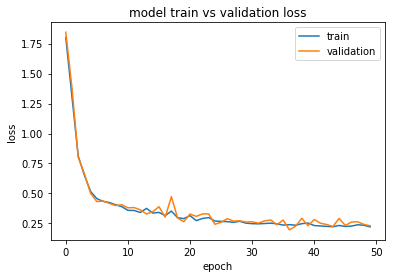

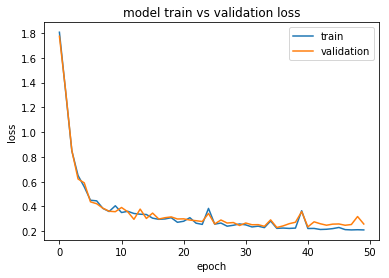

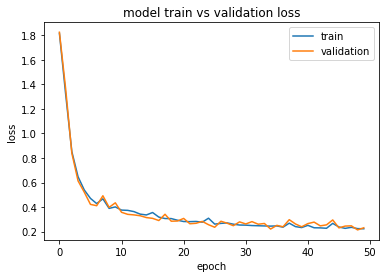

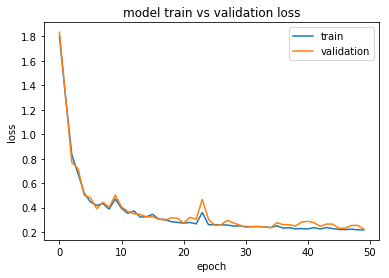

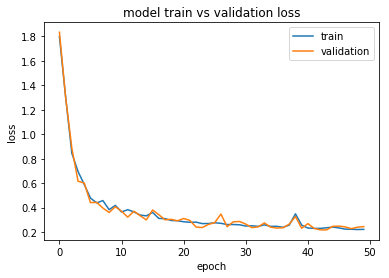

In [15]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

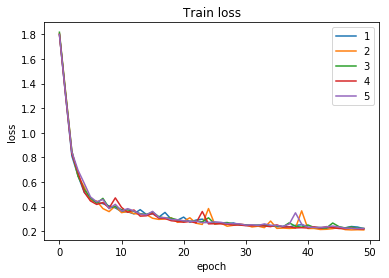

In [16]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

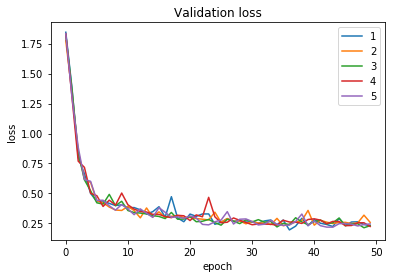

In [17]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [18]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

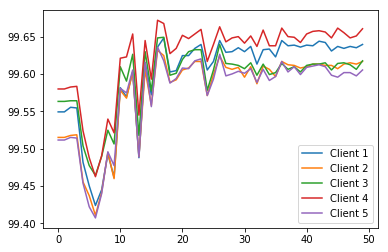

In [19]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

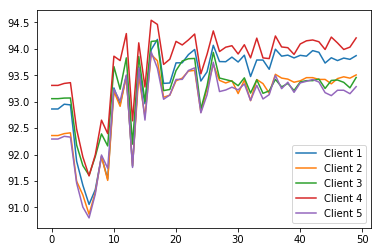

In [20]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()